<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [48]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# loss: 0.03

# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-01-27 09:38:00.751128: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_2974157/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    print(device)
#     tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-01-27 09:38:04.388846: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-27 09:38:04.885866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 09:38:04.886527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 09:38:04.886547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-27 09:38:04.886583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-27 09:38:04.886600: I tensorflow/stream_executor/platform/defa

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86    3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6    3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1    1.6.5   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc    3.0.0   
...                         ...                               ...      ...   
6380855a6a07f3e980b2c036     db  d7aef5b27c9fff2874da2a0921830933    3.0.0   
62a99e0f326a4191e5f173ad     db  8472939286321e3c8ef585c30b05fe12    3.0.0   
638f0a86b1363747e929f33e     db  461b6ddac974b6591eab0a40a9001669  22.12.6   
5f016dee777d4b67a92d5840   file  4ea9485a7c529809ed110d0c77f2e16f    2.0.0   
5efe9280777d4b67a92d56ce   file  02a4101c17ceaa4b9d473f6840ac4d7a    2.0.0   

                                               export_date      len  \
_id                                                                   
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00   1990.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00   6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00   5550.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00   5840.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00   6730.0   
...                                                    ...      ...   
6380855a6a07f3e980b2c036  2022-12-10 06:24:01.425413+00:00   4520.0   
62a99e0f326a4191e5f173ad  2022-12-10 06:20:35.897024+00:00   1450.0   
638f0a86b1363747e929f33e  2022-12-11 06:49:17.813434+00:00   1100.0   
5f016dee777d4b67a92d5840        2023-01-27 09:25:20.695449     20.0   
5efe9280777d4b67a92d56ce        2023-01-27 09:25:20.138326  14020.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
6346a561172785f510f15e2a 2022-10-12 14:31:24.479000+00:00  1.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
633ea99b9d08c565cfa1231e 2022-10-06 13:10:52.969000+00:00  5.000000e+10   
...                                                   ...           ...   
6380855a6a07f3e980b2c036 2022-11-25 12:55:27.119000+00:00           NaN   
62a99e0f326a4191e5f173ad 2022-06-15 12:07:52.422000+00:00           NaN   
638f0a86b1363747e929f33e 2022-12-06 12:31:49.329000+00:00           NaN   
5f016dee777d4b67a92d5840 2020-07-05 14:13:31.165000+00:00           NaN   
5efe9280777d4b67a92d56ce 2020-07-03 21:47:22.279000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...   
6346a561172785f510f15e2a    20.723266      1922.0      RUB  ...   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      NaN  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
633ea99b9d08c565cfa1231e    24.635289       401.0      RUB  ...   
...                               ...         ...      ...  ...   
6380855a6a07f3e980b2c036          NaN         NaN      NaN  ...   
62a99e0f326a4191e5f173ad          NaN         NaN      NaN  ...   
638f0a86b1363747e929f33e          NaN         NaN      NaN  ...   
5f016dee777d4b67a92d5840          NaN         NaN      NaN  ...   
5efe9280777d4b67a92d56ce          NaN         NaN      NaN  ...   

                         subject confidence             user_correction_date  \
_id                                                                            
6391b4771864c6df4d29f332           1.000000 2022-12-08 19:31:22.257000+00:00  

In [17]:
print(len(stats))

2741


In [18]:
from trainsets.trainset_tools import get_feature_log_weights
get_feature_log_weights(umtm.stats, 'subject')

Service                              0.463088
Deal                                 0.580825
Other                                0.594989
Renting                              0.697543
GeneralContract                      0.703433
Loans                                0.729413
AgencyContract                       0.794050
DealIntellectualProperty             0.811159
Charity                              0.858002
Insurance                            0.896925
RealEstate                           0.973391
RealEstateTransactions               1.190703
ParticipationInOtherOrganizations    1.315237
PledgeEncumbrance                    1.315237
BankGuarantees                       1.357603
SecuritiesTransactions               1.622318
AssetTransactions                    2.096083
Name: subject, dtype: float64

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [19]:
from trainsets.trainset_tools import get_feature_log_weights

stats = umtm.stats
subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights *= subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

1.0000000000000002
1.0
0.021097597916334216
0.24806334601084087
5.619170807928236
6.023495879123158


Service                              0.214451
Deal                                 0.337358
Other                                0.354012
Renting                              0.486567
GeneralContract                      0.494818
Loans                                0.532044
AgencyContract                       0.630515
DealIntellectualProperty             0.657979
Charity                              0.736168
Insurance                            0.804475
RealEstate                           0.947490
RealEstateTransactions               1.417774
ParticipationInOtherOrganizations    1.729848
PledgeEncumbrance                    1.729848
BankGuarantees                       1.843085
SecuritiesTransactions               2.631916
AssetTransactions                    4.393565
Name: subject, dtype: float64

In [20]:
from tf_support.super_contract_model import make_xyw

# from functools import lru_cache

# def _dp_fn(doc_id, suffix):
#     return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')



# @lru_cache(maxsize=72)
# def make_xyw(doc_id):

#     row = stats.loc[doc_id]

#     _subj = row['subject']
#     subject_one_hot = ContractSubject.encode_1_hot()[_subj]

#     embeddings =     np.load(_dp_fn(doc_id, 'embeddings'))
#     token_features = np.load(_dp_fn(doc_id, 'token_features'))
#     semantic_map =   np.load(_dp_fn(doc_id, 'semantic_map'))

#     if embeddings.shape[0] != token_features.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with token_features.shape {token_features.shape}'
#       raise AssertionError(msg)

#     if embeddings.shape[0] != semantic_map.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with semantic_map.shape {semantic_map.shape}'
#       raise AssertionError(msg)

#     stats.at[doc_id, 'error'] = None
    
#     return (
#       (embeddings, token_features),
#       (semantic_map, subject_one_hot),
#       (row['sample_weight'], row['subject_weight']))

# Validating training set

In [21]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]
del stats
print(len(stats_valid))
umtm.stats = stats = stats_valid

2741
CPU times: user 3.21 s, sys: 17.2 s, total: 20.5 s
Wall time: 1min 6s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [22]:
len(stats_valid)

2741

In [23]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0000000000000002
1.0
1.0
0.24806334601084087


sample_weight
MIN	 0.021097597916334213
MEAN	 0.9999999999999999


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


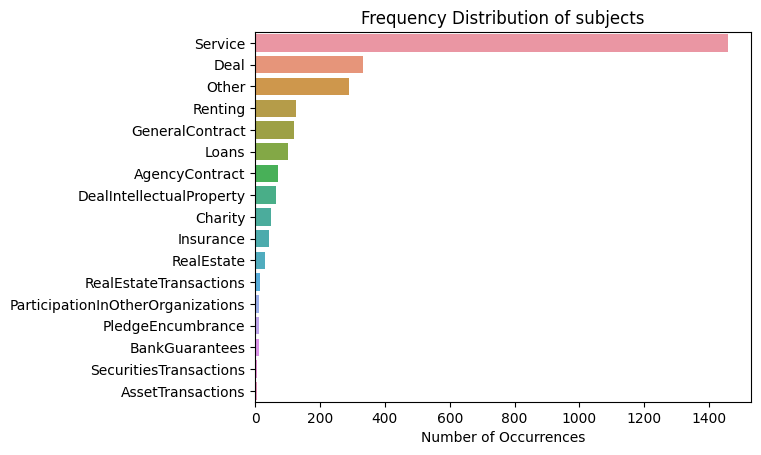


min 4
max 1457
total 2741


In [24]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [25]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['BankGuarantees', 'Loans', 'SecuritiesTransactions', 'GeneralContract', 'Service', 'AgencyContract', 'Charity', 'Renting', 'PledgeEncumbrance', 'Deal', 'DealIntellectualProperty', 'AssetTransactions', 'ParticipationInOtherOrganizations', 'Insurance', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.463088
Deal                                 0.580825
Other                                0.594989
Renting                              0.697543
GeneralContract                      0.703433
Loans                                0.729413
AgencyContract                       0.794050
DealIntellectualProperty             0.811159
Charity                              0.858002
Insurance                            0.896925
RealEstate                           0.973391
RealEstateTransactions               1.190703
ParticipationInOtherOrganizations    1.315237
PledgeEncumbrance                    1.315237
BankGuarantees                       1.357603
SecuritiesTransactions               1.622318
AssetTransactions                    2.096083
Name: subject, dtype: float64

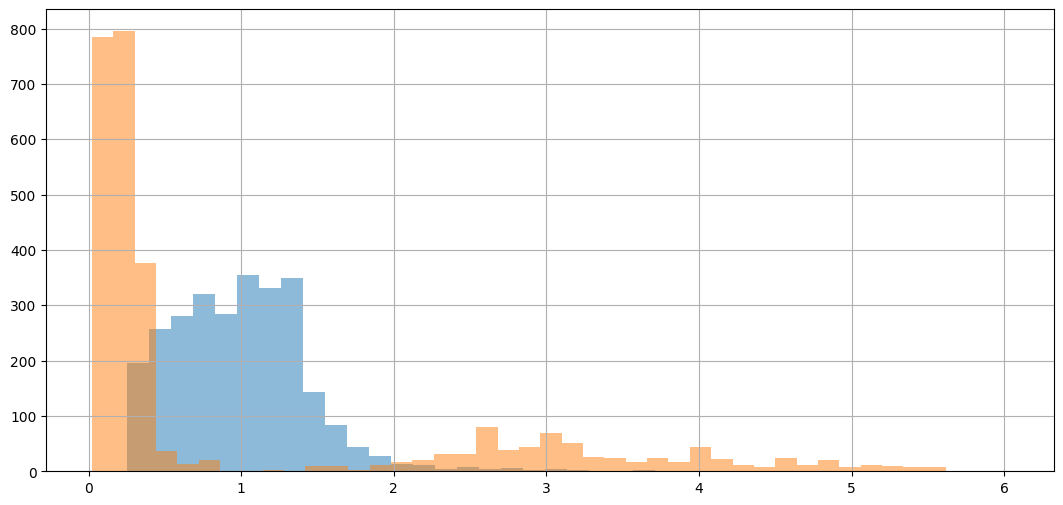

In [26]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

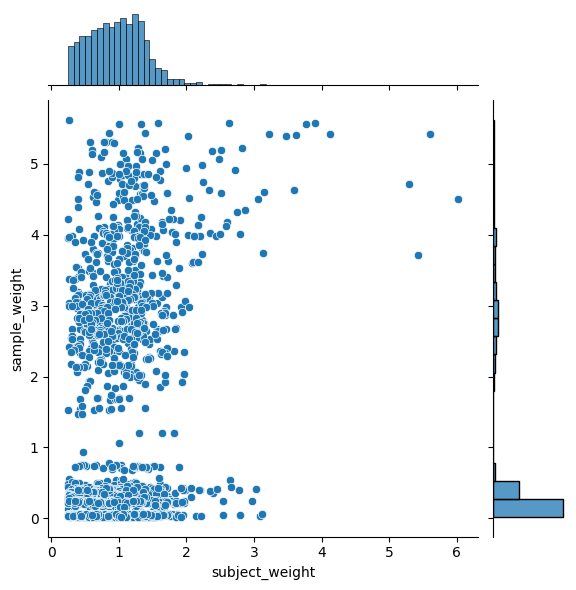

In [27]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 6346a561172785f510f15e2a
semantic map shape is: (6920, 30)


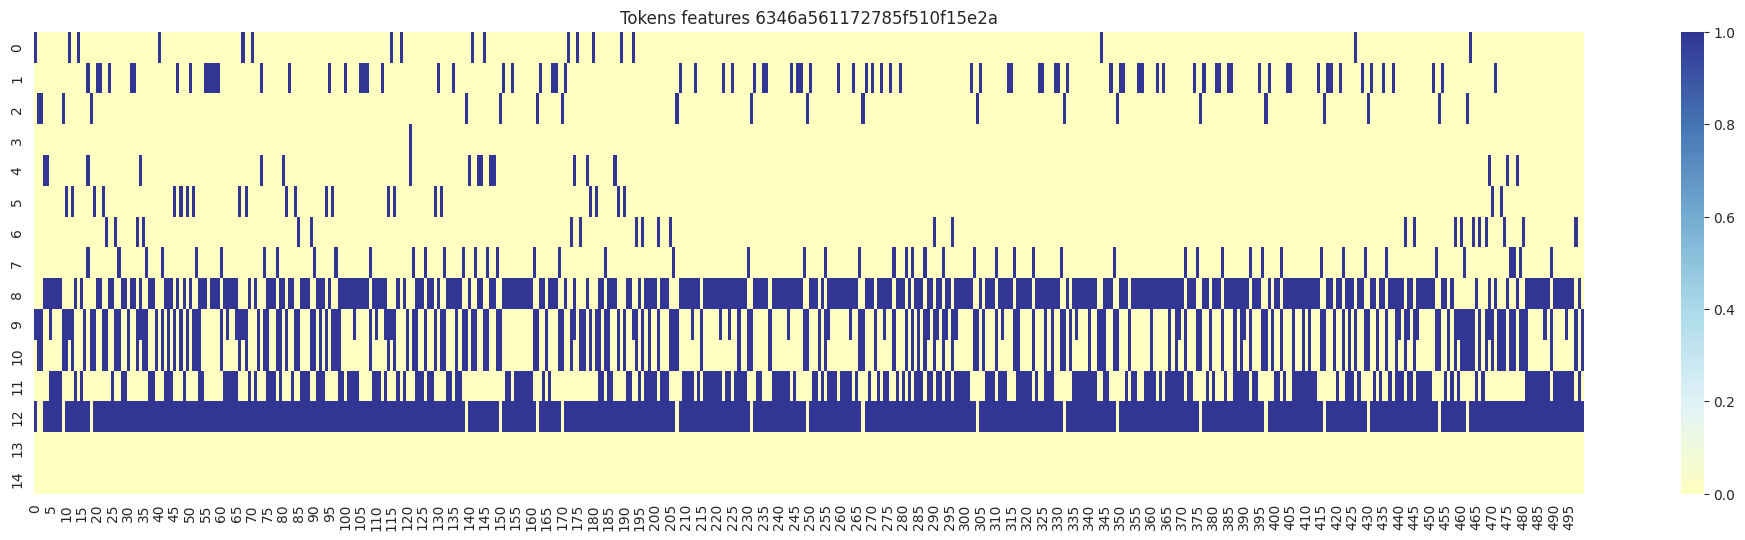

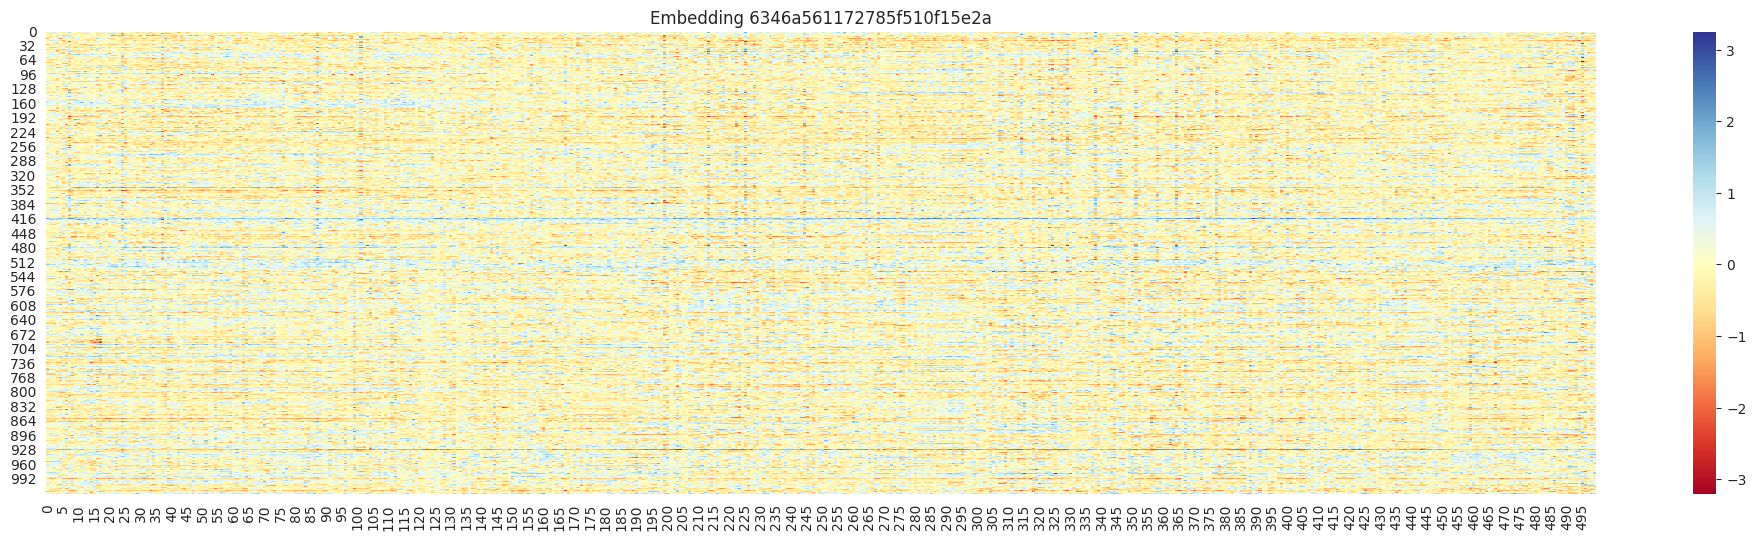

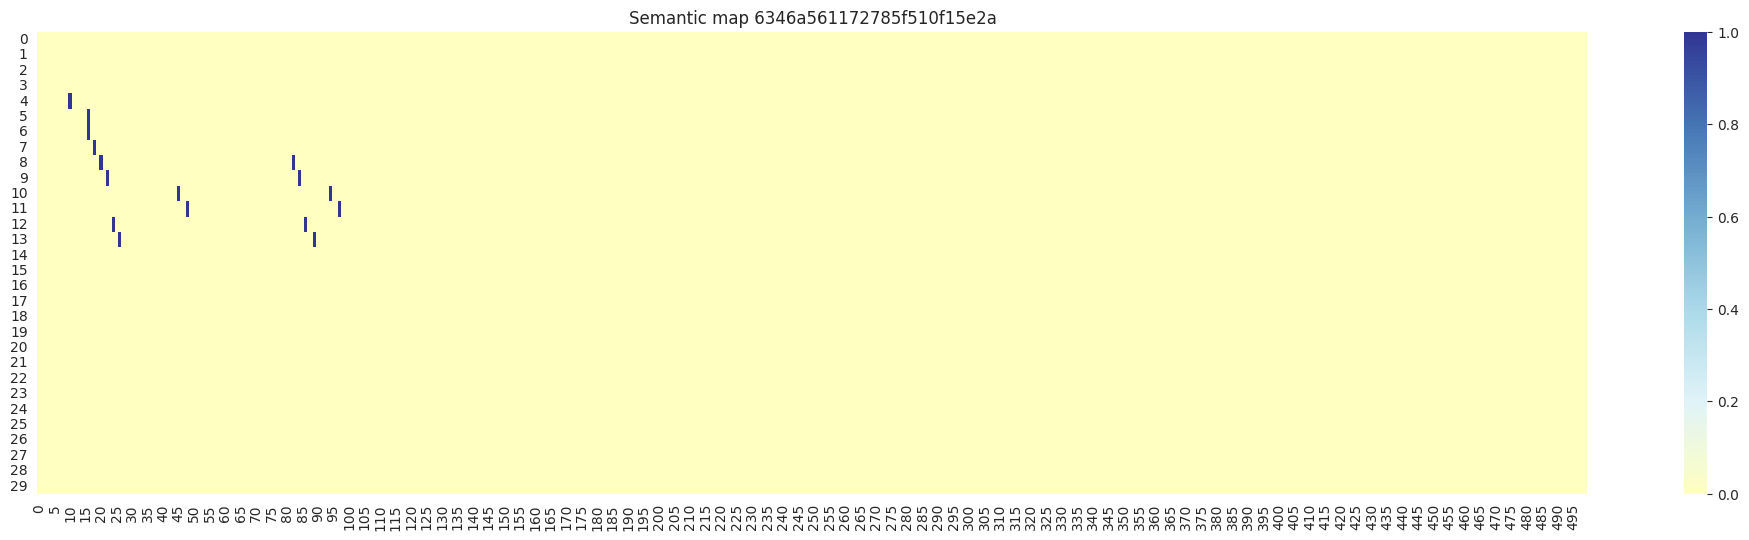

In [28]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [29]:
stats_valid = stats_valid[stats_valid.documentType != 'ANNEX']

3
semantic map shape is: (14, 1355, 30)


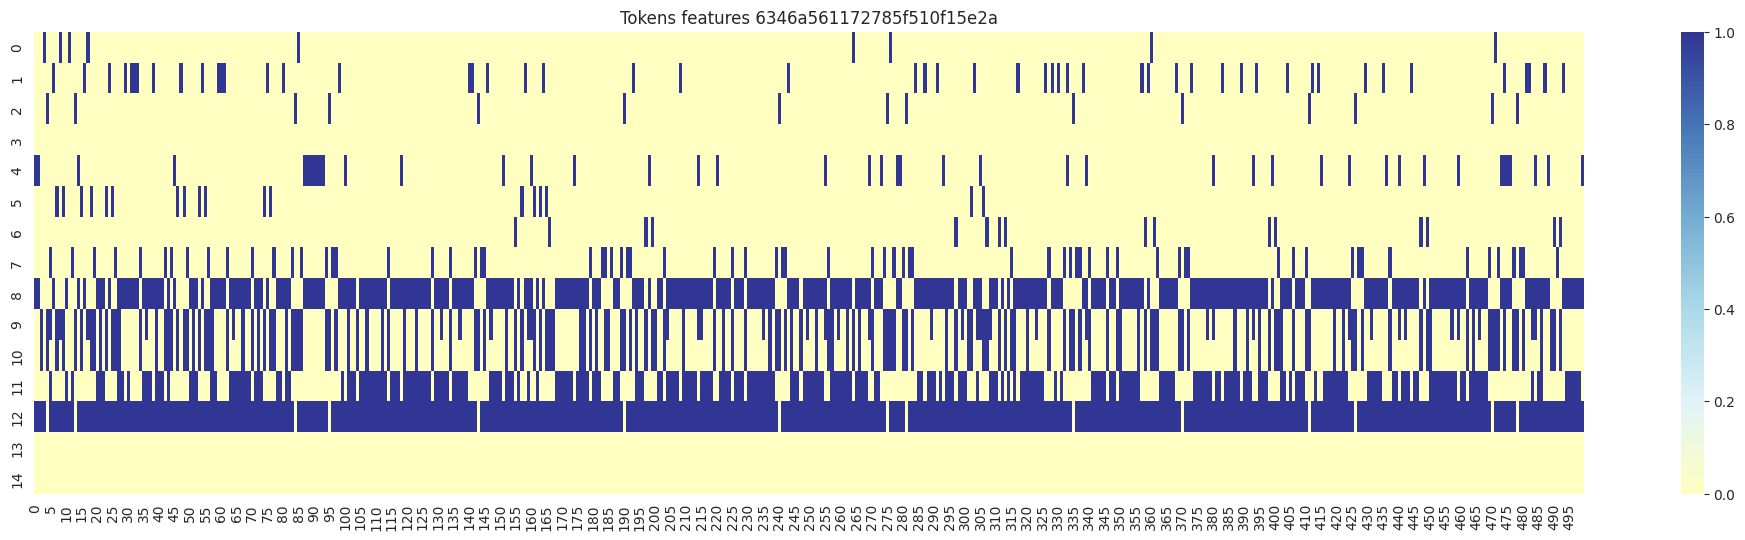

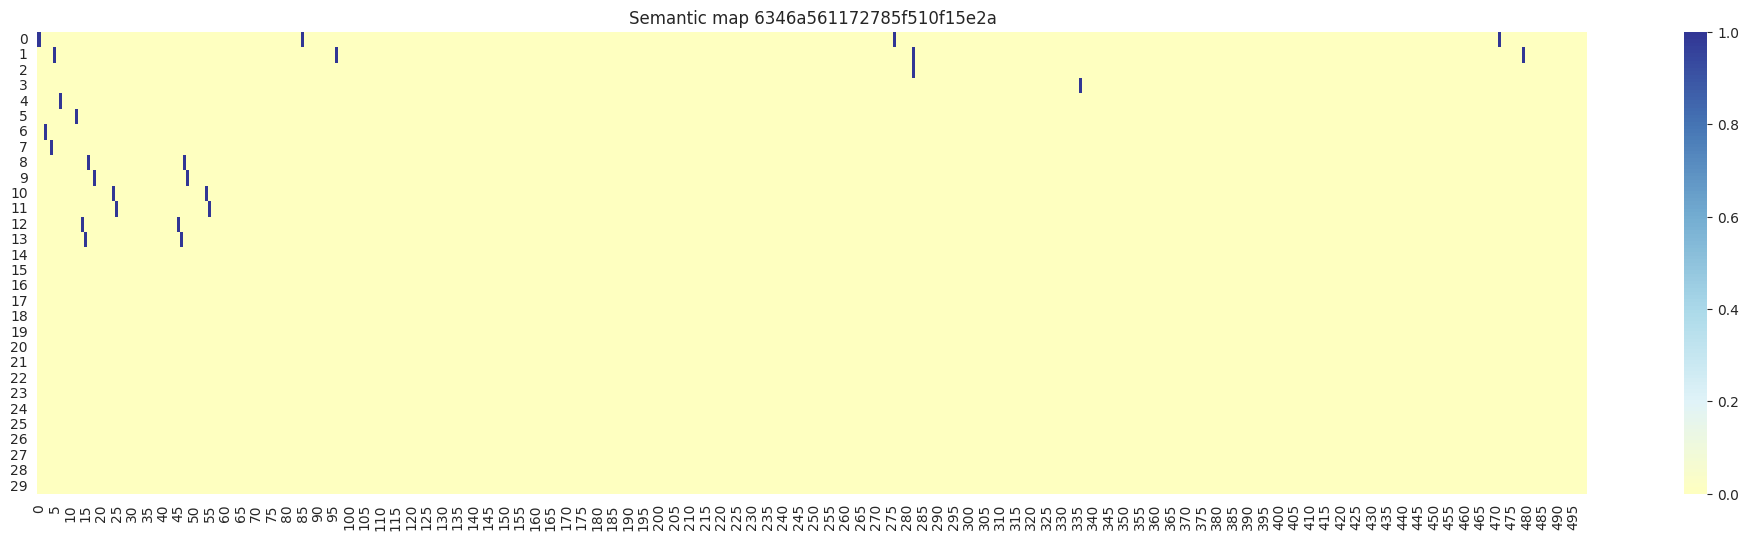

In [30]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map {SAMPLE_DOC_ID}')

train_indices[0]: 5fe4821ab770574a00555635
test_indices[0]: 5e5de70b01c6c73c19eebd36


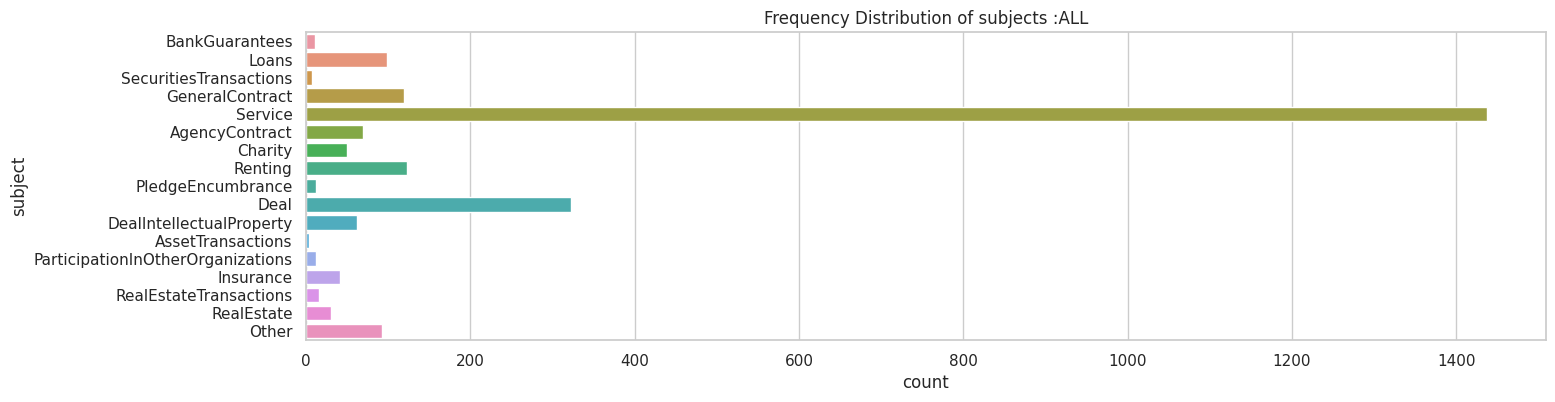

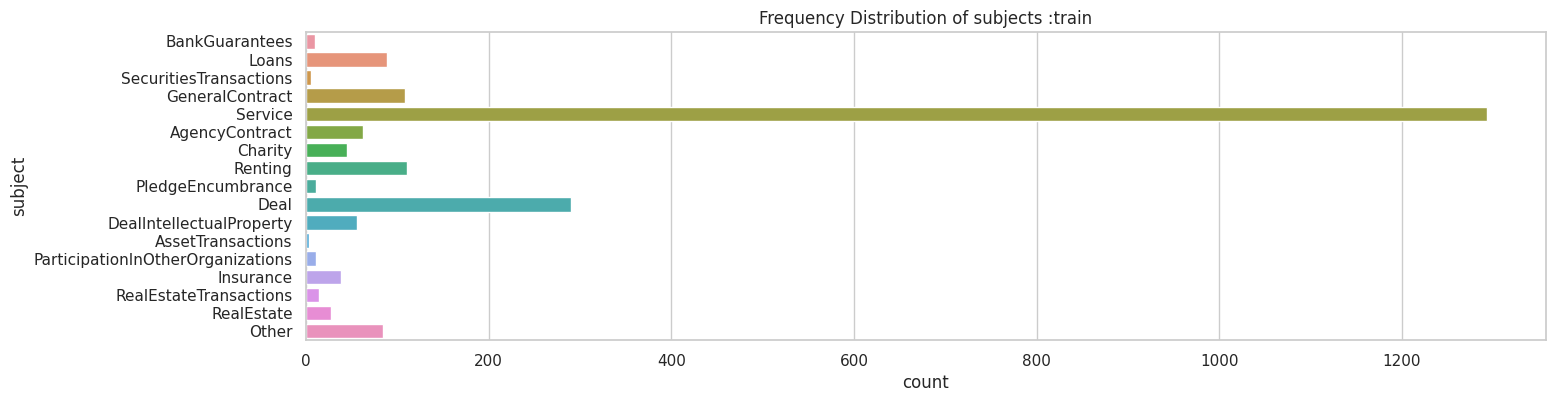

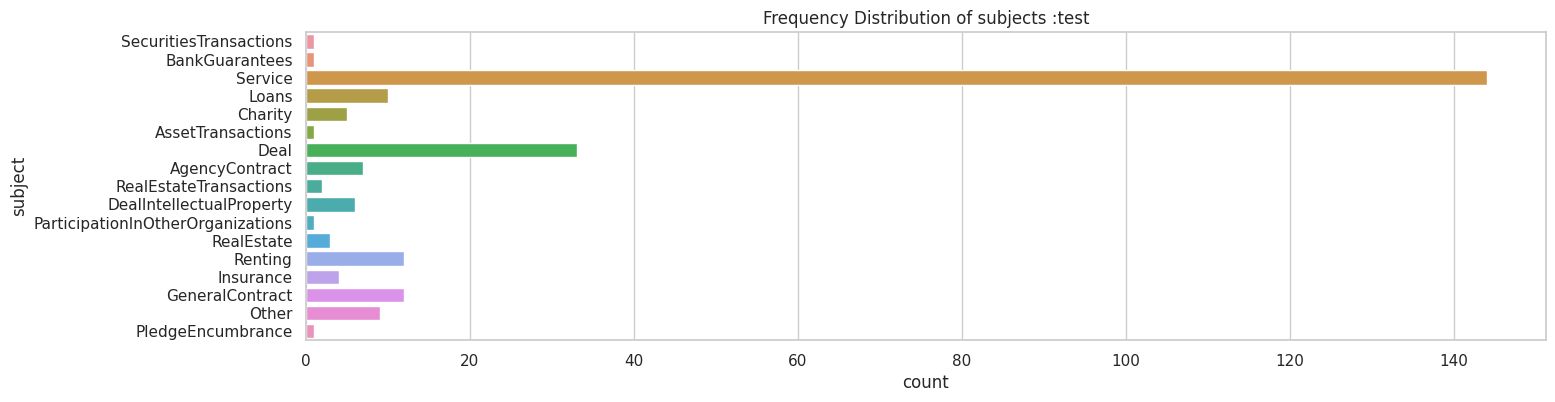

In [31]:
EPOCHS = 50
BATCH_SIZE = 128
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [32]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	128
train_samples:	9036
test_samples:	252
steps_per_epoch:	70
validation_steps:	35


# Models 🦖

In [33]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [34]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [35]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [36]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [37]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [38]:
# if TRAIN_MODEL_3:
model_factory_fn = uber_detection_model_005_1_1
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

umodel.summary()

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 20
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

2023-01-27 09:39:22.824055: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 09:39:22.824561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 09:39:22.825253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 09:39:22.825324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-01-27 09:39:25.618281: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 282066944 exceeds 10% of free system memory.
2023-01-27 09:39:25.750080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-27 09:39:25.769949: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/20


2023-01-27 09:39:29.471773: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 282066944 exceeds 10% of free system memory.
2023-01-27 09:39:29.606283: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-01-27 09:39:30.559588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


2023-01-27 09:39:31.365997: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 419430400 exceeds 10% of free system memory.
2023-01-27 09:39:31.494661: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-27 09:39:31.495052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2023-01-27 09:39:31.807562: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/70 [..............................] - ETA: 7:43 - loss: 0.5525 - O1_tagging_loss: 0.1111 - O2_subject_loss: 0.4414 - O1_tagging_kullback_leibler_divergence: 0.3229 - O1_tagging_mse: 0.0262 - O1_tagging_binary_crossentropy: 0.1222 - O2_subject_kullback_leibler_divergence: 3.7804 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7083

 2/70 [..............................] - ETA: 20s - loss: 0.5354 - O1_tagging_loss: 0.0799 - O2_subject_loss: 0.4554 - O1_tagging_kullback_leibler_divergence: 0.3380 - O1_tagging_mse: 0.0149 - O1_tagging_binary_crossentropy: 0.0733 - O2_subject_kullback_leibler_divergence: 3.7668 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6970 

2023-01-27 09:39:34.430517: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 706215936 exceeds 10% of free system memory.


 3/70 [>.............................] - ETA: 1:28 - loss: 0.5107 - O1_tagging_loss: 0.0619 - O2_subject_loss: 0.4488 - O1_tagging_kullback_leibler_divergence: 0.3064 - O1_tagging_mse: 0.0085 - O1_tagging_binary_crossentropy: 0.0473 - O2_subject_kullback_leibler_divergence: 3.7463 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6869

 4/70 [>.............................] - ETA: 1:19 - loss: 0.5042 - O1_tagging_loss: 0.0538 - O2_subject_loss: 0.4504 - O1_tagging_kullback_leibler_divergence: 0.3371 - O1_tagging_mse: 0.0073 - O1_tagging_binary_crossentropy: 0.0427 - O2_subject_kullback_leibler_divergence: 3.7301 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6767

2023-01-27 09:39:35.811780: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 305659904 exceeds 10% of free system memory.


 5/70 [=>............................] - ETA: 1:27 - loss: 0.4984 - O1_tagging_loss: 0.0458 - O2_subject_loss: 0.4527 - O1_tagging_kullback_leibler_divergence: 0.3302 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0345 - O2_subject_kullback_leibler_divergence: 3.7017 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6662

 6/70 [=>............................] - ETA: 1:17 - loss: 0.4817 - O1_tagging_loss: 0.0417 - O2_subject_loss: 0.4400 - O1_tagging_kullback_leibler_divergence: 0.3511 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0333 - O2_subject_kullback_leibler_divergence: 3.6686 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6541

 7/70 [==>...........................] - ETA: 1:11 - loss: 0.4650 - O1_tagging_loss: 0.0389 - O2_subject_loss: 0.4261 - O1_tagging_kullback_leibler_divergence: 0.3728 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0328 - O2_subject_kullback_leibler_divergence: 3.6496 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6425

 8/70 [==>...........................] - ETA: 1:17 - loss: 0.4554 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.4195 - O1_tagging_kullback_leibler_divergence: 0.3659 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_kullback_leibler_divergence: 3.6215 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.6314

 9/70 [==>...........................] - ETA: 1:15 - loss: 0.4428 - O1_tagging_loss: 0.0342 - O2_subject_loss: 0.4086 - O1_tagging_kullback_leibler_divergence: 0.3776 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0282 - O2_subject_kullback_leibler_divergence: 3.6084 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.6206

10/70 [===>..........................] - ETA: 1:12 - loss: 0.4340 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.4013 - O1_tagging_kullback_leibler_divergence: 0.3857 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0273 - O2_subject_kullback_leibler_divergence: 3.5873 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.6097

11/70 [===>..........................] - ETA: 1:17 - loss: 0.4289 - O1_tagging_loss: 0.0324 - O2_subject_loss: 0.3965 - O1_tagging_kullback_leibler_divergence: 0.3750 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0272 - O2_subject_kullback_leibler_divergence: 3.5673 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.6001

12/70 [====>.........................] - ETA: 1:18 - loss: 0.4199 - O1_tagging_loss: 0.0311 - O2_subject_loss: 0.3888 - O1_tagging_kullback_leibler_divergence: 0.3678 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0253 - O2_subject_kullback_leibler_divergence: 3.5558 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5910

13/70 [====>.........................] - ETA: 1:16 - loss: 0.4123 - O1_tagging_loss: 0.0301 - O2_subject_loss: 0.3822 - O1_tagging_kullback_leibler_divergence: 0.3706 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_kullback_leibler_divergence: 3.5446 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5822

14/70 [=====>........................] - ETA: 1:16 - loss: 0.4035 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.3747 - O1_tagging_kullback_leibler_divergence: 0.3677 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_kullback_leibler_divergence: 3.5392 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5744

15/70 [=====>........................] - ETA: 1:14 - loss: 0.3970 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.3690 - O1_tagging_kullback_leibler_divergence: 0.3732 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_kullback_leibler_divergence: 3.5239 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5660

16/70 [=====>........................] - ETA: 1:15 - loss: 0.3917 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.3646 - O1_tagging_kullback_leibler_divergence: 0.3674 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_kullback_leibler_divergence: 3.5125 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5584

17/70 [======>.......................] - ETA: 1:14 - loss: 0.3848 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.3587 - O1_tagging_kullback_leibler_divergence: 0.3631 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_kullback_leibler_divergence: 3.5062 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5507

18/70 [======>.......................] - ETA: 1:13 - loss: 0.3795 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.3541 - O1_tagging_kullback_leibler_divergence: 0.3637 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_kullback_leibler_divergence: 3.4984 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5431

19/70 [=======>......................] - ETA: 1:13 - loss: 0.3763 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.3515 - O1_tagging_kullback_leibler_divergence: 0.3625 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_kullback_leibler_divergence: 3.4944 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5358

20/70 [=======>......................] - ETA: 1:11 - loss: 0.3693 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.3450 - O1_tagging_kullback_leibler_divergence: 0.3643 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_kullback_leibler_divergence: 3.4872 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5283

21/70 [========>.....................] - ETA: 1:09 - loss: 0.3634 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.3390 - O1_tagging_kullback_leibler_divergence: 0.3700 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_kullback_leibler_divergence: 3.4800 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5210

22/70 [========>.....................] - ETA: 1:07 - loss: 0.3588 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.3342 - O1_tagging_kullback_leibler_divergence: 0.3731 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_kullback_leibler_divergence: 3.4711 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5140

23/70 [========>.....................] - ETA: 1:06 - loss: 0.3531 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.3292 - O1_tagging_kullback_leibler_divergence: 0.3704 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_kullback_leibler_divergence: 3.4668 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5074

24/70 [=========>....................] - ETA: 1:06 - loss: 0.3481 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.3245 - O1_tagging_kullback_leibler_divergence: 0.3692 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_kullback_leibler_divergence: 3.4621 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.5009

25/70 [=========>....................] - ETA: 1:04 - loss: 0.3439 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.3204 - O1_tagging_kullback_leibler_divergence: 0.3716 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_kullback_leibler_divergence: 3.4500 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4943

26/70 [==========>...................] - ETA: 1:05 - loss: 0.3381 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.3151 - O1_tagging_kullback_leibler_divergence: 0.3681 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_kullback_leibler_divergence: 3.4419 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4882

27/70 [==========>...................] - ETA: 1:03 - loss: 0.3340 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.3113 - O1_tagging_kullback_leibler_divergence: 0.3687 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_kullback_leibler_divergence: 3.4409 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4824

28/70 [===========>..................] - ETA: 1:00 - loss: 0.3311 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.3080 - O1_tagging_kullback_leibler_divergence: 0.3741 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_kullback_leibler_divergence: 3.4400 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4763

29/70 [===========>..................] - ETA: 58s - loss: 0.3268 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.3035 - O1_tagging_kullback_leibler_divergence: 0.3780 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_kullback_leibler_divergence: 3.4363 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4704 

30/70 [===========>..................] - ETA: 56s - loss: 0.3239 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.3008 - O1_tagging_kullback_leibler_divergence: 0.3783 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_kullback_leibler_divergence: 3.4318 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4650

31/70 [============>.................] - ETA: 55s - loss: 0.3201 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.2970 - O1_tagging_kullback_leibler_divergence: 0.3814 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_kullback_leibler_divergence: 3.4289 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4595

32/70 [============>.................] - ETA: 55s - loss: 0.3157 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.2930 - O1_tagging_kullback_leibler_divergence: 0.3795 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_kullback_leibler_divergence: 3.4257 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4542

33/70 [=============>................] - ETA: 54s - loss: 0.3124 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.2899 - O1_tagging_kullback_leibler_divergence: 0.3788 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_kullback_leibler_divergence: 3.4251 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4490

34/70 [=============>................] - ETA: 52s - loss: 0.3088 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.2862 - O1_tagging_kullback_leibler_divergence: 0.3821 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_kullback_leibler_divergence: 3.4193 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4438

35/70 [==============>...............] - ETA: 51s - loss: 0.3045 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.2822 - O1_tagging_kullback_leibler_divergence: 0.3818 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_kullback_leibler_divergence: 3.4133 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4387

36/70 [==============>...............] - ETA: 49s - loss: 0.3015 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.2793 - O1_tagging_kullback_leibler_divergence: 0.3838 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_kullback_leibler_divergence: 3.4087 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4338

37/70 [==============>...............] - ETA: 49s - loss: 0.2983 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.2763 - O1_tagging_kullback_leibler_divergence: 0.3804 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_kullback_leibler_divergence: 3.4061 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4291

38/70 [===============>..............] - ETA: 47s - loss: 0.2954 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.2736 - O1_tagging_kullback_leibler_divergence: 0.3809 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_kullback_leibler_divergence: 3.4025 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4245

39/70 [===============>..............] - ETA: 46s - loss: 0.2927 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.2710 - O1_tagging_kullback_leibler_divergence: 0.3800 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_kullback_leibler_divergence: 3.4004 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4200

40/70 [================>.............] - ETA: 44s - loss: 0.2904 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.2689 - O1_tagging_kullback_leibler_divergence: 0.3789 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_kullback_leibler_divergence: 3.3958 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4155

41/70 [================>.............] - ETA: 42s - loss: 0.2871 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.2657 - O1_tagging_kullback_leibler_divergence: 0.3788 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_kullback_leibler_divergence: 3.3909 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4111

42/70 [=================>............] - ETA: 41s - loss: 0.2847 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.2633 - O1_tagging_kullback_leibler_divergence: 0.3768 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_kullback_leibler_divergence: 3.3858 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4074

43/70 [=================>............] - ETA: 40s - loss: 0.2820 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.2606 - O1_tagging_kullback_leibler_divergence: 0.3735 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_kullback_leibler_divergence: 3.3848 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4034

44/70 [=================>............] - ETA: 38s - loss: 0.2793 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.2581 - O1_tagging_kullback_leibler_divergence: 0.3714 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_kullback_leibler_divergence: 3.3815 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.3994

45/70 [==================>...........] - ETA: 37s - loss: 0.2765 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.2555 - O1_tagging_kullback_leibler_divergence: 0.3685 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_kullback_leibler_divergence: 3.3781 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.3955

46/70 [==================>...........] - ETA: 35s - loss: 0.2738 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.2529 - O1_tagging_kullback_leibler_divergence: 0.3682 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_kullback_leibler_divergence: 3.3733 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.3916

47/70 [===================>..........] - ETA: 34s - loss: 0.2710 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.2504 - O1_tagging_kullback_leibler_divergence: 0.3640 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_kullback_leibler_divergence: 3.3686 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.3878

48/70 [===================>..........] - ETA: 32s - loss: 0.2684 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.2478 - O1_tagging_kullback_leibler_divergence: 0.3655 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_kullback_leibler_divergence: 3.3621 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.3840

49/70 [====================>.........] - ETA: 30s - loss: 0.2662 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.2457 - O1_tagging_kullback_leibler_divergence: 0.3653 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_kullback_leibler_divergence: 3.3589 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.3804

50/70 [====================>.........] - ETA: 29s - loss: 0.2639 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.2433 - O1_tagging_kullback_leibler_divergence: 0.3669 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_kullback_leibler_divergence: 3.3542 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.3767

51/70 [====================>.........] - ETA: 27s - loss: 0.2614 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.2409 - O1_tagging_kullback_leibler_divergence: 0.3667 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_kullback_leibler_divergence: 3.3474 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.3732

52/70 [=====================>........] - ETA: 26s - loss: 0.2592 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.2388 - O1_tagging_kullback_leibler_divergence: 0.3654 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_kullback_leibler_divergence: 3.3413 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.3697

53/70 [=====================>........] - ETA: 24s - loss: 0.2568 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.2366 - O1_tagging_kullback_leibler_divergence: 0.3662 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_kullback_leibler_divergence: 3.3365 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.3663

54/70 [======================>.......] - ETA: 23s - loss: 0.2549 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.2347 - O1_tagging_kullback_leibler_divergence: 0.3672 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_kullback_leibler_divergence: 3.3320 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.3630

55/70 [======================>.......] - ETA: 21s - loss: 0.2527 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.2327 - O1_tagging_kullback_leibler_divergence: 0.3639 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_kullback_leibler_divergence: 3.3273 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.3598

56/70 [=======================>......] - ETA: 20s - loss: 0.2506 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.2307 - O1_tagging_kullback_leibler_divergence: 0.3623 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_kullback_leibler_divergence: 3.3202 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.3566

57/70 [=======================>......] - ETA: 18s - loss: 0.2481 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.2285 - O1_tagging_kullback_leibler_divergence: 0.3596 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_kullback_leibler_divergence: 3.3117 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.3534

58/70 [=======================>......] - ETA: 17s - loss: 0.2463 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.2266 - O1_tagging_kullback_leibler_divergence: 0.3607 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_kullback_leibler_divergence: 3.3066 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3504

59/70 [========================>.....] - ETA: 16s - loss: 0.2444 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.2249 - O1_tagging_kullback_leibler_divergence: 0.3581 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_kullback_leibler_divergence: 3.3018 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3475

60/70 [========================>.....] - ETA: 14s - loss: 0.2424 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.2229 - O1_tagging_kullback_leibler_divergence: 0.3586 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_kullback_leibler_divergence: 3.2960 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3445

61/70 [=========================>....] - ETA: 13s - loss: 0.2405 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.2211 - O1_tagging_kullback_leibler_divergence: 0.3553 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_kullback_leibler_divergence: 3.2897 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3416

62/70 [=========================>....] - ETA: 11s - loss: 0.2387 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.2195 - O1_tagging_kullback_leibler_divergence: 0.3535 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_kullback_leibler_divergence: 3.2858 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3389

63/70 [==========================>...] - ETA: 10s - loss: 0.2368 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.2178 - O1_tagging_kullback_leibler_divergence: 0.3517 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2791 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3362

64/70 [==========================>...] - ETA: 8s - loss: 0.2351 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.2161 - O1_tagging_kullback_leibler_divergence: 0.3523 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2727 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3335 

65/70 [==========================>...] - ETA: 7s - loss: 0.2334 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.2144 - O1_tagging_kullback_leibler_divergence: 0.3528 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2700 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3309

66/70 [===========================>..] - ETA: 5s - loss: 0.2317 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.2127 - O1_tagging_kullback_leibler_divergence: 0.3531 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2656 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3283

67/70 [===========================>..] - ETA: 4s - loss: 0.2298 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.2110 - O1_tagging_kullback_leibler_divergence: 0.3536 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2579 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3257

68/70 [============================>.] - ETA: 2s - loss: 0.2281 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.2093 - O1_tagging_kullback_leibler_divergence: 0.3546 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2520 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3231

69/70 [============================>.] - ETA: 1s - loss: 0.2262 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.2074 - O1_tagging_kullback_leibler_divergence: 0.3555 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_kullback_leibler_divergence: 3.2464 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3206

70/70 [==============================] - ETA: 0s - loss: 0.2243 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.2056 - O1_tagging_kullback_leibler_divergence: 0.3543 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_kullback_leibler_divergence: 3.2407 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3182

70/70 [==============================] - 162s 2s/step - loss: 0.2243 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.2056 - O1_tagging_kullback_leibler_divergence: 0.3543 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_kullback_leibler_divergence: 3.2407 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3182 - val_loss: 0.1634 - val_O1_tagging_loss: 0.0110 - val_O2_subject_loss: 0.1524 - val_O1_tagging_kullback_leibler_divergence: 0.2496 - val_O1_tagging_mse: 6.7044e-04 - val_O1_tagging_binary_crossentropy: 0.0091 - val_O2_subject_kullback_leibler_divergence: 2.8311 - val_O2_subject_mse: 0.0203 - val_O2_subject_binary_crossentropy: 0.1456



Epoch 00001: val_loss improved from inf to 0.16336, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/20


 1/70 [..............................] - ETA: 8s - loss: 0.1376 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.1103 - O1_tagging_kullback_leibler_divergence: 0.5696 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_kullback_leibler_divergence: 3.0150 - O2_subject_mse: 0.0206 - O2_subject_binary_crossentropy: 0.1545

 2/70 [..............................] - ETA: 2:54 - loss: 0.1164 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0964 - O1_tagging_kullback_leibler_divergence: 0.3650 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_kullback_leibler_divergence: 2.8694 - O2_subject_mse: 0.0203 - O2_subject_binary_crossentropy: 0.1500

 3/70 [>.............................] - ETA: 2:31 - loss: 0.1166 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0981 - O1_tagging_kullback_leibler_divergence: 0.3330 - O1_tagging_mse: 9.2187e-04 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_kullback_leibler_divergence: 2.8605 - O2_subject_mse: 0.0204 - O2_subject_binary_crossentropy: 0.1487

 4/70 [>.............................] - ETA: 2:13 - loss: 0.1148 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0973 - O1_tagging_kullback_leibler_divergence: 0.3411 - O1_tagging_mse: 9.4785e-04 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_kullback_leibler_divergence: 2.8285 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 0.1475

 5/70 [=>............................] - ETA: 2:26 - loss: 0.1156 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0988 - O1_tagging_kullback_leibler_divergence: 0.3128 - O1_tagging_mse: 8.5750e-04 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_kullback_leibler_divergence: 2.8173 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 0.1468

 6/70 [=>............................] - ETA: 2:15 - loss: 0.1109 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0948 - O1_tagging_kullback_leibler_divergence: 0.3107 - O1_tagging_mse: 8.5403e-04 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_kullback_leibler_divergence: 2.7877 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.1453

 7/70 [==>...........................] - ETA: 2:11 - loss: 0.1085 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0931 - O1_tagging_kullback_leibler_divergence: 0.3025 - O1_tagging_mse: 8.2264e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.7861 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.1445

 8/70 [==>...........................] - ETA: 2:06 - loss: 0.1074 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0924 - O1_tagging_kullback_leibler_divergence: 0.3004 - O1_tagging_mse: 8.1705e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.7988 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.1439

 9/70 [==>...........................] - ETA: 2:02 - loss: 0.1063 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0913 - O1_tagging_kullback_leibler_divergence: 0.2991 - O1_tagging_mse: 8.1070e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.8075 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.1435

10/70 [===>..........................] - ETA: 1:57 - loss: 0.1060 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0913 - O1_tagging_kullback_leibler_divergence: 0.2986 - O1_tagging_mse: 8.1126e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.7944 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.1426

11/70 [===>..........................] - ETA: 1:54 - loss: 0.1056 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0912 - O1_tagging_kullback_leibler_divergence: 0.2980 - O1_tagging_mse: 8.1234e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.7914 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.1418

12/70 [====>.........................] - ETA: 1:50 - loss: 0.1057 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0907 - O1_tagging_kullback_leibler_divergence: 0.3063 - O1_tagging_mse: 8.3888e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.7794 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.1408

13/70 [====>.........................] - ETA: 1:49 - loss: 0.1056 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0906 - O1_tagging_kullback_leibler_divergence: 0.3113 - O1_tagging_mse: 8.5455e-04 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_kullback_leibler_divergence: 2.7842 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.1404

14/70 [=====>........................] - ETA: 1:46 - loss: 0.1052 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0899 - O1_tagging_kullback_leibler_divergence: 0.3177 - O1_tagging_mse: 8.7419e-04 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_kullback_leibler_divergence: 2.7805 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.1396

15/70 [=====>........................] - ETA: 1:44 - loss: 0.1045 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0894 - O1_tagging_kullback_leibler_divergence: 0.3170 - O1_tagging_mse: 8.7235e-04 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_kullback_leibler_divergence: 2.7668 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 0.1388

16/70 [=====>........................] - ETA: 1:42 - loss: 0.1034 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0885 - O1_tagging_kullback_leibler_divergence: 0.3145 - O1_tagging_mse: 8.6736e-04 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_kullback_leibler_divergence: 2.7566 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 0.1380

17/70 [======>.......................] - ETA: 1:41 - loss: 0.1032 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0883 - O1_tagging_kullback_leibler_divergence: 0.3169 - O1_tagging_mse: 8.7696e-04 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_kullback_leibler_divergence: 2.7497 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.1373

18/70 [======>.......................] - ETA: 1:41 - loss: 0.1031 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0884 - O1_tagging_kullback_leibler_divergence: 0.3133 - O1_tagging_mse: 8.6603e-04 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_kullback_leibler_divergence: 2.7463 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.1366

19/70 [=======>......................] - ETA: 1:40 - loss: 0.1029 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0885 - O1_tagging_kullback_leibler_divergence: 0.3082 - O1_tagging_mse: 8.5181e-04 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_kullback_leibler_divergence: 2.7445 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.1362

20/70 [=======>......................] - ETA: 1:40 - loss: 0.1025 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0881 - O1_tagging_kullback_leibler_divergence: 0.3027 - O1_tagging_mse: 8.3695e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.7366 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.1355

21/70 [========>.....................] - ETA: 1:37 - loss: 0.1027 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0884 - O1_tagging_kullback_leibler_divergence: 0.3046 - O1_tagging_mse: 8.4531e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.7342 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.1350

22/70 [========>.....................] - ETA: 1:35 - loss: 0.1023 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0880 - O1_tagging_kullback_leibler_divergence: 0.3025 - O1_tagging_mse: 8.4119e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.7216 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.1343

23/70 [========>.....................] - ETA: 1:34 - loss: 0.1021 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0880 - O1_tagging_kullback_leibler_divergence: 0.2977 - O1_tagging_mse: 8.2721e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.7249 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.1339

24/70 [=========>....................] - ETA: 1:30 - loss: 0.1026 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0884 - O1_tagging_kullback_leibler_divergence: 0.2974 - O1_tagging_mse: 8.2841e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.7288 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.1335

25/70 [=========>....................] - ETA: 1:29 - loss: 0.1014 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0874 - O1_tagging_kullback_leibler_divergence: 0.2965 - O1_tagging_mse: 8.2628e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.7194 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.1327

26/70 [==========>...................] - ETA: 1:26 - loss: 0.1017 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0875 - O1_tagging_kullback_leibler_divergence: 0.2979 - O1_tagging_mse: 8.3276e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.7219 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.1323

27/70 [==========>...................] - ETA: 1:24 - loss: 0.1014 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0874 - O1_tagging_kullback_leibler_divergence: 0.2954 - O1_tagging_mse: 8.2692e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.7121 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.1316

28/70 [===========>..................] - ETA: 1:22 - loss: 0.1010 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0871 - O1_tagging_kullback_leibler_divergence: 0.2952 - O1_tagging_mse: 8.2880e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.7057 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.1310

29/70 [===========>..................] - ETA: 1:19 - loss: 0.1003 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0865 - O1_tagging_kullback_leibler_divergence: 0.2971 - O1_tagging_mse: 8.3504e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.6971 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.1303

30/70 [===========>..................] - ETA: 1:17 - loss: 0.1003 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0862 - O1_tagging_kullback_leibler_divergence: 0.2997 - O1_tagging_mse: 8.4449e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.6985 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.1298

31/70 [============>.................] - ETA: 1:14 - loss: 0.0996 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0855 - O1_tagging_kullback_leibler_divergence: 0.3007 - O1_tagging_mse: 8.4837e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6913 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.1292

32/70 [============>.................] - ETA: 1:12 - loss: 0.0993 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0852 - O1_tagging_kullback_leibler_divergence: 0.2983 - O1_tagging_mse: 8.6320e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6874 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.1287

33/70 [=============>................] - ETA: 1:10 - loss: 0.0991 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0851 - O1_tagging_kullback_leibler_divergence: 0.2982 - O1_tagging_mse: 8.6731e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6831 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.1282

34/70 [=============>................] - ETA: 1:08 - loss: 0.0989 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0849 - O1_tagging_kullback_leibler_divergence: 0.2984 - O1_tagging_mse: 8.7120e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.6783 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.1277

35/70 [==============>...............] - ETA: 1:06 - loss: 0.0985 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0846 - O1_tagging_kullback_leibler_divergence: 0.2973 - O1_tagging_mse: 8.6916e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6773 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.1273

36/70 [==============>...............] - ETA: 1:04 - loss: 0.0986 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0845 - O1_tagging_kullback_leibler_divergence: 0.2993 - O1_tagging_mse: 8.8205e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.6679 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.1267

37/70 [==============>...............] - ETA: 1:03 - loss: 0.0983 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0844 - O1_tagging_kullback_leibler_divergence: 0.2960 - O1_tagging_mse: 8.7350e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6648 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.1263

38/70 [===============>..............] - ETA: 1:00 - loss: 0.0981 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0843 - O1_tagging_kullback_leibler_divergence: 0.2961 - O1_tagging_mse: 8.7630e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6582 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.1257

39/70 [===============>..............] - ETA: 58s - loss: 0.0977 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0837 - O1_tagging_kullback_leibler_divergence: 0.2977 - O1_tagging_mse: 8.8223e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.6543 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.1253 

40/70 [================>.............] - ETA: 56s - loss: 0.0973 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0834 - O1_tagging_kullback_leibler_divergence: 0.2961 - O1_tagging_mse: 8.7902e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6513 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.1248

41/70 [================>.............] - ETA: 54s - loss: 0.0970 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0832 - O1_tagging_kullback_leibler_divergence: 0.2953 - O1_tagging_mse: 8.7824e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6456 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.1243

42/70 [=================>............] - ETA: 52s - loss: 0.0968 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0830 - O1_tagging_kullback_leibler_divergence: 0.2965 - O1_tagging_mse: 8.8370e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.6402 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.1238

43/70 [=================>............] - ETA: 50s - loss: 0.0961 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0824 - O1_tagging_kullback_leibler_divergence: 0.2952 - O1_tagging_mse: 8.8068e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6330 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.1233

44/70 [=================>............] - ETA: 48s - loss: 0.0957 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0820 - O1_tagging_kullback_leibler_divergence: 0.2956 - O1_tagging_mse: 8.8255e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6261 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.1228

45/70 [==================>...........] - ETA: 46s - loss: 0.0955 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0820 - O1_tagging_kullback_leibler_divergence: 0.2932 - O1_tagging_mse: 8.7530e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.6224 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.1224

46/70 [==================>...........] - ETA: 44s - loss: 0.0956 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0819 - O1_tagging_kullback_leibler_divergence: 0.2944 - O1_tagging_mse: 8.8016e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6230 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.1221

47/70 [===================>..........] - ETA: 42s - loss: 0.0952 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0815 - O1_tagging_kullback_leibler_divergence: 0.2946 - O1_tagging_mse: 8.8165e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6213 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.1217

48/70 [===================>..........] - ETA: 40s - loss: 0.0947 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0810 - O1_tagging_kullback_leibler_divergence: 0.2944 - O1_tagging_mse: 8.8164e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6130 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1212

49/70 [====================>.........] - ETA: 38s - loss: 0.0943 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0807 - O1_tagging_kullback_leibler_divergence: 0.2957 - O1_tagging_mse: 8.8701e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.6068 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1207

50/70 [====================>.........] - ETA: 37s - loss: 0.0941 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0804 - O1_tagging_kullback_leibler_divergence: 0.2971 - O1_tagging_mse: 8.9305e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.6026 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1203

51/70 [====================>.........] - ETA: 34s - loss: 0.0938 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0800 - O1_tagging_kullback_leibler_divergence: 0.2977 - O1_tagging_mse: 8.9558e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 2.6015 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1200

52/70 [=====================>........] - ETA: 33s - loss: 0.0934 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0797 - O1_tagging_kullback_leibler_divergence: 0.2967 - O1_tagging_mse: 8.9330e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.5990 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1196

53/70 [=====================>........] - ETA: 31s - loss: 0.0930 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0794 - O1_tagging_kullback_leibler_divergence: 0.2943 - O1_tagging_mse: 8.8597e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 2.5957 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1192

54/70 [======================>.......] - ETA: 29s - loss: 0.0928 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0792 - O1_tagging_kullback_leibler_divergence: 0.2918 - O1_tagging_mse: 8.7967e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5917 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.1189

55/70 [======================>.......] - ETA: 27s - loss: 0.0926 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0791 - O1_tagging_kullback_leibler_divergence: 0.2914 - O1_tagging_mse: 8.7956e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5861 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.1185

56/70 [=======================>......] - ETA: 25s - loss: 0.0922 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0787 - O1_tagging_kullback_leibler_divergence: 0.2917 - O1_tagging_mse: 8.8115e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5800 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.1181

57/70 [=======================>......] - ETA: 24s - loss: 0.0918 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0784 - O1_tagging_kullback_leibler_divergence: 0.2893 - O1_tagging_mse: 8.7298e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5765 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.1177

58/70 [=======================>......] - ETA: 22s - loss: 0.0915 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0781 - O1_tagging_kullback_leibler_divergence: 0.2905 - O1_tagging_mse: 8.7754e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5693 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.1173

59/70 [========================>.....] - ETA: 20s - loss: 0.0914 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0779 - O1_tagging_kullback_leibler_divergence: 0.2910 - O1_tagging_mse: 8.8054e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5639 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.1169

60/70 [========================>.....] - ETA: 18s - loss: 0.0913 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0777 - O1_tagging_kullback_leibler_divergence: 0.2920 - O1_tagging_mse: 8.8464e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5615 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.1165

61/70 [=========================>....] - ETA: 16s - loss: 0.0912 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0776 - O1_tagging_kullback_leibler_divergence: 0.2925 - O1_tagging_mse: 8.8757e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5577 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.1162

62/70 [=========================>....] - ETA: 14s - loss: 0.0910 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0774 - O1_tagging_kullback_leibler_divergence: 0.2933 - O1_tagging_mse: 8.9129e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5545 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.1158

63/70 [==========================>...] - ETA: 12s - loss: 0.0909 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0773 - O1_tagging_kullback_leibler_divergence: 0.2931 - O1_tagging_mse: 8.9208e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5516 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.1155

64/70 [==========================>...] - ETA: 10s - loss: 0.0906 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0770 - O1_tagging_kullback_leibler_divergence: 0.2935 - O1_tagging_mse: 8.9433e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5487 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.1152

65/70 [==========================>...] - ETA: 9s - loss: 0.0905 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0769 - O1_tagging_kullback_leibler_divergence: 0.2920 - O1_tagging_mse: 8.8941e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5483 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.1149 

66/70 [===========================>..] - ETA: 7s - loss: 0.0904 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0768 - O1_tagging_kullback_leibler_divergence: 0.2917 - O1_tagging_mse: 8.8933e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.5489 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.1147

67/70 [===========================>..] - ETA: 5s - loss: 0.0902 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0766 - O1_tagging_kullback_leibler_divergence: 0.2905 - O1_tagging_mse: 8.8656e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5437 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.1143

68/70 [============================>.] - ETA: 3s - loss: 0.0899 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0764 - O1_tagging_kullback_leibler_divergence: 0.2893 - O1_tagging_mse: 8.8372e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5388 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1140

69/70 [============================>.] - ETA: 1s - loss: 0.0899 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0763 - O1_tagging_kullback_leibler_divergence: 0.2901 - O1_tagging_mse: 8.8718e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5366 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1137

70/70 [==============================] - ETA: 0s - loss: 0.0896 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0761 - O1_tagging_kullback_leibler_divergence: 0.2891 - O1_tagging_mse: 8.8466e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5315 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1133

70/70 [==============================] - 176s 3s/step - loss: 0.0896 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0761 - O1_tagging_kullback_leibler_divergence: 0.2891 - O1_tagging_mse: 8.8466e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.5315 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1133 - val_loss: 0.1050 - val_O1_tagging_loss: 0.0090 - val_O2_subject_loss: 0.0959 - val_O1_tagging_kullback_leibler_divergence: 0.2115 - val_O1_tagging_mse: 6.5823e-04 - val_O1_tagging_binary_crossentropy: 0.0076 - val_O2_subject_kullback_leibler_divergence: 2.2606 - val_O2_subject_mse: 0.0172 - val_O2_subject_binary_crossentropy: 0.0885



Epoch 00002: val_loss improved from 0.16336 to 0.10498, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 3/20


 1/70 [..............................] - ETA: 29s - loss: 0.0623 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0546 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 6.8837e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 2.3832 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.0937

 2/70 [..............................] - ETA: 2:37 - loss: 0.0717 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0624 - O1_tagging_kullback_leibler_divergence: 0.2362 - O1_tagging_mse: 7.4500e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 2.3395 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.0919

 3/70 [>.............................] - ETA: 2:29 - loss: 0.0687 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0590 - O1_tagging_kullback_leibler_divergence: 0.2538 - O1_tagging_mse: 8.1346e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 2.2551 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0896

 4/70 [>.............................] - ETA: 2:28 - loss: 0.0700 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0606 - O1_tagging_kullback_leibler_divergence: 0.2508 - O1_tagging_mse: 8.0224e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 2.2283 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0889

 5/70 [=>............................] - ETA: 2:27 - loss: 0.0677 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0588 - O1_tagging_kullback_leibler_divergence: 0.2410 - O1_tagging_mse: 7.6334e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 2.2692 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0898

 6/70 [=>............................] - ETA: 2:15 - loss: 0.0685 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2532 - O1_tagging_mse: 8.0733e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 2.2650 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0898

 7/70 [==>...........................] - ETA: 2:14 - loss: 0.0677 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2441 - O1_tagging_mse: 7.6227e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 2.2817 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0902

 8/70 [==>...........................] - ETA: 2:09 - loss: 0.0679 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0577 - O1_tagging_kullback_leibler_divergence: 0.2468 - O1_tagging_mse: 7.7331e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 2.2750 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0899

 9/70 [==>...........................] - ETA: 2:11 - loss: 0.0683 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2410 - O1_tagging_mse: 7.5147e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 2.2970 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.0903

10/70 [===>..........................] - ETA: 2:07 - loss: 0.0683 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0584 - O1_tagging_kullback_leibler_divergence: 0.2408 - O1_tagging_mse: 7.5103e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 2.2924 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.0901

11/70 [===>..........................] - ETA: 2:10 - loss: 0.0676 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2382 - O1_tagging_mse: 7.3962e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 2.2604 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0893

12/70 [====>.........................] - ETA: 2:10 - loss: 0.0683 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0583 - O1_tagging_kullback_leibler_divergence: 0.2359 - O1_tagging_mse: 7.2529e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 2.2796 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0896

13/70 [====>.........................] - ETA: 2:04 - loss: 0.0695 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0588 - O1_tagging_kullback_leibler_divergence: 0.2405 - O1_tagging_mse: 7.4244e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 2.2735 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0893

14/70 [=====>........................] - ETA: 2:01 - loss: 0.0693 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0587 - O1_tagging_kullback_leibler_divergence: 0.2419 - O1_tagging_mse: 7.4674e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 2.2702 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0892

15/70 [=====>........................] - ETA: 1:57 - loss: 0.0688 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0584 - O1_tagging_kullback_leibler_divergence: 0.2431 - O1_tagging_mse: 7.5235e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 2.2675 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0890

16/70 [=====>........................] - ETA: 1:55 - loss: 0.0683 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0579 - O1_tagging_kullback_leibler_divergence: 0.2442 - O1_tagging_mse: 7.5621e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 2.2541 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0886

17/70 [======>.......................] - ETA: 1:52 - loss: 0.0683 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0579 - O1_tagging_kullback_leibler_divergence: 0.2442 - O1_tagging_mse: 7.5536e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 2.2437 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0883

18/70 [======>.......................] - ETA: 1:49 - loss: 0.0681 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2457 - O1_tagging_mse: 7.6129e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 2.2300 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0879

19/70 [=======>......................] - ETA: 1:46 - loss: 0.0685 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0578 - O1_tagging_kullback_leibler_divergence: 0.2485 - O1_tagging_mse: 7.7174e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 2.2279 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0878

20/70 [=======>......................] - ETA: 1:43 - loss: 0.0684 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2506 - O1_tagging_mse: 7.7978e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 2.2244 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0876

21/70 [========>.....................] - ETA: 1:40 - loss: 0.0689 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0579 - O1_tagging_kullback_leibler_divergence: 0.2538 - O1_tagging_mse: 7.9273e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 2.2182 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0874

22/70 [========>.....................] - ETA: 1:38 - loss: 0.0683 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0573 - O1_tagging_kullback_leibler_divergence: 0.2549 - O1_tagging_mse: 7.9751e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 2.2075 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0870

23/70 [========>.....................] - ETA: 1:38 - loss: 0.0687 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0577 - O1_tagging_kullback_leibler_divergence: 0.2541 - O1_tagging_mse: 7.9461e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 2.2038 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0869

24/70 [=========>....................] - ETA: 1:35 - loss: 0.0682 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0572 - O1_tagging_kullback_leibler_divergence: 0.2539 - O1_tagging_mse: 7.9350e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 2.1972 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0866

25/70 [=========>....................] - ETA: 1:32 - loss: 0.0686 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0574 - O1_tagging_kullback_leibler_divergence: 0.2562 - O1_tagging_mse: 8.0202e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 2.1984 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0865

26/70 [==========>...................] - ETA: 1:31 - loss: 0.0694 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0577 - O1_tagging_kullback_leibler_divergence: 0.2562 - O1_tagging_mse: 9.2543e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.2038 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0867

27/70 [==========>...................] - ETA: 1:29 - loss: 0.0694 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2547 - O1_tagging_mse: 9.4417e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.1978 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0865

28/70 [===========>..................] - ETA: 1:26 - loss: 0.0696 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2560 - O1_tagging_mse: 9.5418e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.1968 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0865

29/70 [===========>..................] - ETA: 1:25 - loss: 0.0697 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0577 - O1_tagging_kullback_leibler_divergence: 0.2556 - O1_tagging_mse: 9.5494e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.1938 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0863

30/70 [===========>..................] - ETA: 1:23 - loss: 0.0699 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0579 - O1_tagging_kullback_leibler_divergence: 0.2537 - O1_tagging_mse: 9.4716e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.1920 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0862

31/70 [============>.................] - ETA: 1:20 - loss: 0.0700 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0578 - O1_tagging_kullback_leibler_divergence: 0.2557 - O1_tagging_mse: 9.5314e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1842 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0859

32/70 [============>.................] - ETA: 1:19 - loss: 0.0701 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0579 - O1_tagging_kullback_leibler_divergence: 0.2544 - O1_tagging_mse: 9.4190e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1855 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0859

33/70 [=============>................] - ETA: 1:16 - loss: 0.0704 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2555 - O1_tagging_mse: 9.3782e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1911 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0859

34/70 [=============>................] - ETA: 1:14 - loss: 0.0706 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0585 - O1_tagging_kullback_leibler_divergence: 0.2546 - O1_tagging_mse: 9.2783e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1933 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0859

35/70 [==============>...............] - ETA: 1:11 - loss: 0.0708 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0584 - O1_tagging_kullback_leibler_divergence: 0.2570 - O1_tagging_mse: 9.3329e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1913 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0857

36/70 [==============>...............] - ETA: 1:09 - loss: 0.0708 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0584 - O1_tagging_kullback_leibler_divergence: 0.2581 - O1_tagging_mse: 9.3220e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1901 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0856

37/70 [==============>...............] - ETA: 1:07 - loss: 0.0703 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2566 - O1_tagging_mse: 9.2060e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1879 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0855

38/70 [===============>..............] - ETA: 1:04 - loss: 0.0702 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0580 - O1_tagging_kullback_leibler_divergence: 0.2563 - O1_tagging_mse: 9.1370e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1851 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0853

39/70 [===============>..............] - ETA: 1:02 - loss: 0.0703 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2568 - O1_tagging_mse: 9.1061e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1822 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0852

40/70 [================>.............] - ETA: 1:00 - loss: 0.0703 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2579 - O1_tagging_mse: 9.1146e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1805 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0850

41/70 [================>.............] - ETA: 58s - loss: 0.0706 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2598 - O1_tagging_mse: 9.1737e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1829 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0850 

42/70 [=================>............] - ETA: 55s - loss: 0.0708 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2617 - O1_tagging_mse: 9.2306e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1847 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0849

43/70 [=================>............] - ETA: 53s - loss: 0.0707 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2617 - O1_tagging_mse: 9.1845e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1882 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0849

44/70 [=================>............] - ETA: 50s - loss: 0.0710 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0583 - O1_tagging_kullback_leibler_divergence: 0.2634 - O1_tagging_mse: 9.2273e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1903 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0849

45/70 [==================>...........] - ETA: 48s - loss: 0.0710 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0583 - O1_tagging_kullback_leibler_divergence: 0.2649 - O1_tagging_mse: 9.2703e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1885 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0848

46/70 [==================>...........] - ETA: 46s - loss: 0.0711 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0583 - O1_tagging_kullback_leibler_divergence: 0.2671 - O1_tagging_mse: 9.3398e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1840 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0846

47/70 [===================>..........] - ETA: 43s - loss: 0.0712 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0583 - O1_tagging_kullback_leibler_divergence: 0.2683 - O1_tagging_mse: 9.3716e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1878 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0846

48/70 [===================>..........] - ETA: 42s - loss: 0.0711 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2682 - O1_tagging_mse: 9.3466e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1859 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0845

49/70 [====================>.........] - ETA: 39s - loss: 0.0711 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2697 - O1_tagging_mse: 9.3950e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1833 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0843

50/70 [====================>.........] - ETA: 38s - loss: 0.0708 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0580 - O1_tagging_kullback_leibler_divergence: 0.2698 - O1_tagging_mse: 9.3729e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1817 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0842

51/70 [====================>.........] - ETA: 36s - loss: 0.0710 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2701 - O1_tagging_mse: 9.3694e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1795 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0841

52/70 [=====================>........] - ETA: 34s - loss: 0.0710 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0582 - O1_tagging_kullback_leibler_divergence: 0.2695 - O1_tagging_mse: 9.3194e-04 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_kullback_leibler_divergence: 2.1786 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0840

53/70 [=====================>........] - ETA: 32s - loss: 0.0709 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0581 - O1_tagging_kullback_leibler_divergence: 0.2680 - O1_tagging_mse: 9.2353e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1789 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0839

54/70 [======================>.......] - ETA: 30s - loss: 0.0708 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0579 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 9.2705e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1754 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0838

55/70 [======================>.......] - ETA: 28s - loss: 0.0705 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0577 - O1_tagging_kullback_leibler_divergence: 0.2690 - O1_tagging_mse: 9.2517e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1724 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0836

56/70 [=======================>......] - ETA: 26s - loss: 0.0703 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2673 - O1_tagging_mse: 9.1668e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1736 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0836

57/70 [=======================>......] - ETA: 24s - loss: 0.0703 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0576 - O1_tagging_kullback_leibler_divergence: 0.2668 - O1_tagging_mse: 9.1105e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1772 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0836

58/70 [=======================>......] - ETA: 22s - loss: 0.0702 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0574 - O1_tagging_kullback_leibler_divergence: 0.2683 - O1_tagging_mse: 9.1568e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1763 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0835

59/70 [========================>.....] - ETA: 20s - loss: 0.0701 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0573 - O1_tagging_kullback_leibler_divergence: 0.2693 - O1_tagging_mse: 9.1886e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1747 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0834

60/70 [========================>.....] - ETA: 18s - loss: 0.0701 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0572 - O1_tagging_kullback_leibler_divergence: 0.2698 - O1_tagging_mse: 9.1967e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1728 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0833

61/70 [=========================>....] - ETA: 16s - loss: 0.0704 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0574 - O1_tagging_kullback_leibler_divergence: 0.2710 - O1_tagging_mse: 9.2381e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1748 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0833

62/70 [=========================>....] - ETA: 14s - loss: 0.0703 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0573 - O1_tagging_kullback_leibler_divergence: 0.2717 - O1_tagging_mse: 9.2561e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1717 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0831

63/70 [==========================>...] - ETA: 13s - loss: 0.0702 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0572 - O1_tagging_kullback_leibler_divergence: 0.2710 - O1_tagging_mse: 9.2086e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1723 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0831

64/70 [==========================>...] - ETA: 11s - loss: 0.0703 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0574 - O1_tagging_kullback_leibler_divergence: 0.2709 - O1_tagging_mse: 9.1988e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.1749 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0831

65/70 [==========================>...] - ETA: 9s - loss: 0.0700 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0571 - O1_tagging_kullback_leibler_divergence: 0.2693 - O1_tagging_mse: 9.1298e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1677 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0828 

66/70 [===========================>..] - ETA: 7s - loss: 0.0700 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0571 - O1_tagging_kullback_leibler_divergence: 0.2700 - O1_tagging_mse: 9.1508e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1690 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0828

67/70 [===========================>..] - ETA: 5s - loss: 0.0698 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0570 - O1_tagging_kullback_leibler_divergence: 0.2704 - O1_tagging_mse: 9.1595e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1654 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0826

68/70 [============================>.] - ETA: 3s - loss: 0.0698 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0570 - O1_tagging_kullback_leibler_divergence: 0.2709 - O1_tagging_mse: 9.1706e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1643 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0826

69/70 [============================>.] - ETA: 1s - loss: 0.0698 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0570 - O1_tagging_kullback_leibler_divergence: 0.2700 - O1_tagging_mse: 9.1138e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.1637 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0825

70/70 [==============================] - ETA: 0s - loss: 0.0697 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0569 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 9.0731e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1617 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0824

70/70 [==============================] - 178s 3s/step - loss: 0.0697 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0569 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 9.0731e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.1617 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0824 - val_loss: 0.0914 - val_O1_tagging_loss: 0.0093 - val_O2_subject_loss: 0.0821 - val_O1_tagging_kullback_leibler_divergence: 0.2186 - val_O1_tagging_mse: 6.6136e-04 - val_O1_tagging_binary_crossentropy: 0.0078 - val_O2_subject_kullback_leibler_divergence: 2.0491 - val_O2_subject_mse: 0.0160 - val_O2_subject_binary_crossentropy: 0.0742



Epoch 00003: val_loss improved from 0.10498 to 0.09140, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 4/20
 1/70 [..............................] - ETA: 12s - loss: 0.0574 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0464 - O1_tagging_kullback_leibler_divergence: 0.2800 - O1_tagging_mse: 8.8081e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 1.9133 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0716

 2/70 [..............................] - ETA: 2:37 - loss: 0.0612 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0500 - O1_tagging_kullback_leibler_divergence: 0.2519 - O1_tagging_mse: 7.6137e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.9992 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0739

 3/70 [>.............................] - ETA: 2:10 - loss: 0.0678 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0548 - O1_tagging_kullback_leibler_divergence: 0.2725 - O1_tagging_mse: 8.3985e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0604 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0754

 4/70 [>.............................] - ETA: 2:06 - loss: 0.0690 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0553 - O1_tagging_kullback_leibler_divergence: 0.2817 - O1_tagging_mse: 8.7757e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0672 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0756

 5/70 [=>............................] - ETA: 2:08 - loss: 0.0666 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0539 - O1_tagging_kullback_leibler_divergence: 0.2760 - O1_tagging_mse: 8.5157e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0158 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0744

 6/70 [=>............................] - ETA: 2:06 - loss: 0.0668 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0547 - O1_tagging_kullback_leibler_divergence: 0.2720 - O1_tagging_mse: 8.4167e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0446 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0750

 7/70 [==>...........................] - ETA: 1:59 - loss: 0.0667 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0543 - O1_tagging_kullback_leibler_divergence: 0.2760 - O1_tagging_mse: 8.6134e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0373 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0747

 8/70 [==>...........................] - ETA: 2:02 - loss: 0.0666 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0545 - O1_tagging_kullback_leibler_divergence: 0.2713 - O1_tagging_mse: 8.4666e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0528 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0751

 9/70 [==>...........................] - ETA: 1:58 - loss: 0.0670 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0551 - O1_tagging_kullback_leibler_divergence: 0.2715 - O1_tagging_mse: 8.4676e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0454 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0749

10/70 [===>..........................] - ETA: 1:55 - loss: 0.0674 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0554 - O1_tagging_kullback_leibler_divergence: 0.2755 - O1_tagging_mse: 8.6557e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0417 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0747

11/70 [===>..........................] - ETA: 1:52 - loss: 0.0674 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0554 - O1_tagging_kullback_leibler_divergence: 0.2759 - O1_tagging_mse: 8.6850e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0464 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0748

12/70 [====>.........................] - ETA: 1:52 - loss: 0.0665 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0547 - O1_tagging_kullback_leibler_divergence: 0.2712 - O1_tagging_mse: 8.5090e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0429 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0747

13/70 [====>.........................] - ETA: 1:48 - loss: 0.0663 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0542 - O1_tagging_kullback_leibler_divergence: 0.2760 - O1_tagging_mse: 8.6902e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0426 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0746

14/70 [=====>........................] - ETA: 1:46 - loss: 0.0674 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0549 - O1_tagging_kullback_leibler_divergence: 0.2802 - O1_tagging_mse: 8.8558e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0412 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0746

15/70 [=====>........................] - ETA: 1:43 - loss: 0.0679 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0551 - O1_tagging_kullback_leibler_divergence: 0.2850 - O1_tagging_mse: 9.0586e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.0432 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0746

16/70 [=====>........................] - ETA: 1:42 - loss: 0.0683 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0553 - O1_tagging_kullback_leibler_divergence: 0.2890 - O1_tagging_mse: 9.2421e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.0502 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0747

17/70 [======>.......................] - ETA: 1:41 - loss: 0.0677 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0548 - O1_tagging_kullback_leibler_divergence: 0.2903 - O1_tagging_mse: 9.3077e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.0484 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0746

18/70 [======>.......................] - ETA: 1:38 - loss: 0.0673 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0545 - O1_tagging_kullback_leibler_divergence: 0.2893 - O1_tagging_mse: 9.2919e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 2.0380 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0744

19/70 [=======>......................] - ETA: 1:35 - loss: 0.0673 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0544 - O1_tagging_kullback_leibler_divergence: 0.2935 - O1_tagging_mse: 9.4652e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.0274 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0741

20/70 [=======>......................] - ETA: 1:32 - loss: 0.0673 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0545 - O1_tagging_kullback_leibler_divergence: 0.2942 - O1_tagging_mse: 9.4999e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 2.0358 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0743

21/70 [========>.....................] - ETA: 1:31 - loss: 0.0669 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0541 - O1_tagging_kullback_leibler_divergence: 0.2924 - O1_tagging_mse: 9.4239e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.0346 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0742

22/70 [========>.....................] - ETA: 1:29 - loss: 0.0669 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0541 - O1_tagging_kullback_leibler_divergence: 0.2913 - O1_tagging_mse: 9.3831e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 2.0298 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0741

23/70 [========>.....................] - ETA: 1:28 - loss: 0.0666 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0540 - O1_tagging_kullback_leibler_divergence: 0.2866 - O1_tagging_mse: 9.1859e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.0325 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0741

24/70 [=========>....................] - ETA: 1:26 - loss: 0.0660 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0535 - O1_tagging_kullback_leibler_divergence: 0.2856 - O1_tagging_mse: 9.1602e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.0279 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0740

25/70 [=========>....................] - ETA: 1:24 - loss: 0.0658 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0534 - O1_tagging_kullback_leibler_divergence: 0.2843 - O1_tagging_mse: 9.1142e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.0201 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0737

26/70 [==========>...................] - ETA: 1:22 - loss: 0.0657 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0533 - O1_tagging_kullback_leibler_divergence: 0.2861 - O1_tagging_mse: 9.1903e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.0191 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0737

27/70 [==========>...................] - ETA: 1:23 - loss: 0.0653 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0530 - O1_tagging_kullback_leibler_divergence: 0.2811 - O1_tagging_mse: 9.0009e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0169 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0736

28/70 [===========>..................] - ETA: 1:22 - loss: 0.0651 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0529 - O1_tagging_kullback_leibler_divergence: 0.2790 - O1_tagging_mse: 8.8999e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0148 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0735

29/70 [===========>..................] - ETA: 1:19 - loss: 0.0656 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0531 - O1_tagging_kullback_leibler_divergence: 0.2814 - O1_tagging_mse: 8.9969e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0199 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0736

30/70 [===========>..................] - ETA: 1:17 - loss: 0.0656 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0531 - O1_tagging_kullback_leibler_divergence: 0.2815 - O1_tagging_mse: 9.0072e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0143 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0735

31/70 [============>.................] - ETA: 1:15 - loss: 0.0655 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0532 - O1_tagging_kullback_leibler_divergence: 0.2794 - O1_tagging_mse: 8.9104e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0178 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735

32/70 [============>.................] - ETA: 1:13 - loss: 0.0655 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0531 - O1_tagging_kullback_leibler_divergence: 0.2814 - O1_tagging_mse: 8.9873e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0185 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735

33/70 [=============>................] - ETA: 1:10 - loss: 0.0660 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0534 - O1_tagging_kullback_leibler_divergence: 0.2818 - O1_tagging_mse: 9.0083e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0736

34/70 [=============>................] - ETA: 1:08 - loss: 0.0662 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0535 - O1_tagging_kullback_leibler_divergence: 0.2836 - O1_tagging_mse: 9.0831e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0272 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0736

35/70 [==============>...............] - ETA: 1:06 - loss: 0.0662 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0535 - O1_tagging_kullback_leibler_divergence: 0.2849 - O1_tagging_mse: 9.1376e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 2.0256 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0736

36/70 [==============>...............] - ETA: 1:05 - loss: 0.0658 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0532 - O1_tagging_kullback_leibler_divergence: 0.2813 - O1_tagging_mse: 9.0122e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0257 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735

37/70 [==============>...............] - ETA: 1:02 - loss: 0.0655 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0530 - O1_tagging_kullback_leibler_divergence: 0.2803 - O1_tagging_mse: 8.9779e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0275 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735

38/70 [===============>..............] - ETA: 1:00 - loss: 0.0656 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0530 - O1_tagging_kullback_leibler_divergence: 0.2813 - O1_tagging_mse: 9.0238e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0259 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735

39/70 [===============>..............] - ETA: 58s - loss: 0.0657 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0530 - O1_tagging_kullback_leibler_divergence: 0.2821 - O1_tagging_mse: 9.0601e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 2.0270 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735 

40/70 [================>.............] - ETA: 56s - loss: 0.0657 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0531 - O1_tagging_kullback_leibler_divergence: 0.2786 - O1_tagging_mse: 8.9353e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0283 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0735

41/70 [================>.............] - ETA: 54s - loss: 0.0656 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0531 - O1_tagging_kullback_leibler_divergence: 0.2767 - O1_tagging_mse: 8.8529e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0317 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0735

42/70 [=================>............] - ETA: 52s - loss: 0.0655 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0530 - O1_tagging_kullback_leibler_divergence: 0.2774 - O1_tagging_mse: 8.8754e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 2.0330 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0735

43/70 [=================>............] - ETA: 49s - loss: 0.0657 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0531 - O1_tagging_kullback_leibler_divergence: 0.2788 - O1_tagging_mse: 8.9302e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 2.0325 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0735

44/70 [=================>............] - ETA: 48s - loss: 0.0652 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0528 - O1_tagging_kullback_leibler_divergence: 0.2749 - O1_tagging_mse: 8.8036e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0257 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0733

45/70 [==================>...........] - ETA: 46s - loss: 0.0651 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0527 - O1_tagging_kullback_leibler_divergence: 0.2747 - O1_tagging_mse: 8.8048e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0205 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0731

46/70 [==================>...........] - ETA: 44s - loss: 0.0652 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0528 - O1_tagging_kullback_leibler_divergence: 0.2739 - O1_tagging_mse: 8.7724e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0732

47/70 [===================>..........] - ETA: 43s - loss: 0.0650 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0528 - O1_tagging_kullback_leibler_divergence: 0.2720 - O1_tagging_mse: 8.6988e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0186 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0730

48/70 [===================>..........] - ETA: 40s - loss: 0.0648 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0524 - O1_tagging_kullback_leibler_divergence: 0.2733 - O1_tagging_mse: 8.7451e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0164 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0730

49/70 [====================>.........] - ETA: 39s - loss: 0.0649 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0525 - O1_tagging_kullback_leibler_divergence: 0.2722 - O1_tagging_mse: 8.7059e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0132 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0729

50/70 [====================>.........] - ETA: 37s - loss: 0.0649 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0525 - O1_tagging_kullback_leibler_divergence: 0.2727 - O1_tagging_mse: 8.7232e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0123 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0728

51/70 [====================>.........] - ETA: 35s - loss: 0.0648 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0523 - O1_tagging_kullback_leibler_divergence: 0.2739 - O1_tagging_mse: 8.7643e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0116 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0728

52/70 [=====================>........] - ETA: 33s - loss: 0.0648 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0524 - O1_tagging_kullback_leibler_divergence: 0.2730 - O1_tagging_mse: 8.7177e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0082 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0726

53/70 [=====================>........] - ETA: 31s - loss: 0.0647 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0523 - O1_tagging_kullback_leibler_divergence: 0.2719 - O1_tagging_mse: 8.6705e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0080 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0726

54/70 [======================>.......] - ETA: 29s - loss: 0.0645 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0522 - O1_tagging_kullback_leibler_divergence: 0.2714 - O1_tagging_mse: 8.6579e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0052 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0725

55/70 [======================>.......] - ETA: 27s - loss: 0.0645 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0522 - O1_tagging_kullback_leibler_divergence: 0.2715 - O1_tagging_mse: 8.6658e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 2.0048 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0725

56/70 [=======================>......] - ETA: 25s - loss: 0.0646 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0521 - O1_tagging_kullback_leibler_divergence: 0.2726 - O1_tagging_mse: 8.7057e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0054 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0725

57/70 [=======================>......] - ETA: 23s - loss: 0.0645 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0520 - O1_tagging_kullback_leibler_divergence: 0.2731 - O1_tagging_mse: 8.7273e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 2.0020 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0724

58/70 [=======================>......] - ETA: 21s - loss: 0.0642 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0518 - O1_tagging_kullback_leibler_divergence: 0.2722 - O1_tagging_mse: 8.6959e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9974 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0722

59/70 [========================>.....] - ETA: 20s - loss: 0.0641 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0517 - O1_tagging_kullback_leibler_divergence: 0.2708 - O1_tagging_mse: 8.6411e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9946 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0722

60/70 [========================>.....] - ETA: 18s - loss: 0.0642 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0517 - O1_tagging_kullback_leibler_divergence: 0.2719 - O1_tagging_mse: 8.6859e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9924 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0721

61/70 [=========================>....] - ETA: 16s - loss: 0.0641 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0517 - O1_tagging_kullback_leibler_divergence: 0.2703 - O1_tagging_mse: 8.6268e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9947 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0721

62/70 [=========================>....] - ETA: 14s - loss: 0.0640 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0517 - O1_tagging_kullback_leibler_divergence: 0.2702 - O1_tagging_mse: 8.6290e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9938 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0721

63/70 [==========================>...] - ETA: 12s - loss: 0.0640 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0517 - O1_tagging_kullback_leibler_divergence: 0.2691 - O1_tagging_mse: 8.5813e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9904 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0720

64/70 [==========================>...] - ETA: 10s - loss: 0.0640 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0517 - O1_tagging_kullback_leibler_divergence: 0.2697 - O1_tagging_mse: 8.6097e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9898 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0719

65/70 [==========================>...] - ETA: 8s - loss: 0.0638 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0515 - O1_tagging_kullback_leibler_divergence: 0.2701 - O1_tagging_mse: 8.6289e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9850 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0718 

66/70 [===========================>..] - ETA: 7s - loss: 0.0638 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0514 - O1_tagging_kullback_leibler_divergence: 0.2711 - O1_tagging_mse: 8.6729e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9813 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0717

67/70 [===========================>..] - ETA: 5s - loss: 0.0636 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0513 - O1_tagging_kullback_leibler_divergence: 0.2699 - O1_tagging_mse: 8.6296e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9765 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0715

68/70 [============================>.] - ETA: 3s - loss: 0.0636 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0513 - O1_tagging_kullback_leibler_divergence: 0.2701 - O1_tagging_mse: 8.6434e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9756 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0715

69/70 [============================>.] - ETA: 1s - loss: 0.0637 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0514 - O1_tagging_kullback_leibler_divergence: 0.2708 - O1_tagging_mse: 8.6684e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9723 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0714

70/70 [==============================] - ETA: 0s - loss: 0.0635 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0512 - O1_tagging_kullback_leibler_divergence: 0.2701 - O1_tagging_mse: 8.6458e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9709 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0713

70/70 [==============================] - 173s 3s/step - loss: 0.0635 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0512 - O1_tagging_kullback_leibler_divergence: 0.2701 - O1_tagging_mse: 8.6458e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9709 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0713 - val_loss: 0.0856 - val_O1_tagging_loss: 0.0091 - val_O2_subject_loss: 0.0764 - val_O1_tagging_kullback_leibler_divergence: 0.2124 - val_O1_tagging_mse: 6.5492e-04 - val_O1_tagging_binary_crossentropy: 0.0076 - val_O2_subject_kullback_leibler_divergence: 1.9041 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0671



Epoch 00004: val_loss improved from 0.09140 to 0.08555, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 5/20
 1/70 [..............................] - ETA: 8s - loss: 0.0564 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0443 - O1_tagging_kullback_leibler_divergence: 0.3359 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_kullback_leibler_divergence: 1.9158 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0687

 2/70 [..............................] - ETA: 2:54 - loss: 0.0590 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0488 - O1_tagging_kullback_leibler_divergence: 0.2532 - O1_tagging_mse: 8.1626e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8633 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0670

 3/70 [>.............................] - ETA: 2:07 - loss: 0.0582 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0480 - O1_tagging_kullback_leibler_divergence: 0.2615 - O1_tagging_mse: 8.4198e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.9562 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0693

 4/70 [>.............................] - ETA: 1:58 - loss: 0.0583 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0471 - O1_tagging_kullback_leibler_divergence: 0.2771 - O1_tagging_mse: 9.0359e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9584 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0693

 5/70 [=>............................] - ETA: 2:01 - loss: 0.0553 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0446 - O1_tagging_kullback_leibler_divergence: 0.2596 - O1_tagging_mse: 8.3820e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.9350 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0687

 6/70 [=>............................] - ETA: 1:58 - loss: 0.0563 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2645 - O1_tagging_mse: 8.5330e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.9472 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0690

 7/70 [==>...........................] - ETA: 1:58 - loss: 0.0575 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0468 - O1_tagging_kullback_leibler_divergence: 0.2568 - O1_tagging_mse: 8.2685e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.9471 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0690

 8/70 [==>...........................] - ETA: 1:59 - loss: 0.0591 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0484 - O1_tagging_kullback_leibler_divergence: 0.2519 - O1_tagging_mse: 8.0518e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.9660 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0694

 9/70 [==>...........................] - ETA: 1:56 - loss: 0.0587 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0482 - O1_tagging_kullback_leibler_divergence: 0.2488 - O1_tagging_mse: 7.9423e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.9564 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0691

10/70 [===>..........................] - ETA: 1:51 - loss: 0.0586 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0475 - O1_tagging_kullback_leibler_divergence: 0.2541 - O1_tagging_mse: 8.1634e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.9530 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0690

11/70 [===>..........................] - ETA: 1:51 - loss: 0.0578 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0470 - O1_tagging_kullback_leibler_divergence: 0.2550 - O1_tagging_mse: 8.2076e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.9588 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0691

12/70 [====>.........................] - ETA: 1:46 - loss: 0.0588 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0474 - O1_tagging_kullback_leibler_divergence: 0.2610 - O1_tagging_mse: 8.4368e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.9713 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0694

13/70 [====>.........................] - ETA: 1:43 - loss: 0.0586 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0471 - O1_tagging_kullback_leibler_divergence: 0.2636 - O1_tagging_mse: 8.5370e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.9649 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0692

14/70 [=====>........................] - ETA: 1:39 - loss: 0.0593 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0473 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 8.7406e-04 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_kullback_leibler_divergence: 1.9641 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0692

15/70 [=====>........................] - ETA: 1:41 - loss: 0.0592 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0474 - O1_tagging_kullback_leibler_divergence: 0.2679 - O1_tagging_mse: 8.6825e-04 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_kullback_leibler_divergence: 1.9624 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0692

16/70 [=====>........................] - ETA: 1:37 - loss: 0.0591 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0471 - O1_tagging_kullback_leibler_divergence: 0.2714 - O1_tagging_mse: 8.8201e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9494 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0688

17/70 [======>.......................] - ETA: 1:36 - loss: 0.0599 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0475 - O1_tagging_kullback_leibler_divergence: 0.2749 - O1_tagging_mse: 8.9508e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9574 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0690

18/70 [======>.......................] - ETA: 1:35 - loss: 0.0599 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0475 - O1_tagging_kullback_leibler_divergence: 0.2732 - O1_tagging_mse: 8.9244e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9564 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0690

19/70 [=======>......................] - ETA: 1:33 - loss: 0.0594 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0471 - O1_tagging_kullback_leibler_divergence: 0.2738 - O1_tagging_mse: 8.9402e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9440 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0686

20/70 [=======>......................] - ETA: 1:32 - loss: 0.0590 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0469 - O1_tagging_kullback_leibler_divergence: 0.2697 - O1_tagging_mse: 8.8034e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9362 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0685

21/70 [========>.....................] - ETA: 1:29 - loss: 0.0602 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0477 - O1_tagging_kullback_leibler_divergence: 0.2737 - O1_tagging_mse: 8.9656e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9546 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0689

22/70 [========>.....................] - ETA: 1:28 - loss: 0.0606 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0482 - O1_tagging_kullback_leibler_divergence: 0.2717 - O1_tagging_mse: 8.9105e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9505 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0688

23/70 [========>.....................] - ETA: 1:25 - loss: 0.0608 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0483 - O1_tagging_kullback_leibler_divergence: 0.2723 - O1_tagging_mse: 8.9393e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9460 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0686

24/70 [=========>....................] - ETA: 1:24 - loss: 0.0610 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0487 - O1_tagging_kullback_leibler_divergence: 0.2697 - O1_tagging_mse: 8.8454e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9505 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0687

25/70 [=========>....................] - ETA: 1:22 - loss: 0.0610 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0487 - O1_tagging_kullback_leibler_divergence: 0.2693 - O1_tagging_mse: 8.8409e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9541 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0688

26/70 [==========>...................] - ETA: 1:19 - loss: 0.0610 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0485 - O1_tagging_kullback_leibler_divergence: 0.2722 - O1_tagging_mse: 8.9592e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9451 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0686

27/70 [==========>...................] - ETA: 1:20 - loss: 0.0617 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0491 - O1_tagging_kullback_leibler_divergence: 0.2711 - O1_tagging_mse: 8.9859e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9417 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0685

28/70 [===========>..................] - ETA: 1:18 - loss: 0.0618 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0492 - O1_tagging_kullback_leibler_divergence: 0.2718 - O1_tagging_mse: 9.0448e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9357 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0683

29/70 [===========>..................] - ETA: 1:16 - loss: 0.0618 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0492 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 8.9760e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9342 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0683

30/70 [===========>..................] - ETA: 1:14 - loss: 0.0616 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2714 - O1_tagging_mse: 9.0776e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9271 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

31/70 [============>.................] - ETA: 1:13 - loss: 0.0616 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0490 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 9.0055e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9261 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

32/70 [============>.................] - ETA: 1:12 - loss: 0.0615 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0490 - O1_tagging_kullback_leibler_divergence: 0.2686 - O1_tagging_mse: 8.9949e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9275 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

33/70 [=============>................] - ETA: 1:10 - loss: 0.0614 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2687 - O1_tagging_mse: 8.9756e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9234 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0680

34/70 [=============>................] - ETA: 1:07 - loss: 0.0622 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0494 - O1_tagging_kullback_leibler_divergence: 0.2713 - O1_tagging_mse: 9.0676e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9303 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

35/70 [==============>...............] - ETA: 1:05 - loss: 0.0623 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0495 - O1_tagging_kullback_leibler_divergence: 0.2727 - O1_tagging_mse: 9.1231e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9284 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

36/70 [==============>...............] - ETA: 1:04 - loss: 0.0620 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0494 - O1_tagging_kullback_leibler_divergence: 0.2693 - O1_tagging_mse: 8.9724e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9310 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

37/70 [==============>...............] - ETA: 1:02 - loss: 0.0621 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0496 - O1_tagging_kullback_leibler_divergence: 0.2677 - O1_tagging_mse: 8.9003e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9317 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

38/70 [===============>..............] - ETA: 59s - loss: 0.0622 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0496 - O1_tagging_kullback_leibler_divergence: 0.2664 - O1_tagging_mse: 8.8377e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.9361 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0682 

39/70 [===============>..............] - ETA: 57s - loss: 0.0620 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0493 - O1_tagging_kullback_leibler_divergence: 0.2684 - O1_tagging_mse: 8.9074e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9320 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0681

40/70 [================>.............] - ETA: 55s - loss: 0.0619 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0491 - O1_tagging_kullback_leibler_divergence: 0.2692 - O1_tagging_mse: 8.9291e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9328 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0681

41/70 [================>.............] - ETA: 54s - loss: 0.0620 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0491 - O1_tagging_kullback_leibler_divergence: 0.2708 - O1_tagging_mse: 8.9875e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9339 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0681

42/70 [=================>............] - ETA: 52s - loss: 0.0620 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0491 - O1_tagging_kullback_leibler_divergence: 0.2726 - O1_tagging_mse: 9.0573e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9335 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0681

43/70 [=================>............] - ETA: 50s - loss: 0.0621 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0490 - O1_tagging_kullback_leibler_divergence: 0.2742 - O1_tagging_mse: 9.1161e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9343 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0681

44/70 [=================>............] - ETA: 48s - loss: 0.0621 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0491 - O1_tagging_kullback_leibler_divergence: 0.2750 - O1_tagging_mse: 9.1496e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9342 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0681

45/70 [==================>...........] - ETA: 46s - loss: 0.0620 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0491 - O1_tagging_kullback_leibler_divergence: 0.2751 - O1_tagging_mse: 9.1471e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9355 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0681

46/70 [==================>...........] - ETA: 44s - loss: 0.0620 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0490 - O1_tagging_kullback_leibler_divergence: 0.2765 - O1_tagging_mse: 9.1973e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9280 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0679

47/70 [===================>..........] - ETA: 42s - loss: 0.0619 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0490 - O1_tagging_kullback_leibler_divergence: 0.2768 - O1_tagging_mse: 9.2062e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9283 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0679

48/70 [===================>..........] - ETA: 40s - loss: 0.0619 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2764 - O1_tagging_mse: 9.1889e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9271 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0679

49/70 [====================>.........] - ETA: 39s - loss: 0.0617 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0487 - O1_tagging_kullback_leibler_divergence: 0.2774 - O1_tagging_mse: 9.2286e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9244 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0678

50/70 [====================>.........] - ETA: 37s - loss: 0.0618 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2754 - O1_tagging_mse: 9.1386e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9262 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0679

51/70 [====================>.........] - ETA: 35s - loss: 0.0618 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0488 - O1_tagging_kullback_leibler_divergence: 0.2768 - O1_tagging_mse: 9.1881e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9265 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0679

52/70 [=====================>........] - ETA: 34s - loss: 0.0619 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0490 - O1_tagging_kullback_leibler_divergence: 0.2756 - O1_tagging_mse: 9.1247e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.9310 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0680

53/70 [=====================>........] - ETA: 32s - loss: 0.0617 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2743 - O1_tagging_mse: 9.0779e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9270 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0679

54/70 [======================>.......] - ETA: 30s - loss: 0.0616 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0488 - O1_tagging_kullback_leibler_divergence: 0.2750 - O1_tagging_mse: 9.1029e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9206 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0677

55/70 [======================>.......] - ETA: 28s - loss: 0.0617 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2732 - O1_tagging_mse: 9.0336e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9225 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0677

56/70 [=======================>......] - ETA: 26s - loss: 0.0617 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2734 - O1_tagging_mse: 9.0451e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9253 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0678

57/70 [=======================>......] - ETA: 24s - loss: 0.0616 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2740 - O1_tagging_mse: 9.0675e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9258 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0678

58/70 [=======================>......] - ETA: 23s - loss: 0.0616 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2722 - O1_tagging_mse: 9.0002e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9244 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0677

59/70 [========================>.....] - ETA: 21s - loss: 0.0615 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0489 - O1_tagging_kullback_leibler_divergence: 0.2723 - O1_tagging_mse: 9.0115e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9242 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0677

60/70 [========================>.....] - ETA: 19s - loss: 0.0614 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0487 - O1_tagging_kullback_leibler_divergence: 0.2718 - O1_tagging_mse: 8.9956e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9220 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0677

61/70 [=========================>....] - ETA: 17s - loss: 0.0614 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0486 - O1_tagging_kullback_leibler_divergence: 0.2731 - O1_tagging_mse: 9.0441e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0677

62/70 [=========================>....] - ETA: 15s - loss: 0.0612 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0485 - O1_tagging_kullback_leibler_divergence: 0.2716 - O1_tagging_mse: 8.9868e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9184 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0676

63/70 [==========================>...] - ETA: 13s - loss: 0.0611 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0484 - O1_tagging_kullback_leibler_divergence: 0.2699 - O1_tagging_mse: 8.9193e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9146 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0675

64/70 [==========================>...] - ETA: 11s - loss: 0.0612 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0484 - O1_tagging_kullback_leibler_divergence: 0.2713 - O1_tagging_mse: 8.9667e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9154 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0675

65/70 [==========================>...] - ETA: 9s - loss: 0.0611 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0484 - O1_tagging_kullback_leibler_divergence: 0.2718 - O1_tagging_mse: 8.9828e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9162 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0675 

66/70 [===========================>..] - ETA: 7s - loss: 0.0611 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0484 - O1_tagging_kullback_leibler_divergence: 0.2726 - O1_tagging_mse: 9.0152e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9177 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0675

67/70 [===========================>..] - ETA: 5s - loss: 0.0612 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0484 - O1_tagging_kullback_leibler_divergence: 0.2730 - O1_tagging_mse: 9.0308e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.9178 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0675

68/70 [============================>.] - ETA: 3s - loss: 0.0611 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0483 - O1_tagging_kullback_leibler_divergence: 0.2722 - O1_tagging_mse: 9.0018e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9162 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0674

69/70 [============================>.] - ETA: 1s - loss: 0.0610 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0483 - O1_tagging_kullback_leibler_divergence: 0.2725 - O1_tagging_mse: 9.0060e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9161 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0674

70/70 [==============================] - ETA: 0s - loss: 0.0608 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0481 - O1_tagging_kullback_leibler_divergence: 0.2709 - O1_tagging_mse: 8.9492e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9133 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0674

70/70 [==============================] - 187s 3s/step - loss: 0.0608 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0481 - O1_tagging_kullback_leibler_divergence: 0.2709 - O1_tagging_mse: 8.9492e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.9133 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0674 - val_loss: 0.0802 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0717 - val_O1_tagging_kullback_leibler_divergence: 0.2084 - val_O1_tagging_mse: 6.4269e-04 - val_O1_tagging_binary_crossentropy: 0.0075 - val_O2_subject_kullback_leibler_divergence: 1.7807 - val_O2_subject_mse: 0.0144 - val_O2_subject_binary_crossentropy: 0.0629



Epoch 00005: val_loss improved from 0.08555 to 0.08021, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 6/20


 1/70 [..............................] - ETA: 27s - loss: 0.0590 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0516 - O1_tagging_kullback_leibler_divergence: 0.2375 - O1_tagging_mse: 7.3074e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 2.0322 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0696

 2/70 [..............................] - ETA: 3:22 - loss: 0.0571 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0480 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 6.8698e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.9940 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 3/70 [>.............................] - ETA: 3:04 - loss: 0.0555 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0453 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 6.9920e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.9257 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0671

 4/70 [>.............................] - ETA: 2:53 - loss: 0.0563 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0465 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 7.1652e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.9141 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0668

 5/70 [=>............................] - ETA: 2:38 - loss: 0.0590 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0480 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 7.5748e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.9058 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0666

 6/70 [=>............................] - ETA: 2:31 - loss: 0.0589 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0466 - O1_tagging_kullback_leibler_divergence: 0.2566 - O1_tagging_mse: 8.1222e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8662 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0657

 7/70 [==>...........................] - ETA: 2:31 - loss: 0.0585 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0463 - O1_tagging_kullback_leibler_divergence: 0.2549 - O1_tagging_mse: 8.0520e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8527 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0654

 8/70 [==>...........................] - ETA: 2:39 - loss: 0.0578 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0462 - O1_tagging_kullback_leibler_divergence: 0.2437 - O1_tagging_mse: 7.6778e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.8437 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0651

 9/70 [==>...........................] - ETA: 2:40 - loss: 0.0568 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0455 - O1_tagging_kullback_leibler_divergence: 0.2405 - O1_tagging_mse: 7.4799e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.8307 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

10/70 [===>..........................] - ETA: 2:28 - loss: 0.0574 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2468 - O1_tagging_mse: 7.7368e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.8304 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0647

11/70 [===>..........................] - ETA: 2:31 - loss: 0.0571 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2427 - O1_tagging_mse: 7.5947e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.8319 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0647

12/70 [====>.........................] - ETA: 2:26 - loss: 0.0574 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2479 - O1_tagging_mse: 7.8260e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8278 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0646

13/70 [====>.........................] - ETA: 2:24 - loss: 0.0578 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2524 - O1_tagging_mse: 8.0089e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8291 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0646

14/70 [=====>........................] - ETA: 2:23 - loss: 0.0579 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2493 - O1_tagging_mse: 7.8592e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8425 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0649

15/70 [=====>........................] - ETA: 2:21 - loss: 0.0585 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0465 - O1_tagging_kullback_leibler_divergence: 0.2438 - O1_tagging_mse: 7.6677e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.8417 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0649

16/70 [=====>........................] - ETA: 2:17 - loss: 0.0587 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0468 - O1_tagging_kullback_leibler_divergence: 0.2443 - O1_tagging_mse: 7.7058e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.8363 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

17/70 [======>.......................] - ETA: 2:13 - loss: 0.0593 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0470 - O1_tagging_kullback_leibler_divergence: 0.2485 - O1_tagging_mse: 7.8749e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8431 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0649

18/70 [======>.......................] - ETA: 2:09 - loss: 0.0595 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0471 - O1_tagging_kullback_leibler_divergence: 0.2500 - O1_tagging_mse: 7.9336e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8452 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0650

19/70 [=======>......................] - ETA: 2:05 - loss: 0.0588 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0465 - O1_tagging_kullback_leibler_divergence: 0.2529 - O1_tagging_mse: 8.0501e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8308 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0647

20/70 [=======>......................] - ETA: 2:02 - loss: 0.0591 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0466 - O1_tagging_kullback_leibler_divergence: 0.2565 - O1_tagging_mse: 8.1833e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8302 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0646

21/70 [========>.....................] - ETA: 2:01 - loss: 0.0589 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0465 - O1_tagging_kullback_leibler_divergence: 0.2565 - O1_tagging_mse: 8.1795e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8313 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0647

22/70 [========>.....................] - ETA: 1:56 - loss: 0.0596 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0468 - O1_tagging_kullback_leibler_divergence: 0.2602 - O1_tagging_mse: 8.3214e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.8386 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

23/70 [========>.....................] - ETA: 1:57 - loss: 0.0597 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0470 - O1_tagging_kullback_leibler_divergence: 0.2569 - O1_tagging_mse: 8.1788e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.8402 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0649

24/70 [=========>....................] - ETA: 1:54 - loss: 0.0593 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0467 - O1_tagging_kullback_leibler_divergence: 0.2557 - O1_tagging_mse: 8.1255e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8366 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

25/70 [=========>....................] - ETA: 1:50 - loss: 0.0593 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0465 - O1_tagging_kullback_leibler_divergence: 0.2582 - O1_tagging_mse: 8.2260e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.8385 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

26/70 [==========>...................] - ETA: 1:48 - loss: 0.0595 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0470 - O1_tagging_kullback_leibler_divergence: 0.2549 - O1_tagging_mse: 8.1345e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8400 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

27/70 [==========>...................] - ETA: 1:44 - loss: 0.0595 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0468 - O1_tagging_kullback_leibler_divergence: 0.2575 - O1_tagging_mse: 8.2362e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.8414 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

28/70 [===========>..................] - ETA: 1:41 - loss: 0.0597 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0471 - O1_tagging_kullback_leibler_divergence: 0.2579 - O1_tagging_mse: 8.2448e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.8416 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

29/70 [===========>..................] - ETA: 1:39 - loss: 0.0595 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0470 - O1_tagging_kullback_leibler_divergence: 0.2550 - O1_tagging_mse: 8.1546e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8422 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0649

30/70 [===========>..................] - ETA: 1:36 - loss: 0.0592 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0468 - O1_tagging_kullback_leibler_divergence: 0.2537 - O1_tagging_mse: 8.1117e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8431 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0649

31/70 [============>.................] - ETA: 1:34 - loss: 0.0589 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0466 - O1_tagging_kullback_leibler_divergence: 0.2525 - O1_tagging_mse: 8.0730e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8434 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0649

32/70 [============>.................] - ETA: 1:31 - loss: 0.0591 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0468 - O1_tagging_kullback_leibler_divergence: 0.2523 - O1_tagging_mse: 8.0673e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8440 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0649

33/70 [=============>................] - ETA: 1:28 - loss: 0.0588 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0466 - O1_tagging_kullback_leibler_divergence: 0.2521 - O1_tagging_mse: 8.0660e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8404 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0648

34/70 [=============>................] - ETA: 1:25 - loss: 0.0589 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0465 - O1_tagging_kullback_leibler_divergence: 0.2537 - O1_tagging_mse: 8.1239e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8406 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0648

35/70 [==============>...............] - ETA: 1:22 - loss: 0.0587 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0464 - O1_tagging_kullback_leibler_divergence: 0.2547 - O1_tagging_mse: 8.1665e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8343 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0647

36/70 [==============>...............] - ETA: 1:20 - loss: 0.0584 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0461 - O1_tagging_kullback_leibler_divergence: 0.2549 - O1_tagging_mse: 8.1739e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8310 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0646

37/70 [==============>...............] - ETA: 1:18 - loss: 0.0582 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0459 - O1_tagging_kullback_leibler_divergence: 0.2544 - O1_tagging_mse: 8.1589e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8292 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0646

38/70 [===============>..............] - ETA: 1:15 - loss: 0.0581 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0459 - O1_tagging_kullback_leibler_divergence: 0.2554 - O1_tagging_mse: 8.2001e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8258 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0645

39/70 [===============>..............] - ETA: 1:13 - loss: 0.0582 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0461 - O1_tagging_kullback_leibler_divergence: 0.2547 - O1_tagging_mse: 8.1862e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8312 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0646

40/70 [================>.............] - ETA: 1:10 - loss: 0.0580 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0459 - O1_tagging_kullback_leibler_divergence: 0.2561 - O1_tagging_mse: 8.2476e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8316 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0646

41/70 [================>.............] - ETA: 1:08 - loss: 0.0578 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2559 - O1_tagging_mse: 8.2417e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8292 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0645

42/70 [=================>............] - ETA: 1:05 - loss: 0.0576 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2563 - O1_tagging_mse: 8.2641e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8246 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0644

43/70 [=================>............] - ETA: 1:02 - loss: 0.0576 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2565 - O1_tagging_mse: 8.2816e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8218 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0644

44/70 [=================>............] - ETA: 1:00 - loss: 0.0575 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0455 - O1_tagging_kullback_leibler_divergence: 0.2544 - O1_tagging_mse: 8.2124e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8200 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0643

45/70 [==================>...........] - ETA: 58s - loss: 0.0577 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2547 - O1_tagging_mse: 8.2117e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.8241 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0644 

46/70 [==================>...........] - ETA: 55s - loss: 0.0575 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2531 - O1_tagging_mse: 8.1553e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8215 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0643

47/70 [===================>..........] - ETA: 53s - loss: 0.0576 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0458 - O1_tagging_kullback_leibler_divergence: 0.2518 - O1_tagging_mse: 8.0966e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8205 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0643

48/70 [===================>..........] - ETA: 51s - loss: 0.0576 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0458 - O1_tagging_kullback_leibler_divergence: 0.2529 - O1_tagging_mse: 8.1386e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8172 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

49/70 [====================>.........] - ETA: 48s - loss: 0.0575 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2532 - O1_tagging_mse: 8.1548e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8162 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

50/70 [====================>.........] - ETA: 46s - loss: 0.0578 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0459 - O1_tagging_kullback_leibler_divergence: 0.2542 - O1_tagging_mse: 8.1982e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8181 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

51/70 [====================>.........] - ETA: 44s - loss: 0.0578 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0460 - O1_tagging_kullback_leibler_divergence: 0.2528 - O1_tagging_mse: 8.1229e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8152 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

52/70 [=====================>........] - ETA: 41s - loss: 0.0578 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0460 - O1_tagging_kullback_leibler_divergence: 0.2532 - O1_tagging_mse: 8.1389e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8161 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

53/70 [=====================>........] - ETA: 39s - loss: 0.0580 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0462 - O1_tagging_kullback_leibler_divergence: 0.2539 - O1_tagging_mse: 8.1719e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

54/70 [======================>.......] - ETA: 36s - loss: 0.0578 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0461 - O1_tagging_kullback_leibler_divergence: 0.2540 - O1_tagging_mse: 8.1774e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8176 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

55/70 [======================>.......] - ETA: 34s - loss: 0.0577 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0460 - O1_tagging_kullback_leibler_divergence: 0.2539 - O1_tagging_mse: 8.1822e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8157 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

56/70 [=======================>......] - ETA: 32s - loss: 0.0576 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0459 - O1_tagging_kullback_leibler_divergence: 0.2529 - O1_tagging_mse: 8.1462e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8164 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

57/70 [=======================>......] - ETA: 30s - loss: 0.0576 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0460 - O1_tagging_kullback_leibler_divergence: 0.2518 - O1_tagging_mse: 8.1073e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8165 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

58/70 [=======================>......] - ETA: 27s - loss: 0.0576 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0459 - O1_tagging_kullback_leibler_divergence: 0.2527 - O1_tagging_mse: 8.1466e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8149 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

59/70 [========================>.....] - ETA: 25s - loss: 0.0574 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0458 - O1_tagging_kullback_leibler_divergence: 0.2520 - O1_tagging_mse: 8.1239e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8163 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

60/70 [========================>.....] - ETA: 22s - loss: 0.0574 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0458 - O1_tagging_kullback_leibler_divergence: 0.2519 - O1_tagging_mse: 8.1271e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8178 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0642

61/70 [=========================>....] - ETA: 20s - loss: 0.0573 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2529 - O1_tagging_mse: 8.1677e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8146 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

62/70 [=========================>....] - ETA: 18s - loss: 0.0573 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2528 - O1_tagging_mse: 8.1692e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8162 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

63/70 [==========================>...] - ETA: 15s - loss: 0.0573 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2527 - O1_tagging_mse: 8.1712e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8161 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

64/70 [==========================>...] - ETA: 13s - loss: 0.0572 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0457 - O1_tagging_kullback_leibler_divergence: 0.2522 - O1_tagging_mse: 8.1523e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8166 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

65/70 [==========================>...] - ETA: 11s - loss: 0.0572 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2530 - O1_tagging_mse: 8.1856e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8155 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0641

66/70 [===========================>..] - ETA: 9s - loss: 0.0571 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2520 - O1_tagging_mse: 8.1444e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8141 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0640 

67/70 [===========================>..] - ETA: 6s - loss: 0.0571 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2517 - O1_tagging_mse: 8.1327e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.8137 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0640

68/70 [============================>.] - ETA: 4s - loss: 0.0571 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0456 - O1_tagging_kullback_leibler_divergence: 0.2503 - O1_tagging_mse: 8.0822e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8080 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0639

69/70 [============================>.] - ETA: 2s - loss: 0.0569 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0455 - O1_tagging_kullback_leibler_divergence: 0.2493 - O1_tagging_mse: 8.0439e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8056 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0638

70/70 [==============================] - ETA: 0s - loss: 0.0569 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2488 - O1_tagging_mse: 8.0303e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8017 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0637

70/70 [==============================] - 212s 3s/step - loss: 0.0569 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0454 - O1_tagging_kullback_leibler_divergence: 0.2488 - O1_tagging_mse: 8.0303e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.8017 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0637 - val_loss: 0.0793 - val_O1_tagging_loss: 0.0086 - val_O2_subject_loss: 0.0707 - val_O1_tagging_kullback_leibler_divergence: 0.1992 - val_O1_tagging_mse: 6.2281e-04 - val_O1_tagging_binary_crossentropy: 0.0072 - val_O2_subject_kullback_leibler_divergence: 1.6887 - val_O2_subject_mse: 0.0135 - val_O2_subject_binary_crossentropy: 0.0599



Epoch 00006: val_loss improved from 0.08021 to 0.07928, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 7/20


 1/70 [..............................] - ETA: 10s - loss: 0.0680 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0525 - O1_tagging_kullback_leibler_divergence: 0.3215 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_kullback_leibler_divergence: 1.8471 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0643

 2/70 [..............................] - ETA: 3:08 - loss: 0.0610 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0475 - O1_tagging_kullback_leibler_divergence: 0.2624 - O1_tagging_mse: 8.6767e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.8040 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0632

 3/70 [>.............................] - ETA: 2:34 - loss: 0.0606 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0453 - O1_tagging_kullback_leibler_divergence: 0.2858 - O1_tagging_mse: 9.4901e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 1.7975 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0630

 4/70 [>.............................] - ETA: 2:39 - loss: 0.0571 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2574 - O1_tagging_mse: 8.4366e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.7831 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0627

 5/70 [=>............................] - ETA: 2:24 - loss: 0.0560 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0430 - O1_tagging_kullback_leibler_divergence: 0.2655 - O1_tagging_mse: 8.7864e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.8060 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0631

 6/70 [=>............................] - ETA: 2:21 - loss: 0.0572 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0438 - O1_tagging_kullback_leibler_divergence: 0.2753 - O1_tagging_mse: 9.1918e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 1.8165 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0633

 7/70 [==>...........................] - ETA: 2:18 - loss: 0.0565 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0428 - O1_tagging_kullback_leibler_divergence: 0.2819 - O1_tagging_mse: 9.4020e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 1.8195 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0634

 8/70 [==>...........................] - ETA: 2:20 - loss: 0.0551 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0422 - O1_tagging_kullback_leibler_divergence: 0.2794 - O1_tagging_mse: 9.3405e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.7984 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0629

 9/70 [==>...........................] - ETA: 2:22 - loss: 0.0569 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2810 - O1_tagging_mse: 9.3886e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 1.7959 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0629

10/70 [===>..........................] - ETA: 2:26 - loss: 0.0552 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0427 - O1_tagging_kullback_leibler_divergence: 0.2739 - O1_tagging_mse: 9.0932e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.7764 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0624

11/70 [===>..........................] - ETA: 2:25 - loss: 0.0547 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0423 - O1_tagging_kullback_leibler_divergence: 0.2734 - O1_tagging_mse: 9.0955e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 1.7575 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0620

12/70 [====>.........................] - ETA: 2:27 - loss: 0.0543 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0423 - O1_tagging_kullback_leibler_divergence: 0.2670 - O1_tagging_mse: 8.7838e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 1.7626 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0621

13/70 [====>.........................] - ETA: 2:23 - loss: 0.0544 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0426 - O1_tagging_kullback_leibler_divergence: 0.2640 - O1_tagging_mse: 8.6479e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 1.7601 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0620

14/70 [=====>........................] - ETA: 2:21 - loss: 0.0548 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0431 - O1_tagging_kullback_leibler_divergence: 0.2588 - O1_tagging_mse: 8.4229e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.7634 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0621

15/70 [=====>........................] - ETA: 2:20 - loss: 0.0549 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0431 - O1_tagging_kullback_leibler_divergence: 0.2546 - O1_tagging_mse: 8.2308e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.7566 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0620

16/70 [=====>........................] - ETA: 2:15 - loss: 0.0544 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0429 - O1_tagging_kullback_leibler_divergence: 0.2514 - O1_tagging_mse: 8.1415e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.7371 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0615

17/70 [======>.......................] - ETA: 2:13 - loss: 0.0548 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0433 - O1_tagging_kullback_leibler_divergence: 0.2500 - O1_tagging_mse: 8.1095e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7501 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0618

18/70 [======>.......................] - ETA: 2:10 - loss: 0.0559 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0440 - O1_tagging_kullback_leibler_divergence: 0.2532 - O1_tagging_mse: 8.2521e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.7549 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0619

19/70 [=======>......................] - ETA: 2:10 - loss: 0.0558 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0441 - O1_tagging_kullback_leibler_divergence: 0.2482 - O1_tagging_mse: 8.0482e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7493 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0618

20/70 [=======>......................] - ETA: 2:07 - loss: 0.0555 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0440 - O1_tagging_kullback_leibler_divergence: 0.2494 - O1_tagging_mse: 8.0935e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7472 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0617

21/70 [========>.....................] - ETA: 2:05 - loss: 0.0556 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0441 - O1_tagging_kullback_leibler_divergence: 0.2488 - O1_tagging_mse: 8.0843e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7535 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0619

22/70 [========>.....................] - ETA: 2:00 - loss: 0.0555 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0438 - O1_tagging_kullback_leibler_divergence: 0.2512 - O1_tagging_mse: 8.1775e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.7542 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0619

23/70 [========>.....................] - ETA: 2:00 - loss: 0.0555 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2489 - O1_tagging_mse: 8.0899e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7585 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0620

24/70 [=========>....................] - ETA: 1:58 - loss: 0.0549 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2484 - O1_tagging_mse: 8.0461e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7514 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0618

25/70 [=========>....................] - ETA: 1:54 - loss: 0.0552 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2508 - O1_tagging_mse: 8.1519e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.7478 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0617

26/70 [==========>...................] - ETA: 1:53 - loss: 0.0551 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2482 - O1_tagging_mse: 8.0408e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7464 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0617

27/70 [==========>...................] - ETA: 1:52 - loss: 0.0551 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0437 - O1_tagging_kullback_leibler_divergence: 0.2455 - O1_tagging_mse: 7.9107e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7475 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0617

28/70 [===========>..................] - ETA: 1:49 - loss: 0.0548 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2433 - O1_tagging_mse: 7.8254e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7389 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0615

29/70 [===========>..................] - ETA: 1:45 - loss: 0.0549 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2448 - O1_tagging_mse: 7.8892e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7426 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0616

30/70 [===========>..................] - ETA: 1:42 - loss: 0.0550 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2469 - O1_tagging_mse: 7.9850e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7364 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0614

31/70 [============>.................] - ETA: 1:39 - loss: 0.0551 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2484 - O1_tagging_mse: 8.0514e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7354 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0614

32/70 [============>.................] - ETA: 1:36 - loss: 0.0552 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2500 - O1_tagging_mse: 8.1216e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.7375 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0614

33/70 [=============>................] - ETA: 1:33 - loss: 0.0552 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2502 - O1_tagging_mse: 8.1224e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.7397 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0615

34/70 [=============>................] - ETA: 1:32 - loss: 0.0550 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0434 - O1_tagging_kullback_leibler_divergence: 0.2475 - O1_tagging_mse: 8.0076e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7359 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0614

35/70 [==============>...............] - ETA: 1:29 - loss: 0.0549 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0433 - O1_tagging_kullback_leibler_divergence: 0.2488 - O1_tagging_mse: 8.0549e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7318 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0613

36/70 [==============>...............] - ETA: 1:26 - loss: 0.0548 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0433 - O1_tagging_kullback_leibler_divergence: 0.2478 - O1_tagging_mse: 8.0335e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7304 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0612

37/70 [==============>...............] - ETA: 1:24 - loss: 0.0546 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0433 - O1_tagging_kullback_leibler_divergence: 0.2465 - O1_tagging_mse: 7.9526e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7286 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0612

38/70 [===============>..............] - ETA: 1:21 - loss: 0.0548 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0433 - O1_tagging_kullback_leibler_divergence: 0.2479 - O1_tagging_mse: 8.0329e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7285 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0612

39/70 [===============>..............] - ETA: 1:19 - loss: 0.0549 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0434 - O1_tagging_kullback_leibler_divergence: 0.2458 - O1_tagging_mse: 7.9550e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7288 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0612

40/70 [================>.............] - ETA: 1:16 - loss: 0.0549 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0434 - O1_tagging_kullback_leibler_divergence: 0.2461 - O1_tagging_mse: 7.9752e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7279 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0611

41/70 [================>.............] - ETA: 1:13 - loss: 0.0547 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0433 - O1_tagging_kullback_leibler_divergence: 0.2459 - O1_tagging_mse: 7.9750e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.7245 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0610

42/70 [=================>............] - ETA: 1:11 - loss: 0.0547 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0434 - O1_tagging_kullback_leibler_divergence: 0.2435 - O1_tagging_mse: 7.8825e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7295 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0611

43/70 [=================>............] - ETA: 1:08 - loss: 0.0552 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2451 - O1_tagging_mse: 7.9509e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7300 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0612

44/70 [=================>............] - ETA: 1:06 - loss: 0.0551 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2442 - O1_tagging_mse: 7.9046e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7305 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0611

45/70 [==================>...........] - ETA: 1:03 - loss: 0.0551 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2440 - O1_tagging_mse: 7.8949e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7354 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0613

46/70 [==================>...........] - ETA: 1:01 - loss: 0.0549 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0434 - O1_tagging_kullback_leibler_divergence: 0.2431 - O1_tagging_mse: 7.8508e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7297 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0611

47/70 [===================>..........] - ETA: 58s - loss: 0.0550 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2444 - O1_tagging_mse: 7.9057e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.7257 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0610 

48/70 [===================>..........] - ETA: 56s - loss: 0.0550 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 7.8353e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7271 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0610

49/70 [====================>.........] - ETA: 54s - loss: 0.0551 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0437 - O1_tagging_kullback_leibler_divergence: 0.2424 - O1_tagging_mse: 7.8223e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7284 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0610

50/70 [====================>.........] - ETA: 51s - loss: 0.0552 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0438 - O1_tagging_kullback_leibler_divergence: 0.2423 - O1_tagging_mse: 7.8172e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7244 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0609

51/70 [====================>.........] - ETA: 48s - loss: 0.0553 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2418 - O1_tagging_mse: 7.8008e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7229 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0609

52/70 [=====================>........] - ETA: 46s - loss: 0.0553 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0438 - O1_tagging_kullback_leibler_divergence: 0.2423 - O1_tagging_mse: 7.8236e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7192 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0608

53/70 [=====================>........] - ETA: 43s - loss: 0.0552 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2415 - O1_tagging_mse: 7.7991e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7217 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0608

54/70 [======================>.......] - ETA: 41s - loss: 0.0552 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2422 - O1_tagging_mse: 7.8299e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7198 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0608

55/70 [======================>.......] - ETA: 38s - loss: 0.0552 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2422 - O1_tagging_mse: 7.8337e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7208 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0608

56/70 [=======================>......] - ETA: 36s - loss: 0.0551 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0438 - O1_tagging_kullback_leibler_divergence: 0.2408 - O1_tagging_mse: 7.7855e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7176 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0607

57/70 [=======================>......] - ETA: 33s - loss: 0.0551 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2407 - O1_tagging_mse: 7.7799e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.7174 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0607

58/70 [=======================>......] - ETA: 31s - loss: 0.0551 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2397 - O1_tagging_mse: 7.7350e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7181 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0607

59/70 [========================>.....] - ETA: 28s - loss: 0.0551 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0439 - O1_tagging_kullback_leibler_divergence: 0.2405 - O1_tagging_mse: 7.7677e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7155 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0606

60/70 [========================>.....] - ETA: 26s - loss: 0.0549 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0438 - O1_tagging_kullback_leibler_divergence: 0.2398 - O1_tagging_mse: 7.7368e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7134 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0606

61/70 [=========================>....] - ETA: 23s - loss: 0.0547 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2395 - O1_tagging_mse: 7.7284e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7099 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0605

62/70 [=========================>....] - ETA: 20s - loss: 0.0547 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2391 - O1_tagging_mse: 7.7104e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7097 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0605

63/70 [==========================>...] - ETA: 18s - loss: 0.0546 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 7.6725e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7056 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0604

64/70 [==========================>...] - ETA: 15s - loss: 0.0546 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2383 - O1_tagging_mse: 7.6870e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7077 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0604

65/70 [==========================>...] - ETA: 12s - loss: 0.0547 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2392 - O1_tagging_mse: 7.7217e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7072 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0604

66/70 [===========================>..] - ETA: 10s - loss: 0.0547 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2393 - O1_tagging_mse: 7.7264e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7101 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0605

67/70 [===========================>..] - ETA: 7s - loss: 0.0546 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2382 - O1_tagging_mse: 7.6832e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7076 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0604 

68/70 [============================>.] - ETA: 5s - loss: 0.0544 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0435 - O1_tagging_kullback_leibler_divergence: 0.2376 - O1_tagging_mse: 7.6640e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.7059 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0604

69/70 [============================>.] - ETA: 2s - loss: 0.0546 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2380 - O1_tagging_mse: 7.6763e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7075 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0604

70/70 [==============================] - ETA: 0s - loss: 0.0545 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2380 - O1_tagging_mse: 7.6729e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7062 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0603

70/70 [==============================] - 237s 3s/step - loss: 0.0545 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0436 - O1_tagging_kullback_leibler_divergence: 0.2380 - O1_tagging_mse: 7.6729e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.7062 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.0603 - val_loss: 0.0713 - val_O1_tagging_loss: 0.0083 - val_O2_subject_loss: 0.0630 - val_O1_tagging_kullback_leibler_divergence: 0.1944 - val_O1_tagging_mse: 5.9728e-04 - val_O1_tagging_binary_crossentropy: 0.0070 - val_O2_subject_kullback_leibler_divergence: 1.5131 - val_O2_subject_mse: 0.0122 - val_O2_subject_binary_crossentropy: 0.0546



Epoch 00007: val_loss improved from 0.07928 to 0.07129, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 8/20


 1/70 [..............................] - ETA: 26s - loss: 0.0416 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0337 - O1_tagging_kullback_leibler_divergence: 0.1940 - O1_tagging_mse: 6.1843e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 1.3362 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0509

 2/70 [..............................] - ETA: 3:32 - loss: 0.0472 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 6.7701e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.5716 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0563

 3/70 [>.............................] - ETA: 3:24 - loss: 0.0468 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 6.6256e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.5574 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0560

 4/70 [>.............................] - ETA: 3:15 - loss: 0.0498 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0409 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 6.4517e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.6485 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.0582

 5/70 [=>............................] - ETA: 3:13 - loss: 0.0496 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0405 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 6.6816e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.6413 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.0581

 6/70 [=>............................] - ETA: 3:02 - loss: 0.0503 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0406 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 7.0605e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.6017 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0572

 7/70 [==>...........................] - ETA: 2:55 - loss: 0.0503 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0401 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 7.2800e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5993 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0570

 8/70 [==>...........................] - ETA: 2:57 - loss: 0.0509 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0406 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 7.2896e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.6071 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0572

 9/70 [==>...........................] - ETA: 3:02 - loss: 0.0520 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0416 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 7.1802e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5988 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0570

10/70 [===>..........................] - ETA: 2:55 - loss: 0.0513 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0407 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 7.3367e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.6091 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0573

11/70 [===>..........................] - ETA: 2:52 - loss: 0.0518 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0410 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.3350e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.6228 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.0576

12/70 [====>.........................] - ETA: 2:54 - loss: 0.0515 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0408 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 7.1833e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.6131 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.0575

13/70 [====>.........................] - ETA: 2:51 - loss: 0.0509 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0406 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 7.1329e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.6056 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0573

14/70 [=====>........................] - ETA: 2:44 - loss: 0.0501 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0398 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 7.2243e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5897 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0569

15/70 [=====>........................] - ETA: 2:39 - loss: 0.0499 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0395 - O1_tagging_kullback_leibler_divergence: 0.2311 - O1_tagging_mse: 7.3856e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5724 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0565

16/70 [=====>........................] - ETA: 2:39 - loss: 0.0495 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 7.2268e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5575 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0561

17/70 [======>.......................] - ETA: 2:35 - loss: 0.0499 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0396 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 7.2693e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5696 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

18/70 [======>.......................] - ETA: 2:30 - loss: 0.0500 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0398 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 7.2839e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5767 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0566

19/70 [=======>......................] - ETA: 2:25 - loss: 0.0506 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0402 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 7.4281e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5826 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0567

20/70 [=======>......................] - ETA: 2:22 - loss: 0.0504 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0399 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 7.4480e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5751 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0565

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0498 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0395 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 7.4272e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5654 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0563

22/70 [========>.....................] - ETA: 2:17 - loss: 0.0495 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 7.3146e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5589 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0561

23/70 [========>.....................] - ETA: 2:11 - loss: 0.0495 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.4166e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5564 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0561

24/70 [=========>....................] - ETA: 2:09 - loss: 0.0497 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 7.3418e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5600 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0561

25/70 [=========>....................] - ETA: 2:05 - loss: 0.0501 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0397 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 7.4084e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5625 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0562

26/70 [==========>...................] - ETA: 2:03 - loss: 0.0501 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0397 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.3524e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5684 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0563

27/70 [==========>...................] - ETA: 2:00 - loss: 0.0502 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0399 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 7.3439e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5713 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

28/70 [===========>..................] - ETA: 1:57 - loss: 0.0502 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0400 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 7.2688e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5709 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

29/70 [===========>..................] - ETA: 1:54 - loss: 0.0502 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0400 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 7.2656e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5708 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

30/70 [===========>..................] - ETA: 1:50 - loss: 0.0503 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0400 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 7.2553e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5709 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

31/70 [============>.................] - ETA: 1:46 - loss: 0.0503 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0400 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 7.2931e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5721 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

32/70 [============>.................] - ETA: 1:44 - loss: 0.0500 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0398 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 7.2689e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5608 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0561

33/70 [=============>................] - ETA: 1:42 - loss: 0.0502 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0399 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 7.3215e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5698 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0563

34/70 [=============>................] - ETA: 1:38 - loss: 0.0506 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0403 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 7.3178e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5757 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

35/70 [==============>...............] - ETA: 1:35 - loss: 0.0507 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 7.3029e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5763 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0564

36/70 [==============>...............] - ETA: 1:32 - loss: 0.0506 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 7.3485e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5739 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0564

37/70 [==============>...............] - ETA: 1:29 - loss: 0.0510 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0408 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 7.3879e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5727 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0563

38/70 [===============>..............] - ETA: 1:26 - loss: 0.0511 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0409 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 7.4385e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5715 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0563

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0513 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0410 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.4085e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5775 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0565

40/70 [================>.............] - ETA: 1:21 - loss: 0.0516 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0412 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 7.4171e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5756 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0564

41/70 [================>.............] - ETA: 1:18 - loss: 0.0513 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0410 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 7.3788e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5722 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0563

42/70 [=================>............] - ETA: 1:15 - loss: 0.0512 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0410 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 7.4285e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5734 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0563

43/70 [=================>............] - ETA: 1:12 - loss: 0.0509 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0407 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 7.3683e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5735 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0563

44/70 [=================>............] - ETA: 1:09 - loss: 0.0507 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0405 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 7.4031e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5698 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0562

45/70 [==================>...........] - ETA: 1:06 - loss: 0.0510 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0407 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 7.4564e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5752 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0563

46/70 [==================>...........] - ETA: 1:03 - loss: 0.0509 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0406 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 7.4706e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5716 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

47/70 [===================>..........] - ETA: 1:01 - loss: 0.0512 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0408 - O1_tagging_kullback_leibler_divergence: 0.2325 - O1_tagging_mse: 7.4692e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5739 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0563

48/70 [===================>..........] - ETA: 58s - loss: 0.0512 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0408 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 7.4969e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5716 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562 

49/70 [====================>.........] - ETA: 55s - loss: 0.0509 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0405 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.4601e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5710 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

50/70 [====================>.........] - ETA: 53s - loss: 0.0507 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0405 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 7.4274e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5720 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

51/70 [====================>.........] - ETA: 50s - loss: 0.0508 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0405 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.4469e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5701 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

52/70 [=====================>........] - ETA: 48s - loss: 0.0507 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 7.3921e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5713 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

53/70 [=====================>........] - ETA: 45s - loss: 0.0506 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0403 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 7.4351e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5690 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

54/70 [======================>.......] - ETA: 42s - loss: 0.0506 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0403 - O1_tagging_kullback_leibler_divergence: 0.2325 - O1_tagging_mse: 7.4711e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5689 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

55/70 [======================>.......] - ETA: 39s - loss: 0.0506 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0402 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 7.4324e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5727 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

56/70 [=======================>......] - ETA: 36s - loss: 0.0505 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0401 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 7.4630e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5701 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

57/70 [=======================>......] - ETA: 34s - loss: 0.0507 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0403 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 7.4758e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5746 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

58/70 [=======================>......] - ETA: 31s - loss: 0.0509 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0403 - O1_tagging_kullback_leibler_divergence: 0.2336 - O1_tagging_mse: 7.5274e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5713 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0562

59/70 [========================>.....] - ETA: 29s - loss: 0.0507 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0403 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.4741e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5693 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

60/70 [========================>.....] - ETA: 26s - loss: 0.0506 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0402 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.4810e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5680 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

61/70 [=========================>....] - ETA: 23s - loss: 0.0509 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 7.5160e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5706 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

62/70 [=========================>....] - ETA: 21s - loss: 0.0509 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 7.4926e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5685 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

63/70 [==========================>...] - ETA: 18s - loss: 0.0508 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.4729e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5683 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0561

64/70 [==========================>...] - ETA: 15s - loss: 0.0507 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 7.4853e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5661 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0560

65/70 [==========================>...] - ETA: 13s - loss: 0.0508 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0404 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 7.5269e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5651 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0560

66/70 [===========================>..] - ETA: 10s - loss: 0.0510 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0405 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 7.5182e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5662 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0560

67/70 [===========================>..] - ETA: 7s - loss: 0.0510 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0406 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 7.4800e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5654 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0559 

68/70 [============================>.] - ETA: 5s - loss: 0.0510 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0406 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 7.4976e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5675 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0560

69/70 [============================>.] - ETA: 2s - loss: 0.0512 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0407 - O1_tagging_kullback_leibler_divergence: 0.2338 - O1_tagging_mse: 7.5355e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5686 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.0560

70/70 [==============================] - ETA: 0s - loss: 0.0511 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0407 - O1_tagging_kullback_leibler_divergence: 0.2339 - O1_tagging_mse: 7.5440e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5647 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0559

70/70 [==============================] - 231s 3s/step - loss: 0.0511 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0407 - O1_tagging_kullback_leibler_divergence: 0.2339 - O1_tagging_mse: 7.5440e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5647 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0559 - val_loss: 0.0686 - val_O1_tagging_loss: 0.0083 - val_O2_subject_loss: 0.0603 - val_O1_tagging_kullback_leibler_divergence: 0.1920 - val_O1_tagging_mse: 5.7449e-04 - val_O1_tagging_binary_crossentropy: 0.0070 - val_O2_subject_kullback_leibler_divergence: 1.4105 - val_O2_subject_mse: 0.0113 - val_O2_subject_binary_crossentropy: 0.0513



Epoch 00008: val_loss improved from 0.07129 to 0.06864, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 9/20


 1/70 [..............................] - ETA: 28s - loss: 0.0484 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.8783e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.5740 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.0556

 2/70 [..............................] - ETA: 3:10 - loss: 0.0488 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2433 - O1_tagging_mse: 7.6515e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.5446 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.0549

 3/70 [>.............................] - ETA: 3:23 - loss: 0.0463 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0374 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 6.8344e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.5182 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0544

 4/70 [>.............................] - ETA: 3:07 - loss: 0.0472 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0380 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 7.1133e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.5098 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0544

 5/70 [=>............................] - ETA: 3:15 - loss: 0.0472 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0380 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 6.8527e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.5118 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0544

 6/70 [=>............................] - ETA: 3:10 - loss: 0.0472 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0379 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 6.9582e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.5272 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0548

 7/70 [==>...........................] - ETA: 3:03 - loss: 0.0475 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 7.0321e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4830 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0536

 8/70 [==>...........................] - ETA: 2:57 - loss: 0.0499 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0398 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 7.3367e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.5048 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0541

 9/70 [==>...........................] - ETA: 2:52 - loss: 0.0501 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0396 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 7.4900e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5112 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0542

10/70 [===>..........................] - ETA: 2:48 - loss: 0.0513 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0399 - O1_tagging_kullback_leibler_divergence: 0.2393 - O1_tagging_mse: 7.7982e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.5464 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0551

11/70 [===>..........................] - ETA: 2:50 - loss: 0.0512 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0398 - O1_tagging_kullback_leibler_divergence: 0.2336 - O1_tagging_mse: 7.5169e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5487 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0552

12/70 [====>.........................] - ETA: 2:45 - loss: 0.0513 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0399 - O1_tagging_kullback_leibler_divergence: 0.2356 - O1_tagging_mse: 7.6003e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5380 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0549

13/70 [====>.........................] - ETA: 2:39 - loss: 0.0515 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0401 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 7.5946e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5341 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0548

14/70 [=====>........................] - ETA: 2:38 - loss: 0.0510 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0397 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 7.6510e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.5433 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0550

15/70 [=====>........................] - ETA: 2:35 - loss: 0.0510 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0397 - O1_tagging_kullback_leibler_divergence: 0.2359 - O1_tagging_mse: 7.6275e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5497 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0551

16/70 [=====>........................] - ETA: 2:31 - loss: 0.0514 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0398 - O1_tagging_kullback_leibler_divergence: 0.2400 - O1_tagging_mse: 7.7858e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.5471 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0550

17/70 [======>.......................] - ETA: 2:27 - loss: 0.0510 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0395 - O1_tagging_kullback_leibler_divergence: 0.2423 - O1_tagging_mse: 7.8756e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.5485 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.0550

18/70 [======>.......................] - ETA: 2:36 - loss: 0.0511 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0395 - O1_tagging_kullback_leibler_divergence: 0.2397 - O1_tagging_mse: 7.7663e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.5448 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0549

19/70 [=======>......................] - ETA: 2:32 - loss: 0.0504 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2378 - O1_tagging_mse: 7.6875e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.5388 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0547

20/70 [=======>......................] - ETA: 2:29 - loss: 0.0499 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 7.5991e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5273 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0544

21/70 [========>.....................] - ETA: 2:23 - loss: 0.0505 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2366 - O1_tagging_mse: 7.6421e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5420 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0547

22/70 [========>.....................] - ETA: 2:22 - loss: 0.0504 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2347 - O1_tagging_mse: 7.5498e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5306 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0544

23/70 [========>.....................] - ETA: 2:19 - loss: 0.0501 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 7.4405e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5373 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0546

24/70 [=========>....................] - ETA: 2:14 - loss: 0.0499 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 7.4934e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5344 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0545

25/70 [=========>....................] - ETA: 2:10 - loss: 0.0496 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 7.4837e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5380 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0546

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0495 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 7.4808e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5312 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0544

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0492 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 7.4584e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5242 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

28/70 [===========>..................] - ETA: 2:00 - loss: 0.0491 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 7.4002e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5240 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

29/70 [===========>..................] - ETA: 1:57 - loss: 0.0492 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0385 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.4289e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5197 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541

30/70 [===========>..................] - ETA: 1:53 - loss: 0.0497 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.4827e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5290 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0543

31/70 [============>.................] - ETA: 1:50 - loss: 0.0495 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 7.3926e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5262 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

32/70 [============>.................] - ETA: 1:48 - loss: 0.0497 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 7.3383e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5270 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

33/70 [=============>................] - ETA: 1:46 - loss: 0.0494 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 7.2465e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.5238 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

34/70 [=============>................] - ETA: 1:42 - loss: 0.0493 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 7.3022e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5175 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541

35/70 [==============>...............] - ETA: 1:38 - loss: 0.0492 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 7.3445e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5178 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541

36/70 [==============>...............] - ETA: 1:38 - loss: 0.0493 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 7.3239e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5196 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541

37/70 [==============>...............] - ETA: 1:35 - loss: 0.0492 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 7.2719e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5244 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

38/70 [===============>..............] - ETA: 1:32 - loss: 0.0491 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 7.3302e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5191 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541

39/70 [===============>..............] - ETA: 1:28 - loss: 0.0494 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 7.3840e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5239 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

40/70 [================>.............] - ETA: 1:25 - loss: 0.0494 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 7.3879e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5228 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

41/70 [================>.............] - ETA: 1:22 - loss: 0.0492 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0385 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 7.3583e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5174 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0541

42/70 [=================>............] - ETA: 1:19 - loss: 0.0492 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 7.3142e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5140 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0540

43/70 [=================>............] - ETA: 1:16 - loss: 0.0494 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 7.3492e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5159 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0540

44/70 [=================>............] - ETA: 1:13 - loss: 0.0495 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 7.3924e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5209 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0496 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 7.4230e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5240 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

46/70 [==================>...........] - ETA: 1:07 - loss: 0.0497 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.3690e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5291 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0499 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.3916e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5301 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0544

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0499 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 7.3651e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.5256 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

49/70 [====================>.........] - ETA: 58s - loss: 0.0497 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 7.4062e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5208 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541 

50/70 [====================>.........] - ETA: 55s - loss: 0.0497 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 7.4045e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5177 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0540

51/70 [====================>.........] - ETA: 53s - loss: 0.0498 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 7.4275e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5162 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0540

52/70 [=====================>........] - ETA: 50s - loss: 0.0499 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.4083e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5195 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0541

53/70 [=====================>........] - ETA: 47s - loss: 0.0500 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 7.4381e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5210 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0541

54/70 [======================>.......] - ETA: 44s - loss: 0.0500 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 7.3750e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5240 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

55/70 [======================>.......] - ETA: 41s - loss: 0.0500 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 7.3739e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5262 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

56/70 [=======================>......] - ETA: 39s - loss: 0.0499 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 7.3330e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5272 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

57/70 [=======================>......] - ETA: 36s - loss: 0.0498 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 7.3416e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5285 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

58/70 [=======================>......] - ETA: 33s - loss: 0.0498 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.3528e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5319 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

59/70 [========================>.....] - ETA: 30s - loss: 0.0499 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.4021e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5328 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

60/70 [========================>.....] - ETA: 27s - loss: 0.0500 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 7.4358e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5360 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0544

61/70 [=========================>....] - ETA: 24s - loss: 0.0498 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 7.4159e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5323 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

62/70 [=========================>....] - ETA: 21s - loss: 0.0498 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 7.4443e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5304 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0543

63/70 [==========================>...] - ETA: 19s - loss: 0.0496 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2333 - O1_tagging_mse: 7.4523e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5293 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

64/70 [==========================>...] - ETA: 16s - loss: 0.0497 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2333 - O1_tagging_mse: 7.4476e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5278 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0542

65/70 [==========================>...] - ETA: 13s - loss: 0.0496 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 7.4684e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.5252 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0541

66/70 [===========================>..] - ETA: 10s - loss: 0.0495 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 7.4302e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5233 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0540

67/70 [===========================>..] - ETA: 8s - loss: 0.0494 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 7.4431e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5200 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0540 

68/70 [============================>.] - ETA: 5s - loss: 0.0495 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 7.4505e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5212 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0540

69/70 [============================>.] - ETA: 2s - loss: 0.0494 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 7.4488e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5231 - O2_subject_mse: 0.0126 - O2_subject_binary_crossentropy: 0.0540

70/70 [==============================] - ETA: 0s - loss: 0.0493 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 7.4719e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5204 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0539

70/70 [==============================] - 240s 3s/step - loss: 0.0493 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 7.4719e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.5204 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0539 - val_loss: 0.0662 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0580 - val_O1_tagging_kullback_leibler_divergence: 0.1877 - val_O1_tagging_mse: 5.4787e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_kullback_leibler_divergence: 1.3578 - val_O2_subject_mse: 0.0110 - val_O2_subject_binary_crossentropy: 0.0492



Epoch 00009: val_loss improved from 0.06864 to 0.06619, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 10/20


 1/70 [..............................] - ETA: 17s - loss: 0.0314 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.1929 - O1_tagging_mse: 5.7835e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 1.3103 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0484

 2/70 [..............................] - ETA: 3:03 - loss: 0.0376 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 6.9797e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.3499 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0489

 3/70 [>.............................] - ETA: 3:07 - loss: 0.0414 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0315 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 7.0988e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4384 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0512

 4/70 [>.............................] - ETA: 3:15 - loss: 0.0422 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0328 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 6.6480e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.3971 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0503

 5/70 [=>............................] - ETA: 3:12 - loss: 0.0433 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 6.6548e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4101 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0507

 6/70 [=>............................] - ETA: 3:03 - loss: 0.0423 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0333 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 6.8518e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.3859 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0502

 7/70 [==>...........................] - ETA: 2:56 - loss: 0.0449 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0359 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 6.9470e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4170 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0510

 8/70 [==>...........................] - ETA: 2:49 - loss: 0.0453 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0359 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 6.9791e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4121 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0510

 9/70 [==>...........................] - ETA: 2:42 - loss: 0.0460 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 7.2490e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.3975 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0506

10/70 [===>..........................] - ETA: 2:35 - loss: 0.0469 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0364 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.4987e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.4221 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0513

11/70 [===>..........................] - ETA: 2:37 - loss: 0.0462 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0359 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 7.4461e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.4107 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0510

12/70 [====>.........................] - ETA: 2:32 - loss: 0.0464 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2347 - O1_tagging_mse: 7.6222e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.4082 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0509

13/70 [====>.........................] - ETA: 2:30 - loss: 0.0460 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0354 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 7.5071e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.4190 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0512

14/70 [=====>........................] - ETA: 2:30 - loss: 0.0461 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 7.3309e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4322 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0514

15/70 [=====>........................] - ETA: 2:29 - loss: 0.0471 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0368 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.2778e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4491 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0520

16/70 [=====>........................] - ETA: 2:27 - loss: 0.0473 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0371 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 7.1414e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4580 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0524

17/70 [======>.......................] - ETA: 2:21 - loss: 0.0478 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0372 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.2420e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4592 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0525

18/70 [======>.......................] - ETA: 2:21 - loss: 0.0477 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0374 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 7.1212e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4609 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0527

19/70 [=======>......................] - ETA: 2:18 - loss: 0.0479 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0376 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 7.1239e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4610 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0527

20/70 [=======>......................] - ETA: 2:15 - loss: 0.0481 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0377 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 7.1395e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4601 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0528

21/70 [========>.....................] - ETA: 2:12 - loss: 0.0484 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0381 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 7.1634e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4620 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0529

22/70 [========>.....................] - ETA: 2:07 - loss: 0.0493 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 7.1984e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4716 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0532

23/70 [========>.....................] - ETA: 2:04 - loss: 0.0493 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 7.2187e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4741 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0532

24/70 [=========>....................] - ETA: 2:01 - loss: 0.0496 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 7.1362e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4770 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0533

25/70 [=========>....................] - ETA: 1:57 - loss: 0.0501 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 7.2237e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4743 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0531

26/70 [==========>...................] - ETA: 1:54 - loss: 0.0505 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0394 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 7.3114e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4793 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0532

27/70 [==========>...................] - ETA: 1:51 - loss: 0.0502 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 7.3077e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4796 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0532

28/70 [===========>..................] - ETA: 1:48 - loss: 0.0503 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 7.3167e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4850 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0533

29/70 [===========>..................] - ETA: 1:45 - loss: 0.0504 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0394 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.3269e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4841 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0533

30/70 [===========>..................] - ETA: 1:44 - loss: 0.0503 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0394 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 7.2454e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4861 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0533

31/70 [============>.................] - ETA: 1:40 - loss: 0.0503 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0394 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 7.2880e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4841 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0532

32/70 [============>.................] - ETA: 1:39 - loss: 0.0503 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 7.3204e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4852 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0532

33/70 [=============>................] - ETA: 1:42 - loss: 0.0503 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 7.2838e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4876 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0533

34/70 [=============>................] - ETA: 1:39 - loss: 0.0502 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0392 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.3350e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4805 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0531

35/70 [==============>...............] - ETA: 1:36 - loss: 0.0501 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 7.3822e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4775 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0530

36/70 [==============>...............] - ETA: 1:33 - loss: 0.0500 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2329 - O1_tagging_mse: 7.3674e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4772 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0530

37/70 [==============>...............] - ETA: 1:30 - loss: 0.0497 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 7.3509e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4760 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0530

38/70 [===============>..............] - ETA: 1:27 - loss: 0.0496 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2325 - O1_tagging_mse: 7.3482e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4767 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0529

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0496 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2333 - O1_tagging_mse: 7.3788e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4769 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0529

40/70 [================>.............] - ETA: 1:21 - loss: 0.0497 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 7.3774e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4788 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0530

41/70 [================>.............] - ETA: 1:19 - loss: 0.0496 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 7.3592e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4767 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0529

42/70 [=================>............] - ETA: 1:16 - loss: 0.0496 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2319 - O1_tagging_mse: 7.3290e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4805 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0530

43/70 [=================>............] - ETA: 1:14 - loss: 0.0497 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 7.3067e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4811 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0530

44/70 [=================>............] - ETA: 1:12 - loss: 0.0496 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0390 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.2543e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4846 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0531

45/70 [==================>...........] - ETA: 1:08 - loss: 0.0499 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.3165e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4855 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0531

46/70 [==================>...........] - ETA: 1:05 - loss: 0.0500 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0393 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 7.3557e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4870 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0531

47/70 [===================>..........] - ETA: 1:03 - loss: 0.0498 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0391 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.3254e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4795 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0529

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0495 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0389 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.2497e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4764 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0528

49/70 [====================>.........] - ETA: 58s - loss: 0.0494 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 7.2042e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4774 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0529 

50/70 [====================>.........] - ETA: 55s - loss: 0.0494 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0387 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 7.2504e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4785 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0528

51/70 [====================>.........] - ETA: 53s - loss: 0.0494 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 7.1935e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4808 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0529

52/70 [=====================>........] - ETA: 49s - loss: 0.0492 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.2269e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4792 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0528

53/70 [=====================>........] - ETA: 47s - loss: 0.0494 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0388 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.2492e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4808 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0529

54/70 [======================>.......] - ETA: 44s - loss: 0.0493 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 7.2901e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4775 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0528

55/70 [======================>.......] - ETA: 41s - loss: 0.0492 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0385 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 7.2477e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4738 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0526

56/70 [=======================>......] - ETA: 38s - loss: 0.0493 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2311 - O1_tagging_mse: 7.2594e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.4745 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0527

57/70 [=======================>......] - ETA: 36s - loss: 0.0493 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0386 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 7.2048e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4746 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0527

58/70 [=======================>......] - ETA: 33s - loss: 0.0491 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0385 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 7.1621e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4713 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0526

59/70 [========================>.....] - ETA: 30s - loss: 0.0490 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0385 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 7.1147e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4655 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0524

60/70 [========================>.....] - ETA: 27s - loss: 0.0489 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.0857e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4640 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0524

61/70 [=========================>....] - ETA: 24s - loss: 0.0487 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 7.0772e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4641 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0524

62/70 [=========================>....] - ETA: 21s - loss: 0.0490 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 7.1179e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4653 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0524

63/70 [==========================>...] - ETA: 19s - loss: 0.0489 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.0749e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4633 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0523

64/70 [==========================>...] - ETA: 16s - loss: 0.0488 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 7.0992e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4620 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0523

65/70 [==========================>...] - ETA: 13s - loss: 0.0489 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.0710e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4628 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0523

66/70 [===========================>..] - ETA: 10s - loss: 0.0489 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 7.0836e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4635 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0523

67/70 [===========================>..] - ETA: 8s - loss: 0.0489 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0384 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 7.1100e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4601 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0522 

68/70 [============================>.] - ETA: 5s - loss: 0.0488 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 7.1047e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4555 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0521

69/70 [============================>.] - ETA: 2s - loss: 0.0488 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 7.1199e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4571 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0521

70/70 [==============================] - ETA: 0s - loss: 0.0488 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 7.1248e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4599 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0521

70/70 [==============================] - 241s 3s/step - loss: 0.0488 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0383 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 7.1248e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4599 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0521 - val_loss: 0.0669 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0589 - val_O1_tagging_kullback_leibler_divergence: 0.1878 - val_O1_tagging_mse: 5.3397e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_kullback_leibler_divergence: 1.4020 - val_O2_subject_mse: 0.0117 - val_O2_subject_binary_crossentropy: 0.0507



Epoch 00010: val_loss did not improve from 0.06619
Epoch 11/20


 1/70 [..............................] - ETA: 30s - loss: 0.0424 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0347 - O1_tagging_kullback_leibler_divergence: 0.1959 - O1_tagging_mse: 5.6310e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 1.4490 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0531

 2/70 [..............................] - ETA: 3:00 - loss: 0.0464 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0367 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 6.4892e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.6299 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.0563

 3/70 [>.............................] - ETA: 3:01 - loss: 0.0452 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 7.1343e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.6132 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.0559

 4/70 [>.............................] - ETA: 2:57 - loss: 0.0453 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 6.8166e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.5211 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0537

 5/70 [=>............................] - ETA: 3:01 - loss: 0.0458 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 6.6727e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4981 - O2_subject_mse: 0.0125 - O2_subject_binary_crossentropy: 0.0527

 6/70 [=>............................] - ETA: 2:51 - loss: 0.0454 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0354 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.0216e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4892 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0524

 7/70 [==>...........................] - ETA: 2:52 - loss: 0.0455 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 6.8954e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4837 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0523

 8/70 [==>...........................] - ETA: 2:49 - loss: 0.0462 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0366 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 6.8224e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4799 - O2_subject_mse: 0.0123 - O2_subject_binary_crossentropy: 0.0520

 9/70 [==>...........................] - ETA: 2:47 - loss: 0.0458 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 7.0541e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4727 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0519

10/70 [===>..........................] - ETA: 2:46 - loss: 0.0450 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 6.9101e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4354 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0509

11/70 [===>..........................] - ETA: 2:41 - loss: 0.0444 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 7.0290e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4448 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0511

12/70 [====>.........................] - ETA: 2:36 - loss: 0.0444 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0350 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 7.1390e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.4412 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0511

13/70 [====>.........................] - ETA: 2:34 - loss: 0.0443 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0349 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 7.0940e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4393 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0510

14/70 [=====>........................] - ETA: 2:32 - loss: 0.0452 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0358 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 7.0900e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4580 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0515

15/70 [=====>........................] - ETA: 2:31 - loss: 0.0454 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 6.9469e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4553 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0515

16/70 [=====>........................] - ETA: 2:30 - loss: 0.0451 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0358 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 6.9255e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4519 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0514

17/70 [======>.......................] - ETA: 2:30 - loss: 0.0454 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0360 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 6.8715e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4514 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0513

18/70 [======>.......................] - ETA: 2:26 - loss: 0.0456 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 6.8821e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4524 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0514

19/70 [=======>......................] - ETA: 2:24 - loss: 0.0455 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 6.8233e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.4473 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0512

20/70 [=======>......................] - ETA: 2:18 - loss: 0.0459 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0363 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 6.9015e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.4514 - O2_subject_mse: 0.0122 - O2_subject_binary_crossentropy: 0.0514

21/70 [========>.....................] - ETA: 2:18 - loss: 0.0456 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 6.7599e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4448 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0512

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0456 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0364 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 6.6759e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4425 - O2_subject_mse: 0.0121 - O2_subject_binary_crossentropy: 0.0511

23/70 [========>.....................] - ETA: 2:12 - loss: 0.0453 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 6.6507e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4305 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0509

24/70 [=========>....................] - ETA: 2:09 - loss: 0.0452 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 6.6286e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4327 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0509

25/70 [=========>....................] - ETA: 2:05 - loss: 0.0457 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 6.6877e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4339 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0510

26/70 [==========>...................] - ETA: 2:03 - loss: 0.0454 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 6.7022e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4213 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0507

27/70 [==========>...................] - ETA: 2:01 - loss: 0.0457 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 6.6613e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4231 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0507

28/70 [===========>..................] - ETA: 1:57 - loss: 0.0458 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 6.6384e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4196 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0506

29/70 [===========>..................] - ETA: 1:55 - loss: 0.0458 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 6.6213e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4209 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0506

30/70 [===========>..................] - ETA: 1:51 - loss: 0.0455 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 6.6629e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4165 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0505

31/70 [============>.................] - ETA: 1:47 - loss: 0.0460 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 6.7246e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4205 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0506

32/70 [============>.................] - ETA: 1:45 - loss: 0.0460 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 6.6837e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4178 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0505

33/70 [=============>................] - ETA: 1:41 - loss: 0.0456 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 6.6821e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.4182 - O2_subject_mse: 0.0119 - O2_subject_binary_crossentropy: 0.0505

34/70 [=============>................] - ETA: 1:38 - loss: 0.0459 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 6.7643e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4163 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0505

35/70 [==============>...............] - ETA: 1:35 - loss: 0.0458 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 6.8112e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4108 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0503

36/70 [==============>...............] - ETA: 1:33 - loss: 0.0458 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 6.8003e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4094 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0503

37/70 [==============>...............] - ETA: 1:31 - loss: 0.0456 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0360 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 6.7540e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4056 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0502

38/70 [===============>..............] - ETA: 1:28 - loss: 0.0458 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0361 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 6.7723e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4068 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0502

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0457 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0360 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 6.7960e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.4029 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0501

40/70 [================>.............] - ETA: 1:22 - loss: 0.0455 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0359 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 6.7640e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.3974 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0499

41/70 [================>.............] - ETA: 1:19 - loss: 0.0456 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0358 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 6.8238e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.3964 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0499

42/70 [=================>............] - ETA: 1:16 - loss: 0.0456 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 6.8761e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.3913 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0498

43/70 [=================>............] - ETA: 1:13 - loss: 0.0456 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 6.9283e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3876 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0497

44/70 [=================>............] - ETA: 1:10 - loss: 0.0456 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0357 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 6.9439e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3879 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0497

45/70 [==================>...........] - ETA: 1:07 - loss: 0.0453 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 6.9642e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3846 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0496

46/70 [==================>...........] - ETA: 1:04 - loss: 0.0454 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 6.9640e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3825 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0496

47/70 [===================>..........] - ETA: 1:01 - loss: 0.0451 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0353 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 6.9353e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.3778 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0494

48/70 [===================>..........] - ETA: 59s - loss: 0.0450 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 6.9386e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3828 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0495 

49/70 [====================>.........] - ETA: 56s - loss: 0.0451 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0353 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 6.9819e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3830 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0495

50/70 [====================>.........] - ETA: 53s - loss: 0.0453 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 6.9603e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3874 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0496

51/70 [====================>.........] - ETA: 50s - loss: 0.0453 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 6.9461e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3861 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0496

52/70 [=====================>........] - ETA: 47s - loss: 0.0454 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0354 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 6.9867e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3881 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0496

53/70 [=====================>........] - ETA: 45s - loss: 0.0455 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 7.0256e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3874 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0496

54/70 [======================>.......] - ETA: 42s - loss: 0.0456 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.0212e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3839 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0495

55/70 [======================>.......] - ETA: 39s - loss: 0.0455 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0354 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 7.0525e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3813 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0495

56/70 [=======================>......] - ETA: 36s - loss: 0.0454 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0353 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 7.0483e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3771 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0494

57/70 [=======================>......] - ETA: 33s - loss: 0.0453 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 7.0891e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.3769 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493

58/70 [=======================>......] - ETA: 31s - loss: 0.0453 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 7.0695e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.3743 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493

59/70 [========================>.....] - ETA: 28s - loss: 0.0453 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 7.0532e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3753 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493

60/70 [========================>.....] - ETA: 26s - loss: 0.0452 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 7.0148e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3750 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493

61/70 [=========================>....] - ETA: 23s - loss: 0.0452 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 7.0100e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3740 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493

62/70 [=========================>....] - ETA: 21s - loss: 0.0451 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0351 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 6.9818e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3689 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491

63/70 [==========================>...] - ETA: 18s - loss: 0.0450 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0350 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 6.9654e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3677 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491

64/70 [==========================>...] - ETA: 15s - loss: 0.0449 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0350 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 6.9407e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3691 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491

65/70 [==========================>...] - ETA: 13s - loss: 0.0450 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0351 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 6.9507e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3685 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491

66/70 [===========================>..] - ETA: 10s - loss: 0.0451 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0352 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 6.9696e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3705 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0492

67/70 [===========================>..] - ETA: 7s - loss: 0.0450 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0351 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 6.9571e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3690 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491 

68/70 [============================>.] - ETA: 5s - loss: 0.0451 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0351 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 6.9880e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3701 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491

69/70 [============================>.] - ETA: 2s - loss: 0.0450 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0350 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 6.9599e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3704 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0491

70/70 [==============================] - ETA: 0s - loss: 0.0451 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0351 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 6.9889e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3747 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493

70/70 [==============================] - 231s 3s/step - loss: 0.0451 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0351 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 6.9889e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.3747 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0493 - val_loss: 0.0621 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0540 - val_O1_tagging_kullback_leibler_divergence: 0.1839 - val_O1_tagging_mse: 5.1472e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 1.2141 - val_O2_subject_mse: 0.0100 - val_O2_subject_binary_crossentropy: 0.0446



Epoch 00011: val_loss improved from 0.06619 to 0.06209, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


Epoch 12/20


 1/70 [..............................] - ETA: 27s - loss: 0.0437 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0350 - O1_tagging_kullback_leibler_divergence: 0.2015 - O1_tagging_mse: 6.3951e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.1915 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0447

 2/70 [..............................] - ETA: 7:46 - loss: 0.0457 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0365 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 6.5987e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.3008 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0471

 3/70 [>.............................] - ETA: 5:27 - loss: 0.0454 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0368 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 6.4339e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.3118 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0471

 4/70 [>.............................] - ETA: 4:27 - loss: 0.0461 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0363 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 7.0290e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.3451 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0480

 5/70 [=>............................] - ETA: 4:06 - loss: 0.0445 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 7.3295e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.3259 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0476

 6/70 [=>............................] - ETA: 3:43 - loss: 0.0441 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0336 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 7.6286e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.2951 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0469

 7/70 [==>...........................] - ETA: 3:31 - loss: 0.0428 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2425 - O1_tagging_mse: 7.7556e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.3018 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0470

 8/70 [==>...........................] - ETA: 3:19 - loss: 0.0434 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0326 - O1_tagging_kullback_leibler_divergence: 0.2483 - O1_tagging_mse: 7.9538e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.3027 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0471

 9/70 [==>...........................] - ETA: 3:22 - loss: 0.0432 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0327 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 7.9902e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.3068 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

10/70 [===>..........................] - ETA: 3:11 - loss: 0.0432 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 8.1384e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.3101 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

11/70 [===>..........................] - ETA: 3:02 - loss: 0.0442 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0328 - O1_tagging_kullback_leibler_divergence: 0.2442 - O1_tagging_mse: 8.4078e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.3180 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0475

12/70 [====>.........................] - ETA: 2:55 - loss: 0.0444 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0329 - O1_tagging_kullback_leibler_divergence: 0.2468 - O1_tagging_mse: 8.4508e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.3240 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

13/70 [====>.........................] - ETA: 2:48 - loss: 0.0449 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0332 - O1_tagging_kullback_leibler_divergence: 0.2523 - O1_tagging_mse: 8.6585e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.3392 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0481

14/70 [=====>........................] - ETA: 2:46 - loss: 0.0445 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0330 - O1_tagging_kullback_leibler_divergence: 0.2504 - O1_tagging_mse: 8.5035e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.3249 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

15/70 [=====>........................] - ETA: 2:42 - loss: 0.0448 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0333 - O1_tagging_kullback_leibler_divergence: 0.2512 - O1_tagging_mse: 8.5143e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 1.3220 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

16/70 [=====>........................] - ETA: 2:36 - loss: 0.0448 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2559 - O1_tagging_mse: 8.6538e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.3122 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0475

17/70 [======>.......................] - ETA: 2:37 - loss: 0.0445 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2494 - O1_tagging_mse: 8.2936e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 1.3172 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0476

18/70 [======>.......................] - ETA: 2:32 - loss: 0.0447 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0333 - O1_tagging_kullback_leibler_divergence: 0.2449 - O1_tagging_mse: 8.1193e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.3129 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0475

19/70 [=======>......................] - ETA: 2:28 - loss: 0.0449 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0336 - O1_tagging_kullback_leibler_divergence: 0.2450 - O1_tagging_mse: 8.1152e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.3153 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0475

20/70 [=======>......................] - ETA: 2:25 - loss: 0.0455 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0339 - O1_tagging_kullback_leibler_divergence: 0.2473 - O1_tagging_mse: 8.1877e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.3184 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0476

21/70 [========>.....................] - ETA: 2:21 - loss: 0.0451 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0336 - O1_tagging_kullback_leibler_divergence: 0.2465 - O1_tagging_mse: 8.1413e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.3154 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0475

22/70 [========>.....................] - ETA: 2:16 - loss: 0.0452 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0337 - O1_tagging_kullback_leibler_divergence: 0.2477 - O1_tagging_mse: 8.1798e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.3156 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0475

23/70 [========>.....................] - ETA: 2:15 - loss: 0.0454 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0341 - O1_tagging_kullback_leibler_divergence: 0.2437 - O1_tagging_mse: 8.0194e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.3230 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

24/70 [=========>....................] - ETA: 2:12 - loss: 0.0452 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0341 - O1_tagging_kullback_leibler_divergence: 0.2391 - O1_tagging_mse: 7.8095e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.3251 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

25/70 [=========>....................] - ETA: 2:08 - loss: 0.0457 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2423 - O1_tagging_mse: 7.9504e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.3332 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0479

26/70 [==========>...................] - ETA: 2:05 - loss: 0.0455 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2411 - O1_tagging_mse: 7.8943e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.3330 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0480

27/70 [==========>...................] - ETA: 2:01 - loss: 0.0453 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0340 - O1_tagging_kullback_leibler_divergence: 0.2404 - O1_tagging_mse: 7.8560e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.3271 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

28/70 [===========>..................] - ETA: 1:57 - loss: 0.0453 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0339 - O1_tagging_kullback_leibler_divergence: 0.2413 - O1_tagging_mse: 7.8842e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.3287 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

29/70 [===========>..................] - ETA: 1:54 - loss: 0.0454 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0340 - O1_tagging_kullback_leibler_divergence: 0.2402 - O1_tagging_mse: 7.8257e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.3288 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

30/70 [===========>..................] - ETA: 1:52 - loss: 0.0452 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0339 - O1_tagging_kullback_leibler_divergence: 0.2382 - O1_tagging_mse: 7.7400e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.3212 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0476

31/70 [============>.................] - ETA: 1:49 - loss: 0.0451 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0338 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 7.5990e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3175 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0476

32/70 [============>.................] - ETA: 1:46 - loss: 0.0449 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0337 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 7.5353e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3184 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0476

33/70 [=============>................] - ETA: 1:43 - loss: 0.0450 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0338 - O1_tagging_kullback_leibler_divergence: 0.2335 - O1_tagging_mse: 7.5195e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3228 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

34/70 [=============>................] - ETA: 1:39 - loss: 0.0451 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0340 - O1_tagging_kullback_leibler_divergence: 0.2343 - O1_tagging_mse: 7.5453e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3218 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0455 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 7.4435e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3266 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0458 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0347 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 7.4551e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3284 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

37/70 [==============>...............] - ETA: 1:30 - loss: 0.0455 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 7.4595e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3222 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

38/70 [===============>..............] - ETA: 1:31 - loss: 0.0455 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 7.3482e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3274 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0454 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 7.3654e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3287 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

40/70 [================>.............] - ETA: 1:24 - loss: 0.0451 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 7.3755e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3278 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

41/70 [================>.............] - ETA: 1:20 - loss: 0.0456 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 7.4396e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3290 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0478

42/70 [=================>............] - ETA: 1:17 - loss: 0.0455 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 7.4685e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3240 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0477

43/70 [=================>............] - ETA: 1:14 - loss: 0.0452 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0341 - O1_tagging_kullback_leibler_divergence: 0.2329 - O1_tagging_mse: 7.4216e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3183 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0475

44/70 [=================>............] - ETA: 1:11 - loss: 0.0455 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 7.4695e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3197 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0475

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0453 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0341 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 7.4565e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3144 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0452 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0341 - O1_tagging_kullback_leibler_divergence: 0.2338 - O1_tagging_mse: 7.4482e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3124 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

47/70 [===================>..........] - ETA: 1:03 - loss: 0.0453 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2341 - O1_tagging_mse: 7.4533e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3112 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

48/70 [===================>..........] - ETA: 1:00 - loss: 0.0452 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2335 - O1_tagging_mse: 7.4172e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3091 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

49/70 [====================>.........] - ETA: 57s - loss: 0.0452 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2344 - O1_tagging_mse: 7.4522e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3107 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473 

50/70 [====================>.........] - ETA: 54s - loss: 0.0454 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2357 - O1_tagging_mse: 7.5024e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.3126 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

51/70 [====================>.........] - ETA: 51s - loss: 0.0454 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 7.4280e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3166 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0474

52/70 [=====================>........] - ETA: 48s - loss: 0.0454 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2338 - O1_tagging_mse: 7.4136e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3148 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

53/70 [=====================>........] - ETA: 46s - loss: 0.0453 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2334 - O1_tagging_mse: 7.3800e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3150 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

54/70 [======================>.......] - ETA: 43s - loss: 0.0453 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2339 - O1_tagging_mse: 7.3984e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3141 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

55/70 [======================>.......] - ETA: 40s - loss: 0.0453 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 7.3449e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3147 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

56/70 [=======================>......] - ETA: 38s - loss: 0.0452 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 7.3199e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3139 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

57/70 [=======================>......] - ETA: 35s - loss: 0.0451 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 7.3007e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3137 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0474

58/70 [=======================>......] - ETA: 32s - loss: 0.0451 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 7.2964e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3117 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

59/70 [========================>.....] - ETA: 29s - loss: 0.0450 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 7.2456e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.3098 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

60/70 [========================>.....] - ETA: 26s - loss: 0.0451 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 7.2582e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.3105 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

61/70 [=========================>....] - ETA: 24s - loss: 0.0450 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 7.2781e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.3087 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0472

62/70 [=========================>....] - ETA: 21s - loss: 0.0451 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 7.3043e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3130 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

63/70 [==========================>...] - ETA: 18s - loss: 0.0452 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 7.3350e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3119 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

64/70 [==========================>...] - ETA: 15s - loss: 0.0452 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0344 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 7.3267e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3108 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

65/70 [==========================>...] - ETA: 13s - loss: 0.0451 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 7.3397e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3114 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0473

66/70 [===========================>..] - ETA: 10s - loss: 0.0450 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2325 - O1_tagging_mse: 7.3122e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3114 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0472

67/70 [===========================>..] - ETA: 7s - loss: 0.0450 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0343 - O1_tagging_kullback_leibler_divergence: 0.2333 - O1_tagging_mse: 7.3409e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3102 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0472 

68/70 [============================>.] - ETA: 5s - loss: 0.0450 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2341 - O1_tagging_mse: 7.3753e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3081 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0472

69/70 [============================>.] - ETA: 2s - loss: 0.0449 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0341 - O1_tagging_kullback_leibler_divergence: 0.2336 - O1_tagging_mse: 7.3510e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3079 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0472

70/70 [==============================] - ETA: 0s - loss: 0.0448 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0340 - O1_tagging_kullback_leibler_divergence: 0.2333 - O1_tagging_mse: 7.3303e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3042 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0471

70/70 [==============================] - 234s 3s/step - loss: 0.0448 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0340 - O1_tagging_kullback_leibler_divergence: 0.2333 - O1_tagging_mse: 7.3303e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.3042 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0471 - val_loss: 0.0619 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0541 - val_O1_tagging_kullback_leibler_divergence: 0.1854 - val_O1_tagging_mse: 5.1166e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 1.1992 - val_O2_subject_mse: 0.0101 - val_O2_subject_binary_crossentropy: 0.0432



Epoch 00012: val_loss improved from 0.06209 to 0.06187, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 13/20


 1/70 [..............................] - ETA: 17s - loss: 0.0481 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0375 - O1_tagging_kullback_leibler_divergence: 0.2421 - O1_tagging_mse: 7.5366e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.2312 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

 2/70 [..............................] - ETA: 3:12 - loss: 0.0430 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2607 - O1_tagging_mse: 8.2532e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.2099 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

 3/70 [>.............................] - ETA: 2:52 - loss: 0.0431 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2727 - O1_tagging_mse: 8.8064e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 1.1493 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0425

 4/70 [>.............................] - ETA: 2:54 - loss: 0.0432 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0327 - O1_tagging_kullback_leibler_divergence: 0.2451 - O1_tagging_mse: 7.8416e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.1422 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0422

 5/70 [=>............................] - ETA: 3:06 - loss: 0.0431 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0328 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 7.0137e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1531 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0426

 6/70 [=>............................] - ETA: 2:58 - loss: 0.0419 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 6.8998e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1456 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0425

 7/70 [==>...........................] - ETA: 3:03 - loss: 0.0411 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0315 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 6.5869e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.1607 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0429

 8/70 [==>...........................] - ETA: 3:00 - loss: 0.0399 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 6.4278e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.1397 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0424

 9/70 [==>...........................] - ETA: 3:04 - loss: 0.0397 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 6.2735e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.1361 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0424

10/70 [===>..........................] - ETA: 2:56 - loss: 0.0404 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0309 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 6.4597e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.1646 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0431

11/70 [===>..........................] - ETA: 2:54 - loss: 0.0406 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0312 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 6.3550e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.1808 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0435

12/70 [====>.........................] - ETA: 2:55 - loss: 0.0408 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0315 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 6.3447e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.1886 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

13/70 [====>.........................] - ETA: 2:47 - loss: 0.0405 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0310 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 6.4581e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.1840 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

14/70 [=====>........................] - ETA: 2:42 - loss: 0.0411 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 6.4325e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.1962 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0439

15/70 [=====>........................] - ETA: 2:36 - loss: 0.0409 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0312 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 6.5802e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1847 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0437

16/70 [=====>........................] - ETA: 2:34 - loss: 0.0410 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0312 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 6.6205e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1952 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0439

17/70 [======>.......................] - ETA: 2:28 - loss: 0.0409 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0311 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 6.5681e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1972 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0439

18/70 [======>.......................] - ETA: 2:24 - loss: 0.0408 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0306 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 6.6972e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1898 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0438

19/70 [=======>......................] - ETA: 2:21 - loss: 0.0410 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0308 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 6.7249e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1998 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

20/70 [=======>......................] - ETA: 2:20 - loss: 0.0412 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0311 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 6.6513e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2000 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

21/70 [========>.....................] - ETA: 2:16 - loss: 0.0408 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0308 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 6.6130e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1938 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0439

22/70 [========>.....................] - ETA: 2:12 - loss: 0.0412 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0310 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 6.6956e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2082 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0442

23/70 [========>.....................] - ETA: 2:09 - loss: 0.0410 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0309 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 6.6443e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2007 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

24/70 [=========>....................] - ETA: 2:06 - loss: 0.0410 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0310 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 6.5709e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1971 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0439

25/70 [=========>....................] - ETA: 2:03 - loss: 0.0415 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0313 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 6.5796e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2031 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0441

26/70 [==========>...................] - ETA: 2:01 - loss: 0.0416 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0315 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 6.5965e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2075 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0442

27/70 [==========>...................] - ETA: 1:57 - loss: 0.0415 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0314 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 6.6290e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2045 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0441

28/70 [===========>..................] - ETA: 1:53 - loss: 0.0418 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0314 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 6.7080e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2052 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0441

29/70 [===========>..................] - ETA: 1:51 - loss: 0.0419 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 6.6509e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2126 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

30/70 [===========>..................] - ETA: 1:48 - loss: 0.0421 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 6.6615e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2110 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

31/70 [============>.................] - ETA: 1:46 - loss: 0.0421 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 6.5897e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2114 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

32/70 [============>.................] - ETA: 1:43 - loss: 0.0421 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 6.5930e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2157 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0444

33/70 [=============>................] - ETA: 1:40 - loss: 0.0421 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 6.6225e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2172 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0444

34/70 [=============>................] - ETA: 1:38 - loss: 0.0419 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 6.5558e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.2133 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

35/70 [==============>...............] - ETA: 1:35 - loss: 0.0419 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 6.5604e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2176 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0444

36/70 [==============>...............] - ETA: 1:31 - loss: 0.0419 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 6.5720e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2190 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

37/70 [==============>...............] - ETA: 1:28 - loss: 0.0420 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 6.5544e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2167 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0444

38/70 [===============>..............] - ETA: 1:25 - loss: 0.0426 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 6.5720e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2196 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

39/70 [===============>..............] - ETA: 1:22 - loss: 0.0427 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 6.6024e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2176 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

40/70 [================>.............] - ETA: 1:19 - loss: 0.0427 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 6.6309e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2159 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

41/70 [================>.............] - ETA: 1:16 - loss: 0.0426 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 6.6719e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2138 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

42/70 [=================>............] - ETA: 1:13 - loss: 0.0427 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 6.7097e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2139 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

43/70 [=================>............] - ETA: 1:11 - loss: 0.0427 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 6.6719e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2161 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0444

44/70 [=================>............] - ETA: 1:08 - loss: 0.0426 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 6.6718e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2126 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

45/70 [==================>...........] - ETA: 1:05 - loss: 0.0426 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 6.7137e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2117 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

46/70 [==================>...........] - ETA: 1:02 - loss: 0.0425 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 6.7251e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2114 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

47/70 [===================>..........] - ETA: 59s - loss: 0.0424 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 6.7290e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2113 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443 

48/70 [===================>..........] - ETA: 56s - loss: 0.0426 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 6.7724e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2149 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

49/70 [====================>.........] - ETA: 54s - loss: 0.0426 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 6.7207e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2184 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

50/70 [====================>.........] - ETA: 52s - loss: 0.0424 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 6.6713e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2157 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0445

51/70 [====================>.........] - ETA: 49s - loss: 0.0424 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.6418e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2155 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0445

52/70 [=====================>........] - ETA: 46s - loss: 0.0423 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 6.6539e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2131 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

53/70 [=====================>........] - ETA: 44s - loss: 0.0424 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 6.6631e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2096 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

54/70 [======================>.......] - ETA: 41s - loss: 0.0423 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 6.6502e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2096 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

55/70 [======================>.......] - ETA: 38s - loss: 0.0422 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.6405e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2097 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

56/70 [=======================>......] - ETA: 36s - loss: 0.0422 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.6439e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2100 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

57/70 [=======================>......] - ETA: 33s - loss: 0.0423 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 6.6870e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2110 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

58/70 [=======================>......] - ETA: 30s - loss: 0.0425 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 6.6947e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2137 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

59/70 [========================>.....] - ETA: 28s - loss: 0.0427 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0327 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 6.6486e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2161 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

60/70 [========================>.....] - ETA: 26s - loss: 0.0426 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0326 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 6.6083e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2149 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

61/70 [=========================>....] - ETA: 23s - loss: 0.0425 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 6.6065e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2163 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0444

62/70 [=========================>....] - ETA: 20s - loss: 0.0425 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.5778e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2172 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0445

63/70 [==========================>...] - ETA: 18s - loss: 0.0425 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 6.5902e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2171 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0445

64/70 [==========================>...] - ETA: 15s - loss: 0.0425 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 6.5573e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2192 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

65/70 [==========================>...] - ETA: 12s - loss: 0.0424 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 6.5735e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.2179 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

66/70 [===========================>..] - ETA: 10s - loss: 0.0426 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 6.5971e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2201 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

67/70 [===========================>..] - ETA: 7s - loss: 0.0426 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 6.6332e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2196 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445 

68/70 [============================>.] - ETA: 5s - loss: 0.0427 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 6.6632e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2199 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

69/70 [============================>.] - ETA: 2s - loss: 0.0426 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 6.6454e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2210 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0446

70/70 [==============================] - ETA: 0s - loss: 0.0427 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 6.6479e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2211 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0446

70/70 [==============================] - 229s 3s/step - loss: 0.0427 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 6.6479e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2211 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0446 - val_loss: 0.0585 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0507 - val_O1_tagging_kullback_leibler_divergence: 0.1829 - val_O1_tagging_mse: 4.8890e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 1.1227 - val_O2_subject_mse: 0.0096 - val_O2_subject_binary_crossentropy: 0.0407



Epoch 00013: val_loss improved from 0.06187 to 0.05846, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 14/20


 1/70 [..............................] - ETA: 19s - loss: 0.0333 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0247 - O1_tagging_kullback_leibler_divergence: 0.1882 - O1_tagging_mse: 5.0345e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 1.0761 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

 2/70 [..............................] - ETA: 2:35 - loss: 0.0398 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0291 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 6.3159e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1186 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0418

 3/70 [>.............................] - ETA: 2:57 - loss: 0.0419 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 6.1221e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.1563 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0424

 4/70 [>.............................] - ETA: 2:43 - loss: 0.0432 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0334 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 6.5604e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1741 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0430

 5/70 [=>............................] - ETA: 2:34 - loss: 0.0456 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0354 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 6.9335e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.2238 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

 6/70 [=>............................] - ETA: 2:49 - loss: 0.0429 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 6.5059e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1996 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0440

 7/70 [==>...........................] - ETA: 2:45 - loss: 0.0429 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 6.7682e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.2167 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0443

 8/70 [==>...........................] - ETA: 2:43 - loss: 0.0433 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 6.7232e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2142 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0443

 9/70 [==>...........................] - ETA: 2:40 - loss: 0.0433 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0330 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 6.7492e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.2276 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0447

10/70 [===>..........................] - ETA: 2:42 - loss: 0.0425 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 6.6793e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2272 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0446

11/70 [===>..........................] - ETA: 2:41 - loss: 0.0424 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 6.6066e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2353 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0448

12/70 [====>.........................] - ETA: 2:35 - loss: 0.0427 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0326 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 6.8076e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.2275 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0446

13/70 [====>.........................] - ETA: 2:29 - loss: 0.0436 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0329 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 6.9732e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.2441 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0450

14/70 [=====>........................] - ETA: 2:26 - loss: 0.0437 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0327 - O1_tagging_kullback_leibler_divergence: 0.2394 - O1_tagging_mse: 7.1763e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.2318 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0447

15/70 [=====>........................] - ETA: 2:22 - loss: 0.0441 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.2452 - O1_tagging_mse: 7.3793e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.2276 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0446

16/70 [=====>........................] - ETA: 2:20 - loss: 0.0447 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2464 - O1_tagging_mse: 7.4333e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.2293 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0446

17/70 [======>.......................] - ETA: 2:16 - loss: 0.0449 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0332 - O1_tagging_kullback_leibler_divergence: 0.2492 - O1_tagging_mse: 7.5474e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.2243 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0445

18/70 [======>.......................] - ETA: 2:12 - loss: 0.0448 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0330 - O1_tagging_kullback_leibler_divergence: 0.2521 - O1_tagging_mse: 7.6557e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.2268 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0446

19/70 [=======>......................] - ETA: 2:11 - loss: 0.0449 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2486 - O1_tagging_mse: 7.4953e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.2322 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0447

20/70 [=======>......................] - ETA: 2:08 - loss: 0.0446 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0329 - O1_tagging_kullback_leibler_divergence: 0.2489 - O1_tagging_mse: 7.5091e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.2335 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0447

21/70 [========>.....................] - ETA: 2:04 - loss: 0.0447 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0329 - O1_tagging_kullback_leibler_divergence: 0.2499 - O1_tagging_mse: 7.5448e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.2282 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0446

22/70 [========>.....................] - ETA: 2:03 - loss: 0.0446 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0330 - O1_tagging_kullback_leibler_divergence: 0.2467 - O1_tagging_mse: 7.4348e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.2262 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0445

23/70 [========>.....................] - ETA: 2:00 - loss: 0.0443 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0328 - O1_tagging_kullback_leibler_divergence: 0.2437 - O1_tagging_mse: 7.3034e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.2283 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0446

24/70 [=========>....................] - ETA: 1:57 - loss: 0.0441 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0326 - O1_tagging_kullback_leibler_divergence: 0.2417 - O1_tagging_mse: 7.2368e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.2178 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0443

25/70 [=========>....................] - ETA: 1:53 - loss: 0.0437 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0324 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 7.2775e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.2199 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0443

26/70 [==========>...................] - ETA: 1:53 - loss: 0.0433 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2377 - O1_tagging_mse: 7.0969e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.2193 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0443

27/70 [==========>...................] - ETA: 1:49 - loss: 0.0432 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2378 - O1_tagging_mse: 7.0964e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.2199 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0443

28/70 [===========>..................] - ETA: 1:46 - loss: 0.0431 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2390 - O1_tagging_mse: 7.1455e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.2192 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0442

29/70 [===========>..................] - ETA: 1:43 - loss: 0.0434 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2410 - O1_tagging_mse: 7.2270e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.2157 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0441

30/70 [===========>..................] - ETA: 1:40 - loss: 0.0433 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2418 - O1_tagging_mse: 7.2696e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 1.2125 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

31/70 [============>.................] - ETA: 1:38 - loss: 0.0430 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2388 - O1_tagging_mse: 7.1521e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.2079 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0439

32/70 [============>.................] - ETA: 1:35 - loss: 0.0431 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2401 - O1_tagging_mse: 7.1989e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.2068 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0439

33/70 [=============>................] - ETA: 1:33 - loss: 0.0431 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2362 - O1_tagging_mse: 7.0639e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.2104 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0440

34/70 [=============>................] - ETA: 1:31 - loss: 0.0430 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2338 - O1_tagging_mse: 6.9847e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.2052 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0439

35/70 [==============>...............] - ETA: 1:28 - loss: 0.0427 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 6.9039e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.2029 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0437

36/70 [==============>...............] - ETA: 1:26 - loss: 0.0426 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 6.8145e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.2024 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

37/70 [==============>...............] - ETA: 1:23 - loss: 0.0425 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 6.7885e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.2036 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0437

38/70 [===============>..............] - ETA: 1:21 - loss: 0.0423 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 6.7911e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.2037 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0438

39/70 [===============>..............] - ETA: 1:17 - loss: 0.0423 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 6.8241e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.2010 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

40/70 [================>.............] - ETA: 1:15 - loss: 0.0424 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 6.7722e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.2023 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0437

41/70 [================>.............] - ETA: 1:12 - loss: 0.0427 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.8300e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.2015 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

42/70 [=================>............] - ETA: 1:10 - loss: 0.0426 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 6.8130e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1995 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

43/70 [=================>............] - ETA: 1:07 - loss: 0.0428 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.8716e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1987 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

44/70 [=================>............] - ETA: 1:04 - loss: 0.0426 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 6.8525e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1961 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

45/70 [==================>...........] - ETA: 1:02 - loss: 0.0426 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 6.7830e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1914 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0434

46/70 [==================>...........] - ETA: 59s - loss: 0.0424 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 6.8013e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1901 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0434 

47/70 [===================>..........] - ETA: 57s - loss: 0.0423 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 6.7512e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1932 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

48/70 [===================>..........] - ETA: 55s - loss: 0.0423 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 6.7233e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1918 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0434

49/70 [====================>.........] - ETA: 52s - loss: 0.0424 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 6.7688e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1942 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

50/70 [====================>.........] - ETA: 49s - loss: 0.0424 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 6.7268e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1924 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0434

51/70 [====================>.........] - ETA: 47s - loss: 0.0423 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 6.7173e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1905 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0434

52/70 [=====================>........] - ETA: 44s - loss: 0.0426 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 6.7257e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1939 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

53/70 [=====================>........] - ETA: 42s - loss: 0.0424 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 6.7062e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1956 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

54/70 [======================>.......] - ETA: 39s - loss: 0.0423 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 6.6871e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1932 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

55/70 [======================>.......] - ETA: 37s - loss: 0.0422 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 6.6825e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1936 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

56/70 [=======================>......] - ETA: 34s - loss: 0.0422 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 6.6897e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1972 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

57/70 [=======================>......] - ETA: 32s - loss: 0.0421 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 6.6847e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1945 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

58/70 [=======================>......] - ETA: 29s - loss: 0.0422 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 6.7227e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2011 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

59/70 [========================>.....] - ETA: 27s - loss: 0.0421 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 6.6782e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1982 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

60/70 [========================>.....] - ETA: 24s - loss: 0.0422 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 6.7122e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2002 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

61/70 [=========================>....] - ETA: 22s - loss: 0.0421 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 6.6765e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2009 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

62/70 [=========================>....] - ETA: 19s - loss: 0.0421 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 6.6655e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2006 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0437

63/70 [==========================>...] - ETA: 17s - loss: 0.0420 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 6.6431e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1970 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

64/70 [==========================>...] - ETA: 14s - loss: 0.0421 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 6.6836e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1958 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

65/70 [==========================>...] - ETA: 12s - loss: 0.0422 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 6.7059e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1959 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

66/70 [===========================>..] - ETA: 9s - loss: 0.0422 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 6.7196e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1980 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436 

67/70 [===========================>..] - ETA: 7s - loss: 0.0422 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 6.7052e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1964 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

68/70 [============================>.] - ETA: 4s - loss: 0.0423 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 6.6869e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1970 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

69/70 [============================>.] - ETA: 2s - loss: 0.0423 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0318 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 6.6536e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1961 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0435

70/70 [==============================] - ETA: 0s - loss: 0.0423 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 6.6319e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1970 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436

70/70 [==============================] - 219s 3s/step - loss: 0.0423 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0319 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 6.6319e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1970 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0436 - val_loss: 0.0582 - val_O1_tagging_loss: 0.0083 - val_O2_subject_loss: 0.0498 - val_O1_tagging_kullback_leibler_divergence: 0.1859 - val_O1_tagging_mse: 4.7736e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 1.0888 - val_O2_subject_mse: 0.0093 - val_O2_subject_binary_crossentropy: 0.0402



Epoch 00014: val_loss improved from 0.05846 to 0.05819, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


Epoch 15/20


 1/70 [..............................] - ETA: 20s - loss: 0.0398 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0295 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 6.7483e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1812 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0439

 2/70 [..............................] - ETA: 3:05 - loss: 0.0371 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 6.0918e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.1647 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0431

 3/70 [>.............................] - ETA: 2:58 - loss: 0.0386 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0287 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.7553e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1402 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0424

 4/70 [>.............................] - ETA: 2:42 - loss: 0.0391 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2455 - O1_tagging_mse: 7.2924e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.1373 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0424

 5/70 [=>............................] - ETA: 2:37 - loss: 0.0397 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2552 - O1_tagging_mse: 7.7024e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.1248 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0419

 6/70 [=>............................] - ETA: 2:38 - loss: 0.0421 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2654 - O1_tagging_mse: 8.0464e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.1634 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0427

 7/70 [==>...........................] - ETA: 2:37 - loss: 0.0428 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2646 - O1_tagging_mse: 8.0045e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 1.1889 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0434

 8/70 [==>...........................] - ETA: 2:44 - loss: 0.0421 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2505 - O1_tagging_mse: 7.5379e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.1898 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0434

 9/70 [==>...........................] - ETA: 2:32 - loss: 0.0417 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0293 - O1_tagging_kullback_leibler_divergence: 0.2574 - O1_tagging_mse: 7.7953e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.1847 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

10/70 [===>..........................] - ETA: 2:34 - loss: 0.0413 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0292 - O1_tagging_kullback_leibler_divergence: 0.2539 - O1_tagging_mse: 7.6711e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.1536 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0424

11/70 [===>..........................] - ETA: 2:28 - loss: 0.0416 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2574 - O1_tagging_mse: 7.8132e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 1.1626 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0427

12/70 [====>.........................] - ETA: 2:26 - loss: 0.0421 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2521 - O1_tagging_mse: 7.6467e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.1714 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0431

13/70 [====>.........................] - ETA: 2:22 - loss: 0.0429 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0311 - O1_tagging_kullback_leibler_divergence: 0.2547 - O1_tagging_mse: 7.7304e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 1.1901 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0436

14/70 [=====>........................] - ETA: 2:21 - loss: 0.0423 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2475 - O1_tagging_mse: 7.4297e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.1822 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0434

15/70 [=====>........................] - ETA: 2:18 - loss: 0.0427 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0309 - O1_tagging_kullback_leibler_divergence: 0.2512 - O1_tagging_mse: 7.5830e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 1.1979 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0438

16/70 [=====>........................] - ETA: 2:17 - loss: 0.0423 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0306 - O1_tagging_kullback_leibler_divergence: 0.2471 - O1_tagging_mse: 7.4547e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.1980 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0438

17/70 [======>.......................] - ETA: 2:18 - loss: 0.0423 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2418 - O1_tagging_mse: 7.2375e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.1761 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

18/70 [======>.......................] - ETA: 2:14 - loss: 0.0420 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 7.2689e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.1761 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

19/70 [=======>......................] - ETA: 2:12 - loss: 0.0421 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2402 - O1_tagging_mse: 7.1822e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.1725 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0431

20/70 [=======>......................] - ETA: 2:09 - loss: 0.0416 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2394 - O1_tagging_mse: 7.1534e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1763 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

21/70 [========>.....................] - ETA: 2:06 - loss: 0.0417 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 7.0840e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1792 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

22/70 [========>.....................] - ETA: 2:03 - loss: 0.0417 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2387 - O1_tagging_mse: 7.1030e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1831 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0434

23/70 [========>.....................] - ETA: 1:59 - loss: 0.0414 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2388 - O1_tagging_mse: 7.1016e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1772 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

24/70 [=========>....................] - ETA: 1:56 - loss: 0.0414 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2412 - O1_tagging_mse: 7.1835e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.1810 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0433

25/70 [=========>....................] - ETA: 1:54 - loss: 0.0411 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 7.0819e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1762 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0432

26/70 [==========>...................] - ETA: 1:51 - loss: 0.0411 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2409 - O1_tagging_mse: 7.1717e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.1706 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0431

27/70 [==========>...................] - ETA: 1:49 - loss: 0.0411 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2374 - O1_tagging_mse: 7.0454e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1663 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

28/70 [===========>..................] - ETA: 1:45 - loss: 0.0413 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0304 - O1_tagging_kullback_leibler_divergence: 0.2391 - O1_tagging_mse: 7.1136e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1683 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0430

29/70 [===========>..................] - ETA: 1:42 - loss: 0.0412 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2389 - O1_tagging_mse: 7.1055e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1634 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

30/70 [===========>..................] - ETA: 1:40 - loss: 0.0410 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2384 - O1_tagging_mse: 7.0845e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1647 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

31/70 [============>.................] - ETA: 1:37 - loss: 0.0409 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2372 - O1_tagging_mse: 7.0327e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1583 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0427

32/70 [============>.................] - ETA: 1:34 - loss: 0.0410 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0300 - O1_tagging_kullback_leibler_divergence: 0.2392 - O1_tagging_mse: 7.0973e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1613 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

33/70 [=============>................] - ETA: 1:31 - loss: 0.0412 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2406 - O1_tagging_mse: 7.1561e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 1.1633 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

34/70 [=============>................] - ETA: 1:28 - loss: 0.0411 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2383 - O1_tagging_mse: 7.0772e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1619 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

35/70 [==============>...............] - ETA: 1:30 - loss: 0.0410 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2369 - O1_tagging_mse: 7.0054e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1626 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

36/70 [==============>...............] - ETA: 1:27 - loss: 0.0409 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0300 - O1_tagging_kullback_leibler_divergence: 0.2373 - O1_tagging_mse: 7.0127e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1592 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0427

37/70 [==============>...............] - ETA: 1:25 - loss: 0.0408 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0300 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 6.9535e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1607 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0427

38/70 [===============>..............] - ETA: 1:22 - loss: 0.0410 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2357 - O1_tagging_mse: 6.9617e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1683 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

39/70 [===============>..............] - ETA: 1:19 - loss: 0.0412 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2373 - O1_tagging_mse: 7.0170e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1675 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

40/70 [================>.............] - ETA: 1:16 - loss: 0.0412 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2375 - O1_tagging_mse: 7.0197e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1694 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0430

41/70 [================>.............] - ETA: 1:13 - loss: 0.0413 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2389 - O1_tagging_mse: 7.0735e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1680 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

42/70 [=================>............] - ETA: 1:10 - loss: 0.0414 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0304 - O1_tagging_kullback_leibler_divergence: 0.2387 - O1_tagging_mse: 7.0600e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1691 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0430

43/70 [=================>............] - ETA: 1:08 - loss: 0.0413 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2369 - O1_tagging_mse: 7.0013e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1668 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

44/70 [=================>............] - ETA: 1:05 - loss: 0.0415 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2379 - O1_tagging_mse: 7.0359e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1669 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0430

45/70 [==================>...........] - ETA: 1:03 - loss: 0.0411 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2362 - O1_tagging_mse: 6.9827e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1641 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

46/70 [==================>...........] - ETA: 1:00 - loss: 0.0410 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2364 - O1_tagging_mse: 6.9862e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1656 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

47/70 [===================>..........] - ETA: 57s - loss: 0.0409 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2356 - O1_tagging_mse: 6.9618e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1647 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429 

48/70 [===================>..........] - ETA: 54s - loss: 0.0411 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2368 - O1_tagging_mse: 7.0100e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1660 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0430

49/70 [====================>.........] - ETA: 52s - loss: 0.0412 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0304 - O1_tagging_kullback_leibler_divergence: 0.2371 - O1_tagging_mse: 7.0210e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1702 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0431

50/70 [====================>.........] - ETA: 49s - loss: 0.0411 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2366 - O1_tagging_mse: 7.0036e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1686 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0430

51/70 [====================>.........] - ETA: 47s - loss: 0.0411 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2357 - O1_tagging_mse: 6.9693e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1702 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0431

52/70 [=====================>........] - ETA: 45s - loss: 0.0410 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 6.9577e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1690 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0430

53/70 [=====================>........] - ETA: 42s - loss: 0.0409 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2356 - O1_tagging_mse: 6.9792e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1672 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0430

54/70 [======================>.......] - ETA: 40s - loss: 0.0412 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2365 - O1_tagging_mse: 7.0112e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1685 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0430

55/70 [======================>.......] - ETA: 37s - loss: 0.0413 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2372 - O1_tagging_mse: 7.0368e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1698 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0430

56/70 [=======================>......] - ETA: 35s - loss: 0.0413 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2373 - O1_tagging_mse: 7.0376e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1692 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0430

57/70 [=======================>......] - ETA: 32s - loss: 0.0410 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2363 - O1_tagging_mse: 7.0044e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1643 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

58/70 [=======================>......] - ETA: 29s - loss: 0.0409 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 7.0287e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1652 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0429

59/70 [========================>.....] - ETA: 27s - loss: 0.0410 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 7.0662e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1632 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

60/70 [========================>.....] - ETA: 24s - loss: 0.0410 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 7.0201e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1634 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

61/70 [=========================>....] - ETA: 22s - loss: 0.0411 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2380 - O1_tagging_mse: 7.0554e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1700 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0429

62/70 [=========================>....] - ETA: 19s - loss: 0.0409 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2371 - O1_tagging_mse: 7.0155e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1656 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

63/70 [==========================>...] - ETA: 17s - loss: 0.0411 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 7.0476e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1699 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0429

64/70 [==========================>...] - ETA: 14s - loss: 0.0410 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2384 - O1_tagging_mse: 7.0561e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1663 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

65/70 [==========================>...] - ETA: 12s - loss: 0.0409 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2376 - O1_tagging_mse: 7.0234e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 1.1655 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

66/70 [===========================>..] - ETA: 9s - loss: 0.0409 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2363 - O1_tagging_mse: 6.9780e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1646 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428 

67/70 [===========================>..] - ETA: 7s - loss: 0.0409 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2358 - O1_tagging_mse: 6.9603e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1664 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

68/70 [============================>.] - ETA: 4s - loss: 0.0408 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2360 - O1_tagging_mse: 6.9664e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1668 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

69/70 [============================>.] - ETA: 2s - loss: 0.0408 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2347 - O1_tagging_mse: 6.9236e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 1.1659 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

70/70 [==============================] - ETA: 0s - loss: 0.0408 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 6.9090e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1655 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428

70/70 [==============================] - 224s 3s/step - loss: 0.0408 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 6.9090e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1655 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0428 - val_loss: 0.0557 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0476 - val_O1_tagging_kullback_leibler_divergence: 0.1813 - val_O1_tagging_mse: 4.6013e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 1.0538 - val_O2_subject_mse: 0.0091 - val_O2_subject_binary_crossentropy: 0.0384



Epoch 00015: val_loss improved from 0.05819 to 0.05568, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 16/20


 1/70 [..............................] - ETA: 22s - loss: 0.0373 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0325 - O1_tagging_kullback_leibler_divergence: 0.1702 - O1_tagging_mse: 4.7868e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_kullback_leibler_divergence: 1.4219 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.0478

 2/70 [..............................] - ETA: 3:14 - loss: 0.0429 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0360 - O1_tagging_kullback_leibler_divergence: 0.1818 - O1_tagging_mse: 5.1291e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 1.2287 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0437

 3/70 [>.............................] - ETA: 2:59 - loss: 0.0451 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0355 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.9443e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.1685 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0427

 4/70 [>.............................] - ETA: 2:56 - loss: 0.0470 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0364 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 6.4146e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.2473 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0447

 5/70 [=>............................] - ETA: 2:49 - loss: 0.0471 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0362 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 6.7945e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1943 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0434

 6/70 [=>............................] - ETA: 2:53 - loss: 0.0451 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0342 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.8544e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.1928 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0432

 7/70 [==>...........................] - ETA: 2:54 - loss: 0.0440 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0334 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 6.6652e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.2151 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0437

 8/70 [==>...........................] - ETA: 2:48 - loss: 0.0429 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0328 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 6.5616e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.2060 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0435

 9/70 [==>...........................] - ETA: 2:49 - loss: 0.0430 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0331 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 6.3444e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1894 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0431

10/70 [===>..........................] - ETA: 2:43 - loss: 0.0423 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0326 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 6.3335e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1840 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0431

11/70 [===>..........................] - ETA: 2:38 - loss: 0.0419 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0321 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 6.3954e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1785 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0429

12/70 [====>.........................] - ETA: 2:35 - loss: 0.0413 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0316 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 6.4342e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1502 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0422

13/70 [====>.........................] - ETA: 2:33 - loss: 0.0411 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0312 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 6.5861e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1554 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0422

14/70 [=====>........................] - ETA: 2:32 - loss: 0.0408 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0310 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 6.5060e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1539 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0422

15/70 [=====>........................] - ETA: 2:27 - loss: 0.0415 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0314 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 6.6204e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1520 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0422

16/70 [=====>........................] - ETA: 2:23 - loss: 0.0425 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0322 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 6.6788e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1620 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0425

17/70 [======>.......................] - ETA: 2:21 - loss: 0.0424 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0323 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 6.5844e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1642 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0426

18/70 [======>.......................] - ETA: 2:17 - loss: 0.0419 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0320 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 6.5060e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1622 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0426

19/70 [=======>......................] - ETA: 2:14 - loss: 0.0415 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0317 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 6.4860e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1607 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0426

20/70 [=======>......................] - ETA: 2:11 - loss: 0.0408 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0312 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 6.4036e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1493 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0423

21/70 [========>.....................] - ETA: 2:07 - loss: 0.0410 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0313 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 6.5121e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1390 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0420

22/70 [========>.....................] - ETA: 2:03 - loss: 0.0406 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0309 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 6.5629e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1297 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0417

23/70 [========>.....................] - ETA: 2:02 - loss: 0.0402 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 6.4205e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1225 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0415

24/70 [=========>....................] - ETA: 1:58 - loss: 0.0403 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 6.4009e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1097 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0412

25/70 [=========>....................] - ETA: 1:55 - loss: 0.0403 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 6.4578e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1081 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0411

26/70 [==========>...................] - ETA: 1:52 - loss: 0.0401 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 6.4368e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1028 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0410

27/70 [==========>...................] - ETA: 1:49 - loss: 0.0401 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0306 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 6.3774e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0994 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0409

28/70 [===========>..................] - ETA: 1:47 - loss: 0.0400 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 6.2943e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0980 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0409

29/70 [===========>..................] - ETA: 1:43 - loss: 0.0400 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0304 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 6.3720e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0944 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0408

30/70 [===========>..................] - ETA: 1:41 - loss: 0.0402 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.3409e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0941 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0408

31/70 [============>.................] - ETA: 1:38 - loss: 0.0403 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0306 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 6.4068e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.0981 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

32/70 [============>.................] - ETA: 1:36 - loss: 0.0402 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 6.3205e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1016 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0410

33/70 [=============>................] - ETA: 1:32 - loss: 0.0405 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0306 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 6.3867e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1034 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0410

34/70 [=============>................] - ETA: 1:31 - loss: 0.0405 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0306 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 6.3588e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1038 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0410

35/70 [==============>...............] - ETA: 1:28 - loss: 0.0402 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.3263e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0934 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0408

36/70 [==============>...............] - ETA: 1:25 - loss: 0.0403 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0304 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 6.3529e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0969 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

37/70 [==============>...............] - ETA: 1:23 - loss: 0.0402 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 6.3429e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0964 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0408

38/70 [===============>..............] - ETA: 1:20 - loss: 0.0400 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 6.3706e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.0948 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0407

39/70 [===============>..............] - ETA: 1:18 - loss: 0.0401 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 6.3098e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0930 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0407

40/70 [================>.............] - ETA: 1:15 - loss: 0.0401 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.3232e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0942 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0407

41/70 [================>.............] - ETA: 1:13 - loss: 0.0400 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 6.2833e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0977 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

42/70 [=================>............] - ETA: 1:10 - loss: 0.0398 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 6.2387e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0933 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0407

43/70 [=================>............] - ETA: 1:07 - loss: 0.0399 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0300 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 6.2574e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0955 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

44/70 [=================>............] - ETA: 1:05 - loss: 0.0399 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 6.2988e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0994 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

45/70 [==================>...........] - ETA: 1:02 - loss: 0.0398 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0298 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 6.3356e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0953 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

46/70 [==================>...........] - ETA: 59s - loss: 0.0398 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0298 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 6.3390e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0963 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408 

47/70 [===================>..........] - ETA: 57s - loss: 0.0398 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 6.3446e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0963 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

48/70 [===================>..........] - ETA: 55s - loss: 0.0398 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 6.2915e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0979 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

49/70 [====================>.........] - ETA: 52s - loss: 0.0397 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 6.2910e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0979 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

50/70 [====================>.........] - ETA: 49s - loss: 0.0398 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 6.3242e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1001 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

51/70 [====================>.........] - ETA: 47s - loss: 0.0397 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0298 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 6.3154e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0996 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

52/70 [=====================>........] - ETA: 44s - loss: 0.0398 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 6.3355e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1019 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

53/70 [=====================>........] - ETA: 42s - loss: 0.0397 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0298 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 6.2893e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1004 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

54/70 [======================>.......] - ETA: 40s - loss: 0.0396 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0298 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 6.2588e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1004 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

55/70 [======================>.......] - ETA: 37s - loss: 0.0395 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 6.2685e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1000 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

56/70 [=======================>......] - ETA: 35s - loss: 0.0396 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 6.2528e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0980 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

57/70 [=======================>......] - ETA: 32s - loss: 0.0395 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 6.2824e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0954 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

58/70 [=======================>......] - ETA: 29s - loss: 0.0396 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.2651e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1001 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

59/70 [========================>.....] - ETA: 27s - loss: 0.0397 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0298 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 6.2852e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1009 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

60/70 [========================>.....] - ETA: 24s - loss: 0.0396 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.3021e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1000 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

61/70 [=========================>....] - ETA: 22s - loss: 0.0395 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 6.2981e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1011 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

62/70 [=========================>....] - ETA: 19s - loss: 0.0395 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 6.2593e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0995 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

63/70 [==========================>...] - ETA: 17s - loss: 0.0395 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.2640e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0995 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

64/70 [==========================>...] - ETA: 14s - loss: 0.0394 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 6.2506e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1014 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

65/70 [==========================>...] - ETA: 12s - loss: 0.0394 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 6.2740e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1027 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

66/70 [===========================>..] - ETA: 9s - loss: 0.0396 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 6.2890e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1061 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0410 

67/70 [===========================>..] - ETA: 7s - loss: 0.0396 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 6.2646e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1053 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0410

68/70 [============================>.] - ETA: 4s - loss: 0.0395 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 6.2754e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1004 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

69/70 [============================>.] - ETA: 2s - loss: 0.0395 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.2485e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0990 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

70/70 [==============================] - ETA: 0s - loss: 0.0394 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.2437e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0965 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

70/70 [==============================] - 223s 3s/step - loss: 0.0394 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.2437e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0965 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408 - val_loss: 0.0502 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0428 - val_O1_tagging_kullback_leibler_divergence: 0.1772 - val_O1_tagging_mse: 4.4664e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.9105 - val_O2_subject_mse: 0.0079 - val_O2_subject_binary_crossentropy: 0.0347



Epoch 00016: val_loss improved from 0.05568 to 0.05024, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


Epoch 17/20


 1/70 [..............................] - ETA: 11s - loss: 0.0531 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0381 - O1_tagging_kullback_leibler_divergence: 0.2952 - O1_tagging_mse: 9.3168e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 1.3860 - O2_subject_mse: 0.0124 - O2_subject_binary_crossentropy: 0.0489

 2/70 [..............................] - ETA: 2:52 - loss: 0.0440 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0330 - O1_tagging_kullback_leibler_divergence: 0.2486 - O1_tagging_mse: 7.3098e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.2121 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0437

 3/70 [>.............................] - ETA: 2:46 - loss: 0.0458 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0346 - O1_tagging_kullback_leibler_divergence: 0.2503 - O1_tagging_mse: 7.3471e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 1.1456 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0419

 4/70 [>.............................] - ETA: 2:51 - loss: 0.0432 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0327 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 6.5984e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1060 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0407

 5/70 [=>............................] - ETA: 2:45 - loss: 0.0419 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0313 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 6.5260e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1275 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0412

 6/70 [=>............................] - ETA: 2:50 - loss: 0.0397 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0295 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 6.3125e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.1136 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0407

 7/70 [==>...........................] - ETA: 2:43 - loss: 0.0407 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 6.5052e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1432 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0414

 8/70 [==>...........................] - ETA: 2:39 - loss: 0.0416 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0302 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.8093e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1513 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0417

 9/70 [==>...........................] - ETA: 2:39 - loss: 0.0408 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 6.6843e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1274 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0411

10/70 [===>..........................] - ETA: 2:45 - loss: 0.0406 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0299 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 6.4065e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.1315 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0413

11/70 [===>..........................] - ETA: 2:38 - loss: 0.0403 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 6.5822e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1250 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0412

12/70 [====>.........................] - ETA: 2:35 - loss: 0.0401 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0296 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 6.6512e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1325 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0414

13/70 [====>.........................] - ETA: 2:35 - loss: 0.0397 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0293 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 6.4893e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1235 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0412

14/70 [=====>........................] - ETA: 2:32 - loss: 0.0398 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0292 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 6.5907e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.1097 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0409

15/70 [=====>........................] - ETA: 2:30 - loss: 0.0395 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0290 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 6.4239e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.1089 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0408

16/70 [=====>........................] - ETA: 2:25 - loss: 0.0396 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0289 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 6.5714e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.0998 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0406

17/70 [======>.......................] - ETA: 2:22 - loss: 0.0395 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0285 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 6.6826e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.0855 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

18/70 [======>.......................] - ETA: 2:17 - loss: 0.0395 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 6.8015e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.0876 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0403

19/70 [=======>......................] - ETA: 2:17 - loss: 0.0391 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 6.6266e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.0755 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0400

20/70 [=======>......................] - ETA: 2:13 - loss: 0.0389 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 6.7034e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.0648 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0397

21/70 [========>.....................] - ETA: 2:09 - loss: 0.0389 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.6400e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.0637 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0397

22/70 [========>.....................] - ETA: 2:05 - loss: 0.0390 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.6734e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.0757 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0400

23/70 [========>.....................] - ETA: 2:03 - loss: 0.0389 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 6.6145e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.0805 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0401

24/70 [=========>....................] - ETA: 1:59 - loss: 0.0384 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 6.5016e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.0755 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0400

25/70 [=========>....................] - ETA: 1:56 - loss: 0.0385 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 6.4760e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 1.0819 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

26/70 [==========>...................] - ETA: 1:54 - loss: 0.0382 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 6.3866e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.0703 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0400

27/70 [==========>...................] - ETA: 1:52 - loss: 0.0381 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 6.2812e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0755 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0401

28/70 [===========>..................] - ETA: 1:49 - loss: 0.0381 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 6.2070e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0780 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

29/70 [===========>..................] - ETA: 1:45 - loss: 0.0381 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 6.2246e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0796 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

30/70 [===========>..................] - ETA: 1:42 - loss: 0.0381 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 6.2173e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0771 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

31/70 [============>.................] - ETA: 1:39 - loss: 0.0379 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 6.1720e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0725 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0401

32/70 [============>.................] - ETA: 1:36 - loss: 0.0378 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 6.2016e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0794 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

33/70 [=============>................] - ETA: 1:34 - loss: 0.0379 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 6.1989e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0766 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0402

34/70 [=============>................] - ETA: 1:32 - loss: 0.0382 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 6.1462e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0836 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0404

35/70 [==============>...............] - ETA: 1:29 - loss: 0.0383 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 6.1147e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0871 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0405

36/70 [==============>...............] - ETA: 1:26 - loss: 0.0384 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 6.1236e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0945 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

37/70 [==============>...............] - ETA: 1:23 - loss: 0.0383 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 6.1284e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0911 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

38/70 [===============>..............] - ETA: 1:22 - loss: 0.0382 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 6.0671e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0914 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

39/70 [===============>..............] - ETA: 1:19 - loss: 0.0383 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 6.0745e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0896 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

40/70 [================>.............] - ETA: 1:15 - loss: 0.0386 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 6.1221e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0959 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0409

41/70 [================>.............] - ETA: 1:13 - loss: 0.0384 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 6.0661e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0904 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

42/70 [=================>............] - ETA: 1:11 - loss: 0.0382 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 6.0497e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0854 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

43/70 [=================>............] - ETA: 1:08 - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 6.0453e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0831 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0406

44/70 [=================>............] - ETA: 1:05 - loss: 0.0381 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 6.0442e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0826 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0405

45/70 [==================>...........] - ETA: 1:03 - loss: 0.0382 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 6.0119e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0807 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0405

46/70 [==================>...........] - ETA: 1:01 - loss: 0.0383 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.9754e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0857 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0406

47/70 [===================>..........] - ETA: 58s - loss: 0.0383 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.9455e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0903 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407 

48/70 [===================>..........] - ETA: 56s - loss: 0.0383 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.9032e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0928 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0408

49/70 [====================>.........] - ETA: 53s - loss: 0.0382 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.8704e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0899 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

50/70 [====================>.........] - ETA: 50s - loss: 0.0382 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.8820e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0882 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0407

51/70 [====================>.........] - ETA: 48s - loss: 0.0382 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.8684e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0858 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0406

52/70 [=====================>........] - ETA: 45s - loss: 0.0380 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0285 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.8618e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0825 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0405

53/70 [=====================>........] - ETA: 43s - loss: 0.0378 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.8450e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0773 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0404

54/70 [======================>.......] - ETA: 40s - loss: 0.0377 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.8593e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0749 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0403

55/70 [======================>.......] - ETA: 38s - loss: 0.0376 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.8313e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0734 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0403

56/70 [=======================>......] - ETA: 36s - loss: 0.0375 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.8293e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0746 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0403

57/70 [=======================>......] - ETA: 34s - loss: 0.0374 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.7978e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0738 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0402

58/70 [=======================>......] - ETA: 31s - loss: 0.0374 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.8126e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0731 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0402

59/70 [========================>.....] - ETA: 28s - loss: 0.0375 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.8040e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0734 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0402

60/70 [========================>.....] - ETA: 26s - loss: 0.0377 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.8253e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0738 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0403

61/70 [=========================>....] - ETA: 23s - loss: 0.0377 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.8608e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0729 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0402

62/70 [=========================>....] - ETA: 20s - loss: 0.0378 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.8707e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0714 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0402

63/70 [==========================>...] - ETA: 18s - loss: 0.0378 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.8867e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0665 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0401

64/70 [==========================>...] - ETA: 15s - loss: 0.0376 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.8747e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0630 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0400

65/70 [==========================>...] - ETA: 12s - loss: 0.0377 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.8994e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0615 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0399

66/70 [===========================>..] - ETA: 10s - loss: 0.0378 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.9229e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0664 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0400

67/70 [===========================>..] - ETA: 7s - loss: 0.0377 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.9339e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0626 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0399 

68/70 [============================>.] - ETA: 5s - loss: 0.0378 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.9289e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0624 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0399

69/70 [============================>.] - ETA: 2s - loss: 0.0379 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.9225e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0642 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0400

70/70 [==============================] - ETA: 0s - loss: 0.0377 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.9015e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0647 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0400

70/70 [==============================] - 227s 3s/step - loss: 0.0377 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.9015e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0647 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0400 - val_loss: 0.0523 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0447 - val_O1_tagging_kullback_leibler_divergence: 0.1806 - val_O1_tagging_mse: 4.4343e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.9442 - val_O2_subject_mse: 0.0083 - val_O2_subject_binary_crossentropy: 0.0353



Epoch 00017: val_loss did not improve from 0.05024
Epoch 18/20
 1/70 [..............................] - ETA: 9s - loss: 0.0369 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2341 - O1_tagging_mse: 6.9213e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.1597 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0424

 2/70 [..............................] - ETA: 3:23 - loss: 0.0392 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0305 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 6.2071e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.1560 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0423

 3/70 [>.............................] - ETA: 3:21 - loss: 0.0377 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0291 - O1_tagging_kullback_leibler_divergence: 0.1976 - O1_tagging_mse: 5.6576e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 1.1791 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0428

 4/70 [>.............................] - ETA: 3:07 - loss: 0.0384 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0288 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 6.0583e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.1431 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0420

 5/70 [=>............................] - ETA: 3:10 - loss: 0.0383 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0288 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 6.0027e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.1300 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0416

 6/70 [=>............................] - ETA: 3:02 - loss: 0.0392 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0291 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 6.3132e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.1202 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0414

 7/70 [==>...........................] - ETA: 3:04 - loss: 0.0383 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 6.0050e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0807 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0403

 8/70 [==>...........................] - ETA: 3:02 - loss: 0.0375 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.8661e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0694 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0402

 9/70 [==>...........................] - ETA: 2:58 - loss: 0.0369 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0276 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.6840e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 1.0744 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0404

10/70 [===>..........................] - ETA: 2:56 - loss: 0.0370 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.7460e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 1.0779 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0406

11/70 [===>..........................] - ETA: 2:57 - loss: 0.0371 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.1998 - O1_tagging_mse: 5.6327e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 1.0874 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0409

12/70 [====>.........................] - ETA: 2:51 - loss: 0.0380 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.8166e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0847 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0408

13/70 [====>.........................] - ETA: 2:48 - loss: 0.0380 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.8859e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0753 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0406

14/70 [=====>........................] - ETA: 2:45 - loss: 0.0379 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.8730e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0623 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

15/70 [=====>........................] - ETA: 2:43 - loss: 0.0375 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.8121e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0657 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

16/70 [=====>........................] - ETA: 2:39 - loss: 0.0373 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0275 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.7749e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0630 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

17/70 [======>.......................] - ETA: 2:35 - loss: 0.0379 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.8218e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0774 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0406

18/70 [======>.......................] - ETA: 2:31 - loss: 0.0378 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.7609e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 1.0817 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0407

19/70 [=======>......................] - ETA: 2:29 - loss: 0.0375 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 5.6889e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 1.0703 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0405

20/70 [=======>......................] - ETA: 2:25 - loss: 0.0371 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.1995 - O1_tagging_mse: 5.6117e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 1.0724 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0405

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0373 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0276 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.7132e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 1.0637 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0373 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0276 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.7848e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0657 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

23/70 [========>.....................] - ETA: 2:17 - loss: 0.0374 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0276 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.8400e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0650 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

24/70 [=========>....................] - ETA: 2:13 - loss: 0.0376 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.8977e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0672 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0404

25/70 [=========>....................] - ETA: 2:08 - loss: 0.0375 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.9220e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0595 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

26/70 [==========>...................] - ETA: 2:04 - loss: 0.0377 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.9605e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0544 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0401

27/70 [==========>...................] - ETA: 2:01 - loss: 0.0378 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.9458e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0591 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

28/70 [===========>..................] - ETA: 1:57 - loss: 0.0377 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.9930e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0600 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

29/70 [===========>..................] - ETA: 1:55 - loss: 0.0376 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 6.0104e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0580 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

30/70 [===========>..................] - ETA: 1:50 - loss: 0.0378 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 6.0498e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0553 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0401

31/70 [============>.................] - ETA: 1:49 - loss: 0.0376 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.9825e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0544 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0401

32/70 [============>.................] - ETA: 1:45 - loss: 0.0380 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 6.0346e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0490 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

33/70 [=============>................] - ETA: 1:42 - loss: 0.0380 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 6.0484e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0501 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

34/70 [=============>................] - ETA: 1:40 - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 6.0187e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0515 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0401

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 6.0228e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0503 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

36/70 [==============>...............] - ETA: 1:35 - loss: 0.0384 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.9701e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0574 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

37/70 [==============>...............] - ETA: 1:31 - loss: 0.0383 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0285 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 6.0114e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0559 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

38/70 [===============>..............] - ETA: 1:28 - loss: 0.0384 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0285 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 6.0546e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0598 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

39/70 [===============>..............] - ETA: 1:25 - loss: 0.0385 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0285 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 6.0703e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0595 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0403

40/70 [================>.............] - ETA: 1:22 - loss: 0.0383 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 6.0521e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0565 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

41/70 [================>.............] - ETA: 1:19 - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 6.0323e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0511 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

42/70 [=================>............] - ETA: 1:16 - loss: 0.0382 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 6.0242e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0570 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0402

43/70 [=================>............] - ETA: 1:13 - loss: 0.0379 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.9735e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0499 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

44/70 [=================>............] - ETA: 1:10 - loss: 0.0379 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.9982e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0484 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

45/70 [==================>...........] - ETA: 1:07 - loss: 0.0378 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 6.0040e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0498 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

46/70 [==================>...........] - ETA: 1:04 - loss: 0.0380 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 6.0203e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0530 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0401

47/70 [===================>..........] - ETA: 1:01 - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.9966e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0526 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

48/70 [===================>..........] - ETA: 58s - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0283 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.9732e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0519 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400 

49/70 [====================>.........] - ETA: 55s - loss: 0.0381 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 6.0013e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0504 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

50/70 [====================>.........] - ETA: 53s - loss: 0.0381 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.9816e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0495 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

51/70 [====================>.........] - ETA: 49s - loss: 0.0383 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 6.0259e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0544 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0401

52/70 [=====================>........] - ETA: 47s - loss: 0.0381 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 6.0245e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0515 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

53/70 [=====================>........] - ETA: 44s - loss: 0.0381 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 6.0453e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0495 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0400

54/70 [======================>.......] - ETA: 42s - loss: 0.0380 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 6.0088e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0455 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0399

55/70 [======================>.......] - ETA: 39s - loss: 0.0382 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0282 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 6.0427e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 1.0448 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0398

56/70 [=======================>......] - ETA: 36s - loss: 0.0380 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 6.0066e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0401 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0397

57/70 [=======================>......] - ETA: 34s - loss: 0.0379 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 6.0203e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0407 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0397

58/70 [=======================>......] - ETA: 31s - loss: 0.0379 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.9909e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0394 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0397

59/70 [========================>.....] - ETA: 29s - loss: 0.0379 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.9699e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0395 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0397

60/70 [========================>.....] - ETA: 26s - loss: 0.0378 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.9637e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0387 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

61/70 [=========================>....] - ETA: 23s - loss: 0.0377 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.9409e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0395 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0397

62/70 [=========================>....] - ETA: 20s - loss: 0.0378 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.9681e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0389 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

63/70 [==========================>...] - ETA: 18s - loss: 0.0377 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.9577e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0387 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

64/70 [==========================>...] - ETA: 15s - loss: 0.0376 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.9224e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0403 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0397

65/70 [==========================>...] - ETA: 13s - loss: 0.0376 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.9029e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0390 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

66/70 [===========================>..] - ETA: 10s - loss: 0.0376 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.9253e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0380 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

67/70 [===========================>..] - ETA: 7s - loss: 0.0377 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.9522e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0368 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396 

68/70 [============================>.] - ETA: 5s - loss: 0.0377 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0278 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.9723e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0371 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

69/70 [============================>.] - ETA: 2s - loss: 0.0378 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.9775e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0379 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

70/70 [==============================] - ETA: 0s - loss: 0.0378 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.9501e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0380 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396

70/70 [==============================] - 231s 3s/step - loss: 0.0378 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0279 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.9501e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0380 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0396 - val_loss: 0.0500 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0422 - val_O1_tagging_kullback_leibler_divergence: 0.1778 - val_O1_tagging_mse: 4.3273e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.8999 - val_O2_subject_mse: 0.0078 - val_O2_subject_binary_crossentropy: 0.0341



Epoch 00018: val_loss improved from 0.05024 to 0.05003, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 19/20


 1/70 [..............................] - ETA: 27s - loss: 0.0372 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0292 - O1_tagging_kullback_leibler_divergence: 0.1813 - O1_tagging_mse: 4.8960e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 1.0102 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0384

 2/70 [..............................] - ETA: 3:13 - loss: 0.0327 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.1776 - O1_tagging_mse: 4.6831e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.8958 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0354

 3/70 [>.............................] - ETA: 3:17 - loss: 0.0303 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.1785 - O1_tagging_mse: 4.6169e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.8433 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0340

 4/70 [>.............................] - ETA: 3:10 - loss: 0.0315 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0240 - O1_tagging_kullback_leibler_divergence: 0.1908 - O1_tagging_mse: 5.0206e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.9305 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0362

 5/70 [=>............................] - ETA: 3:08 - loss: 0.0341 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.1967 - O1_tagging_mse: 5.2558e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.9796 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0377

 6/70 [=>............................] - ETA: 3:18 - loss: 0.0354 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.1932 - O1_tagging_mse: 5.1387e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.9768 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0376

 7/70 [==>...........................] - ETA: 3:07 - loss: 0.0352 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0273 - O1_tagging_kullback_leibler_divergence: 0.1959 - O1_tagging_mse: 5.2124e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.9819 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0378

 8/70 [==>...........................] - ETA: 3:04 - loss: 0.0356 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0276 - O1_tagging_kullback_leibler_divergence: 0.1986 - O1_tagging_mse: 5.2984e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.9884 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0380

 9/70 [==>...........................] - ETA: 3:04 - loss: 0.0359 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0277 - O1_tagging_kullback_leibler_divergence: 0.1990 - O1_tagging_mse: 5.2876e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.9930 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0382

10/70 [===>..........................] - ETA: 3:00 - loss: 0.0357 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0273 - O1_tagging_kullback_leibler_divergence: 0.2002 - O1_tagging_mse: 5.3548e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.9794 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0377

11/70 [===>..........................] - ETA: 2:53 - loss: 0.0358 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0272 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.4633e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9835 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0378

12/70 [====>.........................] - ETA: 2:50 - loss: 0.0347 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.4756e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9686 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0373

13/70 [====>.........................] - ETA: 2:43 - loss: 0.0350 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.5748e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9733 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0374

14/70 [=====>........................] - ETA: 2:41 - loss: 0.0349 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.5632e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9640 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0371

15/70 [=====>........................] - ETA: 2:39 - loss: 0.0351 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.5182e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9677 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0372

16/70 [=====>........................] - ETA: 2:34 - loss: 0.0351 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.5333e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9787 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0376

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0351 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.5555e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9824 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0376

18/70 [======>.......................] - ETA: 2:25 - loss: 0.0358 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.6446e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9912 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0379

19/70 [=======>......................] - ETA: 2:22 - loss: 0.0359 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.6954e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0017 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0381

20/70 [=======>......................] - ETA: 2:20 - loss: 0.0357 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.6314e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0028 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0381

21/70 [========>.....................] - ETA: 2:15 - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.7169e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0062 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0382

22/70 [========>.....................] - ETA: 2:11 - loss: 0.0363 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.7793e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0082 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0383

23/70 [========>.....................] - ETA: 2:09 - loss: 0.0363 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.7619e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0010 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0382

24/70 [=========>....................] - ETA: 2:07 - loss: 0.0362 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.7204e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0011 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0382

25/70 [=========>....................] - ETA: 2:04 - loss: 0.0360 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.7295e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9956 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0380

26/70 [==========>...................] - ETA: 2:02 - loss: 0.0362 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.7074e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9988 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0381

27/70 [==========>...................] - ETA: 1:57 - loss: 0.0360 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.7682e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0002 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0381

28/70 [===========>..................] - ETA: 1:54 - loss: 0.0361 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.8045e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0093 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0384

29/70 [===========>..................] - ETA: 1:52 - loss: 0.0361 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.7845e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 1.0064 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0383

30/70 [===========>..................] - ETA: 1:50 - loss: 0.0359 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.7096e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0082 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0383

31/70 [============>.................] - ETA: 1:47 - loss: 0.0360 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.7000e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0050 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0382

32/70 [============>.................] - ETA: 1:43 - loss: 0.0361 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.7563e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0088 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0383

33/70 [=============>................] - ETA: 1:40 - loss: 0.0361 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.7671e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0064 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0382

34/70 [=============>................] - ETA: 1:38 - loss: 0.0362 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.7186e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0105 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0383

35/70 [==============>...............] - ETA: 1:35 - loss: 0.0361 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.6910e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 1.0086 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0382

36/70 [==============>...............] - ETA: 1:32 - loss: 0.0362 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.6738e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0126 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0383

37/70 [==============>...............] - ETA: 1:29 - loss: 0.0362 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.6553e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0152 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0384

38/70 [===============>..............] - ETA: 1:26 - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.6569e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0119 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0383

39/70 [===============>..............] - ETA: 1:23 - loss: 0.0358 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.6149e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0078 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0382

40/70 [================>.............] - ETA: 1:21 - loss: 0.0358 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.5940e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0045 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

41/70 [================>.............] - ETA: 1:18 - loss: 0.0358 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.6116e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0051 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

42/70 [=================>............] - ETA: 1:16 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.5952e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0049 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

43/70 [=================>............] - ETA: 1:13 - loss: 0.0358 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.5828e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0064 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

44/70 [=================>............] - ETA: 1:10 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.5974e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0040 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0380

45/70 [==================>...........] - ETA: 1:08 - loss: 0.0360 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.5640e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0053 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

46/70 [==================>...........] - ETA: 1:05 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.5589e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0075 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0382

47/70 [===================>..........] - ETA: 1:02 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.5730e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0068 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

48/70 [===================>..........] - ETA: 1:00 - loss: 0.0357 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.5596e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0034 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0381

49/70 [====================>.........] - ETA: 57s - loss: 0.0357 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.5667e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9992 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0379 

50/70 [====================>.........] - ETA: 54s - loss: 0.0358 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.5615e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9979 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0379

51/70 [====================>.........] - ETA: 51s - loss: 0.0358 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.5663e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9968 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0379

52/70 [=====================>........] - ETA: 49s - loss: 0.0360 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.5623e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9984 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0379

53/70 [=====================>........] - ETA: 46s - loss: 0.0360 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.5988e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9948 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0378

54/70 [======================>.......] - ETA: 43s - loss: 0.0359 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.6098e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9922 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

55/70 [======================>.......] - ETA: 40s - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.5978e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9939 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0378

56/70 [=======================>......] - ETA: 37s - loss: 0.0358 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.6288e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9947 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0378

57/70 [=======================>......] - ETA: 35s - loss: 0.0357 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.6287e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9937 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

58/70 [=======================>......] - ETA: 32s - loss: 0.0357 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.6322e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9951 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

59/70 [========================>.....] - ETA: 29s - loss: 0.0359 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.6568e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9945 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

60/70 [========================>.....] - ETA: 27s - loss: 0.0359 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.6346e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9981 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0378

61/70 [=========================>....] - ETA: 24s - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.6224e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9974 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0378

62/70 [=========================>....] - ETA: 21s - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.6062e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9976 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0378

63/70 [==========================>...] - ETA: 18s - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.6013e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9937 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

64/70 [==========================>...] - ETA: 16s - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.6125e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9932 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

65/70 [==========================>...] - ETA: 13s - loss: 0.0359 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.6315e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9928 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

66/70 [===========================>..] - ETA: 10s - loss: 0.0359 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.6225e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9928 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0377

67/70 [===========================>..] - ETA: 8s - loss: 0.0359 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.6489e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9905 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0376 

68/70 [============================>.] - ETA: 5s - loss: 0.0359 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.6421e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9909 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0376

69/70 [============================>.] - ETA: 2s - loss: 0.0359 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.6182e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9921 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0376

70/70 [==============================] - ETA: 0s - loss: 0.0359 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.6143e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9914 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0376

70/70 [==============================] - 236s 3s/step - loss: 0.0359 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.6143e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9914 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0376 - val_loss: 0.0475 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0396 - val_O1_tagging_kullback_leibler_divergence: 0.1802 - val_O1_tagging_mse: 4.3004e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.8514 - val_O2_subject_mse: 0.0076 - val_O2_subject_binary_crossentropy: 0.0321



Epoch 00019: val_loss improved from 0.05003 to 0.04752, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 20/20


 1/70 [..............................] - ETA: 19s - loss: 0.0310 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.1745 - O1_tagging_mse: 4.5196e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 1.1960 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0420

 2/70 [..............................] - ETA: 3:19 - loss: 0.0309 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0239 - O1_tagging_kullback_leibler_divergence: 0.1789 - O1_tagging_mse: 4.6362e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 1.1556 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0414

 3/70 [>.............................] - ETA: 3:07 - loss: 0.0321 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0246 - O1_tagging_kullback_leibler_divergence: 0.1797 - O1_tagging_mse: 4.6041e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 1.0941 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0403

 4/70 [>.............................] - ETA: 3:06 - loss: 0.0336 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0257 - O1_tagging_kullback_leibler_divergence: 0.1800 - O1_tagging_mse: 4.6684e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 1.0902 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0400

 5/70 [=>............................] - ETA: 3:06 - loss: 0.0334 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0251 - O1_tagging_kullback_leibler_divergence: 0.1897 - O1_tagging_mse: 5.0020e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 1.0240 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0381

 6/70 [=>............................] - ETA: 3:06 - loss: 0.0337 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0251 - O1_tagging_kullback_leibler_divergence: 0.1915 - O1_tagging_mse: 5.0244e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 1.0188 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0381

 7/70 [==>...........................] - ETA: 2:57 - loss: 0.0336 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0247 - O1_tagging_kullback_leibler_divergence: 0.1958 - O1_tagging_mse: 5.1359e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 1.0387 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0386

 8/70 [==>...........................] - ETA: 2:57 - loss: 0.0333 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0243 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 5.2557e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 1.0062 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0378

 9/70 [==>...........................] - ETA: 2:57 - loss: 0.0329 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0242 - O1_tagging_kullback_leibler_divergence: 0.1978 - O1_tagging_mse: 5.2025e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.9816 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0372

10/70 [===>..........................] - ETA: 2:45 - loss: 0.0342 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.3501e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.9996 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0377

11/70 [===>..........................] - ETA: 2:59 - loss: 0.0347 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0252 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.5082e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9905 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0375

12/70 [====>.........................] - ETA: 3:05 - loss: 0.0347 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.4043e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9803 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0373

13/70 [====>.........................] - ETA: 2:58 - loss: 0.0355 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.4289e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 1.0048 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0379

14/70 [=====>........................] - ETA: 2:54 - loss: 0.0354 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.4121e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0106 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0381

15/70 [=====>........................] - ETA: 2:52 - loss: 0.0351 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.4008e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0089 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0381

16/70 [=====>........................] - ETA: 2:49 - loss: 0.0351 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.3998e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0059 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0381

17/70 [======>.......................] - ETA: 2:45 - loss: 0.0350 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.3922e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 1.0038 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0380

18/70 [======>.......................] - ETA: 2:39 - loss: 0.0348 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0255 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.4729e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9960 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0377

19/70 [=======>......................] - ETA: 2:34 - loss: 0.0345 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.5216e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9870 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0374

20/70 [=======>......................] - ETA: 2:28 - loss: 0.0349 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0256 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.5645e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9928 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0375

21/70 [========>.....................] - ETA: 2:24 - loss: 0.0351 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.5609e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9874 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0374

22/70 [========>.....................] - ETA: 2:19 - loss: 0.0354 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.6178e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9914 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0375

23/70 [========>.....................] - ETA: 2:21 - loss: 0.0354 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.5688e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9862 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0374

24/70 [=========>....................] - ETA: 2:17 - loss: 0.0352 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.5424e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9831 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0373

25/70 [=========>....................] - ETA: 2:13 - loss: 0.0352 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.5471e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9847 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0374

26/70 [==========>...................] - ETA: 2:08 - loss: 0.0357 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.6061e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9825 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0374

27/70 [==========>...................] - ETA: 2:06 - loss: 0.0353 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.5558e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9768 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

28/70 [===========>..................] - ETA: 2:03 - loss: 0.0351 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.5438e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9779 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0371

29/70 [===========>..................] - ETA: 1:59 - loss: 0.0351 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.5507e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9751 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0370

30/70 [===========>..................] - ETA: 1:56 - loss: 0.0350 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.5046e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9733 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0370

31/70 [============>.................] - ETA: 1:53 - loss: 0.0350 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.4883e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9737 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0370

32/70 [============>.................] - ETA: 1:50 - loss: 0.0352 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.5061e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9723 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0369

33/70 [=============>................] - ETA: 1:47 - loss: 0.0355 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.5108e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.9716 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0369

34/70 [=============>................] - ETA: 1:43 - loss: 0.0358 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.5684e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9710 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0369

35/70 [==============>...............] - ETA: 1:41 - loss: 0.0361 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0269 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.5840e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9796 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

36/70 [==============>...............] - ETA: 1:37 - loss: 0.0363 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0270 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.6270e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9812 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

37/70 [==============>...............] - ETA: 1:34 - loss: 0.0361 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.6751e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9802 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0371

38/70 [===============>..............] - ETA: 1:31 - loss: 0.0360 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.6136e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9807 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

39/70 [===============>..............] - ETA: 1:30 - loss: 0.0361 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.5840e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9781 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0371

40/70 [================>.............] - ETA: 1:26 - loss: 0.0361 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0269 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.5736e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9845 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0373

41/70 [================>.............] - ETA: 1:22 - loss: 0.0361 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.6080e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9845 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0373

42/70 [=================>............] - ETA: 1:19 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.6446e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9838 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

43/70 [=================>............] - ETA: 1:16 - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.6721e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9826 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

44/70 [=================>............] - ETA: 1:14 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.6442e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9815 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0360 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0267 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.6752e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9820 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

46/70 [==================>...........] - ETA: 1:08 - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.6935e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9817 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0372

47/70 [===================>..........] - ETA: 1:05 - loss: 0.0358 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.6775e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9776 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0371

48/70 [===================>..........] - ETA: 1:02 - loss: 0.0359 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.6678e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9774 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0371

49/70 [====================>.........] - ETA: 58s - loss: 0.0360 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.7006e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9747 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0370 

50/70 [====================>.........] - ETA: 55s - loss: 0.0359 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.7295e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9713 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0369

51/70 [====================>.........] - ETA: 53s - loss: 0.0358 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.7397e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9678 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0368

52/70 [=====================>........] - ETA: 50s - loss: 0.0358 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.7158e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9687 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0368

53/70 [=====================>........] - ETA: 47s - loss: 0.0356 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.7217e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9676 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0368

54/70 [======================>.......] - ETA: 44s - loss: 0.0355 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.6911e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9654 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0367

55/70 [======================>.......] - ETA: 42s - loss: 0.0355 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.6683e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9629 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0366

56/70 [=======================>......] - ETA: 39s - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.6889e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9599 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0366

57/70 [=======================>......] - ETA: 36s - loss: 0.0354 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.6835e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9582 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

58/70 [=======================>......] - ETA: 33s - loss: 0.0354 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.7026e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9554 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0364

59/70 [========================>.....] - ETA: 30s - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.7305e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9559 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0364

60/70 [========================>.....] - ETA: 27s - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.7263e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9555 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0364

61/70 [=========================>....] - ETA: 24s - loss: 0.0356 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.7132e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9570 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

62/70 [=========================>....] - ETA: 22s - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.7009e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9560 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

63/70 [==========================>...] - ETA: 19s - loss: 0.0355 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.7285e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9566 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

64/70 [==========================>...] - ETA: 16s - loss: 0.0355 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.7049e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9565 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

65/70 [==========================>...] - ETA: 13s - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.6708e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9592 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

66/70 [===========================>..] - ETA: 10s - loss: 0.0356 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.6990e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9572 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

67/70 [===========================>..] - ETA: 8s - loss: 0.0356 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.7086e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9569 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365 

68/70 [============================>.] - ETA: 5s - loss: 0.0356 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.7304e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9557 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

69/70 [============================>.] - ETA: 2s - loss: 0.0358 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.7554e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9560 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

70/70 [==============================] - ETA: 0s - loss: 0.0357 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.7496e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9564 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365

70/70 [==============================] - 239s 3s/step - loss: 0.0357 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.7496e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9564 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0365 - val_loss: 0.0470 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0392 - val_O1_tagging_kullback_leibler_divergence: 0.1777 - val_O1_tagging_mse: 4.2732e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.8178 - val_O2_subject_mse: 0.0073 - val_O2_subject_binary_crossentropy: 0.0314



Epoch 00020: val_loss improved from 0.04752 to 0.04698, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


### 5.1.1 💕💕 uber_detection_model_005_1_1

In [39]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [40]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 10
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

model.name == uber_detection_model_005_1_1
continue: lr:0.0010000000474974513, epoch:0


Epoch 1/10


 1/70 [..............................] - ETA: 8:09 - loss: 0.0333 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0243 - O1_tagging_kullback_leibler_divergence: 0.2585 - O1_tagging_mse: 7.3674e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.9137 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0356

 2/70 [..............................] - ETA: 3:42 - loss: 0.0372 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.7744e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9640 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0366

 3/70 [>.............................] - ETA: 3:33 - loss: 0.0378 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.6805e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9572 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0362

 4/70 [>.............................] - ETA: 3:19 - loss: 0.0410 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0307 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 6.0085e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 1.0105 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0372

 5/70 [=>............................] - ETA: 3:05 - loss: 0.0423 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0314 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 6.4453e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 1.0178 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0377

 6/70 [=>............................] - ETA: 3:05 - loss: 0.0405 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0303 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 6.2634e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.0172 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0375

 7/70 [==>...........................] - ETA: 2:56 - loss: 0.0397 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0297 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 6.4372e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 1.0476 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0383

 8/70 [==>...........................] - ETA: 2:56 - loss: 0.0388 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0291 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 6.2063e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.0079 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0373

 9/70 [==>...........................] - ETA: 2:52 - loss: 0.0393 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0295 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 6.1832e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 1.0150 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0375

10/70 [===>..........................] - ETA: 2:54 - loss: 0.0383 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0287 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 6.0679e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9953 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0370

11/70 [===>..........................] - ETA: 2:54 - loss: 0.0375 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0281 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.9635e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9793 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0366

12/70 [====>.........................] - ETA: 2:48 - loss: 0.0374 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0276 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 6.0235e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9876 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0368

13/70 [====>.........................] - ETA: 2:42 - loss: 0.0374 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0274 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 6.1465e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9865 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0368

14/70 [=====>........................] - ETA: 2:40 - loss: 0.0373 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0274 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 6.1646e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9888 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0369

15/70 [=====>........................] - ETA: 2:37 - loss: 0.0366 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 6.0244e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9689 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0364

16/70 [=====>........................] - ETA: 2:34 - loss: 0.0367 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0270 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.9881e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9556 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0361

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0361 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.9556e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9422 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0357

18/70 [======>.......................] - ETA: 2:27 - loss: 0.0364 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0270 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.8895e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9407 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0357

19/70 [=======>......................] - ETA: 2:23 - loss: 0.0366 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0272 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.8369e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9432 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0357

20/70 [=======>......................] - ETA: 2:20 - loss: 0.0360 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.7572e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9271 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0353

21/70 [========>.....................] - ETA: 2:16 - loss: 0.0356 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.7153e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9250 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0354 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.6244e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9247 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

23/70 [========>.....................] - ETA: 2:11 - loss: 0.0355 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.6548e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9240 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

24/70 [=========>....................] - ETA: 2:09 - loss: 0.0356 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.6663e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9207 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0351

25/70 [=========>....................] - ETA: 2:05 - loss: 0.0354 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.7207e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9212 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0351

26/70 [==========>...................] - ETA: 2:02 - loss: 0.0353 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.7002e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9155 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0349

27/70 [==========>...................] - ETA: 1:58 - loss: 0.0354 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.6936e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9148 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0349

28/70 [===========>..................] - ETA: 1:55 - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.6776e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9151 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0350

29/70 [===========>..................] - ETA: 1:51 - loss: 0.0355 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.7018e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9176 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0351

30/70 [===========>..................] - ETA: 1:49 - loss: 0.0357 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.6838e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9144 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0350

31/70 [============>.................] - ETA: 1:45 - loss: 0.0357 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.7362e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9138 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0350

32/70 [============>.................] - ETA: 1:42 - loss: 0.0356 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.7666e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9165 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0350

33/70 [=============>................] - ETA: 1:38 - loss: 0.0357 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.8035e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9199 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0351

34/70 [=============>................] - ETA: 1:35 - loss: 0.0358 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.8572e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9218 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

35/70 [==============>...............] - ETA: 1:33 - loss: 0.0357 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.8939e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9225 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

36/70 [==============>...............] - ETA: 1:30 - loss: 0.0358 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.9094e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9234 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

37/70 [==============>...............] - ETA: 1:28 - loss: 0.0356 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.8462e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9269 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0353

38/70 [===============>..............] - ETA: 1:25 - loss: 0.0358 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.8800e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9328 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0355

39/70 [===============>..............] - ETA: 1:22 - loss: 0.0360 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.9219e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9313 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0355

40/70 [================>.............] - ETA: 1:19 - loss: 0.0360 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.9420e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9304 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0354

41/70 [================>.............] - ETA: 1:17 - loss: 0.0360 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.9204e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9322 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0355

42/70 [=================>............] - ETA: 1:14 - loss: 0.0362 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.9482e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9357 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0356

43/70 [=================>............] - ETA: 1:11 - loss: 0.0364 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.9419e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9372 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0356

44/70 [=================>............] - ETA: 1:08 - loss: 0.0364 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.9457e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9397 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0357

45/70 [==================>...........] - ETA: 1:06 - loss: 0.0365 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.9623e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9394 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0357

46/70 [==================>...........] - ETA: 1:03 - loss: 0.0364 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.9500e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9372 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0356

47/70 [===================>..........] - ETA: 1:00 - loss: 0.0363 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.9330e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9358 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0356

48/70 [===================>..........] - ETA: 57s - loss: 0.0363 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.9569e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9322 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0355 

49/70 [====================>.........] - ETA: 55s - loss: 0.0364 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.9268e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9357 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0355

50/70 [====================>.........] - ETA: 52s - loss: 0.0364 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.9562e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9352 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0355

51/70 [====================>.........] - ETA: 50s - loss: 0.0363 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0263 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.9525e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9326 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0355

52/70 [=====================>........] - ETA: 47s - loss: 0.0361 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.9380e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9317 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0354

53/70 [=====================>........] - ETA: 44s - loss: 0.0362 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.9661e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9332 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0354

54/70 [======================>.......] - ETA: 42s - loss: 0.0361 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.9349e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.9378 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0356

55/70 [======================>.......] - ETA: 39s - loss: 0.0361 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0262 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.9184e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9340 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0355

56/70 [=======================>......] - ETA: 37s - loss: 0.0360 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.8756e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9327 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0354

57/70 [=======================>......] - ETA: 34s - loss: 0.0358 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.8238e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9283 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0353

58/70 [=======================>......] - ETA: 31s - loss: 0.0358 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.8513e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9289 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0353

59/70 [========================>.....] - ETA: 29s - loss: 0.0357 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.8116e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9298 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0353

60/70 [========================>.....] - ETA: 26s - loss: 0.0357 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.8192e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9291 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0353

61/70 [=========================>....] - ETA: 24s - loss: 0.0357 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.7912e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9274 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0352

62/70 [=========================>....] - ETA: 21s - loss: 0.0357 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.8066e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9262 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0352

63/70 [==========================>...] - ETA: 18s - loss: 0.0355 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.8014e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9233 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0351

64/70 [==========================>...] - ETA: 15s - loss: 0.0355 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.8217e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9206 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0351

65/70 [==========================>...] - ETA: 13s - loss: 0.0355 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.8353e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9253 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0352

66/70 [===========================>..] - ETA: 10s - loss: 0.0355 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0258 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.8188e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.9270 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0352

67/70 [===========================>..] - ETA: 7s - loss: 0.0354 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0257 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.8064e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9216 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0351 

68/70 [============================>.] - ETA: 5s - loss: 0.0353 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0256 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.8075e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9203 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0351

69/70 [============================>.] - ETA: 2s - loss: 0.0351 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0255 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.8105e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9203 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0351

70/70 [==============================] - ETA: 0s - loss: 0.0350 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.8132e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9199 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0350

70/70 [==============================] - 243s 3s/step - loss: 0.0350 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.8132e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9199 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0350 - val_loss: 0.0449 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0372 - val_O1_tagging_kullback_leibler_divergence: 0.1754 - val_O1_tagging_mse: 4.1558e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.7584 - val_O2_subject_mse: 0.0067 - val_O2_subject_binary_crossentropy: 0.0286



Epoch 00001: val_loss improved from inf to 0.04485, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/10
 1/70 [..............................] - ETA: 7s - loss: 0.0404 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0252 - O1_tagging_kullback_leibler_divergence: 0.3303 - O1_tagging_mse: 9.4806e-04 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_kullback_leibler_divergence: 1.0611 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0398

 2/70 [..............................] - ETA: 3:41 - loss: 0.0373 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0251 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 6.2735e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.8990 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0350

 3/70 [>.............................] - ETA: 3:48 - loss: 0.0351 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0236 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.4568e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9181 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0346

 4/70 [>.............................] - ETA: 3:19 - loss: 0.0351 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.7599e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.8823 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0339

 5/70 [=>............................] - ETA: 3:25 - loss: 0.0351 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 6.0621e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.9101 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0346

 6/70 [=>............................] - ETA: 3:34 - loss: 0.0343 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.6306e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8762 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0337

 7/70 [==>...........................] - ETA: 3:25 - loss: 0.0346 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0240 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4789e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8713 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0335

 8/70 [==>...........................] - ETA: 3:15 - loss: 0.0357 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6616e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8844 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0339

 9/70 [==>...........................] - ETA: 3:15 - loss: 0.0357 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.5316e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8911 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0342

10/70 [===>..........................] - ETA: 3:10 - loss: 0.0355 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4640e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8949 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0343

11/70 [===>..........................] - ETA: 3:16 - loss: 0.0354 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0252 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.2946e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8945 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0343

12/70 [====>.........................] - ETA: 3:07 - loss: 0.0354 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0248 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4545e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8900 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0342

13/70 [====>.........................] - ETA: 3:08 - loss: 0.0351 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0248 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.3629e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9050 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0346

14/70 [=====>........................] - ETA: 3:01 - loss: 0.0348 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0244 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.4660e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8956 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0343

15/70 [=====>........................] - ETA: 2:57 - loss: 0.0346 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0244 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.4672e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8830 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0340

16/70 [=====>........................] - ETA: 2:57 - loss: 0.0339 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.3569e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8770 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0339

17/70 [======>.......................] - ETA: 2:50 - loss: 0.0337 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.4065e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8730 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0338

18/70 [======>.......................] - ETA: 2:45 - loss: 0.0335 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4056e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8806 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0338

19/70 [=======>......................] - ETA: 2:40 - loss: 0.0336 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.4324e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8874 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0340

20/70 [=======>......................] - ETA: 2:39 - loss: 0.0334 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0234 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.4126e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8815 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0339

21/70 [========>.....................] - ETA: 2:35 - loss: 0.0333 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.4358e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8927 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0341

22/70 [========>.....................] - ETA: 2:29 - loss: 0.0335 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.5207e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8952 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0341

23/70 [========>.....................] - ETA: 2:25 - loss: 0.0340 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.5709e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9020 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0344

24/70 [=========>....................] - ETA: 2:20 - loss: 0.0341 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.5806e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9070 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0345

25/70 [=========>....................] - ETA: 2:16 - loss: 0.0337 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.5977e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9027 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0343

26/70 [==========>...................] - ETA: 2:13 - loss: 0.0339 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5793e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9094 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0345

27/70 [==========>...................] - ETA: 2:10 - loss: 0.0336 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.4966e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9036 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0343

28/70 [===========>..................] - ETA: 2:07 - loss: 0.0334 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4323e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9116 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0344

29/70 [===========>..................] - ETA: 2:04 - loss: 0.0332 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.3841e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9078 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0343

30/70 [===========>..................] - ETA: 2:01 - loss: 0.0331 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.3576e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9082 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0344

31/70 [============>.................] - ETA: 1:56 - loss: 0.0332 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4186e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.9049 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0343

32/70 [============>.................] - ETA: 1:53 - loss: 0.0332 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.4645e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9035 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0342

33/70 [=============>................] - ETA: 1:50 - loss: 0.0332 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.4702e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9026 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0342

34/70 [=============>................] - ETA: 1:46 - loss: 0.0332 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5145e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.9022 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0342

35/70 [==============>...............] - ETA: 1:42 - loss: 0.0332 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.5483e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9021 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0342

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0332 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.5739e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8977 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0340

37/70 [==============>...............] - ETA: 1:37 - loss: 0.0330 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0230 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.5627e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.9009 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0341

38/70 [===============>..............] - ETA: 1:34 - loss: 0.0331 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.5363e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8975 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0340

39/70 [===============>..............] - ETA: 1:31 - loss: 0.0330 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.4928e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8926 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0339

40/70 [================>.............] - ETA: 1:28 - loss: 0.0331 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5183e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8934 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0339

41/70 [================>.............] - ETA: 1:25 - loss: 0.0330 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.5115e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8906 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0338

42/70 [=================>............] - ETA: 1:23 - loss: 0.0330 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.4915e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8874 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0337

43/70 [=================>............] - ETA: 1:21 - loss: 0.0329 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.4988e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8832 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0336

44/70 [=================>............] - ETA: 1:18 - loss: 0.0327 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0230 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.4855e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8797 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0335

45/70 [==================>...........] - ETA: 1:15 - loss: 0.0327 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.4905e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8804 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0335

46/70 [==================>...........] - ETA: 1:14 - loss: 0.0327 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.4727e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8811 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0336

47/70 [===================>..........] - ETA: 1:11 - loss: 0.0326 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0230 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4502e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8800 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0336

48/70 [===================>..........] - ETA: 1:07 - loss: 0.0325 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.4760e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8733 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0334

49/70 [====================>.........] - ETA: 1:04 - loss: 0.0325 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.5120e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8721 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0333

50/70 [====================>.........] - ETA: 1:00 - loss: 0.0324 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.5396e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8722 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0333

51/70 [====================>.........] - ETA: 57s - loss: 0.0325 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.5756e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8733 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0334 

52/70 [=====================>........] - ETA: 54s - loss: 0.0325 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.5723e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8710 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0333

53/70 [=====================>........] - ETA: 51s - loss: 0.0325 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5646e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8694 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0333

54/70 [======================>.......] - ETA: 48s - loss: 0.0324 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5328e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8673 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0332

55/70 [======================>.......] - ETA: 45s - loss: 0.0324 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.5677e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8670 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0332

56/70 [=======================>......] - ETA: 42s - loss: 0.0323 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.5549e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8662 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

57/70 [=======================>......] - ETA: 39s - loss: 0.0322 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5027e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8671 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

58/70 [=======================>......] - ETA: 36s - loss: 0.0321 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.4772e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8660 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

59/70 [========================>.....] - ETA: 33s - loss: 0.0321 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.4603e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8628 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330

60/70 [========================>.....] - ETA: 30s - loss: 0.0321 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4354e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8638 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330

61/70 [=========================>....] - ETA: 27s - loss: 0.0321 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4192e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8628 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330

62/70 [=========================>....] - ETA: 24s - loss: 0.0320 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4039e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8602 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0329

63/70 [==========================>...] - ETA: 21s - loss: 0.0321 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4144e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8635 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330

64/70 [==========================>...] - ETA: 18s - loss: 0.0321 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4214e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8636 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330

65/70 [==========================>...] - ETA: 15s - loss: 0.0322 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.3982e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8677 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

66/70 [===========================>..] - ETA: 12s - loss: 0.0323 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.3824e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8659 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

67/70 [===========================>..] - ETA: 9s - loss: 0.0323 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.3608e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8657 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331 

68/70 [============================>.] - ETA: 6s - loss: 0.0323 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.3664e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8654 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

69/70 [============================>.] - ETA: 3s - loss: 0.0324 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.3543e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8660 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0331

70/70 [==============================] - ETA: 0s - loss: 0.0323 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.3338e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8622 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330

70/70 [==============================] - 269s 4s/step - loss: 0.0323 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.3338e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8622 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0330 - val_loss: 0.0434 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0359 - val_O1_tagging_kullback_leibler_divergence: 0.1739 - val_O1_tagging_mse: 4.1016e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.7603 - val_O2_subject_mse: 0.0067 - val_O2_subject_binary_crossentropy: 0.0280



Epoch 00002: val_loss improved from 0.04485 to 0.04336, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 3/10


 1/70 [..............................] - ETA: 18s - loss: 0.0334 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0264 - O1_tagging_kullback_leibler_divergence: 0.1899 - O1_tagging_mse: 4.8663e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.8605 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0332

 2/70 [..............................] - ETA: 3:18 - loss: 0.0322 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0243 - O1_tagging_kullback_leibler_divergence: 0.1991 - O1_tagging_mse: 5.2111e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7772 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0309

 3/70 [>.............................] - ETA: 3:24 - loss: 0.0327 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0252 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.3119e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0310

 4/70 [>.............................] - ETA: 3:17 - loss: 0.0329 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.6944e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7861 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0308

 5/70 [=>............................] - ETA: 3:27 - loss: 0.0312 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.3950e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7908 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0310

 6/70 [=>............................] - ETA: 3:29 - loss: 0.0304 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3747e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7850 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0307

 7/70 [==>...........................] - ETA: 3:24 - loss: 0.0303 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3271e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.8002 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0312

 8/70 [==>...........................] - ETA: 3:20 - loss: 0.0302 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.3958e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.8053 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

 9/70 [==>...........................] - ETA: 3:18 - loss: 0.0301 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.3168e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.8096 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0312

10/70 [===>..........................] - ETA: 3:11 - loss: 0.0303 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.4243e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.8203 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0315

11/70 [===>..........................] - ETA: 3:08 - loss: 0.0298 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.3093e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7860 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

12/70 [====>.........................] - ETA: 3:02 - loss: 0.0310 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4303e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8089 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

13/70 [====>.........................] - ETA: 2:57 - loss: 0.0315 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.4764e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8099 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0312

14/70 [=====>........................] - ETA: 2:51 - loss: 0.0317 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5653e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.8186 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0314

15/70 [=====>........................] - ETA: 2:44 - loss: 0.0314 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.6453e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8106 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0312

16/70 [=====>........................] - ETA: 2:40 - loss: 0.0313 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.7294e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8064 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

17/70 [======>.......................] - ETA: 2:38 - loss: 0.0312 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6976e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8014 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0309

18/70 [======>.......................] - ETA: 2:35 - loss: 0.0311 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5850e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8008 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

19/70 [=======>......................] - ETA: 2:31 - loss: 0.0310 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.5919e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8028 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

20/70 [=======>......................] - ETA: 2:25 - loss: 0.0312 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.6963e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.8050 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

21/70 [========>.....................] - ETA: 2:23 - loss: 0.0310 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6297e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8021 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

22/70 [========>.....................] - ETA: 2:20 - loss: 0.0309 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.5994e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8007 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

23/70 [========>.....................] - ETA: 2:18 - loss: 0.0309 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.5537e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7907 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

24/70 [=========>....................] - ETA: 2:15 - loss: 0.0306 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.4907e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0304

25/70 [=========>....................] - ETA: 2:12 - loss: 0.0307 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.4541e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7910 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0308 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5032e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7951 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0309 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.5609e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7915 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

28/70 [===========>..................] - ETA: 2:00 - loss: 0.0308 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.5744e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

29/70 [===========>..................] - ETA: 1:57 - loss: 0.0307 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.5504e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

30/70 [===========>..................] - ETA: 1:53 - loss: 0.0308 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5734e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7934 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

31/70 [============>.................] - ETA: 1:50 - loss: 0.0309 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.5055e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7887 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

32/70 [============>.................] - ETA: 1:49 - loss: 0.0310 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.4401e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7926 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

33/70 [=============>................] - ETA: 1:46 - loss: 0.0309 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.3800e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7893 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

34/70 [=============>................] - ETA: 1:42 - loss: 0.0309 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.3584e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7892 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

35/70 [==============>...............] - ETA: 1:39 - loss: 0.0311 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.4097e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7913 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

36/70 [==============>...............] - ETA: 1:36 - loss: 0.0312 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.4094e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7970 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

37/70 [==============>...............] - ETA: 1:32 - loss: 0.0312 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.4530e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7960 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0311 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.4393e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7956 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0311 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.4213e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7941 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

40/70 [================>.............] - ETA: 1:24 - loss: 0.0310 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.4385e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7960 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

41/70 [================>.............] - ETA: 1:21 - loss: 0.0311 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.4683e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7999 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

42/70 [=================>............] - ETA: 1:18 - loss: 0.0311 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.4996e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7990 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

43/70 [=================>............] - ETA: 1:15 - loss: 0.0311 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.4662e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7991 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

44/70 [=================>............] - ETA: 1:12 - loss: 0.0313 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4987e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8005 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0309

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0313 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.5158e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7975 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

46/70 [==================>...........] - ETA: 1:08 - loss: 0.0312 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.4809e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7916 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

47/70 [===================>..........] - ETA: 1:05 - loss: 0.0312 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5047e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7939 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

48/70 [===================>..........] - ETA: 1:02 - loss: 0.0312 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.5134e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7949 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

49/70 [====================>.........] - ETA: 59s - loss: 0.0311 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.5157e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7925 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306 

50/70 [====================>.........] - ETA: 57s - loss: 0.0310 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.5380e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7920 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

51/70 [====================>.........] - ETA: 54s - loss: 0.0309 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5215e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7910 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

52/70 [=====================>........] - ETA: 52s - loss: 0.0308 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.5193e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7908 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

53/70 [=====================>........] - ETA: 49s - loss: 0.0308 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.5300e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7919 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

54/70 [======================>.......] - ETA: 46s - loss: 0.0308 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5120e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7885 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

55/70 [======================>.......] - ETA: 43s - loss: 0.0307 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.5256e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7874 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0304

56/70 [=======================>......] - ETA: 40s - loss: 0.0306 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.4891e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7853 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0304

57/70 [=======================>......] - ETA: 37s - loss: 0.0308 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.4741e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7889 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

58/70 [=======================>......] - ETA: 34s - loss: 0.0307 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.4480e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7909 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

59/70 [========================>.....] - ETA: 31s - loss: 0.0307 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.4373e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7902 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

60/70 [========================>.....] - ETA: 29s - loss: 0.0307 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.4371e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7910 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

61/70 [=========================>....] - ETA: 26s - loss: 0.0308 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.4361e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7944 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

62/70 [=========================>....] - ETA: 23s - loss: 0.0307 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.4161e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

63/70 [==========================>...] - ETA: 20s - loss: 0.0307 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.4314e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7963 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

64/70 [==========================>...] - ETA: 17s - loss: 0.0308 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.4067e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8009 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

65/70 [==========================>...] - ETA: 14s - loss: 0.0307 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.4163e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7957 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

66/70 [===========================>..] - ETA: 11s - loss: 0.0308 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.4335e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7982 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

67/70 [===========================>..] - ETA: 8s - loss: 0.0306 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.4121e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7947 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0305 

68/70 [============================>.] - ETA: 5s - loss: 0.0306 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.4306e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7950 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0305

69/70 [============================>.] - ETA: 2s - loss: 0.0306 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.4534e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0305

70/70 [==============================] - ETA: 0s - loss: 0.0307 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.4704e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7959 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

70/70 [==============================] - 254s 4s/step - loss: 0.0307 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.4704e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7959 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306 - val_loss: 0.0409 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0334 - val_O1_tagging_kullback_leibler_divergence: 0.1746 - val_O1_tagging_mse: 4.0427e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.7122 - val_O2_subject_mse: 0.0064 - val_O2_subject_binary_crossentropy: 0.0265



Epoch 00003: val_loss improved from 0.04336 to 0.04090, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 4/10


 1/70 [..............................] - ETA: 18s - loss: 0.0188 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.1790 - O1_tagging_mse: 4.3884e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.6386 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0259

 2/70 [..............................] - ETA: 3:12 - loss: 0.0243 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.1896 - O1_tagging_mse: 4.5805e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.8114 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0303

 3/70 [>.............................] - ETA: 3:16 - loss: 0.0282 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.1858 - O1_tagging_mse: 4.3622e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.8468 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0313

 4/70 [>.............................] - ETA: 3:52 - loss: 0.0279 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.1850 - O1_tagging_mse: 4.3758e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.8279 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0311

 5/70 [=>............................] - ETA: 3:44 - loss: 0.0276 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.1871 - O1_tagging_mse: 4.4192e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

 6/70 [=>............................] - ETA: 3:31 - loss: 0.0272 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.1902 - O1_tagging_mse: 4.5580e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.8157 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

 7/70 [==>...........................] - ETA: 3:23 - loss: 0.0277 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.1957 - O1_tagging_mse: 4.7506e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7758 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0296

 8/70 [==>...........................] - ETA: 3:12 - loss: 0.0287 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 4.9791e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8044 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0304

 9/70 [==>...........................] - ETA: 3:15 - loss: 0.0285 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 4.9566e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7965 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0302

10/70 [===>..........................] - ETA: 3:14 - loss: 0.0286 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 4.9624e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7829 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0298

11/70 [===>..........................] - ETA: 3:08 - loss: 0.0292 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.0406e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7917 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0300

12/70 [====>.........................] - ETA: 3:00 - loss: 0.0298 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.1898e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8023 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0302

13/70 [====>.........................] - ETA: 2:56 - loss: 0.0294 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2558e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7858 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0298

14/70 [=====>........................] - ETA: 2:52 - loss: 0.0296 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3402e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7995 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

15/70 [=====>........................] - ETA: 2:45 - loss: 0.0306 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.4420e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.8009 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

16/70 [=====>........................] - ETA: 2:46 - loss: 0.0306 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3092e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8075 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

17/70 [======>.......................] - ETA: 2:41 - loss: 0.0306 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3074e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8000 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

18/70 [======>.......................] - ETA: 2:36 - loss: 0.0303 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3034e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7983 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

19/70 [=======>......................] - ETA: 2:30 - loss: 0.0303 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.3977e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7955 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

20/70 [=======>......................] - ETA: 2:27 - loss: 0.0303 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.4030e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8134 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0304

21/70 [========>.....................] - ETA: 2:25 - loss: 0.0301 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3291e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8136 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0305

22/70 [========>.....................] - ETA: 2:22 - loss: 0.0299 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3128e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8045 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

23/70 [========>.....................] - ETA: 2:17 - loss: 0.0300 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.3806e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.8111 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0304

24/70 [=========>....................] - ETA: 2:16 - loss: 0.0299 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3234e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.8066 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0303

25/70 [=========>....................] - ETA: 2:15 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2672e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7982 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

26/70 [==========>...................] - ETA: 2:12 - loss: 0.0295 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2173e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7921 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

27/70 [==========>...................] - ETA: 2:09 - loss: 0.0293 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2044e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7878 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

28/70 [===========>..................] - ETA: 2:07 - loss: 0.0294 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.1766e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7869 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

29/70 [===========>..................] - ETA: 2:02 - loss: 0.0295 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.2087e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7893 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

30/70 [===========>..................] - ETA: 1:59 - loss: 0.0294 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2040e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7874 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

31/70 [============>.................] - ETA: 1:55 - loss: 0.0293 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2225e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7901 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

32/70 [============>.................] - ETA: 1:53 - loss: 0.0292 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2309e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7892 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

33/70 [=============>................] - ETA: 1:48 - loss: 0.0293 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2652e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7888 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

34/70 [=============>................] - ETA: 1:46 - loss: 0.0293 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2446e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7864 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

35/70 [==============>...............] - ETA: 1:42 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2955e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7895 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

36/70 [==============>...............] - ETA: 1:40 - loss: 0.0297 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.2972e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

37/70 [==============>...............] - ETA: 1:37 - loss: 0.0297 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.2765e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7828 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

38/70 [===============>..............] - ETA: 1:34 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2515e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7817 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

39/70 [===============>..............] - ETA: 1:30 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.2694e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7822 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

40/70 [================>.............] - ETA: 1:28 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2580e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7856 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

41/70 [================>.............] - ETA: 1:24 - loss: 0.0295 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2498e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7848 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

42/70 [=================>............] - ETA: 1:22 - loss: 0.0295 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.2187e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7823 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

43/70 [=================>............] - ETA: 1:18 - loss: 0.0295 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2390e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7848 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

44/70 [=================>............] - ETA: 1:15 - loss: 0.0295 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2638e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7846 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

45/70 [==================>...........] - ETA: 1:13 - loss: 0.0295 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2803e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

46/70 [==================>...........] - ETA: 1:09 - loss: 0.0296 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2717e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7855 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

47/70 [===================>..........] - ETA: 1:07 - loss: 0.0295 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.2418e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

48/70 [===================>..........] - ETA: 1:04 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2705e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7883 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

49/70 [====================>.........] - ETA: 1:01 - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.2674e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7871 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

50/70 [====================>.........] - ETA: 58s - loss: 0.0296 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2769e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7861 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300 

51/70 [====================>.........] - ETA: 55s - loss: 0.0297 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.3081e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7871 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

52/70 [=====================>........] - ETA: 51s - loss: 0.0297 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.3288e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7841 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

53/70 [=====================>........] - ETA: 48s - loss: 0.0296 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.3362e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

54/70 [======================>.......] - ETA: 46s - loss: 0.0295 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.3057e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7765 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

55/70 [======================>.......] - ETA: 43s - loss: 0.0296 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.3032e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7787 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

56/70 [=======================>......] - ETA: 40s - loss: 0.0296 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.3070e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7778 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

57/70 [=======================>......] - ETA: 37s - loss: 0.0296 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2958e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7766 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

58/70 [=======================>......] - ETA: 34s - loss: 0.0295 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2785e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7765 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

59/70 [========================>.....] - ETA: 31s - loss: 0.0294 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.2598e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7738 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0296

60/70 [========================>.....] - ETA: 28s - loss: 0.0294 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.2589e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7724 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

61/70 [=========================>....] - ETA: 25s - loss: 0.0294 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.2307e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7720 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

62/70 [=========================>....] - ETA: 22s - loss: 0.0294 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.2413e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7693 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

63/70 [==========================>...] - ETA: 20s - loss: 0.0294 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.2282e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7671 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

64/70 [==========================>...] - ETA: 17s - loss: 0.0294 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.2489e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7713 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

65/70 [==========================>...] - ETA: 14s - loss: 0.0293 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.2532e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7712 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

66/70 [===========================>..] - ETA: 11s - loss: 0.0293 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.2530e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7730 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

67/70 [===========================>..] - ETA: 8s - loss: 0.0292 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.2628e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7690 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294 

68/70 [============================>.] - ETA: 5s - loss: 0.0293 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2818e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7675 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

69/70 [============================>.] - ETA: 2s - loss: 0.0293 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2811e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

70/70 [==============================] - ETA: 0s - loss: 0.0292 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.2938e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7668 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

70/70 [==============================] - 244s 4s/step - loss: 0.0292 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.2938e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7668 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294 - val_loss: 0.0408 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0332 - val_O1_tagging_kullback_leibler_divergence: 0.1754 - val_O1_tagging_mse: 4.0628e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.7040 - val_O2_subject_mse: 0.0064 - val_O2_subject_binary_crossentropy: 0.0257



Epoch 00004: val_loss improved from 0.04090 to 0.04076, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 5/10


 1/70 [..............................] - ETA: 16s - loss: 0.0250 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2395 - O1_tagging_mse: 6.4070e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7411 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0284

 2/70 [..............................] - ETA: 3:16 - loss: 0.0262 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.9594e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

 3/70 [>.............................] - ETA: 3:13 - loss: 0.0274 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.5179e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

 4/70 [>.............................] - ETA: 2:58 - loss: 0.0279 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 5.9016e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7183 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

 5/70 [=>............................] - ETA: 2:54 - loss: 0.0284 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2357 - O1_tagging_mse: 6.1091e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7115 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0282

 6/70 [=>............................] - ETA: 3:09 - loss: 0.0293 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.8601e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7325 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

 7/70 [==>...........................] - ETA: 3:01 - loss: 0.0298 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.9697e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

 8/70 [==>...........................] - ETA: 2:56 - loss: 0.0304 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2374 - O1_tagging_mse: 6.1970e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

 9/70 [==>...........................] - ETA: 2:58 - loss: 0.0298 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 6.0026e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

10/70 [===>..........................] - ETA: 3:02 - loss: 0.0292 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.6984e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

11/70 [===>..........................] - ETA: 2:56 - loss: 0.0290 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.7766e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

12/70 [====>.........................] - ETA: 2:52 - loss: 0.0292 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.8998e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

13/70 [====>.........................] - ETA: 2:49 - loss: 0.0293 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.9236e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

14/70 [=====>........................] - ETA: 2:46 - loss: 0.0290 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.8227e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7167 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

15/70 [=====>........................] - ETA: 2:43 - loss: 0.0290 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8320e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

16/70 [=====>........................] - ETA: 2:39 - loss: 0.0288 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7920e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7120 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

17/70 [======>.......................] - ETA: 2:36 - loss: 0.0291 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8025e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7143 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

18/70 [======>.......................] - ETA: 2:31 - loss: 0.0290 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8606e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7167 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

19/70 [=======>......................] - ETA: 2:28 - loss: 0.0289 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8361e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7089 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

20/70 [=======>......................] - ETA: 2:23 - loss: 0.0288 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.8257e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7048 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0296 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.9112e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7160 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

22/70 [========>.....................] - ETA: 2:18 - loss: 0.0297 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.8394e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

23/70 [========>.....................] - ETA: 2:14 - loss: 0.0297 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7837e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7184 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

24/70 [=========>....................] - ETA: 2:09 - loss: 0.0299 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.8363e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

25/70 [=========>....................] - ETA: 2:07 - loss: 0.0300 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.7831e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

26/70 [==========>...................] - ETA: 2:03 - loss: 0.0299 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.8386e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

27/70 [==========>...................] - ETA: 2:02 - loss: 0.0300 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.7413e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7191 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

28/70 [===========>..................] - ETA: 1:58 - loss: 0.0303 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.8040e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7243 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

29/70 [===========>..................] - ETA: 1:54 - loss: 0.0305 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.8466e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

30/70 [===========>..................] - ETA: 1:52 - loss: 0.0302 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.8265e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7163 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

31/70 [============>.................] - ETA: 1:49 - loss: 0.0301 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.7800e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

32/70 [============>.................] - ETA: 1:48 - loss: 0.0298 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.7039e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

33/70 [=============>................] - ETA: 1:44 - loss: 0.0300 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.7317e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7221 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

34/70 [=============>................] - ETA: 1:41 - loss: 0.0302 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.7714e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0303 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.8056e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

36/70 [==============>...............] - ETA: 1:35 - loss: 0.0301 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.7820e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

37/70 [==============>...............] - ETA: 1:32 - loss: 0.0301 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.7832e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0301 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.7114e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0299 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.6723e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

40/70 [================>.............] - ETA: 1:24 - loss: 0.0299 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.6493e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

41/70 [================>.............] - ETA: 1:21 - loss: 0.0297 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6385e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

42/70 [=================>............] - ETA: 1:19 - loss: 0.0296 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.5988e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

43/70 [=================>............] - ETA: 1:16 - loss: 0.0297 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.5755e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

44/70 [=================>............] - ETA: 1:13 - loss: 0.0296 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5580e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0297 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5844e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

46/70 [==================>...........] - ETA: 1:08 - loss: 0.0294 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5627e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0295 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5772e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0295 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5534e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

49/70 [====================>.........] - ETA: 59s - loss: 0.0294 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5254e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285 

50/70 [====================>.........] - ETA: 56s - loss: 0.0293 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5037e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7232 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

51/70 [====================>.........] - ETA: 53s - loss: 0.0293 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5052e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

52/70 [=====================>........] - ETA: 50s - loss: 0.0293 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4929e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

53/70 [=====================>........] - ETA: 47s - loss: 0.0292 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.4645e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

54/70 [======================>.......] - ETA: 44s - loss: 0.0290 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4504e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

55/70 [======================>.......] - ETA: 42s - loss: 0.0289 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4308e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

56/70 [=======================>......] - ETA: 39s - loss: 0.0291 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4480e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

57/70 [=======================>......] - ETA: 36s - loss: 0.0291 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4515e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

58/70 [=======================>......] - ETA: 33s - loss: 0.0292 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4797e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

59/70 [========================>.....] - ETA: 30s - loss: 0.0291 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4517e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

60/70 [========================>.....] - ETA: 27s - loss: 0.0291 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.4726e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

61/70 [=========================>....] - ETA: 25s - loss: 0.0289 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4660e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

62/70 [=========================>....] - ETA: 22s - loss: 0.0289 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4910e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

63/70 [==========================>...] - ETA: 19s - loss: 0.0288 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5023e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

64/70 [==========================>...] - ETA: 16s - loss: 0.0288 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.5024e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

65/70 [==========================>...] - ETA: 13s - loss: 0.0288 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.5007e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

66/70 [===========================>..] - ETA: 11s - loss: 0.0287 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.4837e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

67/70 [===========================>..] - ETA: 8s - loss: 0.0288 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5068e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286 

68/70 [============================>.] - ETA: 5s - loss: 0.0288 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4919e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

69/70 [============================>.] - ETA: 2s - loss: 0.0288 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.4821e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

70/70 [==============================] - ETA: 0s - loss: 0.0287 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4833e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

70/70 [==============================] - 240s 3s/step - loss: 0.0287 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4833e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287 - val_loss: 0.0376 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0304 - val_O1_tagging_kullback_leibler_divergence: 0.1741 - val_O1_tagging_mse: 4.0499e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.6351 - val_O2_subject_mse: 0.0056 - val_O2_subject_binary_crossentropy: 0.0237



Epoch 00005: val_loss improved from 0.04076 to 0.03760, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


Epoch 6/10
 1/70 [..............................] - ETA: 12s - loss: 0.0305 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.2376 - O1_tagging_mse: 6.1505e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

 2/70 [..............................] - ETA: 3:25 - loss: 0.0302 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.9120e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.8507 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0319

 3/70 [>.............................] - ETA: 3:24 - loss: 0.0300 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.9613e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

 4/70 [>.............................] - ETA: 3:14 - loss: 0.0301 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.9642e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.8502 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0320

 5/70 [=>............................] - ETA: 3:04 - loss: 0.0318 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2400 - O1_tagging_mse: 6.2831e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.8665 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0323

 6/70 [=>............................] - ETA: 3:46 - loss: 0.0304 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2402 - O1_tagging_mse: 6.2772e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.8139 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0310

 7/70 [==>...........................] - ETA: 3:34 - loss: 0.0300 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2401 - O1_tagging_mse: 6.2634e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.8078 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0306

 8/70 [==>...........................] - ETA: 3:35 - loss: 0.0287 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8314e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7704 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

 9/70 [==>...........................] - ETA: 3:28 - loss: 0.0281 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.6053e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0289

10/70 [===>..........................] - ETA: 3:39 - loss: 0.0279 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.6512e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

11/70 [===>..........................] - ETA: 3:32 - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.5724e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7190 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

12/70 [====>.........................] - ETA: 3:30 - loss: 0.0273 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3645e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7086 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

13/70 [====>.........................] - ETA: 3:23 - loss: 0.0272 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.2460e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6978 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

14/70 [=====>........................] - ETA: 3:14 - loss: 0.0278 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3947e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7121 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

15/70 [=====>........................] - ETA: 3:08 - loss: 0.0280 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4727e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7028 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

16/70 [=====>........................] - ETA: 3:02 - loss: 0.0281 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.5069e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7055 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

17/70 [======>.......................] - ETA: 2:55 - loss: 0.0283 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5837e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

18/70 [======>.......................] - ETA: 2:48 - loss: 0.0289 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.6829e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7151 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0283

19/70 [=======>......................] - ETA: 2:41 - loss: 0.0287 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.7719e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7092 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

20/70 [=======>......................] - ETA: 2:38 - loss: 0.0289 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.8512e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7121 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

21/70 [========>.....................] - ETA: 2:35 - loss: 0.0286 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.7285e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7079 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0280

22/70 [========>.....................] - ETA: 2:30 - loss: 0.0288 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.7896e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7152 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

23/70 [========>.....................] - ETA: 2:36 - loss: 0.0286 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.6465e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7094 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

24/70 [=========>....................] - ETA: 2:32 - loss: 0.0285 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.6000e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7053 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

25/70 [=========>....................] - ETA: 2:27 - loss: 0.0282 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5170e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7051 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

26/70 [==========>...................] - ETA: 2:23 - loss: 0.0281 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4581e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7032 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

27/70 [==========>...................] - ETA: 2:18 - loss: 0.0281 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4425e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6986 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0278

28/70 [===========>..................] - ETA: 2:13 - loss: 0.0282 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.5086e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7044 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

29/70 [===========>..................] - ETA: 2:10 - loss: 0.0282 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.4710e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7055 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

30/70 [===========>..................] - ETA: 2:06 - loss: 0.0283 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4794e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

31/70 [============>.................] - ETA: 2:02 - loss: 0.0282 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.4789e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7017 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

32/70 [============>.................] - ETA: 1:59 - loss: 0.0282 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4263e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7018 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

33/70 [=============>................] - ETA: 1:55 - loss: 0.0282 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4287e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7048 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

34/70 [=============>................] - ETA: 1:52 - loss: 0.0282 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.4143e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7053 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

35/70 [==============>...............] - ETA: 1:48 - loss: 0.0280 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.4262e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7048 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

36/70 [==============>...............] - ETA: 1:45 - loss: 0.0279 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3880e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

37/70 [==============>...............] - ETA: 1:42 - loss: 0.0277 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3665e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6982 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

38/70 [===============>..............] - ETA: 1:39 - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3699e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6948 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

39/70 [===============>..............] - ETA: 1:34 - loss: 0.0277 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.4081e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7012 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

40/70 [================>.............] - ETA: 1:31 - loss: 0.0276 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.4246e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6985 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

41/70 [================>.............] - ETA: 1:28 - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3737e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6944 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

42/70 [=================>............] - ETA: 1:25 - loss: 0.0273 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3985e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6905 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

43/70 [=================>............] - ETA: 1:21 - loss: 0.0272 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.4052e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6886 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

44/70 [=================>............] - ETA: 1:18 - loss: 0.0273 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4365e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6899 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

45/70 [==================>...........] - ETA: 1:15 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4349e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

46/70 [==================>...........] - ETA: 1:12 - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.4149e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6894 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

47/70 [===================>..........] - ETA: 1:08 - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.4086e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6879 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

48/70 [===================>..........] - ETA: 1:05 - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3702e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6855 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

49/70 [====================>.........] - ETA: 1:02 - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3654e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6848 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

50/70 [====================>.........] - ETA: 59s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3923e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6872 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272 

51/70 [====================>.........] - ETA: 56s - loss: 0.0273 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3889e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6859 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

52/70 [=====================>........] - ETA: 53s - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3780e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6887 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

53/70 [=====================>........] - ETA: 50s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3696e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6894 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

54/70 [======================>.......] - ETA: 47s - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3359e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6873 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

55/70 [======================>.......] - ETA: 44s - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3126e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6876 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

56/70 [=======================>......] - ETA: 41s - loss: 0.0271 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3170e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6890 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

57/70 [=======================>......] - ETA: 38s - loss: 0.0271 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.3134e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6881 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

58/70 [=======================>......] - ETA: 35s - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.3113e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6855 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

59/70 [========================>.....] - ETA: 32s - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.3066e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6825 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

60/70 [========================>.....] - ETA: 29s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.3260e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6845 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

61/70 [=========================>....] - ETA: 26s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3417e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6821 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

62/70 [=========================>....] - ETA: 23s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.3268e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6816 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

63/70 [==========================>...] - ETA: 20s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3526e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6832 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

64/70 [==========================>...] - ETA: 17s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3488e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6829 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

65/70 [==========================>...] - ETA: 14s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3677e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6859 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

66/70 [===========================>..] - ETA: 11s - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3722e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6868 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

67/70 [===========================>..] - ETA: 8s - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3662e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6867 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272 

68/70 [============================>.] - ETA: 5s - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3586e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6840 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

69/70 [============================>.] - ETA: 2s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.3400e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6837 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

70/70 [==============================] - ETA: 0s - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3182e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6812 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

70/70 [==============================] - 253s 4s/step - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3182e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6812 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270 - val_loss: 0.0397 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0321 - val_O1_tagging_kullback_leibler_divergence: 0.1746 - val_O1_tagging_mse: 3.9990e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.6831 - val_O2_subject_mse: 0.0060 - val_O2_subject_binary_crossentropy: 0.0242



Epoch 00006: val_loss did not improve from 0.03760
Epoch 7/10
 1/70 [..............................] - ETA: 9s - loss: 0.0358 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.2607 - O1_tagging_mse: 6.7473e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.7210 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

 2/70 [..............................] - ETA: 3:29 - loss: 0.0319 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.3823e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7954 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0300

 3/70 [>.............................] - ETA: 3:05 - loss: 0.0302 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.1990 - O1_tagging_mse: 4.9963e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

 4/70 [>.............................] - ETA: 3:18 - loss: 0.0288 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.1905 - O1_tagging_mse: 4.7479e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

 5/70 [=>............................] - ETA: 3:05 - loss: 0.0274 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.1941 - O1_tagging_mse: 4.8323e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

 6/70 [=>............................] - ETA: 3:03 - loss: 0.0276 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.1973 - O1_tagging_mse: 4.9506e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

 7/70 [==>...........................] - ETA: 2:58 - loss: 0.0280 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.2479e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

 8/70 [==>...........................] - ETA: 3:04 - loss: 0.0270 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.2745e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

 9/70 [==>...........................] - ETA: 3:09 - loss: 0.0277 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.1903e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7143 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

10/70 [===>..........................] - ETA: 3:01 - loss: 0.0282 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.3616e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

11/70 [===>..........................] - ETA: 3:05 - loss: 0.0278 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.2116e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7195 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

12/70 [====>.........................] - ETA: 2:59 - loss: 0.0275 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.1737e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

13/70 [====>.........................] - ETA: 2:56 - loss: 0.0271 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.1103e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

14/70 [=====>........................] - ETA: 2:48 - loss: 0.0276 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.2191e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

15/70 [=====>........................] - ETA: 2:43 - loss: 0.0281 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.3261e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

16/70 [=====>........................] - ETA: 2:39 - loss: 0.0278 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2975e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

17/70 [======>.......................] - ETA: 2:35 - loss: 0.0278 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.3002e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

18/70 [======>.......................] - ETA: 2:31 - loss: 0.0279 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.2924e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

19/70 [=======>......................] - ETA: 2:28 - loss: 0.0276 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.2121e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

20/70 [=======>......................] - ETA: 2:23 - loss: 0.0276 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.2977e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

21/70 [========>.....................] - ETA: 2:20 - loss: 0.0279 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.3796e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

22/70 [========>.....................] - ETA: 2:18 - loss: 0.0278 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.3103e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

23/70 [========>.....................] - ETA: 2:16 - loss: 0.0279 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.2410e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7326 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

24/70 [=========>....................] - ETA: 2:13 - loss: 0.0277 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.2971e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

25/70 [=========>....................] - ETA: 2:10 - loss: 0.0275 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.3015e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0275 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.3500e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7172 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0278 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.3846e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

28/70 [===========>..................] - ETA: 2:01 - loss: 0.0276 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.3446e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7199 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

29/70 [===========>..................] - ETA: 1:58 - loss: 0.0276 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.3486e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

30/70 [===========>..................] - ETA: 1:55 - loss: 0.0275 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.3523e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

31/70 [============>.................] - ETA: 1:52 - loss: 0.0273 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.3589e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

32/70 [============>.................] - ETA: 1:49 - loss: 0.0274 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.4030e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

33/70 [=============>................] - ETA: 1:46 - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.3954e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

34/70 [=============>................] - ETA: 1:43 - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.4066e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

35/70 [==============>...............] - ETA: 1:40 - loss: 0.0272 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.3819e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

36/70 [==============>...............] - ETA: 1:37 - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.3753e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7153 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

37/70 [==============>...............] - ETA: 1:35 - loss: 0.0270 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.3357e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7121 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

38/70 [===============>..............] - ETA: 1:31 - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.3643e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7148 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

39/70 [===============>..............] - ETA: 1:28 - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3987e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7142 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

40/70 [================>.............] - ETA: 1:25 - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.3624e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7184 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

41/70 [================>.............] - ETA: 1:22 - loss: 0.0271 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3912e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7184 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

42/70 [=================>............] - ETA: 1:19 - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.4257e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

43/70 [=================>............] - ETA: 1:16 - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.4526e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

44/70 [=================>............] - ETA: 1:13 - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.4878e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0277 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.5067e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

46/70 [==================>...........] - ETA: 1:07 - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4662e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.4423e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0273 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.4441e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

49/70 [====================>.........] - ETA: 58s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.4696e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279 

50/70 [====================>.........] - ETA: 55s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.4217e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

51/70 [====================>.........] - ETA: 53s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3884e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

52/70 [=====================>........] - ETA: 50s - loss: 0.0273 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3824e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

53/70 [=====================>........] - ETA: 47s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.4135e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

54/70 [======================>.......] - ETA: 44s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.4039e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

55/70 [======================>.......] - ETA: 41s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.4099e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

56/70 [=======================>......] - ETA: 39s - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3871e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

57/70 [=======================>......] - ETA: 36s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3726e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

58/70 [=======================>......] - ETA: 33s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.4017e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

59/70 [========================>.....] - ETA: 30s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3830e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

60/70 [========================>.....] - ETA: 27s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3840e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

61/70 [=========================>....] - ETA: 24s - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3818e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

62/70 [=========================>....] - ETA: 22s - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3902e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

63/70 [==========================>...] - ETA: 19s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.4021e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7172 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

64/70 [==========================>...] - ETA: 16s - loss: 0.0274 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3970e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7173 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

65/70 [==========================>...] - ETA: 13s - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3843e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

66/70 [===========================>..] - ETA: 11s - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3906e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

67/70 [===========================>..] - ETA: 8s - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3589e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7154 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274 

68/70 [============================>.] - ETA: 5s - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3742e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7157 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

69/70 [============================>.] - ETA: 2s - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3804e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7140 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

70/70 [==============================] - ETA: 0s - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3617e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

70/70 [==============================] - 240s 3s/step - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3617e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274 - val_loss: 0.0367 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0293 - val_O1_tagging_kullback_leibler_divergence: 0.1714 - val_O1_tagging_mse: 3.9875e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.6750 - val_O2_subject_mse: 0.0058 - val_O2_subject_binary_crossentropy: 0.0236



Epoch 00007: val_loss improved from 0.03760 to 0.03666, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 8/10


 1/70 [..............................] - ETA: 16s - loss: 0.0171 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.1681 - O1_tagging_mse: 4.3349e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_kullback_leibler_divergence: 0.6173 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0234

 2/70 [..............................] - ETA: 3:15 - loss: 0.0239 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.3194e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6823 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0258

 3/70 [>.............................] - ETA: 3:08 - loss: 0.0245 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.2934e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7180 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0267

 4/70 [>.............................] - ETA: 2:55 - loss: 0.0269 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.8227e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.8115 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

 5/70 [=>............................] - ETA: 2:53 - loss: 0.0278 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 6.1143e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7898 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

 6/70 [=>............................] - ETA: 2:53 - loss: 0.0270 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 6.1439e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7932 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

 7/70 [==>...........................] - ETA: 2:49 - loss: 0.0265 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.8242e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

 8/70 [==>...........................] - ETA: 2:47 - loss: 0.0267 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.7270e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

 9/70 [==>...........................] - ETA: 2:52 - loss: 0.0268 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.4661e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

10/70 [===>..........................] - ETA: 2:45 - loss: 0.0274 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.6379e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7535 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

11/70 [===>..........................] - ETA: 2:48 - loss: 0.0282 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.5416e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7732 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

12/70 [====>.........................] - ETA: 2:43 - loss: 0.0287 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.6679e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7870 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

13/70 [====>.........................] - ETA: 2:38 - loss: 0.0285 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.7442e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7928 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.5457e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7783 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

15/70 [=====>........................] - ETA: 2:35 - loss: 0.0275 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.4268e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

16/70 [=====>........................] - ETA: 2:33 - loss: 0.0275 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.3278e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7704 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

17/70 [======>.......................] - ETA: 2:29 - loss: 0.0276 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3445e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7803 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

18/70 [======>.......................] - ETA: 2:25 - loss: 0.0272 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2995e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7803 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

19/70 [=======>......................] - ETA: 2:20 - loss: 0.0274 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3944e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7818 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

20/70 [=======>......................] - ETA: 2:18 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3880e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7778 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

21/70 [========>.....................] - ETA: 2:14 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.4383e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7805 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

22/70 [========>.....................] - ETA: 2:13 - loss: 0.0270 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3607e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7843 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

23/70 [========>.....................] - ETA: 2:08 - loss: 0.0271 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.4308e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7814 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

24/70 [=========>....................] - ETA: 2:06 - loss: 0.0270 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.4126e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7760 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

25/70 [=========>....................] - ETA: 2:03 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.4408e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7728 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

26/70 [==========>...................] - ETA: 2:00 - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.4439e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7748 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

27/70 [==========>...................] - ETA: 1:58 - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3769e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7692 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

28/70 [===========>..................] - ETA: 1:53 - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.4256e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7697 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

29/70 [===========>..................] - ETA: 1:52 - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.4545e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7698 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

30/70 [===========>..................] - ETA: 1:48 - loss: 0.0277 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4646e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7746 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

31/70 [============>.................] - ETA: 1:45 - loss: 0.0277 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.5034e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7746 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

32/70 [============>.................] - ETA: 1:43 - loss: 0.0276 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.4913e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7707 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

33/70 [=============>................] - ETA: 1:41 - loss: 0.0275 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4794e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7713 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

34/70 [=============>................] - ETA: 1:37 - loss: 0.0277 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.4535e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7799 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

35/70 [==============>...............] - ETA: 1:34 - loss: 0.0277 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4536e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

36/70 [==============>...............] - ETA: 1:32 - loss: 0.0275 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.4012e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7797 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

37/70 [==============>...............] - ETA: 1:29 - loss: 0.0277 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3924e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7767 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

38/70 [===============>..............] - ETA: 1:26 - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3739e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7734 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

39/70 [===============>..............] - ETA: 1:23 - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.3621e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7751 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

40/70 [================>.............] - ETA: 1:20 - loss: 0.0280 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3915e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7736 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

41/70 [================>.............] - ETA: 1:17 - loss: 0.0279 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.4044e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7718 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

42/70 [=================>............] - ETA: 1:14 - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3679e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7672 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

43/70 [=================>............] - ETA: 1:11 - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3837e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7661 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

44/70 [=================>............] - ETA: 1:08 - loss: 0.0277 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3995e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7625 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

45/70 [==================>...........] - ETA: 1:05 - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.4187e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

46/70 [==================>...........] - ETA: 1:03 - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.4050e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7603 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

47/70 [===================>..........] - ETA: 1:00 - loss: 0.0279 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.4138e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

48/70 [===================>..........] - ETA: 57s - loss: 0.0279 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.4320e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286 

49/70 [====================>.........] - ETA: 55s - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3978e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7570 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

50/70 [====================>.........] - ETA: 52s - loss: 0.0277 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3672e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7611 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

51/70 [====================>.........] - ETA: 50s - loss: 0.0278 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3865e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7627 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

52/70 [=====================>........] - ETA: 47s - loss: 0.0278 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3634e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

53/70 [=====================>........] - ETA: 44s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3892e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7633 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

54/70 [======================>.......] - ETA: 42s - loss: 0.0278 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3701e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7633 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

55/70 [======================>.......] - ETA: 39s - loss: 0.0278 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.3558e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7643 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

56/70 [=======================>......] - ETA: 36s - loss: 0.0277 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.3329e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7629 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

57/70 [=======================>......] - ETA: 34s - loss: 0.0276 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.3129e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

58/70 [=======================>......] - ETA: 31s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.3447e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

59/70 [========================>.....] - ETA: 28s - loss: 0.0278 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3693e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

60/70 [========================>.....] - ETA: 26s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.3407e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7560 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

61/70 [=========================>....] - ETA: 23s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.3294e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

62/70 [=========================>....] - ETA: 20s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.3520e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7555 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

63/70 [==========================>...] - ETA: 18s - loss: 0.0276 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.3360e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7544 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

64/70 [==========================>...] - ETA: 15s - loss: 0.0276 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.3570e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

65/70 [==========================>...] - ETA: 13s - loss: 0.0276 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3793e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7563 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

66/70 [===========================>..] - ETA: 10s - loss: 0.0276 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3565e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

67/70 [===========================>..] - ETA: 7s - loss: 0.0276 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3398e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7543 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 

68/70 [============================>.] - ETA: 5s - loss: 0.0276 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.3605e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

69/70 [============================>.] - ETA: 2s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3742e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7571 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

70/70 [==============================] - ETA: 0s - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3868e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

70/70 [==============================] - 229s 3s/step - loss: 0.0277 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3868e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 - val_loss: 0.0376 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0301 - val_O1_tagging_kullback_leibler_divergence: 0.1738 - val_O1_tagging_mse: 4.0369e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.6727 - val_O2_subject_mse: 0.0061 - val_O2_subject_binary_crossentropy: 0.0241



Epoch 00008: val_loss did not improve from 0.03666
Epoch 9/10
 1/70 [..............................] - ETA: 12s - loss: 0.0310 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.2297e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.8071 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0295

 2/70 [..............................] - ETA: 3:58 - loss: 0.0266 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.1981 - O1_tagging_mse: 4.8821e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7013 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0275

 3/70 [>.............................] - ETA: 3:37 - loss: 0.0262 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.1958 - O1_tagging_mse: 4.9141e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7066 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0274

 4/70 [>.............................] - ETA: 3:23 - loss: 0.0256 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.1247e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6555 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0265

 5/70 [=>............................] - ETA: 3:19 - loss: 0.0257 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.1961 - O1_tagging_mse: 4.9582e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6781 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

 6/70 [=>............................] - ETA: 3:13 - loss: 0.0257 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.1488e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6687 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

 7/70 [==>...........................] - ETA: 3:09 - loss: 0.0248 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 5.1286e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6471 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

 8/70 [==>...........................] - ETA: 3:03 - loss: 0.0269 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.3616e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6567 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0264

 9/70 [==>...........................] - ETA: 2:59 - loss: 0.0266 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.3123e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6528 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0262

10/70 [===>..........................] - ETA: 2:57 - loss: 0.0275 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.2964e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6763 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

11/70 [===>..........................] - ETA: 2:49 - loss: 0.0281 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.4436e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6744 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

12/70 [====>.........................] - ETA: 2:43 - loss: 0.0285 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.5954e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6746 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

13/70 [====>.........................] - ETA: 2:38 - loss: 0.0285 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.6411e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6746 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

14/70 [=====>........................] - ETA: 2:34 - loss: 0.0288 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.7100e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6827 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

15/70 [=====>........................] - ETA: 2:32 - loss: 0.0289 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.6731e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6825 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

16/70 [=====>........................] - ETA: 2:31 - loss: 0.0285 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.5193e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6824 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

17/70 [======>.......................] - ETA: 2:26 - loss: 0.0282 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.4923e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6867 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

18/70 [======>.......................] - ETA: 2:21 - loss: 0.0286 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.5929e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6936 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

19/70 [=======>......................] - ETA: 2:18 - loss: 0.0285 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.6789e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7009 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

20/70 [=======>......................] - ETA: 2:15 - loss: 0.0284 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.6824e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6966 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

21/70 [========>.....................] - ETA: 2:13 - loss: 0.0287 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.6244e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7081 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

22/70 [========>.....................] - ETA: 2:10 - loss: 0.0284 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.6540e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6980 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

23/70 [========>.....................] - ETA: 2:07 - loss: 0.0283 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.6272e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7011 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

24/70 [=========>....................] - ETA: 2:05 - loss: 0.0282 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.5214e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6986 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

25/70 [=========>....................] - ETA: 2:02 - loss: 0.0280 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5100e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6940 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

26/70 [==========>...................] - ETA: 2:00 - loss: 0.0278 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.4216e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6877 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

27/70 [==========>...................] - ETA: 1:55 - loss: 0.0279 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.4798e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6883 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

28/70 [===========>..................] - ETA: 1:53 - loss: 0.0279 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4970e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6912 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

29/70 [===========>..................] - ETA: 1:50 - loss: 0.0278 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4977e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6921 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

30/70 [===========>..................] - ETA: 1:48 - loss: 0.0278 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.4767e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6887 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

31/70 [============>.................] - ETA: 1:45 - loss: 0.0276 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.4431e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6836 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

32/70 [============>.................] - ETA: 1:42 - loss: 0.0277 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.4225e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6894 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

33/70 [=============>................] - ETA: 1:39 - loss: 0.0277 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.4171e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6887 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

34/70 [=============>................] - ETA: 1:37 - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.3699e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6836 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

35/70 [==============>...............] - ETA: 1:34 - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.3254e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6814 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

36/70 [==============>...............] - ETA: 1:31 - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.3374e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6803 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

37/70 [==============>...............] - ETA: 1:28 - loss: 0.0274 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.3426e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6775 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

38/70 [===============>..............] - ETA: 1:25 - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.3357e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6771 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

39/70 [===============>..............] - ETA: 1:22 - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3378e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6768 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

40/70 [================>.............] - ETA: 1:20 - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.2932e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6748 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

41/70 [================>.............] - ETA: 1:17 - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.3243e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6756 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

42/70 [=================>............] - ETA: 1:15 - loss: 0.0271 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2809e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6738 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

43/70 [=================>............] - ETA: 1:12 - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.2551e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6723 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

44/70 [=================>............] - ETA: 1:09 - loss: 0.0272 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2664e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

45/70 [==================>...........] - ETA: 1:06 - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.3051e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6813 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

46/70 [==================>...........] - ETA: 1:03 - loss: 0.0273 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2802e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6834 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

47/70 [===================>..........] - ETA: 1:01 - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2600e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6806 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

48/70 [===================>..........] - ETA: 58s - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2857e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6818 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269 

49/70 [====================>.........] - ETA: 55s - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.2608e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6799 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

50/70 [====================>.........] - ETA: 52s - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.2885e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6806 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

51/70 [====================>.........] - ETA: 50s - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.3122e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6783 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

52/70 [=====================>........] - ETA: 47s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.3000e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6809 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

53/70 [=====================>........] - ETA: 44s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.3292e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6818 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

54/70 [======================>.......] - ETA: 41s - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.3271e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6853 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

55/70 [======================>.......] - ETA: 39s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.3211e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6858 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

56/70 [=======================>......] - ETA: 36s - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3405e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6836 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

57/70 [=======================>......] - ETA: 34s - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.3175e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6826 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

58/70 [=======================>......] - ETA: 31s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.3461e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6846 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

59/70 [========================>.....] - ETA: 28s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.3428e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6861 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

60/70 [========================>.....] - ETA: 26s - loss: 0.0276 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.3348e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6864 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

61/70 [=========================>....] - ETA: 23s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3594e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6856 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

62/70 [=========================>....] - ETA: 20s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3755e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6864 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

63/70 [==========================>...] - ETA: 18s - loss: 0.0275 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3887e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6876 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

64/70 [==========================>...] - ETA: 15s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3794e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6865 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

65/70 [==========================>...] - ETA: 12s - loss: 0.0274 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3908e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6850 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

66/70 [===========================>..] - ETA: 10s - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3827e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6826 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

67/70 [===========================>..] - ETA: 7s - loss: 0.0272 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3548e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6813 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269 

68/70 [============================>.] - ETA: 5s - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3681e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6809 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

69/70 [============================>.] - ETA: 2s - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3919e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6825 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

70/70 [==============================] - ETA: 0s - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3695e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6808 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

70/70 [==============================] - 228s 3s/step - loss: 0.0273 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3695e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6808 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268 - val_loss: 0.0368 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0294 - val_O1_tagging_kullback_leibler_divergence: 0.1708 - val_O1_tagging_mse: 3.9720e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.6783 - val_O2_subject_mse: 0.0058 - val_O2_subject_binary_crossentropy: 0.0237



Epoch 00009: val_loss did not improve from 0.03666
Epoch 10/10
 1/70 [..............................] - ETA: 8s - loss: 0.0234 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2593 - O1_tagging_mse: 6.6641e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0218

 2/70 [..............................] - ETA: 2:49 - loss: 0.0241 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2782 - O1_tagging_mse: 7.2217e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.5538 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

 3/70 [>.............................] - ETA: 2:51 - loss: 0.0273 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2969 - O1_tagging_mse: 7.7844e-04 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_kullback_leibler_divergence: 0.6579 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 4/70 [>.............................] - ETA: 2:55 - loss: 0.0264 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.3001 - O1_tagging_mse: 7.8619e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 0.6540 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

 5/70 [=>............................] - ETA: 2:53 - loss: 0.0256 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2916 - O1_tagging_mse: 7.6245e-04 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 0.6584 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 6/70 [=>............................] - ETA: 2:51 - loss: 0.0249 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2701 - O1_tagging_mse: 7.0032e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 0.6532 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

 7/70 [==>...........................] - ETA: 2:43 - loss: 0.0256 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2668 - O1_tagging_mse: 6.9046e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.6702 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

 8/70 [==>...........................] - ETA: 2:47 - loss: 0.0265 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2453 - O1_tagging_mse: 6.2196e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6567 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 9/70 [==>...........................] - ETA: 2:47 - loss: 0.0259 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 5.8789e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6322 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

10/70 [===>..........................] - ETA: 2:40 - loss: 0.0258 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 5.8560e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6399 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

11/70 [===>..........................] - ETA: 2:41 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 5.7950e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6320 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

12/70 [====>.........................] - ETA: 2:41 - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.6248e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6195 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

13/70 [====>.........................] - ETA: 2:35 - loss: 0.0249 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.6529e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

14/70 [=====>........................] - ETA: 2:36 - loss: 0.0251 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.4916e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

15/70 [=====>........................] - ETA: 2:37 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4127e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

16/70 [=====>........................] - ETA: 2:36 - loss: 0.0254 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.2991e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6418 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3292e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6429 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

18/70 [======>.......................] - ETA: 2:27 - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3113e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6378 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

19/70 [=======>......................] - ETA: 2:26 - loss: 0.0256 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2220e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6331 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0251

20/70 [=======>......................] - ETA: 2:22 - loss: 0.0257 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2021e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6305 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.1812e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6298 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2439e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6322 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0251

23/70 [========>.....................] - ETA: 2:11 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2501e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6368 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

24/70 [=========>....................] - ETA: 2:08 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1927e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6432 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

25/70 [=========>....................] - ETA: 2:05 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.1290e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6404 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

26/70 [==========>...................] - ETA: 2:02 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.1072e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6451 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

27/70 [==========>...................] - ETA: 1:58 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.1679e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6468 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

28/70 [===========>..................] - ETA: 1:55 - loss: 0.0263 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.2089e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6528 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

29/70 [===========>..................] - ETA: 1:51 - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2468e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6477 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

30/70 [===========>..................] - ETA: 1:48 - loss: 0.0265 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2811e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6487 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

31/70 [============>.................] - ETA: 1:45 - loss: 0.0265 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2696e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

32/70 [============>.................] - ETA: 1:42 - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2513e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6548 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

33/70 [=============>................] - ETA: 1:40 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2719e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6530 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

34/70 [=============>................] - ETA: 1:37 - loss: 0.0268 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3126e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6517 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

35/70 [==============>...............] - ETA: 1:35 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2707e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6515 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

36/70 [==============>...............] - ETA: 1:32 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2568e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

37/70 [==============>...............] - ETA: 1:29 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2666e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6483 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

38/70 [===============>..............] - ETA: 1:27 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2797e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6515 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2824e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6505 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

40/70 [================>.............] - ETA: 1:21 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2850e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

41/70 [================>.............] - ETA: 1:19 - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2849e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6474 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

42/70 [=================>............] - ETA: 1:16 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3036e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6461 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

43/70 [=================>............] - ETA: 1:13 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2595e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6432 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

44/70 [=================>............] - ETA: 1:10 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2913e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6454 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

45/70 [==================>...........] - ETA: 1:07 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3178e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6473 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

46/70 [==================>...........] - ETA: 1:05 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2812e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6454 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

47/70 [===================>..........] - ETA: 1:02 - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.2581e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6419 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

48/70 [===================>..........] - ETA: 59s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2926e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6426 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255 

49/70 [====================>.........] - ETA: 56s - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3221e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

50/70 [====================>.........] - ETA: 54s - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3309e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

51/70 [====================>.........] - ETA: 51s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.2973e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6458 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

52/70 [=====================>........] - ETA: 48s - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3220e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6459 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

53/70 [=====================>........] - ETA: 45s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3027e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6465 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

54/70 [======================>.......] - ETA: 43s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3139e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6443 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

55/70 [======================>.......] - ETA: 40s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3192e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6422 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

56/70 [=======================>......] - ETA: 37s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3042e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6400 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

57/70 [=======================>......] - ETA: 35s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3293e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

58/70 [=======================>......] - ETA: 32s - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3049e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6404 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

59/70 [========================>.....] - ETA: 29s - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2999e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6394 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

60/70 [========================>.....] - ETA: 26s - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3112e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

61/70 [=========================>....] - ETA: 23s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3220e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6417 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

62/70 [=========================>....] - ETA: 21s - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3393e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

63/70 [==========================>...] - ETA: 18s - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3475e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

64/70 [==========================>...] - ETA: 15s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3355e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6393 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

65/70 [==========================>...] - ETA: 13s - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3570e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6416 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

66/70 [===========================>..] - ETA: 10s - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3715e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6434 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

67/70 [===========================>..] - ETA: 7s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3522e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6428 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254 

68/70 [============================>.] - ETA: 5s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3460e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6402 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

69/70 [============================>.] - ETA: 2s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3301e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6421 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - ETA: 0s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3369e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6488 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

70/70 [==============================] - 232s 3s/step - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3369e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6488 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255 - val_loss: 0.0362 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0290 - val_O1_tagging_kullback_leibler_divergence: 0.1724 - val_O1_tagging_mse: 4.0047e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.6596 - val_O2_subject_mse: 0.0056 - val_O2_subject_binary_crossentropy: 0.0229



Epoch 00010: val_loss improved from 0.03666 to 0.03624, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [41]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 12
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-6)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

Epoch 1/24


 1/70 [..............................] - ETA: 13:31 - loss: 0.0205 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2008 - O1_tagging_mse: 5.0412e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6221 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 2/70 [..............................] - ETA: 2:55 - loss: 0.0255 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.1936 - O1_tagging_mse: 4.7540e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6327 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 

 3/70 [>.............................] - ETA: 2:46 - loss: 0.0261 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.1946 - O1_tagging_mse: 4.7993e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7040 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 4/70 [>.............................] - ETA: 2:40 - loss: 0.0272 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.0959e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6712 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0261

 5/70 [=>............................] - ETA: 2:52 - loss: 0.0272 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.1974 - O1_tagging_mse: 4.8791e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6829 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 6/70 [=>............................] - ETA: 2:43 - loss: 0.0274 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1629e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6587 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

 7/70 [==>...........................] - ETA: 2:43 - loss: 0.0278 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3185e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6705 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 8/70 [==>...........................] - ETA: 2:42 - loss: 0.0272 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3777e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7000 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

 9/70 [==>...........................] - ETA: 2:41 - loss: 0.0269 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2790e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6981 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

10/70 [===>..........................] - ETA: 2:40 - loss: 0.0271 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3128e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

11/70 [===>..........................] - ETA: 2:39 - loss: 0.0266 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2210e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6992 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

12/70 [====>.........................] - ETA: 2:40 - loss: 0.0262 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.1758e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6903 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

13/70 [====>.........................] - ETA: 2:34 - loss: 0.0264 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.3203e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6724 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

14/70 [=====>........................] - ETA: 2:34 - loss: 0.0268 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6883 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

15/70 [=====>........................] - ETA: 2:29 - loss: 0.0266 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2968e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6794 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

16/70 [=====>........................] - ETA: 2:27 - loss: 0.0264 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3534e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6840 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

17/70 [======>.......................] - ETA: 2:25 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3437e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6680 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

18/70 [======>.......................] - ETA: 2:21 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.4116e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6674 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

19/70 [=======>......................] - ETA: 2:18 - loss: 0.0257 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.4217e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

20/70 [=======>......................] - ETA: 2:15 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4848e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6638 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

21/70 [========>.....................] - ETA: 2:11 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.5418e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6694 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

22/70 [========>.....................] - ETA: 2:09 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.5244e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6684 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

23/70 [========>.....................] - ETA: 2:07 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.5209e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6627 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

24/70 [=========>....................] - ETA: 2:06 - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4668e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6611 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

25/70 [=========>....................] - ETA: 2:04 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.4508e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6776 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

26/70 [==========>...................] - ETA: 2:02 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3772e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6733 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

27/70 [==========>...................] - ETA: 1:59 - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.4359e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6735 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

28/70 [===========>..................] - ETA: 1:57 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3895e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6695 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

29/70 [===========>..................] - ETA: 1:53 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.4042e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6691 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

30/70 [===========>..................] - ETA: 1:51 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3565e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6722 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

31/70 [============>.................] - ETA: 1:48 - loss: 0.0263 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.3139e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6759 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

32/70 [============>.................] - ETA: 1:45 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3447e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6785 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

33/70 [=============>................] - ETA: 1:42 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3769e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6791 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

34/70 [=============>................] - ETA: 1:39 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.4073e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6832 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3539e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6779 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0261

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3896e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6926 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

37/70 [==============>...............] - ETA: 1:30 - loss: 0.0269 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4276e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

38/70 [===============>..............] - ETA: 1:28 - loss: 0.0269 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4091e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6901 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

39/70 [===============>..............] - ETA: 1:25 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3917e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6877 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

40/70 [================>.............] - ETA: 1:22 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4263e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6896 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

41/70 [================>.............] - ETA: 1:20 - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3924e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6868 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

42/70 [=================>............] - ETA: 1:17 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4169e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6880 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

43/70 [=================>............] - ETA: 1:14 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3636e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6851 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

44/70 [=================>............] - ETA: 1:12 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3688e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6844 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3869e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6895 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3440e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6886 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3381e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6901 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3115e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6877 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

49/70 [====================>.........] - ETA: 58s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3437e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6905 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264 

50/70 [====================>.........] - ETA: 55s - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3300e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6900 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

51/70 [====================>.........] - ETA: 52s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3280e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6898 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

52/70 [=====================>........] - ETA: 49s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3438e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6927 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

53/70 [=====================>........] - ETA: 46s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3526e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6958 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

54/70 [======================>.......] - ETA: 44s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3205e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6929 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

55/70 [======================>.......] - ETA: 41s - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3470e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6974 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

56/70 [=======================>......] - ETA: 38s - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3160e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6985 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

57/70 [=======================>......] - ETA: 36s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3065e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6991 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

58/70 [=======================>......] - ETA: 33s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3049e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6968 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

59/70 [========================>.....] - ETA: 30s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2956e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6963 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

60/70 [========================>.....] - ETA: 27s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3114e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6977 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

61/70 [=========================>....] - ETA: 24s - loss: 0.0268 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3401e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6993 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

62/70 [=========================>....] - ETA: 22s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3447e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6963 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

63/70 [==========================>...] - ETA: 19s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3574e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6957 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

64/70 [==========================>...] - ETA: 16s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3754e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6979 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

65/70 [==========================>...] - ETA: 13s - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.3981e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7009 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

66/70 [===========================>..] - ETA: 11s - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3782e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7016 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

67/70 [===========================>..] - ETA: 8s - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3810e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266 

68/70 [============================>.] - ETA: 5s - loss: 0.0269 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.3907e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7018 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

69/70 [============================>.] - ETA: 2s - loss: 0.0268 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3691e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7022 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

70/70 [==============================] - ETA: 0s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3538e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7003 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

70/70 [==============================] - 329s 5s/step - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3538e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7003 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266 - val_loss: 0.0292 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0217 - val_O1_tagging_kullback_leibler_divergence: 0.1762 - val_O1_tagging_mse: 4.1089e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3970 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0169



Epoch 00001: val_loss improved from inf to 0.02923, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/24


 1/70 [..............................] - ETA: 23s - loss: 0.0202 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.1817 - O1_tagging_mse: 4.2267e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4677 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0205

 2/70 [..............................] - ETA: 2:49 - loss: 0.0234 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.1882 - O1_tagging_mse: 4.2491e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6598 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

 3/70 [>.............................] - ETA: 2:33 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.8769e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6831 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0262

 4/70 [>.............................] - ETA: 2:49 - loss: 0.0262 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0425e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6834 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

 5/70 [=>............................] - ETA: 2:59 - loss: 0.0251 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.0258e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6987 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 6/70 [=>............................] - ETA: 3:00 - loss: 0.0248 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.9825e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7039 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 7/70 [==>...........................] - ETA: 2:50 - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.2285e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7055 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0261 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.0598e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 9/70 [==>...........................] - ETA: 2:55 - loss: 0.0260 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 4.9870e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7153 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

10/70 [===>..........................] - ETA: 2:52 - loss: 0.0264 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.0011e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

11/70 [===>..........................] - ETA: 2:51 - loss: 0.0266 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 4.9631e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

12/70 [====>.........................] - ETA: 2:47 - loss: 0.0266 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 4.9501e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

13/70 [====>.........................] - ETA: 2:43 - loss: 0.0267 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.1995 - O1_tagging_mse: 4.8504e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7138 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

14/70 [=====>........................] - ETA: 2:41 - loss: 0.0267 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.1974 - O1_tagging_mse: 4.7941e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7114 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

15/70 [=====>........................] - ETA: 2:35 - loss: 0.0270 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2008 - O1_tagging_mse: 4.8908e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7115 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

16/70 [=====>........................] - ETA: 2:33 - loss: 0.0269 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.1987 - O1_tagging_mse: 4.8527e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7140 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0268 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.1967 - O1_tagging_mse: 4.8062e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7091 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

18/70 [======>.......................] - ETA: 2:27 - loss: 0.0271 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.1991 - O1_tagging_mse: 4.8796e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7037 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

19/70 [=======>......................] - ETA: 2:27 - loss: 0.0268 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.1981 - O1_tagging_mse: 4.8454e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6889 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

20/70 [=======>......................] - ETA: 2:22 - loss: 0.0275 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2002 - O1_tagging_mse: 4.9119e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6962 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0274 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2008 - O1_tagging_mse: 4.9335e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7062 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0273 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 4.9745e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7091 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

23/70 [========>.....................] - ETA: 2:13 - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.0111e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6996 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

24/70 [=========>....................] - ETA: 2:09 - loss: 0.0274 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.0611e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6987 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

25/70 [=========>....................] - ETA: 2:08 - loss: 0.0275 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0057e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7018 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

26/70 [==========>...................] - ETA: 2:06 - loss: 0.0274 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 4.9539e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6969 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

27/70 [==========>...................] - ETA: 2:02 - loss: 0.0271 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2009 - O1_tagging_mse: 4.9568e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6897 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

28/70 [===========>..................] - ETA: 1:59 - loss: 0.0271 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.0144e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6844 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

29/70 [===========>..................] - ETA: 1:57 - loss: 0.0271 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2004 - O1_tagging_mse: 4.9494e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6838 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

30/70 [===========>..................] - ETA: 1:53 - loss: 0.0273 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0015e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6888 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

31/70 [============>.................] - ETA: 1:49 - loss: 0.0278 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.0656e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6887 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

32/70 [============>.................] - ETA: 1:47 - loss: 0.0280 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.1018e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

33/70 [=============>................] - ETA: 1:45 - loss: 0.0280 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.0996e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6939 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

34/70 [=============>................] - ETA: 1:42 - loss: 0.0279 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.0538e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6886 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

35/70 [==============>...............] - ETA: 1:40 - loss: 0.0277 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0265e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6833 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

36/70 [==============>...............] - ETA: 1:36 - loss: 0.0276 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.0656e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6799 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

37/70 [==============>...............] - ETA: 1:34 - loss: 0.0275 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0261e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6749 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0276 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.0551e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6803 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

39/70 [===============>..............] - ETA: 1:28 - loss: 0.0276 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.0522e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6812 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

40/70 [================>.............] - ETA: 1:25 - loss: 0.0272 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.0398e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6743 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

41/70 [================>.............] - ETA: 1:22 - loss: 0.0271 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0505e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6731 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

42/70 [=================>............] - ETA: 1:19 - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.0821e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6771 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

43/70 [=================>............] - ETA: 1:16 - loss: 0.0269 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.0587e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6756 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

44/70 [=================>............] - ETA: 1:14 - loss: 0.0269 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.0264e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6778 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

45/70 [==================>...........] - ETA: 1:11 - loss: 0.0269 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.0553e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6749 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

46/70 [==================>...........] - ETA: 1:08 - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.0571e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6713 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

47/70 [===================>..........] - ETA: 1:06 - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0401e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6715 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

48/70 [===================>..........] - ETA: 1:03 - loss: 0.0265 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0265e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6697 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

49/70 [====================>.........] - ETA: 1:00 - loss: 0.0264 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.9947e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6682 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

50/70 [====================>.........] - ETA: 57s - loss: 0.0264 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 5.0143e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6683 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 

51/70 [====================>.........] - ETA: 54s - loss: 0.0264 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0279e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6705 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

52/70 [=====================>........] - ETA: 51s - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.0610e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6712 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

53/70 [=====================>........] - ETA: 48s - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0786e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6714 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

54/70 [======================>.......] - ETA: 45s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.0530e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6700 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

55/70 [======================>.......] - ETA: 42s - loss: 0.0267 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.0822e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6697 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

56/70 [=======================>......] - ETA: 40s - loss: 0.0268 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.0566e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6729 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

57/70 [=======================>......] - ETA: 37s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.0412e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6740 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

58/70 [=======================>......] - ETA: 34s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.0313e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6747 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

59/70 [========================>.....] - ETA: 31s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 5.0028e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6754 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

60/70 [========================>.....] - ETA: 29s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2008 - O1_tagging_mse: 4.9737e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6788 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

61/70 [=========================>....] - ETA: 26s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 4.9717e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6777 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

62/70 [=========================>....] - ETA: 23s - loss: 0.0268 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 4.9935e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6822 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

63/70 [==========================>...] - ETA: 20s - loss: 0.0268 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2014 - O1_tagging_mse: 4.9948e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6807 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

64/70 [==========================>...] - ETA: 17s - loss: 0.0268 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 4.9906e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6822 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

65/70 [==========================>...] - ETA: 14s - loss: 0.0268 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 5.0137e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6817 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

66/70 [===========================>..] - ETA: 11s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.0265e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6798 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

67/70 [===========================>..] - ETA: 8s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.0282e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6807 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261 

68/70 [============================>.] - ETA: 5s - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0257e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6772 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

69/70 [============================>.] - ETA: 2s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 5.0214e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6768 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

70/70 [==============================] - ETA: 0s - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0449e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6760 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

70/70 [==============================] - 327s 5s/step - loss: 0.0267 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0449e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6760 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260 - val_loss: 0.0285 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0213 - val_O1_tagging_kullback_leibler_divergence: 0.1746 - val_O1_tagging_mse: 4.0699e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3738 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00002: val_loss improved from 0.02923 to 0.02848, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 3/24


 1/70 [..............................] - ETA: 21s - loss: 0.0264 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.1682 - O1_tagging_mse: 4.1384e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_kullback_leibler_divergence: 0.5847 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0235

 2/70 [..............................] - ETA: 3:27 - loss: 0.0252 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.1895 - O1_tagging_mse: 4.6447e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.6220 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

 3/70 [>.............................] - ETA: 2:57 - loss: 0.0248 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0328e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6374 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

 4/70 [>.............................] - ETA: 2:57 - loss: 0.0243 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2708e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6208 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

 5/70 [=>............................] - ETA: 2:58 - loss: 0.0240 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.1055e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6395 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

 6/70 [=>............................] - ETA: 3:00 - loss: 0.0248 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 4.9704e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6486 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 7/70 [==>...........................] - ETA: 3:03 - loss: 0.0245 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.1979 - O1_tagging_mse: 4.8898e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6270 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0243 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 4.9792e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6261 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 9/70 [==>...........................] - ETA: 2:55 - loss: 0.0248 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.1972 - O1_tagging_mse: 4.8472e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6287 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

10/70 [===>..........................] - ETA: 2:49 - loss: 0.0258 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.0097e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6562 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

11/70 [===>..........................] - ETA: 2:43 - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.1398e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

12/70 [====>.........................] - ETA: 2:39 - loss: 0.0252 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.1758e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6601 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

13/70 [====>.........................] - ETA: 2:38 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.1158e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6539 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

14/70 [=====>........................] - ETA: 2:33 - loss: 0.0249 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.1809e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6582 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

15/70 [=====>........................] - ETA: 2:31 - loss: 0.0246 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.1940e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6493 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

16/70 [=====>........................] - ETA: 2:30 - loss: 0.0248 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.1763e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6678 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

17/70 [======>.......................] - ETA: 2:26 - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.1779e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6641 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

18/70 [======>.......................] - ETA: 2:23 - loss: 0.0249 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2261e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

19/70 [=======>......................] - ETA: 2:22 - loss: 0.0250 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.1614e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6558 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

20/70 [=======>......................] - ETA: 2:18 - loss: 0.0251 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.1275e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6654 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

21/70 [========>.....................] - ETA: 2:14 - loss: 0.0251 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.1316e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6649 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

22/70 [========>.....................] - ETA: 2:10 - loss: 0.0249 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.1404e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6619 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

23/70 [========>.....................] - ETA: 2:06 - loss: 0.0248 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.1696e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6637 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

24/70 [=========>....................] - ETA: 2:04 - loss: 0.0249 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.1995e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6675 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

25/70 [=========>....................] - ETA: 2:03 - loss: 0.0251 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.1983e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6643 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

26/70 [==========>...................] - ETA: 2:02 - loss: 0.0251 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.1661e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6594 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

27/70 [==========>...................] - ETA: 1:59 - loss: 0.0251 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.1803e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6614 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

28/70 [===========>..................] - ETA: 1:55 - loss: 0.0252 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2321e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

29/70 [===========>..................] - ETA: 1:53 - loss: 0.0254 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.2453e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6745 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

30/70 [===========>..................] - ETA: 1:50 - loss: 0.0254 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2389e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6719 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

31/70 [============>.................] - ETA: 1:49 - loss: 0.0256 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.1877e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6733 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

32/70 [============>.................] - ETA: 1:46 - loss: 0.0255 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.1881e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6695 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

33/70 [=============>................] - ETA: 1:44 - loss: 0.0254 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1479e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6665 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

34/70 [=============>................] - ETA: 1:40 - loss: 0.0255 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.1933e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6668 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0255 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.2091e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6665 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0254 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2299e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6634 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

37/70 [==============>...............] - ETA: 1:32 - loss: 0.0251 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.1687e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6548 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

38/70 [===============>..............] - ETA: 1:29 - loss: 0.0255 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1228e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6566 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

39/70 [===============>..............] - ETA: 1:26 - loss: 0.0256 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.1614e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6609 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

40/70 [================>.............] - ETA: 1:23 - loss: 0.0256 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.1714e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6625 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

41/70 [================>.............] - ETA: 1:21 - loss: 0.0254 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.1881e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6612 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

42/70 [=================>............] - ETA: 1:18 - loss: 0.0253 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.1957e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6594 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

43/70 [=================>............] - ETA: 1:15 - loss: 0.0252 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.1676e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6597 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

44/70 [=================>............] - ETA: 1:12 - loss: 0.0255 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2070e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6641 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0256 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2266e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6664 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0257 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2436e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6652 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

47/70 [===================>..........] - ETA: 1:03 - loss: 0.0257 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2659e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6659 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0259 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2748e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6678 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

49/70 [====================>.........] - ETA: 58s - loss: 0.0260 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.2947e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6685 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256 

50/70 [====================>.........] - ETA: 55s - loss: 0.0261 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3218e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6687 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

51/70 [====================>.........] - ETA: 52s - loss: 0.0262 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3492e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6720 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

52/70 [=====================>........] - ETA: 49s - loss: 0.0262 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3120e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6766 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

53/70 [=====================>........] - ETA: 46s - loss: 0.0261 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3274e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6709 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

54/70 [======================>.......] - ETA: 44s - loss: 0.0262 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3465e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6731 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

55/70 [======================>.......] - ETA: 41s - loss: 0.0261 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3141e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6699 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

56/70 [=======================>......] - ETA: 38s - loss: 0.0260 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2814e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6674 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

57/70 [=======================>......] - ETA: 35s - loss: 0.0261 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2830e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6662 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

58/70 [=======================>......] - ETA: 33s - loss: 0.0261 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3083e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6632 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

59/70 [========================>.....] - ETA: 30s - loss: 0.0262 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3331e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6653 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

60/70 [========================>.....] - ETA: 27s - loss: 0.0261 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3267e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6626 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

61/70 [=========================>....] - ETA: 24s - loss: 0.0261 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3415e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6614 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

62/70 [=========================>....] - ETA: 21s - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3647e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6622 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

63/70 [==========================>...] - ETA: 19s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3203e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6607 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

64/70 [==========================>...] - ETA: 16s - loss: 0.0260 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2830e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6606 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

65/70 [==========================>...] - ETA: 13s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.2987e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6609 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

66/70 [===========================>..] - ETA: 11s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3240e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6629 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

67/70 [===========================>..] - ETA: 8s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3019e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6631 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255 

68/70 [============================>.] - ETA: 5s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3025e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6631 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

69/70 [============================>.] - ETA: 2s - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3189e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6618 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - ETA: 0s - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3023e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6626 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

70/70 [==============================] - 310s 4s/step - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3023e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6626 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255 - val_loss: 0.0291 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0217 - val_O1_tagging_kullback_leibler_divergence: 0.1771 - val_O1_tagging_mse: 4.0941e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3739 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00003: val_loss did not improve from 0.02848
Epoch 4/24


 1/70 [..............................] - ETA: 21s - loss: 0.0252 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.1939 - O1_tagging_mse: 4.9077e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.6478 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0248

 2/70 [..............................] - ETA: 3:09 - loss: 0.0268 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.5072e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7745 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0271

 3/70 [>.............................] - ETA: 3:21 - loss: 0.0253 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.1986 - O1_tagging_mse: 4.9545e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0259

 4/70 [>.............................] - ETA: 3:11 - loss: 0.0251 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.1939 - O1_tagging_mse: 4.8389e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6975 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 5/70 [=>............................] - ETA: 3:06 - loss: 0.0264 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.1598e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6856 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0254

 6/70 [=>............................] - ETA: 2:58 - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3268e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6944 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0258

 7/70 [==>...........................] - ETA: 3:01 - loss: 0.0269 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.0705e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6940 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0259

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0261 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 5.0396e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6852 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

 9/70 [==>...........................] - ETA: 2:46 - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2333e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6768 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

10/70 [===>..........................] - ETA: 2:50 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1944e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6510 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

11/70 [===>..........................] - ETA: 2:43 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2560e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6535 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0251

12/70 [====>.........................] - ETA: 2:42 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.1606e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6721 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

13/70 [====>.........................] - ETA: 2:41 - loss: 0.0265 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.1164e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6780 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0267 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2296e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6806 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

15/70 [=====>........................] - ETA: 2:36 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2329e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6695 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

16/70 [=====>........................] - ETA: 2:34 - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2415e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6761 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2420e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6730 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

18/70 [======>.......................] - ETA: 2:27 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2908e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6663 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

19/70 [=======>......................] - ETA: 2:25 - loss: 0.0264 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2392e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6683 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

20/70 [=======>......................] - ETA: 2:20 - loss: 0.0265 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2972e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6766 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

21/70 [========>.....................] - ETA: 2:18 - loss: 0.0263 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3037e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6658 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

22/70 [========>.....................] - ETA: 2:14 - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3516e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6746 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

23/70 [========>.....................] - ETA: 2:14 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2583e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6645 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

24/70 [=========>....................] - ETA: 2:10 - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.3211e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6585 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

25/70 [=========>....................] - ETA: 2:08 - loss: 0.0258 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2416e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6564 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.1682e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6523 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.2018e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6554 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

28/70 [===========>..................] - ETA: 2:01 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.1681e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6491 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

29/70 [===========>..................] - ETA: 1:58 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2179e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6564 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

30/70 [===========>..................] - ETA: 1:57 - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.1854e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6509 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

31/70 [============>.................] - ETA: 1:53 - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.2066e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6535 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

32/70 [============>.................] - ETA: 1:49 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.2543e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

33/70 [=============>................] - ETA: 1:46 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.2498e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6409 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

34/70 [=============>................] - ETA: 1:44 - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1886e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6339 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

35/70 [==============>...............] - ETA: 1:41 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2280e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6387 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

36/70 [==============>...............] - ETA: 1:38 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.2424e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6391 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

37/70 [==============>...............] - ETA: 1:35 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2560e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6344 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

38/70 [===============>..............] - ETA: 1:32 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2783e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6424 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

39/70 [===============>..............] - ETA: 1:29 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2634e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6429 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

40/70 [================>.............] - ETA: 1:26 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2916e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6383 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

41/70 [================>.............] - ETA: 1:23 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3230e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6355 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

42/70 [=================>............] - ETA: 1:20 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2978e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6340 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

43/70 [=================>............] - ETA: 1:17 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2963e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6300 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

44/70 [=================>............] - ETA: 1:14 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3241e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6302 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

45/70 [==================>...........] - ETA: 1:11 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3487e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6381 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

46/70 [==================>...........] - ETA: 1:08 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3581e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6436 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

47/70 [===================>..........] - ETA: 1:05 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3422e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6404 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

48/70 [===================>..........] - ETA: 1:02 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3470e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6403 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

49/70 [====================>.........] - ETA: 1:00 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3580e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6361 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

50/70 [====================>.........] - ETA: 57s - loss: 0.0253 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3125e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6317 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246 

51/70 [====================>.........] - ETA: 54s - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2863e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6359 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

52/70 [=====================>........] - ETA: 51s - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2951e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6379 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

53/70 [=====================>........] - ETA: 48s - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2999e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6377 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

54/70 [======================>.......] - ETA: 45s - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.3019e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6382 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

55/70 [======================>.......] - ETA: 42s - loss: 0.0254 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2947e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6369 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

56/70 [=======================>......] - ETA: 39s - loss: 0.0255 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.3207e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6384 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

57/70 [=======================>......] - ETA: 36s - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3419e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6384 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

58/70 [=======================>......] - ETA: 34s - loss: 0.0254 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.3088e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6367 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

59/70 [========================>.....] - ETA: 31s - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3398e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6378 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

60/70 [========================>.....] - ETA: 28s - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3230e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6359 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

61/70 [=========================>....] - ETA: 25s - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2972e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6354 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

62/70 [=========================>....] - ETA: 22s - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.3234e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6386 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

63/70 [==========================>...] - ETA: 19s - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3483e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6386 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

64/70 [==========================>...] - ETA: 17s - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3305e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6348 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

65/70 [==========================>...] - ETA: 14s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3507e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6318 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

66/70 [===========================>..] - ETA: 11s - loss: 0.0256 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3776e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6323 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

67/70 [===========================>..] - ETA: 8s - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3934e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6332 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247 

68/70 [============================>.] - ETA: 5s - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3958e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6363 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

69/70 [============================>.] - ETA: 2s - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4070e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

70/70 [==============================] - ETA: 0s - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3957e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

70/70 [==============================] - 317s 5s/step - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3957e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247 - val_loss: 0.0280 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0206 - val_O1_tagging_kullback_leibler_divergence: 0.1742 - val_O1_tagging_mse: 4.0814e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3644 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0161



Epoch 00004: val_loss improved from 0.02848 to 0.02797, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 5/24


 1/70 [..............................] - ETA: 16s - loss: 0.0241 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7806e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6061 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

 2/70 [..............................] - ETA: 2:59 - loss: 0.0240 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.9509e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6571 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0252

 3/70 [>.............................] - ETA: 3:24 - loss: 0.0219 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.1954 - O1_tagging_mse: 4.9899e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6585 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

 4/70 [>.............................] - ETA: 3:11 - loss: 0.0220 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.2976e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6758 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

 5/70 [=>............................] - ETA: 3:01 - loss: 0.0233 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.6460e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6712 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0258

 6/70 [=>............................] - ETA: 3:07 - loss: 0.0249 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2398e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6605 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

 7/70 [==>...........................] - ETA: 2:56 - loss: 0.0256 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.4582e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6672 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 8/70 [==>...........................] - ETA: 2:50 - loss: 0.0258 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.6716e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6686 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

 9/70 [==>...........................] - ETA: 2:47 - loss: 0.0264 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.7471e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6726 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

10/70 [===>..........................] - ETA: 2:44 - loss: 0.0266 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.7882e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6720 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

11/70 [===>..........................] - ETA: 2:46 - loss: 0.0265 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.5818e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6709 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

12/70 [====>.........................] - ETA: 2:40 - loss: 0.0270 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.5557e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6817 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

13/70 [====>.........................] - ETA: 2:38 - loss: 0.0266 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.3866e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6780 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0263 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3188e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6777 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

15/70 [=====>........................] - ETA: 2:37 - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.2605e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6772 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

16/70 [=====>........................] - ETA: 2:33 - loss: 0.0262 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3055e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6747 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

17/70 [======>.......................] - ETA: 2:33 - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.1941e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6672 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

18/70 [======>.......................] - ETA: 2:28 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.2673e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6735 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

19/70 [=======>......................] - ETA: 2:25 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.2987e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6651 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

20/70 [=======>......................] - ETA: 2:21 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3584e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6630 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

21/70 [========>.....................] - ETA: 2:20 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2667e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6595 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

22/70 [========>.....................] - ETA: 2:16 - loss: 0.0255 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3116e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6632 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

23/70 [========>.....................] - ETA: 2:14 - loss: 0.0253 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2456e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6583 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

24/70 [=========>....................] - ETA: 2:12 - loss: 0.0252 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.1872e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

25/70 [=========>....................] - ETA: 2:09 - loss: 0.0253 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2179e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6605 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

26/70 [==========>...................] - ETA: 2:05 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2732e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2209e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6588 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

28/70 [===========>..................] - ETA: 2:00 - loss: 0.0252 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2190e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6510 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

29/70 [===========>..................] - ETA: 1:56 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2779e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6577 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

30/70 [===========>..................] - ETA: 1:53 - loss: 0.0253 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2712e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6544 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

31/70 [============>.................] - ETA: 1:50 - loss: 0.0253 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.2995e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

32/70 [============>.................] - ETA: 1:48 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2788e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

33/70 [=============>................] - ETA: 1:46 - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.2375e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

34/70 [=============>................] - ETA: 1:42 - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2510e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6655 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

35/70 [==============>...............] - ETA: 1:39 - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2699e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6650 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

36/70 [==============>...............] - ETA: 1:37 - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2593e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6626 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

37/70 [==============>...............] - ETA: 1:33 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2863e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6588 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3182e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6551 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0256 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3646e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6560 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

40/70 [================>.............] - ETA: 1:24 - loss: 0.0256 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3845e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6594 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

41/70 [================>.............] - ETA: 1:21 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4012e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6578 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

42/70 [=================>............] - ETA: 1:18 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4044e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

43/70 [=================>............] - ETA: 1:16 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3563e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6652 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

44/70 [=================>............] - ETA: 1:13 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3157e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6614 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3341e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6607 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

46/70 [==================>...........] - ETA: 1:07 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3485e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6588 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3190e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6618 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3452e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6608 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

49/70 [====================>.........] - ETA: 58s - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3494e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6621 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255 

50/70 [====================>.........] - ETA: 55s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3832e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

51/70 [====================>.........] - ETA: 52s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4117e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6697 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

52/70 [=====================>........] - ETA: 50s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.4099e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6690 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

53/70 [=====================>........] - ETA: 47s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3694e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6690 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

54/70 [======================>.......] - ETA: 44s - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.4041e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6708 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

55/70 [======================>.......] - ETA: 41s - loss: 0.0260 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4373e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6702 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

56/70 [=======================>......] - ETA: 39s - loss: 0.0260 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.4485e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6717 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

57/70 [=======================>......] - ETA: 36s - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4432e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6712 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

58/70 [=======================>......] - ETA: 33s - loss: 0.0260 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.4611e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6707 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

59/70 [========================>.....] - ETA: 30s - loss: 0.0260 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.4816e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6721 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

60/70 [========================>.....] - ETA: 28s - loss: 0.0260 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4969e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6749 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

61/70 [=========================>....] - ETA: 25s - loss: 0.0259 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.4874e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6730 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

62/70 [=========================>....] - ETA: 22s - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.4970e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6694 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

63/70 [==========================>...] - ETA: 19s - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.5016e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6699 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

64/70 [==========================>...] - ETA: 16s - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4987e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6716 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

65/70 [==========================>...] - ETA: 14s - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.4867e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6683 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

66/70 [===========================>..] - ETA: 11s - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4764e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6692 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

67/70 [===========================>..] - ETA: 8s - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4516e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6650 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255 

68/70 [============================>.] - ETA: 5s - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.4675e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6641 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

69/70 [============================>.] - ETA: 2s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.4264e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6630 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

70/70 [==============================] - ETA: 0s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4377e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6634 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

70/70 [==============================] - 320s 5s/step - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4377e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6634 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255 - val_loss: 0.0284 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0208 - val_O1_tagging_kullback_leibler_divergence: 0.1761 - val_O1_tagging_mse: 4.0687e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3689 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00005: val_loss did not improve from 0.02797
Epoch 6/24


 1/70 [..............................] - ETA: 17s - loss: 0.0258 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.3370e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6338 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 2/70 [..............................] - ETA: 3:07 - loss: 0.0223 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.1960 - O1_tagging_mse: 4.8540e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

 3/70 [>.............................] - ETA: 3:06 - loss: 0.0235 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.1909 - O1_tagging_mse: 4.7001e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0228

 4/70 [>.............................] - ETA: 3:01 - loss: 0.0244 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 4.9735e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5959 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

 5/70 [=>............................] - ETA: 2:51 - loss: 0.0240 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6480 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

 6/70 [=>............................] - ETA: 2:51 - loss: 0.0251 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.2361e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6395 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

 7/70 [==>...........................] - ETA: 2:57 - loss: 0.0243 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.1702e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6245 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0238 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.0672e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6045 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

 9/70 [==>...........................] - ETA: 2:54 - loss: 0.0235 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 4.9782e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5946 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

10/70 [===>..........................] - ETA: 2:46 - loss: 0.0235 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.1076e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5988 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

11/70 [===>..........................] - ETA: 2:41 - loss: 0.0236 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2189e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6024 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

12/70 [====>.........................] - ETA: 2:42 - loss: 0.0241 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2398e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

13/70 [====>.........................] - ETA: 2:39 - loss: 0.0242 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3563e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

14/70 [=====>........................] - ETA: 2:35 - loss: 0.0242 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.4638e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6022 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

15/70 [=====>........................] - ETA: 2:30 - loss: 0.0246 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.5961e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5999 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

16/70 [=====>........................] - ETA: 2:28 - loss: 0.0245 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.5505e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

17/70 [======>.......................] - ETA: 2:24 - loss: 0.0247 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.6438e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5965 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

18/70 [======>.......................] - ETA: 2:21 - loss: 0.0251 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.7118e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

19/70 [=======>......................] - ETA: 2:19 - loss: 0.0252 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.6686e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6005 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

20/70 [=======>......................] - ETA: 2:15 - loss: 0.0251 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.6930e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

21/70 [========>.....................] - ETA: 2:13 - loss: 0.0248 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.6512e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5930 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

22/70 [========>.....................] - ETA: 2:10 - loss: 0.0247 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.6505e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5931 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

23/70 [========>.....................] - ETA: 2:07 - loss: 0.0247 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.6526e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

24/70 [=========>....................] - ETA: 2:05 - loss: 0.0247 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.6118e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

25/70 [=========>....................] - ETA: 2:02 - loss: 0.0245 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.6061e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5966 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

26/70 [==========>...................] - ETA: 1:59 - loss: 0.0247 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.6352e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

27/70 [==========>...................] - ETA: 1:57 - loss: 0.0246 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.6128e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

28/70 [===========>..................] - ETA: 1:55 - loss: 0.0246 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5314e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6087 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

29/70 [===========>..................] - ETA: 1:52 - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.5759e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6136 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

30/70 [===========>..................] - ETA: 1:49 - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.6194e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6133 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

31/70 [============>.................] - ETA: 1:47 - loss: 0.0246 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.5595e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6088 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

32/70 [============>.................] - ETA: 1:45 - loss: 0.0246 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.5509e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

33/70 [=============>................] - ETA: 1:42 - loss: 0.0247 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.5500e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6084 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

34/70 [=============>................] - ETA: 1:40 - loss: 0.0246 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4592e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6170 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0246 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.4545e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6175 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0248 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.4971e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6238 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

37/70 [==============>...............] - ETA: 1:31 - loss: 0.0248 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.5058e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6281 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

38/70 [===============>..............] - ETA: 1:29 - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5377e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

39/70 [===============>..............] - ETA: 1:26 - loss: 0.0249 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.5740e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6303 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

40/70 [================>.............] - ETA: 1:23 - loss: 0.0249 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.6035e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

41/70 [================>.............] - ETA: 1:20 - loss: 0.0250 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.6180e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

42/70 [=================>............] - ETA: 1:17 - loss: 0.0250 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.6330e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

43/70 [=================>............] - ETA: 1:14 - loss: 0.0251 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.6696e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6252 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

44/70 [=================>............] - ETA: 1:12 - loss: 0.0253 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.6781e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6278 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.6321e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.6509e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6261 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

47/70 [===================>..........] - ETA: 1:03 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.6872e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

48/70 [===================>..........] - ETA: 1:00 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.6727e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6247 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

49/70 [====================>.........] - ETA: 58s - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.6288e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6235 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247 

50/70 [====================>.........] - ETA: 55s - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.6243e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6251 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

51/70 [====================>.........] - ETA: 52s - loss: 0.0251 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.5969e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6205 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

52/70 [=====================>........] - ETA: 50s - loss: 0.0251 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.5402e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6222 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

53/70 [=====================>........] - ETA: 47s - loss: 0.0251 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.5124e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6232 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

54/70 [======================>.......] - ETA: 44s - loss: 0.0251 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.4740e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6226 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

55/70 [======================>.......] - ETA: 41s - loss: 0.0250 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.4706e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

56/70 [=======================>......] - ETA: 39s - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4465e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6233 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

57/70 [=======================>......] - ETA: 36s - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.4646e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6254 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

58/70 [=======================>......] - ETA: 33s - loss: 0.0249 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4717e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6251 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

59/70 [========================>.....] - ETA: 30s - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4488e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

60/70 [========================>.....] - ETA: 28s - loss: 0.0246 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.4095e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6218 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

61/70 [=========================>....] - ETA: 25s - loss: 0.0247 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4148e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

62/70 [=========================>....] - ETA: 22s - loss: 0.0247 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4071e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

63/70 [==========================>...] - ETA: 19s - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.4267e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6250 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

64/70 [==========================>...] - ETA: 16s - loss: 0.0247 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4279e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6268 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

65/70 [==========================>...] - ETA: 14s - loss: 0.0247 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4240e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6249 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

66/70 [===========================>..] - ETA: 11s - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4472e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

67/70 [===========================>..] - ETA: 8s - loss: 0.0249 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4371e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6304 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248 

68/70 [============================>.] - ETA: 5s - loss: 0.0249 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.4594e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6341 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

69/70 [============================>.] - ETA: 2s - loss: 0.0249 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.4800e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6367 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

70/70 [==============================] - ETA: 0s - loss: 0.0250 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.4985e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6373 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

70/70 [==============================] - 315s 5s/step - loss: 0.0250 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.4985e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6373 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250 - val_loss: 0.0276 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0200 - val_O1_tagging_kullback_leibler_divergence: 0.1787 - val_O1_tagging_mse: 4.1164e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.3577 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0159



Epoch 00006: val_loss improved from 0.02797 to 0.02758, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 7/24


 1/70 [..............................] - ETA: 11s - loss: 0.0256 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2729 - O1_tagging_mse: 7.0761e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 0.6267 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0254

 2/70 [..............................] - ETA: 2:51 - loss: 0.0251 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2434 - O1_tagging_mse: 6.2356e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.8133 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

 3/70 [>.............................] - ETA: 3:13 - loss: 0.0252 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.7446e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

 4/70 [>.............................] - ETA: 3:16 - loss: 0.0268 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5390e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

 5/70 [=>............................] - ETA: 3:14 - loss: 0.0271 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1246e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

 6/70 [=>............................] - ETA: 3:08 - loss: 0.0268 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.0943e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 7/70 [==>...........................] - ETA: 2:58 - loss: 0.0275 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2718e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

 8/70 [==>...........................] - ETA: 2:51 - loss: 0.0275 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.4441e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

 9/70 [==>...........................] - ETA: 2:55 - loss: 0.0270 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2449e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

10/70 [===>..........................] - ETA: 2:46 - loss: 0.0273 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.3925e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

11/70 [===>..........................] - ETA: 2:43 - loss: 0.0278 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.3783e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

12/70 [====>.........................] - ETA: 2:47 - loss: 0.0282 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2429e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

13/70 [====>.........................] - ETA: 2:44 - loss: 0.0276 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2006e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

14/70 [=====>........................] - ETA: 2:40 - loss: 0.0283 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3072e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

15/70 [=====>........................] - ETA: 2:38 - loss: 0.0281 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2564e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7074 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

16/70 [=====>........................] - ETA: 2:32 - loss: 0.0280 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3608e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7027 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0278 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2753e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6993 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

18/70 [======>.......................] - ETA: 2:25 - loss: 0.0280 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2657e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7092 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

19/70 [=======>......................] - ETA: 2:24 - loss: 0.0279 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.1925e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

20/70 [=======>......................] - ETA: 2:20 - loss: 0.0284 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2623e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7049 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

21/70 [========>.....................] - ETA: 2:17 - loss: 0.0283 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3002e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7047 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

22/70 [========>.....................] - ETA: 2:14 - loss: 0.0281 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3490e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7053 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

23/70 [========>.....................] - ETA: 2:11 - loss: 0.0280 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3767e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7143 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

24/70 [=========>....................] - ETA: 2:07 - loss: 0.0281 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.4500e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7082 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

25/70 [=========>....................] - ETA: 2:05 - loss: 0.0277 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3637e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6961 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

26/70 [==========>...................] - ETA: 2:03 - loss: 0.0276 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3157e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6872 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

27/70 [==========>...................] - ETA: 1:59 - loss: 0.0278 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3752e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6828 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

28/70 [===========>..................] - ETA: 1:57 - loss: 0.0277 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3586e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6812 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

29/70 [===========>..................] - ETA: 1:55 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2876e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6821 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

30/70 [===========>..................] - ETA: 1:52 - loss: 0.0275 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.2910e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6853 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

31/70 [============>.................] - ETA: 1:50 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2688e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6897 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

32/70 [============>.................] - ETA: 1:47 - loss: 0.0273 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3065e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6940 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

33/70 [=============>................] - ETA: 1:43 - loss: 0.0275 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3382e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6943 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

34/70 [=============>................] - ETA: 1:41 - loss: 0.0276 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3328e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6918 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

35/70 [==============>...............] - ETA: 1:38 - loss: 0.0274 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3440e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6910 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

36/70 [==============>...............] - ETA: 1:36 - loss: 0.0272 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.2922e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6871 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

37/70 [==============>...............] - ETA: 1:33 - loss: 0.0271 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2802e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6830 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0271 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3088e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6843 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0269 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2606e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6799 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

40/70 [================>.............] - ETA: 1:24 - loss: 0.0271 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3083e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6787 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

41/70 [================>.............] - ETA: 1:21 - loss: 0.0269 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2779e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6775 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

42/70 [=================>............] - ETA: 1:18 - loss: 0.0269 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3027e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6713 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

43/70 [=================>............] - ETA: 1:16 - loss: 0.0269 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2633e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6731 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

44/70 [=================>............] - ETA: 1:13 - loss: 0.0268 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2694e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6695 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0267 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2651e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6708 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

46/70 [==================>...........] - ETA: 1:07 - loss: 0.0268 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2888e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6723 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

47/70 [===================>..........] - ETA: 1:05 - loss: 0.0267 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2525e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6724 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

48/70 [===================>..........] - ETA: 1:02 - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2750e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6674 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

49/70 [====================>.........] - ETA: 59s - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2906e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6658 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258 

50/70 [====================>.........] - ETA: 56s - loss: 0.0268 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3289e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

51/70 [====================>.........] - ETA: 53s - loss: 0.0268 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3404e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6637 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

52/70 [=====================>........] - ETA: 50s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3362e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6587 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

53/70 [=====================>........] - ETA: 47s - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3651e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6609 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

54/70 [======================>.......] - ETA: 45s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3779e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6593 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

55/70 [======================>.......] - ETA: 42s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.3651e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6595 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

56/70 [=======================>......] - ETA: 39s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3748e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6595 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

57/70 [=======================>......] - ETA: 36s - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3697e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6576 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

58/70 [=======================>......] - ETA: 33s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3483e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6587 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

59/70 [========================>.....] - ETA: 31s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3079e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6579 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

60/70 [========================>.....] - ETA: 28s - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3204e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6610 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

61/70 [=========================>....] - ETA: 25s - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3373e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6636 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

62/70 [=========================>....] - ETA: 22s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3589e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6660 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

63/70 [==========================>...] - ETA: 19s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3403e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6675 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

64/70 [==========================>...] - ETA: 16s - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3626e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6664 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

65/70 [==========================>...] - ETA: 14s - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3287e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6623 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

66/70 [===========================>..] - ETA: 11s - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3300e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6608 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

67/70 [===========================>..] - ETA: 8s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3340e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6609 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256 

68/70 [============================>.] - ETA: 5s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3275e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6603 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

69/70 [============================>.] - ETA: 2s - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3094e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6599 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

70/70 [==============================] - ETA: 0s - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3243e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6590 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

70/70 [==============================] - 312s 5s/step - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3243e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6590 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256 - val_loss: 0.0279 - val_O1_tagging_loss: 0.0070 - val_O2_subject_loss: 0.0208 - val_O1_tagging_kullback_leibler_divergence: 0.1756 - val_O1_tagging_mse: 4.0785e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3733 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00007: val_loss did not improve from 0.02758
Epoch 8/24


 1/70 [..............................] - ETA: 13s - loss: 0.0216 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2565 - O1_tagging_mse: 6.7021e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.5623 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 2/70 [..............................] - ETA: 3:09 - loss: 0.0232 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2601 - O1_tagging_mse: 6.8332e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.5976 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 3/70 [>.............................] - ETA: 2:52 - loss: 0.0240 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2663 - O1_tagging_mse: 6.9923e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

 4/70 [>.............................] - ETA: 2:59 - loss: 0.0248 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2495 - O1_tagging_mse: 6.4570e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5817 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

 5/70 [=>............................] - ETA: 3:07 - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2472 - O1_tagging_mse: 6.3781e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

 6/70 [=>............................] - ETA: 3:10 - loss: 0.0243 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.8370e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5960 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

 7/70 [==>...........................] - ETA: 3:02 - loss: 0.0240 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.7500e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

 8/70 [==>...........................] - ETA: 3:01 - loss: 0.0239 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.6276e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

 9/70 [==>...........................] - ETA: 2:51 - loss: 0.0243 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.8060e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0246

10/70 [===>..........................] - ETA: 2:50 - loss: 0.0240 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.5837e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

11/70 [===>..........................] - ETA: 2:47 - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.4847e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6080 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

12/70 [====>.........................] - ETA: 2:43 - loss: 0.0240 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4571e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6107 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

13/70 [====>.........................] - ETA: 2:38 - loss: 0.0237 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4169e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6069 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0236 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3759e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6064 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

15/70 [=====>........................] - ETA: 2:34 - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3528e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6064 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

16/70 [=====>........................] - ETA: 2:30 - loss: 0.0245 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4556e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0245 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3055e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6132 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

18/70 [======>.......................] - ETA: 2:28 - loss: 0.0240 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.2319e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6066 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

19/70 [=======>......................] - ETA: 2:23 - loss: 0.0243 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2965e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6259 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

20/70 [=======>......................] - ETA: 2:19 - loss: 0.0245 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3816e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6272 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

21/70 [========>.....................] - ETA: 2:15 - loss: 0.0246 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.4338e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6287 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

22/70 [========>.....................] - ETA: 2:13 - loss: 0.0248 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3949e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6387 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

23/70 [========>.....................] - ETA: 2:11 - loss: 0.0246 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3779e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6335 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

24/70 [=========>....................] - ETA: 2:08 - loss: 0.0251 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3938e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6374 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

25/70 [=========>....................] - ETA: 2:06 - loss: 0.0249 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.3145e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6375 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

26/70 [==========>...................] - ETA: 2:03 - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3641e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6456 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

27/70 [==========>...................] - ETA: 2:00 - loss: 0.0249 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3618e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6495 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

28/70 [===========>..................] - ETA: 1:59 - loss: 0.0249 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3240e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

29/70 [===========>..................] - ETA: 1:55 - loss: 0.0248 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3716e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6437 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

30/70 [===========>..................] - ETA: 1:52 - loss: 0.0252 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3529e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6503 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

31/70 [============>.................] - ETA: 1:50 - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3186e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

32/70 [============>.................] - ETA: 1:48 - loss: 0.0252 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3155e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6474 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

33/70 [=============>................] - ETA: 1:45 - loss: 0.0252 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3532e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6430 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

34/70 [=============>................] - ETA: 1:43 - loss: 0.0254 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3412e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6386 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

35/70 [==============>...............] - ETA: 1:39 - loss: 0.0254 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3326e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6334 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

36/70 [==============>...............] - ETA: 1:36 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3261e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6306 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

37/70 [==============>...............] - ETA: 1:33 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3554e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6253 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3580e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6270 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3586e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

40/70 [================>.............] - ETA: 1:26 - loss: 0.0251 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3352e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6257 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

41/70 [================>.............] - ETA: 1:23 - loss: 0.0251 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3357e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6248 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

42/70 [=================>............] - ETA: 1:20 - loss: 0.0250 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3347e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6243 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

43/70 [=================>............] - ETA: 1:17 - loss: 0.0250 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3186e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6214 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

44/70 [=================>............] - ETA: 1:15 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2659e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

45/70 [==================>...........] - ETA: 1:11 - loss: 0.0249 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2968e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6258 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

46/70 [==================>...........] - ETA: 1:09 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2755e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

47/70 [===================>..........] - ETA: 1:06 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2791e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6254 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

48/70 [===================>..........] - ETA: 1:03 - loss: 0.0248 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.2681e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6238 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

49/70 [====================>.........] - ETA: 1:00 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2939e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6276 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

50/70 [====================>.........] - ETA: 57s - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2992e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6285 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248 

51/70 [====================>.........] - ETA: 54s - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3287e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6289 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

52/70 [=====================>........] - ETA: 51s - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3531e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6294 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

53/70 [=====================>........] - ETA: 48s - loss: 0.0249 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3633e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6267 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

54/70 [======================>.......] - ETA: 45s - loss: 0.0248 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3691e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6259 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

55/70 [======================>.......] - ETA: 42s - loss: 0.0247 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3715e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6240 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

56/70 [=======================>......] - ETA: 40s - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3470e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6234 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

57/70 [=======================>......] - ETA: 37s - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3324e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6218 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

58/70 [=======================>......] - ETA: 34s - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.3258e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6204 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

59/70 [========================>.....] - ETA: 31s - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.3185e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6183 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

60/70 [========================>.....] - ETA: 28s - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3258e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6229 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

61/70 [=========================>....] - ETA: 25s - loss: 0.0248 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3437e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6244 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

62/70 [=========================>....] - ETA: 22s - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3708e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

63/70 [==========================>...] - ETA: 19s - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3775e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6254 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

64/70 [==========================>...] - ETA: 17s - loss: 0.0251 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3959e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6241 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

65/70 [==========================>...] - ETA: 14s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3709e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6254 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

66/70 [===========================>..] - ETA: 11s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3634e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

67/70 [===========================>..] - ETA: 8s - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3731e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248 

68/70 [============================>.] - ETA: 5s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3775e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6253 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

69/70 [============================>.] - ETA: 2s - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3803e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6281 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

70/70 [==============================] - ETA: 0s - loss: 0.0249 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3455e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

70/70 [==============================] - 318s 5s/step - loss: 0.0249 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3455e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248 - val_loss: 0.0285 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0211 - val_O1_tagging_kullback_leibler_divergence: 0.1768 - val_O1_tagging_mse: 4.1080e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3756 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0163



Epoch 00008: val_loss did not improve from 0.02758
Epoch 9/24


 1/70 [..............................] - ETA: 18s - loss: 0.0269 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.8565e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5297 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0213

 2/70 [..............................] - ETA: 2:47 - loss: 0.0263 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.3959e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 3/70 [>.............................] - ETA: 2:43 - loss: 0.0270 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3952e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6216 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

 4/70 [>.............................] - ETA: 2:34 - loss: 0.0271 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 5.7402e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6701 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

 5/70 [=>............................] - ETA: 2:49 - loss: 0.0279 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.2719e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6561 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0259

 6/70 [=>............................] - ETA: 2:45 - loss: 0.0285 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.5175e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6467 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 7/70 [==>...........................] - ETA: 2:39 - loss: 0.0296 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 5.7579e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6568 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

 8/70 [==>...........................] - ETA: 2:40 - loss: 0.0302 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2355 - O1_tagging_mse: 5.9279e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6835 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 9/70 [==>...........................] - ETA: 2:44 - loss: 0.0293 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.7660e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6757 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0263

10/70 [===>..........................] - ETA: 2:40 - loss: 0.0290 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 5.8332e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6708 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0261

11/70 [===>..........................] - ETA: 2:36 - loss: 0.0290 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 5.8341e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6756 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

12/70 [====>.........................] - ETA: 2:33 - loss: 0.0287 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.7861e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6742 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0262

13/70 [====>.........................] - ETA: 2:34 - loss: 0.0282 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.5780e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6715 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0261

14/70 [=====>........................] - ETA: 2:31 - loss: 0.0276 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.5466e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6634 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

15/70 [=====>........................] - ETA: 2:26 - loss: 0.0275 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.6400e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6662 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0259

16/70 [=====>........................] - ETA: 2:27 - loss: 0.0273 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.4434e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6639 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

17/70 [======>.......................] - ETA: 2:24 - loss: 0.0269 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.3862e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6492 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

18/70 [======>.......................] - ETA: 2:23 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3624e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6478 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

19/70 [=======>......................] - ETA: 2:20 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3721e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6484 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

20/70 [=======>......................] - ETA: 2:17 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.3925e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6506 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

21/70 [========>.....................] - ETA: 2:17 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2760e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6502 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

22/70 [========>.....................] - ETA: 2:12 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3216e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6501 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

23/70 [========>.....................] - ETA: 2:09 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3265e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6492 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

24/70 [=========>....................] - ETA: 2:05 - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3620e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6450 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

25/70 [=========>....................] - ETA: 2:01 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.4189e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6531 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

26/70 [==========>...................] - ETA: 1:58 - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.4623e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6493 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

27/70 [==========>...................] - ETA: 1:56 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.4916e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6422 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

28/70 [===========>..................] - ETA: 1:55 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4329e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6404 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

29/70 [===========>..................] - ETA: 1:51 - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.4784e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6452 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

30/70 [===========>..................] - ETA: 1:50 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.3850e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6468 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

31/70 [============>.................] - ETA: 1:48 - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3365e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6497 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

32/70 [============>.................] - ETA: 1:44 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3707e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6600 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

33/70 [=============>................] - ETA: 1:42 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.3871e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6607 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

34/70 [=============>................] - ETA: 1:39 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3567e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6597 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

35/70 [==============>...............] - ETA: 1:36 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3570e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6629 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3054e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6587 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

37/70 [==============>...............] - ETA: 1:31 - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.2974e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6567 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

38/70 [===============>..............] - ETA: 1:29 - loss: 0.0253 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3014e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6566 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

39/70 [===============>..............] - ETA: 1:26 - loss: 0.0252 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.2854e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6521 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

40/70 [================>.............] - ETA: 1:23 - loss: 0.0251 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.2817e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6501 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

41/70 [================>.............] - ETA: 1:20 - loss: 0.0252 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3144e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6490 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

42/70 [=================>............] - ETA: 1:17 - loss: 0.0253 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3330e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6463 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

43/70 [=================>............] - ETA: 1:14 - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.3647e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6456 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

44/70 [=================>............] - ETA: 1:11 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4074e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6462 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3700e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6481 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.3974e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6512 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

47/70 [===================>..........] - ETA: 1:03 - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4043e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6487 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

48/70 [===================>..........] - ETA: 1:00 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4423e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6494 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

49/70 [====================>.........] - ETA: 58s - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.3991e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6479 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252 

50/70 [====================>.........] - ETA: 55s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4059e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6452 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

51/70 [====================>.........] - ETA: 53s - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.3916e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6429 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

52/70 [=====================>........] - ETA: 50s - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3734e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6425 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

53/70 [=====================>........] - ETA: 47s - loss: 0.0255 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.3873e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6458 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

54/70 [======================>.......] - ETA: 44s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4132e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6446 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

55/70 [======================>.......] - ETA: 41s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4355e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6437 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

56/70 [=======================>......] - ETA: 38s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.4451e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6448 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

57/70 [=======================>......] - ETA: 36s - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4060e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6439 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

58/70 [=======================>......] - ETA: 33s - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4075e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

59/70 [========================>.....] - ETA: 30s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.4364e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6423 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

60/70 [========================>.....] - ETA: 27s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.4318e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6456 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

61/70 [=========================>....] - ETA: 24s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.4480e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6490 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

62/70 [=========================>....] - ETA: 22s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.4527e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6500 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

63/70 [==========================>...] - ETA: 19s - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.4779e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6528 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

64/70 [==========================>...] - ETA: 16s - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.4816e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6523 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

65/70 [==========================>...] - ETA: 13s - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.4957e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

66/70 [===========================>..] - ETA: 11s - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.4691e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6521 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

67/70 [===========================>..] - ETA: 8s - loss: 0.0262 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.4874e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6527 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 

68/70 [============================>.] - ETA: 5s - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.4952e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6499 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

69/70 [============================>.] - ETA: 2s - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.4936e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6536 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

70/70 [==============================] - ETA: 0s - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.4658e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6558 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - 316s 5s/step - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.4658e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6558 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254 - val_loss: 0.0288 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0212 - val_O1_tagging_kullback_leibler_divergence: 0.1768 - val_O1_tagging_mse: 4.0933e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3739 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0164



Epoch 00009: val_loss did not improve from 0.02758
Epoch 10/24


 1/70 [..............................] - ETA: 16s - loss: 0.0301 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.3357 - O1_tagging_mse: 8.8968e-04 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_kullback_leibler_divergence: 0.8536 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0312

 2/70 [..............................] - ETA: 3:32 - loss: 0.0275 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.6298e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7494 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0276

 3/70 [>.............................] - ETA: 3:43 - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.1927 - O1_tagging_mse: 4.8116e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.7092 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

 4/70 [>.............................] - ETA: 3:30 - loss: 0.0245 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.1914 - O1_tagging_mse: 4.7419e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.6441 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

 5/70 [=>............................] - ETA: 3:05 - loss: 0.0248 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1968 - O1_tagging_mse: 4.9038e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6649 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

 6/70 [=>............................] - ETA: 3:09 - loss: 0.0236 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1948 - O1_tagging_mse: 4.8240e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6176 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 7/70 [==>...........................] - ETA: 2:59 - loss: 0.0236 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.1986 - O1_tagging_mse: 4.9634e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 8/70 [==>...........................] - ETA: 2:52 - loss: 0.0242 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.1495e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

 9/70 [==>...........................] - ETA: 2:51 - loss: 0.0243 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.0342e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

10/70 [===>..........................] - ETA: 2:48 - loss: 0.0245 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0861e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

11/70 [===>..........................] - ETA: 2:49 - loss: 0.0240 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9565e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5869 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

12/70 [====>.........................] - ETA: 2:47 - loss: 0.0240 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9814e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6032 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

13/70 [====>.........................] - ETA: 2:41 - loss: 0.0247 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0327e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

14/70 [=====>........................] - ETA: 2:36 - loss: 0.0246 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.0843e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

15/70 [=====>........................] - ETA: 2:32 - loss: 0.0243 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1121e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5993 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

16/70 [=====>........................] - ETA: 2:29 - loss: 0.0248 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1189e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6189 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

17/70 [======>.......................] - ETA: 2:24 - loss: 0.0251 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2094e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

18/70 [======>.......................] - ETA: 2:22 - loss: 0.0252 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2663e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6314 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

19/70 [=======>......................] - ETA: 2:20 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2746e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6294 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

20/70 [=======>......................] - ETA: 2:17 - loss: 0.0254 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3555e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6271 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

21/70 [========>.....................] - ETA: 2:13 - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.4080e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6350 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

22/70 [========>.....................] - ETA: 2:11 - loss: 0.0257 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.3934e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6389 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

23/70 [========>.....................] - ETA: 2:08 - loss: 0.0254 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.4028e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6382 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

24/70 [=========>....................] - ETA: 2:04 - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.4358e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6385 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

25/70 [=========>....................] - ETA: 2:02 - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4467e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6421 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

26/70 [==========>...................] - ETA: 1:59 - loss: 0.0251 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3856e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6324 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

27/70 [==========>...................] - ETA: 1:55 - loss: 0.0254 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4525e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6415 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

28/70 [===========>..................] - ETA: 1:53 - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4013e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6397 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

29/70 [===========>..................] - ETA: 1:50 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.4554e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6408 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

30/70 [===========>..................] - ETA: 1:47 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.4916e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6381 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

31/70 [============>.................] - ETA: 1:44 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.4912e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6452 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

32/70 [============>.................] - ETA: 1:41 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.5243e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6396 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

33/70 [=============>................] - ETA: 1:39 - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.4972e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6393 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

34/70 [=============>................] - ETA: 1:37 - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.4809e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6417 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

35/70 [==============>...............] - ETA: 1:35 - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4458e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6465 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

36/70 [==============>...............] - ETA: 1:33 - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4236e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6442 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

37/70 [==============>...............] - ETA: 1:30 - loss: 0.0255 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4505e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6507 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

38/70 [===============>..............] - ETA: 1:27 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.4936e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6531 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4513e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6551 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

40/70 [================>.............] - ETA: 1:22 - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.4611e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6532 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

41/70 [================>.............] - ETA: 1:19 - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4273e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6569 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

42/70 [=================>............] - ETA: 1:17 - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4276e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6572 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

43/70 [=================>............] - ETA: 1:14 - loss: 0.0257 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.4345e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6538 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

44/70 [=================>............] - ETA: 1:11 - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.4668e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4217e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6573 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0257 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4215e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6573 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0258 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3830e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6605 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0258 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3624e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

49/70 [====================>.........] - ETA: 58s - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3269e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6594 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254 

50/70 [====================>.........] - ETA: 55s - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3107e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

51/70 [====================>.........] - ETA: 52s - loss: 0.0256 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3152e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6613 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

52/70 [=====================>........] - ETA: 49s - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3104e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6583 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

53/70 [=====================>........] - ETA: 46s - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3238e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6585 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

54/70 [======================>.......] - ETA: 44s - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3277e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6590 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

55/70 [======================>.......] - ETA: 41s - loss: 0.0255 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3535e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6629 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

56/70 [=======================>......] - ETA: 38s - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3507e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6651 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

57/70 [=======================>......] - ETA: 35s - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3754e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6645 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

58/70 [=======================>......] - ETA: 33s - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3805e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6631 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

59/70 [========================>.....] - ETA: 30s - loss: 0.0257 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.4044e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6635 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

60/70 [========================>.....] - ETA: 27s - loss: 0.0256 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.3895e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6620 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

61/70 [=========================>....] - ETA: 25s - loss: 0.0256 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3748e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6585 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

62/70 [=========================>....] - ETA: 22s - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3520e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

63/70 [==========================>...] - ETA: 19s - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3426e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6582 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

64/70 [==========================>...] - ETA: 16s - loss: 0.0256 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3106e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6577 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

65/70 [==========================>...] - ETA: 13s - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3299e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6584 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

66/70 [===========================>..] - ETA: 11s - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.2971e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6575 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

67/70 [===========================>..] - ETA: 8s - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2967e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255 

68/70 [============================>.] - ETA: 5s - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3136e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6586 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

69/70 [============================>.] - ETA: 2s - loss: 0.0254 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2854e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6569 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - ETA: 0s - loss: 0.0253 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2620e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6569 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - 323s 5s/step - loss: 0.0253 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2620e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6569 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254 - val_loss: 0.0275 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0204 - val_O1_tagging_kullback_leibler_divergence: 0.1760 - val_O1_tagging_mse: 4.0789e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3732 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0160



Epoch 00010: val_loss improved from 0.02758 to 0.02754, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 11/24


 1/70 [..............................] - ETA: 21s - loss: 0.0260 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.1821 - O1_tagging_mse: 4.1206e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0234

 2/70 [..............................] - ETA: 2:58 - loss: 0.0256 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 4.8765e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5322 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0226

 3/70 [>.............................] - ETA: 2:50 - loss: 0.0250 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3143e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5408 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0225

 4/70 [>.............................] - ETA: 2:48 - loss: 0.0251 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0979e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5697 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

 5/70 [=>............................] - ETA: 2:46 - loss: 0.0255 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.4343e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

 6/70 [=>............................] - ETA: 2:45 - loss: 0.0251 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.3911e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5736 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

 7/70 [==>...........................] - ETA: 2:39 - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.4428e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5762 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

 8/70 [==>...........................] - ETA: 2:36 - loss: 0.0258 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.6110e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5851 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 9/70 [==>...........................] - ETA: 2:35 - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.6641e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6021 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

10/70 [===>..........................] - ETA: 2:34 - loss: 0.0262 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.6881e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6170 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

11/70 [===>..........................] - ETA: 2:29 - loss: 0.0266 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 5.8144e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6169 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

12/70 [====>.........................] - ETA: 2:29 - loss: 0.0267 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.7513e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

13/70 [====>.........................] - ETA: 2:28 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.7140e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6286 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

14/70 [=====>........................] - ETA: 2:26 - loss: 0.0268 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.7657e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

15/70 [=====>........................] - ETA: 2:25 - loss: 0.0264 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.7301e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6476 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

16/70 [=====>........................] - ETA: 2:24 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.5930e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6428 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

17/70 [======>.......................] - ETA: 2:20 - loss: 0.0263 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.6323e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6381 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

18/70 [======>.......................] - ETA: 2:17 - loss: 0.0266 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.7253e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6666 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

19/70 [=======>......................] - ETA: 2:14 - loss: 0.0266 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.7491e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6725 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

20/70 [=======>......................] - ETA: 2:14 - loss: 0.0264 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.6234e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6687 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

21/70 [========>.....................] - ETA: 2:12 - loss: 0.0263 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.6297e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6719 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

22/70 [========>.....................] - ETA: 2:10 - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.5527e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6708 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

23/70 [========>.....................] - ETA: 2:07 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.5993e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6719 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

24/70 [=========>....................] - ETA: 2:06 - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.5664e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6641 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

25/70 [=========>....................] - ETA: 2:03 - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.5681e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6731 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

26/70 [==========>...................] - ETA: 2:00 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.5952e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6709 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

27/70 [==========>...................] - ETA: 1:57 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.5852e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

28/70 [===========>..................] - ETA: 1:54 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.6203e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6794 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

29/70 [===========>..................] - ETA: 1:51 - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.6133e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6785 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

30/70 [===========>..................] - ETA: 1:49 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.5669e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6768 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

31/70 [============>.................] - ETA: 1:46 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.5705e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6694 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

32/70 [============>.................] - ETA: 1:44 - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.6167e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6704 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

33/70 [=============>................] - ETA: 1:42 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.5564e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6742 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

34/70 [=============>................] - ETA: 1:40 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.5036e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

35/70 [==============>...............] - ETA: 1:36 - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.5210e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6785 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

36/70 [==============>...............] - ETA: 1:33 - loss: 0.0260 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.5543e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6811 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

37/70 [==============>...............] - ETA: 1:31 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.4827e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6771 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

38/70 [===============>..............] - ETA: 1:29 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4556e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6713 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4508e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6770 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

40/70 [================>.............] - ETA: 1:24 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.4748e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6739 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

41/70 [================>.............] - ETA: 1:21 - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.4219e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6733 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

42/70 [=================>............] - ETA: 1:18 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.4695e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6715 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

43/70 [=================>............] - ETA: 1:16 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4323e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6694 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

44/70 [=================>............] - ETA: 1:13 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.4604e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6713 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

45/70 [==================>...........] - ETA: 1:11 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.4511e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6675 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

46/70 [==================>...........] - ETA: 1:08 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.4442e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6695 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

47/70 [===================>..........] - ETA: 1:05 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.4747e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6725 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

48/70 [===================>..........] - ETA: 1:02 - loss: 0.0255 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4297e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6701 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

49/70 [====================>.........] - ETA: 1:00 - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3891e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6694 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

50/70 [====================>.........] - ETA: 57s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4239e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6674 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 

51/70 [====================>.........] - ETA: 54s - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4248e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6653 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

52/70 [=====================>........] - ETA: 51s - loss: 0.0254 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4274e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

53/70 [=====================>........] - ETA: 48s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.4535e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6649 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

54/70 [======================>.......] - ETA: 45s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.4703e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6622 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

55/70 [======================>.......] - ETA: 42s - loss: 0.0254 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4860e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6671 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

56/70 [=======================>......] - ETA: 39s - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.4950e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6692 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

57/70 [=======================>......] - ETA: 37s - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4940e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6647 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

58/70 [=======================>......] - ETA: 34s - loss: 0.0256 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.5277e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6660 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

59/70 [========================>.....] - ETA: 31s - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.5369e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6661 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

60/70 [========================>.....] - ETA: 28s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.5145e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6661 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

61/70 [=========================>....] - ETA: 25s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.5230e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6626 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

62/70 [=========================>....] - ETA: 22s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4950e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

63/70 [==========================>...] - ETA: 19s - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.4889e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6625 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

64/70 [==========================>...] - ETA: 17s - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.5055e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6647 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

65/70 [==========================>...] - ETA: 14s - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.5282e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6648 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

66/70 [===========================>..] - ETA: 11s - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.5225e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6620 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

67/70 [===========================>..] - ETA: 8s - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.5410e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6602 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255 

68/70 [============================>.] - ETA: 5s - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.5412e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6594 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

69/70 [============================>.] - ETA: 2s - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.5440e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - ETA: 0s - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5085e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6566 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - 329s 5s/step - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5085e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6566 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254 - val_loss: 0.0282 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0210 - val_O1_tagging_kullback_leibler_divergence: 0.1774 - val_O1_tagging_mse: 4.1195e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3725 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00011: val_loss did not improve from 0.02754
Epoch 12/24


 1/70 [..............................] - ETA: 22s - loss: 0.0226 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.1736 - O1_tagging_mse: 4.3098e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_kullback_leibler_divergence: 0.7774 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

 2/70 [..............................] - ETA: 2:52 - loss: 0.0255 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.1819 - O1_tagging_mse: 4.5093e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0261

 3/70 [>.............................] - ETA: 2:43 - loss: 0.0244 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2007 - O1_tagging_mse: 5.0552e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0258

 4/70 [>.............................] - ETA: 2:46 - loss: 0.0243 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.1626e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6805 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0263

 5/70 [=>............................] - ETA: 2:37 - loss: 0.0246 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.5285e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6214 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0247

 6/70 [=>............................] - ETA: 2:32 - loss: 0.0241 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.7344e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5853 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0238

 7/70 [==>...........................] - ETA: 2:43 - loss: 0.0242 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.4883e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6015 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0243

 8/70 [==>...........................] - ETA: 2:47 - loss: 0.0238 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.1535e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6111 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0244

 9/70 [==>...........................] - ETA: 2:40 - loss: 0.0252 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.3581e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6305 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0249

10/70 [===>..........................] - ETA: 2:44 - loss: 0.0245 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.2025e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

11/70 [===>..........................] - ETA: 2:41 - loss: 0.0245 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3010e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0242

12/70 [====>.........................] - ETA: 2:37 - loss: 0.0244 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.4074e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0242

13/70 [====>.........................] - ETA: 2:39 - loss: 0.0242 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2248e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6013 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

14/70 [=====>........................] - ETA: 2:35 - loss: 0.0241 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2242e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

15/70 [=====>........................] - ETA: 2:31 - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3377e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6064 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

16/70 [=====>........................] - ETA: 2:29 - loss: 0.0242 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.3870e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6090 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

17/70 [======>.......................] - ETA: 2:27 - loss: 0.0242 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3728e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6061 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

18/70 [======>.......................] - ETA: 2:27 - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2354e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6096 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

19/70 [=======>......................] - ETA: 2:24 - loss: 0.0241 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2693e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

20/70 [=======>......................] - ETA: 2:22 - loss: 0.0240 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2404e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6184 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0245

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.2898e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6095 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3352e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

23/70 [========>.....................] - ETA: 2:13 - loss: 0.0244 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.2937e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6184 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

24/70 [=========>....................] - ETA: 2:11 - loss: 0.0241 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2475e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6207 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

25/70 [=========>....................] - ETA: 2:09 - loss: 0.0241 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.1932e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6179 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

26/70 [==========>...................] - ETA: 2:06 - loss: 0.0241 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2451e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6125 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0242 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.1990e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6130 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

28/70 [===========>..................] - ETA: 2:00 - loss: 0.0240 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2048e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5999 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

29/70 [===========>..................] - ETA: 1:57 - loss: 0.0240 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.2042e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5969 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

30/70 [===========>..................] - ETA: 1:55 - loss: 0.0237 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.1392e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5931 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

31/70 [============>.................] - ETA: 1:52 - loss: 0.0237 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.1810e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5886 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

32/70 [============>.................] - ETA: 1:49 - loss: 0.0238 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.1617e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

33/70 [=============>................] - ETA: 1:47 - loss: 0.0237 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1504e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5935 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

34/70 [=============>................] - ETA: 1:45 - loss: 0.0238 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1206e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5921 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

35/70 [==============>...............] - ETA: 1:41 - loss: 0.0238 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1533e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5917 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0236 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.1050e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

37/70 [==============>...............] - ETA: 1:37 - loss: 0.0235 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.1012e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5846 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

38/70 [===============>..............] - ETA: 1:33 - loss: 0.0236 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.1310e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5857 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

39/70 [===============>..............] - ETA: 1:30 - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1739e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

40/70 [================>.............] - ETA: 1:27 - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1825e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

41/70 [================>.............] - ETA: 1:24 - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2010e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5946 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

42/70 [=================>............] - ETA: 1:21 - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2089e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5922 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

43/70 [=================>............] - ETA: 1:18 - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.2259e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5907 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

44/70 [=================>............] - ETA: 1:14 - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2200e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5950 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

45/70 [==================>...........] - ETA: 1:12 - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2465e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5928 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

46/70 [==================>...........] - ETA: 1:09 - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2370e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5993 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

47/70 [===================>..........] - ETA: 1:06 - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.1914e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

48/70 [===================>..........] - ETA: 1:03 - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2156e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5970 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

49/70 [====================>.........] - ETA: 1:01 - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2027e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5996 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

50/70 [====================>.........] - ETA: 58s - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.1948e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5990 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238 

51/70 [====================>.........] - ETA: 55s - loss: 0.0234 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.1903e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5973 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

52/70 [=====================>........] - ETA: 52s - loss: 0.0235 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2156e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5999 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

53/70 [=====================>........] - ETA: 49s - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2119e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6000 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

54/70 [======================>.......] - ETA: 46s - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2082e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

55/70 [======================>.......] - ETA: 43s - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.1988e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6012 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

56/70 [=======================>......] - ETA: 40s - loss: 0.0238 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2236e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

57/70 [=======================>......] - ETA: 38s - loss: 0.0238 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.1973e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6072 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

58/70 [=======================>......] - ETA: 35s - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.2252e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6086 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

59/70 [========================>.....] - ETA: 32s - loss: 0.0240 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2442e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6102 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

60/70 [========================>.....] - ETA: 29s - loss: 0.0239 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2608e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

61/70 [=========================>....] - ETA: 26s - loss: 0.0240 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.2292e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6131 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

62/70 [=========================>....] - ETA: 23s - loss: 0.0240 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.2328e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6143 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

63/70 [==========================>...] - ETA: 20s - loss: 0.0240 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2224e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

64/70 [==========================>...] - ETA: 17s - loss: 0.0240 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.2042e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6157 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

65/70 [==========================>...] - ETA: 14s - loss: 0.0242 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2228e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

66/70 [===========================>..] - ETA: 11s - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.2363e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

67/70 [===========================>..] - ETA: 8s - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.2070e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242 

68/70 [============================>.] - ETA: 5s - loss: 0.0241 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.1860e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6140 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

69/70 [============================>.] - ETA: 2s - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.2029e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6144 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

70/70 [==============================] - ETA: 0s - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.1982e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6144 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

70/70 [==============================] - 330s 5s/step - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.1982e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6144 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243 - val_loss: 0.0278 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0207 - val_O1_tagging_kullback_leibler_divergence: 0.1759 - val_O1_tagging_mse: 4.0848e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3753 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0163



Epoch 00012: val_loss did not improve from 0.02754
Epoch 13/24


 1/70 [..............................] - ETA: 22s - loss: 0.0281 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.1626 - O1_tagging_mse: 3.9428e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_kullback_leibler_divergence: 0.4557 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0207

 2/70 [..............................] - ETA: 3:20 - loss: 0.0241 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.1714 - O1_tagging_mse: 4.2632e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_kullback_leibler_divergence: 0.4837 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 3/70 [>.............................] - ETA: 3:00 - loss: 0.0245 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.1849 - O1_tagging_mse: 4.6253e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.4713 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0208

 4/70 [>.............................] - ETA: 2:56 - loss: 0.0253 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.1896 - O1_tagging_mse: 4.7543e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0221

 5/70 [=>............................] - ETA: 2:49 - loss: 0.0258 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.1987 - O1_tagging_mse: 5.0156e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5267 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0224

 6/70 [=>............................] - ETA: 2:47 - loss: 0.0258 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 5.0070e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5496 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0230

 7/70 [==>...........................] - ETA: 2:43 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.2259e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

 8/70 [==>...........................] - ETA: 2:50 - loss: 0.0266 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 4.9972e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5881 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

 9/70 [==>...........................] - ETA: 2:59 - loss: 0.0259 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.1982 - O1_tagging_mse: 4.9710e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5736 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

10/70 [===>..........................] - ETA: 2:54 - loss: 0.0268 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.0948e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5935 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

11/70 [===>..........................] - ETA: 2:51 - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.1310e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

12/70 [====>.........................] - ETA: 2:50 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 5.0736e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5825 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

13/70 [====>.........................] - ETA: 2:48 - loss: 0.0258 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.1995 - O1_tagging_mse: 5.0054e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5728 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

14/70 [=====>........................] - ETA: 2:43 - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.1211e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5835 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

15/70 [=====>........................] - ETA: 2:38 - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.1809e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5939 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

16/70 [=====>........................] - ETA: 2:33 - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.3041e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5931 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2729e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5993 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

18/70 [======>.......................] - ETA: 2:30 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.1953e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5997 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

19/70 [=======>......................] - ETA: 2:24 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2646e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6082 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

20/70 [=======>......................] - ETA: 2:23 - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.1984e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6098 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

21/70 [========>.....................] - ETA: 2:20 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.1925e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6148 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.2649e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6226 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

23/70 [========>.....................] - ETA: 2:12 - loss: 0.0265 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3309e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6304 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

24/70 [=========>....................] - ETA: 2:08 - loss: 0.0266 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3984e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

25/70 [=========>....................] - ETA: 2:05 - loss: 0.0266 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.4563e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

26/70 [==========>...................] - ETA: 2:02 - loss: 0.0265 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.4373e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6276 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

27/70 [==========>...................] - ETA: 1:58 - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.4819e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6340 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

28/70 [===========>..................] - ETA: 1:54 - loss: 0.0270 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.5475e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6439 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

29/70 [===========>..................] - ETA: 1:52 - loss: 0.0268 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.5228e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6415 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

30/70 [===========>..................] - ETA: 1:49 - loss: 0.0269 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.5603e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6469 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

31/70 [============>.................] - ETA: 1:47 - loss: 0.0269 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.5446e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

32/70 [============>.................] - ETA: 1:45 - loss: 0.0268 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4882e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6479 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

33/70 [=============>................] - ETA: 1:43 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.4632e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

34/70 [=============>................] - ETA: 1:40 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4368e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6520 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

35/70 [==============>...............] - ETA: 1:38 - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3962e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6558 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

36/70 [==============>...............] - ETA: 1:35 - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4324e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6593 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

37/70 [==============>...............] - ETA: 1:32 - loss: 0.0268 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3676e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

38/70 [===============>..............] - ETA: 1:29 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.3953e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6604 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

39/70 [===============>..............] - ETA: 1:26 - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4051e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6595 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

40/70 [================>.............] - ETA: 1:24 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.4062e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6584 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

41/70 [================>.............] - ETA: 1:21 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4192e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6549 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

42/70 [=================>............] - ETA: 1:18 - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4496e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6546 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

43/70 [=================>............] - ETA: 1:15 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.4828e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6562 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

44/70 [=================>............] - ETA: 1:12 - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.5031e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4725e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6562 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

46/70 [==================>...........] - ETA: 1:07 - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.4369e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6552 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4642e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6566 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

48/70 [===================>..........] - ETA: 1:02 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.4079e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6548 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

49/70 [====================>.........] - ETA: 59s - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.4131e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6519 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 

50/70 [====================>.........] - ETA: 56s - loss: 0.0265 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.4399e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6569 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

51/70 [====================>.........] - ETA: 54s - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.4338e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

52/70 [=====================>........] - ETA: 51s - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.4306e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6628 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

53/70 [=====================>........] - ETA: 48s - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.4537e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6580 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

54/70 [======================>.......] - ETA: 45s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.4027e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6574 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

55/70 [======================>.......] - ETA: 42s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.3971e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6581 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

56/70 [=======================>......] - ETA: 39s - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.3890e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6547 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

57/70 [=======================>......] - ETA: 37s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3625e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6501 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

58/70 [=======================>......] - ETA: 34s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3493e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6496 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

59/70 [========================>.....] - ETA: 31s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3603e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

60/70 [========================>.....] - ETA: 28s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3541e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6497 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

61/70 [=========================>....] - ETA: 25s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.3753e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6499 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

62/70 [=========================>....] - ETA: 22s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.3535e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6511 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

63/70 [==========================>...] - ETA: 19s - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3526e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6518 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

64/70 [==========================>...] - ETA: 17s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3236e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

65/70 [==========================>...] - ETA: 14s - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3138e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6535 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

66/70 [===========================>..] - ETA: 11s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.2978e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6499 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

67/70 [===========================>..] - ETA: 8s - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2749e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6509 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252 

68/70 [============================>.] - ETA: 5s - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2672e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6512 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

69/70 [============================>.] - ETA: 2s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2796e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6500 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

70/70 [==============================] - ETA: 0s - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3002e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

70/70 [==============================] - 322s 5s/step - loss: 0.0262 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3002e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252 - val_loss: 0.0282 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0211 - val_O1_tagging_kullback_leibler_divergence: 0.1743 - val_O1_tagging_mse: 4.0824e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3767 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0164



Epoch 00013: val_loss did not improve from 0.02754
Epoch 14/24


 1/70 [..............................] - ETA: 20s - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2686 - O1_tagging_mse: 6.8673e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 0.7742 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

 2/70 [..............................] - ETA: 2:34 - loss: 0.0297 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2580 - O1_tagging_mse: 6.5751e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.7958 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0291

 3/70 [>.............................] - ETA: 2:54 - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.5700e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7548 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0279

 4/70 [>.............................] - ETA: 2:49 - loss: 0.0256 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2341 - O1_tagging_mse: 5.8647e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7638 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

 5/70 [=>............................] - ETA: 2:51 - loss: 0.0256 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2365 - O1_tagging_mse: 5.9612e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

 6/70 [=>............................] - ETA: 2:52 - loss: 0.0247 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 5.7773e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6849 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

 7/70 [==>...........................] - ETA: 2:46 - loss: 0.0242 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.6388e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6563 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

 8/70 [==>...........................] - ETA: 2:55 - loss: 0.0243 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.5020e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6433 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 9/70 [==>...........................] - ETA: 2:59 - loss: 0.0237 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.3252e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6077 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

10/70 [===>..........................] - ETA: 3:00 - loss: 0.0241 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3109e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6184 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

11/70 [===>..........................] - ETA: 2:55 - loss: 0.0237 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3086e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6269 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

12/70 [====>.........................] - ETA: 2:52 - loss: 0.0240 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2321e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6242 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

13/70 [====>.........................] - ETA: 2:47 - loss: 0.0241 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2461e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

14/70 [=====>........................] - ETA: 2:43 - loss: 0.0245 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3436e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6252 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

15/70 [=====>........................] - ETA: 2:37 - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.4735e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6540 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

16/70 [=====>........................] - ETA: 2:34 - loss: 0.0250 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.4370e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6524 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0246 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.3850e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6416 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

18/70 [======>.......................] - ETA: 2:29 - loss: 0.0250 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3336e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6419 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

19/70 [=======>......................] - ETA: 2:25 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3534e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6362 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

20/70 [=======>......................] - ETA: 2:21 - loss: 0.0254 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3598e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6409 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0254 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3522e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6406 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

22/70 [========>.....................] - ETA: 2:15 - loss: 0.0255 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4089e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6424 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

23/70 [========>.....................] - ETA: 2:14 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3260e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6471 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

24/70 [=========>....................] - ETA: 2:10 - loss: 0.0255 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3843e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

25/70 [=========>....................] - ETA: 2:08 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3392e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6541 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

26/70 [==========>...................] - ETA: 2:05 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3403e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6537 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2808e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6524 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

28/70 [===========>..................] - ETA: 1:59 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2603e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6505 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

29/70 [===========>..................] - ETA: 1:57 - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2322e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6437 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

30/70 [===========>..................] - ETA: 1:54 - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2376e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6389 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

31/70 [============>.................] - ETA: 1:51 - loss: 0.0259 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2361e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6464 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

32/70 [============>.................] - ETA: 1:47 - loss: 0.0263 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2843e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6549 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

33/70 [=============>................] - ETA: 1:44 - loss: 0.0261 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3118e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

34/70 [=============>................] - ETA: 1:41 - loss: 0.0264 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.3582e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6521 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

35/70 [==============>...............] - ETA: 1:38 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.3992e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6586 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

36/70 [==============>...............] - ETA: 1:35 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4105e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6520 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

37/70 [==============>...............] - ETA: 1:33 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3705e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6491 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

38/70 [===============>..............] - ETA: 1:30 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3391e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6523 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

39/70 [===============>..............] - ETA: 1:27 - loss: 0.0263 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3848e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6521 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

40/70 [================>.............] - ETA: 1:25 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3250e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6517 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

41/70 [================>.............] - ETA: 1:21 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3244e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6584 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

42/70 [=================>............] - ETA: 1:19 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3228e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6591 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

43/70 [=================>............] - ETA: 1:16 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3030e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6529 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

44/70 [=================>............] - ETA: 1:13 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.2922e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6530 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

45/70 [==================>...........] - ETA: 1:10 - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2615e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6493 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

46/70 [==================>...........] - ETA: 1:07 - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2976e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6479 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

47/70 [===================>..........] - ETA: 1:04 - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3253e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6472 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

48/70 [===================>..........] - ETA: 1:01 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3493e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6477 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

49/70 [====================>.........] - ETA: 59s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3422e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250 

50/70 [====================>.........] - ETA: 56s - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3302e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

51/70 [====================>.........] - ETA: 53s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3460e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6385 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

52/70 [=====================>........] - ETA: 51s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.3445e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6353 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

53/70 [=====================>........] - ETA: 48s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3686e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6376 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

54/70 [======================>.......] - ETA: 45s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3399e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6368 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

55/70 [======================>.......] - ETA: 42s - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2974e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6348 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

56/70 [=======================>......] - ETA: 39s - loss: 0.0257 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2838e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6332 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

57/70 [=======================>......] - ETA: 36s - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2606e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6313 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

58/70 [=======================>......] - ETA: 34s - loss: 0.0256 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2421e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6326 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

59/70 [========================>.....] - ETA: 31s - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2641e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6377 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

60/70 [========================>.....] - ETA: 28s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2709e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6432 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

61/70 [=========================>....] - ETA: 25s - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2426e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6419 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

62/70 [=========================>....] - ETA: 22s - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2512e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6386 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

63/70 [==========================>...] - ETA: 19s - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2616e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6393 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

64/70 [==========================>...] - ETA: 17s - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2454e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6374 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

65/70 [==========================>...] - ETA: 14s - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2471e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6392 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

66/70 [===========================>..] - ETA: 11s - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2147e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6372 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

67/70 [===========================>..] - ETA: 8s - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2258e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6380 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249 

68/70 [============================>.] - ETA: 5s - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.1982e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6373 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

69/70 [============================>.] - ETA: 2s - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.2154e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6379 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

70/70 [==============================] - ETA: 0s - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6384 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

70/70 [==============================] - 321s 5s/step - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6384 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249 - val_loss: 0.0285 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0213 - val_O1_tagging_kullback_leibler_divergence: 0.1752 - val_O1_tagging_mse: 4.0686e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3768 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0165



Epoch 00014: val_loss did not improve from 0.02754
Epoch 15/24
 1/70 [..............................] - ETA: 8s - loss: 0.0332 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.3457 - O1_tagging_mse: 9.2961e-04 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_kullback_leibler_divergence: 0.6670 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0259

 2/70 [..............................] - ETA: 3:12 - loss: 0.0280 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8142e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5716 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0237

 3/70 [>.............................] - ETA: 2:49 - loss: 0.0289 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2497 - O1_tagging_mse: 6.4577e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5617 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0233

 4/70 [>.............................] - ETA: 2:46 - loss: 0.0300 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2623 - O1_tagging_mse: 6.8743e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

 5/70 [=>............................] - ETA: 3:03 - loss: 0.0288 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 6.0405e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5813 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0242

 6/70 [=>............................] - ETA: 2:53 - loss: 0.0288 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 5.9227e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5775 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

 7/70 [==>...........................] - ETA: 2:54 - loss: 0.0282 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.9108e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0245

 8/70 [==>...........................] - ETA: 2:52 - loss: 0.0280 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 5.9619e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

 9/70 [==>...........................] - ETA: 2:50 - loss: 0.0278 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2349 - O1_tagging_mse: 6.0578e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6341 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

10/70 [===>..........................] - ETA: 2:49 - loss: 0.0274 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 6.0484e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6200 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

11/70 [===>..........................] - ETA: 2:44 - loss: 0.0275 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2402 - O1_tagging_mse: 6.1799e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6202 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

12/70 [====>.........................] - ETA: 2:43 - loss: 0.0271 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 5.9054e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0248

13/70 [====>.........................] - ETA: 2:42 - loss: 0.0275 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.7238e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6363 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0276 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.8355e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6377 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

15/70 [=====>........................] - ETA: 2:35 - loss: 0.0278 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 5.9474e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6400 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

16/70 [=====>........................] - ETA: 2:35 - loss: 0.0279 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.7301e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6384 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

17/70 [======>.......................] - ETA: 2:29 - loss: 0.0279 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.8134e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6359 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

18/70 [======>.......................] - ETA: 2:30 - loss: 0.0277 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.6567e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6353 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

19/70 [=======>......................] - ETA: 2:26 - loss: 0.0278 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.6980e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6461 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

20/70 [=======>......................] - ETA: 2:24 - loss: 0.0273 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.5538e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6347 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

21/70 [========>.....................] - ETA: 2:23 - loss: 0.0270 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4318e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6291 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

22/70 [========>.....................] - ETA: 2:20 - loss: 0.0266 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3533e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

23/70 [========>.....................] - ETA: 2:16 - loss: 0.0268 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3815e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6410 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

24/70 [=========>....................] - ETA: 2:14 - loss: 0.0266 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4009e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6357 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

25/70 [=========>....................] - ETA: 2:11 - loss: 0.0264 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3704e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6360 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

26/70 [==========>...................] - ETA: 2:08 - loss: 0.0264 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4055e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6341 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

27/70 [==========>...................] - ETA: 2:05 - loss: 0.0264 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.4529e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6378 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

28/70 [===========>..................] - ETA: 2:02 - loss: 0.0263 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4133e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

29/70 [===========>..................] - ETA: 2:00 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.3777e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6427 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

30/70 [===========>..................] - ETA: 1:56 - loss: 0.0264 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.4171e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6495 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

31/70 [============>.................] - ETA: 1:52 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4296e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6521 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

32/70 [============>.................] - ETA: 1:49 - loss: 0.0263 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.4569e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6526 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

33/70 [=============>................] - ETA: 1:46 - loss: 0.0261 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4470e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6529 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

34/70 [=============>................] - ETA: 1:43 - loss: 0.0260 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4405e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6519 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

35/70 [==============>...............] - ETA: 1:41 - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.4101e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6442 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3507e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6457 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

37/70 [==============>...............] - ETA: 1:36 - loss: 0.0256 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3275e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6426 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

38/70 [===============>..............] - ETA: 1:32 - loss: 0.0257 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3762e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

39/70 [===============>..............] - ETA: 1:29 - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3859e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6450 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

40/70 [================>.............] - ETA: 1:26 - loss: 0.0259 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.4311e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6446 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

41/70 [================>.............] - ETA: 1:24 - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3780e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6368 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

42/70 [=================>............] - ETA: 1:21 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3303e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6358 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

43/70 [=================>............] - ETA: 1:19 - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2906e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6394 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

44/70 [=================>............] - ETA: 1:15 - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2891e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6423 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

45/70 [==================>...........] - ETA: 1:13 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2737e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6408 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

46/70 [==================>...........] - ETA: 1:10 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.2274e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6427 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

47/70 [===================>..........] - ETA: 1:07 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2572e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

48/70 [===================>..........] - ETA: 1:04 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2484e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6441 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

49/70 [====================>.........] - ETA: 1:01 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.2627e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6454 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

50/70 [====================>.........] - ETA: 58s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.2645e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6446 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251 

51/70 [====================>.........] - ETA: 55s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2728e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6434 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

52/70 [=====================>........] - ETA: 52s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2989e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6444 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

53/70 [=====================>........] - ETA: 49s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2942e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

54/70 [======================>.......] - ETA: 46s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2994e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6430 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

55/70 [======================>.......] - ETA: 43s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2803e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6398 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

56/70 [=======================>......] - ETA: 40s - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2814e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6396 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

57/70 [=======================>......] - ETA: 37s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2943e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6392 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

58/70 [=======================>......] - ETA: 34s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2840e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6389 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

59/70 [========================>.....] - ETA: 32s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2534e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6369 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

60/70 [========================>.....] - ETA: 29s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2586e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6385 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

61/70 [=========================>....] - ETA: 26s - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2804e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6377 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

62/70 [=========================>....] - ETA: 23s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2748e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6367 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

63/70 [==========================>...] - ETA: 20s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2967e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6405 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

64/70 [==========================>...] - ETA: 17s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2848e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

65/70 [==========================>...] - ETA: 14s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.3054e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6414 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

66/70 [===========================>..] - ETA: 11s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3333e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6443 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

67/70 [===========================>..] - ETA: 8s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3488e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6451 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251 

68/70 [============================>.] - ETA: 5s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3335e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6425 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

69/70 [============================>.] - ETA: 2s - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.3085e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6419 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

70/70 [==============================] - ETA: 0s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3333e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

70/70 [==============================] - 330s 5s/step - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3333e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251 - val_loss: 0.0291 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0216 - val_O1_tagging_kullback_leibler_divergence: 0.1758 - val_O1_tagging_mse: 4.0982e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3756 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0166



Epoch 00015: val_loss did not improve from 0.02754
Epoch 16/24


 1/70 [..............................] - ETA: 16s - loss: 0.0229 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.3117e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7860 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0271

 2/70 [..............................] - ETA: 3:12 - loss: 0.0251 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8617e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7649 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

 3/70 [>.............................] - ETA: 3:11 - loss: 0.0272 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2458 - O1_tagging_mse: 6.4788e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

 4/70 [>.............................] - ETA: 3:06 - loss: 0.0276 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2528 - O1_tagging_mse: 6.7329e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6906 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 5/70 [=>............................] - ETA: 3:01 - loss: 0.0278 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2500 - O1_tagging_mse: 6.5938e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6889 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0261

 6/70 [=>............................] - ETA: 3:05 - loss: 0.0278 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2385 - O1_tagging_mse: 6.1744e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6739 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

 7/70 [==>...........................] - ETA: 2:54 - loss: 0.0287 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2502 - O1_tagging_mse: 6.4759e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6843 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0260

 8/70 [==>...........................] - ETA: 2:47 - loss: 0.0284 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2577 - O1_tagging_mse: 6.6801e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6687 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

 9/70 [==>...........................] - ETA: 2:49 - loss: 0.0281 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2460 - O1_tagging_mse: 6.3347e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6385 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

10/70 [===>..........................] - ETA: 2:47 - loss: 0.0285 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2432 - O1_tagging_mse: 6.2579e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6564 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

11/70 [===>..........................] - ETA: 2:46 - loss: 0.0279 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2350 - O1_tagging_mse: 6.0421e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

12/70 [====>.........................] - ETA: 2:44 - loss: 0.0278 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 5.9561e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6435 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

13/70 [====>.........................] - ETA: 2:47 - loss: 0.0274 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.6813e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6363 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

14/70 [=====>........................] - ETA: 2:44 - loss: 0.0271 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.7590e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6309 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

15/70 [=====>........................] - ETA: 2:40 - loss: 0.0274 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.7640e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6359 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0251

16/70 [=====>........................] - ETA: 2:40 - loss: 0.0270 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.6129e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

17/70 [======>.......................] - ETA: 2:37 - loss: 0.0268 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.6064e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6284 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0248

18/70 [======>.......................] - ETA: 2:33 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.5380e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6241 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

19/70 [=======>......................] - ETA: 2:31 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4797e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6248 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

20/70 [=======>......................] - ETA: 2:28 - loss: 0.0267 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.5028e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0248

21/70 [========>.....................] - ETA: 2:25 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.5440e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6291 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

22/70 [========>.....................] - ETA: 2:24 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.4610e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6274 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

23/70 [========>.....................] - ETA: 2:20 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4457e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6278 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

24/70 [=========>....................] - ETA: 2:16 - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.5172e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6275 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

25/70 [=========>....................] - ETA: 2:13 - loss: 0.0266 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.5776e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

26/70 [==========>...................] - ETA: 2:10 - loss: 0.0265 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.5582e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6300 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

27/70 [==========>...................] - ETA: 2:07 - loss: 0.0265 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.5591e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6275 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

28/70 [===========>..................] - ETA: 2:05 - loss: 0.0262 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.5268e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6253 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

29/70 [===========>..................] - ETA: 2:01 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.4821e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6208 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0245

30/70 [===========>..................] - ETA: 1:57 - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.5439e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6279 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0247

31/70 [============>.................] - ETA: 1:54 - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.5569e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6354 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0249

32/70 [============>.................] - ETA: 1:51 - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.5160e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6319 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0248

33/70 [=============>................] - ETA: 1:49 - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.4528e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6310 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0248

34/70 [=============>................] - ETA: 1:46 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4523e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6358 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

35/70 [==============>...............] - ETA: 1:42 - loss: 0.0257 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4749e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6341 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0249

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4363e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6365 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

37/70 [==============>...............] - ETA: 1:36 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4251e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6401 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

38/70 [===============>..............] - ETA: 1:33 - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4134e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6445 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0251

39/70 [===============>..............] - ETA: 1:30 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.4148e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6422 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0251

40/70 [================>.............] - ETA: 1:27 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3831e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6393 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

41/70 [================>.............] - ETA: 1:24 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4125e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6487 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

42/70 [=================>............] - ETA: 1:21 - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3717e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6471 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0252

43/70 [=================>............] - ETA: 1:18 - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3900e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6534 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

44/70 [=================>............] - ETA: 1:16 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3727e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6533 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

45/70 [==================>...........] - ETA: 1:12 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3880e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6528 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

46/70 [==================>...........] - ETA: 1:10 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.3391e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6541 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

47/70 [===================>..........] - ETA: 1:07 - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3508e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6579 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

48/70 [===================>..........] - ETA: 1:04 - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.3760e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6575 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

49/70 [====================>.........] - ETA: 1:01 - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3817e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6549 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

50/70 [====================>.........] - ETA: 58s - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3462e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6564 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255 

51/70 [====================>.........] - ETA: 55s - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.3591e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

52/70 [=====================>........] - ETA: 52s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3574e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6545 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

53/70 [=====================>........] - ETA: 49s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.3771e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6530 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

54/70 [======================>.......] - ETA: 46s - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.4064e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6555 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

55/70 [======================>.......] - ETA: 43s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3752e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6579 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

56/70 [=======================>......] - ETA: 40s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3890e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6538 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

57/70 [=======================>......] - ETA: 37s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4051e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

58/70 [=======================>......] - ETA: 34s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.3794e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6589 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

59/70 [========================>.....] - ETA: 31s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3644e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6609 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

60/70 [========================>.....] - ETA: 28s - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3859e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6602 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

61/70 [=========================>....] - ETA: 25s - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.4113e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6606 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

62/70 [=========================>....] - ETA: 22s - loss: 0.0263 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3868e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6579 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

63/70 [==========================>...] - ETA: 20s - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3851e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6561 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

64/70 [==========================>...] - ETA: 17s - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.3795e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6562 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

65/70 [==========================>...] - ETA: 14s - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.3560e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6568 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

66/70 [===========================>..] - ETA: 11s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3247e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

67/70 [===========================>..] - ETA: 8s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3043e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6554 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254 

68/70 [============================>.] - ETA: 5s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2976e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6539 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

69/70 [============================>.] - ETA: 2s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.3163e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6551 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - ETA: 0s - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2977e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6526 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

70/70 [==============================] - 322s 5s/step - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2977e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6526 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254 - val_loss: 0.0283 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0210 - val_O1_tagging_kullback_leibler_divergence: 0.1750 - val_O1_tagging_mse: 4.0937e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3844 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0166



Epoch 00016: val_loss did not improve from 0.02754
Epoch 17/24


 1/70 [..............................] - ETA: 16s - loss: 0.0298 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.4685e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

 2/70 [..............................] - ETA: 2:44 - loss: 0.0301 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2460 - O1_tagging_mse: 6.1739e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.7078 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

 3/70 [>.............................] - ETA: 3:25 - loss: 0.0283 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1438e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7021 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 4/70 [>.............................] - ETA: 3:22 - loss: 0.0280 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.2090e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6912 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

 5/70 [=>............................] - ETA: 3:05 - loss: 0.0271 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.2586e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6777 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

 6/70 [=>............................] - ETA: 3:10 - loss: 0.0267 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2000 - O1_tagging_mse: 5.0208e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6463 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 7/70 [==>...........................] - ETA: 3:07 - loss: 0.0268 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.1999 - O1_tagging_mse: 5.0240e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6397 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

 8/70 [==>...........................] - ETA: 2:57 - loss: 0.0273 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2347e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6288 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 9/70 [==>...........................] - ETA: 2:51 - loss: 0.0272 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3979e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6319 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

10/70 [===>..........................] - ETA: 2:50 - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.3209e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

11/70 [===>..........................] - ETA: 2:48 - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.4185e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

12/70 [====>.........................] - ETA: 2:42 - loss: 0.0266 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.5704e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6207 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

13/70 [====>.........................] - ETA: 2:46 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.3771e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6234 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

14/70 [=====>........................] - ETA: 2:44 - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2938e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6141 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

15/70 [=====>........................] - ETA: 2:42 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.1560e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6038 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

16/70 [=====>........................] - ETA: 2:41 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 5.0329e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6048 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

17/70 [======>.......................] - ETA: 2:38 - loss: 0.0255 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 4.9939e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6072 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

18/70 [======>.......................] - ETA: 2:36 - loss: 0.0252 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.1969 - O1_tagging_mse: 4.9214e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6012 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

19/70 [=======>......................] - ETA: 2:32 - loss: 0.0254 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.1972 - O1_tagging_mse: 4.9269e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6077 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

20/70 [=======>......................] - ETA: 2:27 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.1992 - O1_tagging_mse: 4.9876e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6197 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

21/70 [========>.....................] - ETA: 2:26 - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.1990 - O1_tagging_mse: 4.9806e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6207 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

22/70 [========>.....................] - ETA: 2:21 - loss: 0.0255 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.0392e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6232 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

23/70 [========>.....................] - ETA: 2:25 - loss: 0.0254 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.0408e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6153 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

24/70 [=========>....................] - ETA: 2:22 - loss: 0.0255 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2015 - O1_tagging_mse: 5.0353e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6103 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

25/70 [=========>....................] - ETA: 2:19 - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 5.0043e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

26/70 [==========>...................] - ETA: 2:16 - loss: 0.0254 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.1986 - O1_tagging_mse: 4.9580e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

27/70 [==========>...................] - ETA: 2:12 - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2002 - O1_tagging_mse: 4.9996e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

28/70 [===========>..................] - ETA: 2:08 - loss: 0.0256 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.0419e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6162 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

29/70 [===========>..................] - ETA: 2:03 - loss: 0.0257 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.0960e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

30/70 [===========>..................] - ETA: 2:01 - loss: 0.0258 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0774e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6244 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

31/70 [============>.................] - ETA: 1:58 - loss: 0.0257 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.0900e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6251 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

32/70 [============>.................] - ETA: 1:55 - loss: 0.0256 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 5.0564e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6314 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

33/70 [=============>................] - ETA: 1:53 - loss: 0.0254 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 5.0455e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6240 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

34/70 [=============>................] - ETA: 1:48 - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0879e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6288 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

35/70 [==============>...............] - ETA: 1:45 - loss: 0.0258 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.1073e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6337 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

36/70 [==============>...............] - ETA: 1:42 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.1193e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6328 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

37/70 [==============>...............] - ETA: 1:39 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.1282e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6362 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

38/70 [===============>..............] - ETA: 1:37 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.1301e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6401 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

39/70 [===============>..............] - ETA: 1:34 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.1694e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6476 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

40/70 [================>.............] - ETA: 1:31 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.1375e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6554 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

41/70 [================>.............] - ETA: 1:27 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.1638e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6554 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

42/70 [=================>............] - ETA: 1:24 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.1984e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6540 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

43/70 [=================>............] - ETA: 1:21 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.2080e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6544 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

44/70 [=================>............] - ETA: 1:18 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.2327e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6541 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

45/70 [==================>...........] - ETA: 1:14 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.2451e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6538 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

46/70 [==================>...........] - ETA: 1:11 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2802e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6558 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

47/70 [===================>..........] - ETA: 1:08 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.3143e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6554 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

48/70 [===================>..........] - ETA: 1:05 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3406e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6520 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

49/70 [====================>.........] - ETA: 1:02 - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.3256e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6490 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

50/70 [====================>.........] - ETA: 59s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.3160e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6492 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 

51/70 [====================>.........] - ETA: 56s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.3062e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

52/70 [=====================>........] - ETA: 53s - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2650e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6512 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

53/70 [=====================>........] - ETA: 50s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2881e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

54/70 [======================>.......] - ETA: 46s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3186e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6534 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

55/70 [======================>.......] - ETA: 43s - loss: 0.0263 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3486e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6582 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

56/70 [=======================>......] - ETA: 41s - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3145e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6564 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

57/70 [=======================>......] - ETA: 38s - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3136e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6574 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

58/70 [=======================>......] - ETA: 35s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3124e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6543 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

59/70 [========================>.....] - ETA: 32s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2955e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6550 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

60/70 [========================>.....] - ETA: 29s - loss: 0.0262 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3139e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

61/70 [=========================>....] - ETA: 26s - loss: 0.0262 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.3232e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6543 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

62/70 [=========================>....] - ETA: 23s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.2901e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6532 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

63/70 [==========================>...] - ETA: 20s - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2932e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6512 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

64/70 [==========================>...] - ETA: 17s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2956e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6476 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

65/70 [==========================>...] - ETA: 14s - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.2991e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6500 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

66/70 [===========================>..] - ETA: 11s - loss: 0.0259 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2766e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6493 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

67/70 [===========================>..] - ETA: 8s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2699e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6497 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 

68/70 [============================>.] - ETA: 5s - loss: 0.0258 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2524e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6508 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

69/70 [============================>.] - ETA: 2s - loss: 0.0259 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2691e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6486 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

70/70 [==============================] - ETA: 0s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2600e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

70/70 [==============================] - 331s 5s/step - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2600e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 - val_loss: 0.0284 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0210 - val_O1_tagging_kullback_leibler_divergence: 0.1750 - val_O1_tagging_mse: 4.0744e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3680 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0160



Epoch 00017: val_loss did not improve from 0.02754
Epoch 18/24


 1/70 [..............................] - ETA: 21s - loss: 0.0250 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.1929 - O1_tagging_mse: 4.8688e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.7001 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

 2/70 [..............................] - ETA: 3:20 - loss: 0.0223 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.1854 - O1_tagging_mse: 4.5471e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 3/70 [>.............................] - ETA: 3:17 - loss: 0.0225 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.1824 - O1_tagging_mse: 4.4653e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.6221 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

 4/70 [>.............................] - ETA: 3:18 - loss: 0.0234 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.1865 - O1_tagging_mse: 4.5711e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.6450 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

 5/70 [=>............................] - ETA: 3:08 - loss: 0.0236 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.1897 - O1_tagging_mse: 4.6744e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.6307 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 6/70 [=>............................] - ETA: 3:00 - loss: 0.0245 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 4.9555e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6171 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

 7/70 [==>...........................] - ETA: 3:06 - loss: 0.0238 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.1993 - O1_tagging_mse: 4.9786e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5996 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

 8/70 [==>...........................] - ETA: 2:57 - loss: 0.0239 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.1048e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0234

 9/70 [==>...........................] - ETA: 2:53 - loss: 0.0242 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.0885e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5802 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

10/70 [===>..........................] - ETA: 2:51 - loss: 0.0243 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.0591e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5721 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0233

11/70 [===>..........................] - ETA: 2:52 - loss: 0.0240 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0361e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5710 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0233

12/70 [====>.........................] - ETA: 2:46 - loss: 0.0244 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1375e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5815 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

13/70 [====>.........................] - ETA: 2:48 - loss: 0.0243 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.0776e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

14/70 [=====>........................] - ETA: 2:42 - loss: 0.0249 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.1955e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

15/70 [=====>........................] - ETA: 2:36 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.2926e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

16/70 [=====>........................] - ETA: 2:33 - loss: 0.0257 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3350e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6171 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

17/70 [======>.......................] - ETA: 2:31 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3026e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6294 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

18/70 [======>.......................] - ETA: 2:29 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.2917e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6305 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

19/70 [=======>......................] - ETA: 2:24 - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.3669e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6371 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

20/70 [=======>......................] - ETA: 2:24 - loss: 0.0260 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.2324e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6384 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3061e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6456 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

22/70 [========>.....................] - ETA: 2:19 - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2412e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

23/70 [========>.....................] - ETA: 2:20 - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.1787e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6416 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

24/70 [=========>....................] - ETA: 2:15 - loss: 0.0259 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2301e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6509 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

25/70 [=========>....................] - ETA: 2:12 - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2385e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

26/70 [==========>...................] - ETA: 2:10 - loss: 0.0258 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.1627e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6494 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

27/70 [==========>...................] - ETA: 2:07 - loss: 0.0259 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.1571e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

28/70 [===========>..................] - ETA: 2:03 - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.2030e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6518 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

29/70 [===========>..................] - ETA: 2:00 - loss: 0.0260 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2296e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6539 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

30/70 [===========>..................] - ETA: 1:56 - loss: 0.0261 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.2879e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6625 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

31/70 [============>.................] - ETA: 1:53 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3176e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6614 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

32/70 [============>.................] - ETA: 1:51 - loss: 0.0263 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3158e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

33/70 [=============>................] - ETA: 1:47 - loss: 0.0262 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.3628e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6643 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

34/70 [=============>................] - ETA: 1:45 - loss: 0.0262 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.2987e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6667 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

35/70 [==============>...............] - ETA: 1:42 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2944e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0264 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2499e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6703 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

37/70 [==============>...............] - ETA: 1:36 - loss: 0.0262 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2554e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6667 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

38/70 [===============>..............] - ETA: 1:32 - loss: 0.0263 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.2947e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6619 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

39/70 [===============>..............] - ETA: 1:29 - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3182e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6635 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

40/70 [================>.............] - ETA: 1:27 - loss: 0.0263 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2646e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

41/70 [================>.............] - ETA: 1:24 - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.2972e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6618 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

42/70 [=================>............] - ETA: 1:20 - loss: 0.0265 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.3289e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

43/70 [=================>............] - ETA: 1:17 - loss: 0.0266 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.3539e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6690 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

44/70 [=================>............] - ETA: 1:15 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3078e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6651 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

45/70 [==================>...........] - ETA: 1:12 - loss: 0.0267 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.3433e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6643 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

46/70 [==================>...........] - ETA: 1:09 - loss: 0.0267 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3655e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6664 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

47/70 [===================>..........] - ETA: 1:06 - loss: 0.0267 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3965e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6683 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

48/70 [===================>..........] - ETA: 1:03 - loss: 0.0267 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4000e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6632 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

49/70 [====================>.........] - ETA: 1:00 - loss: 0.0266 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.4229e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

50/70 [====================>.........] - ETA: 57s - loss: 0.0266 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4152e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6612 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256 

51/70 [====================>.........] - ETA: 54s - loss: 0.0266 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4043e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6610 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

52/70 [=====================>........] - ETA: 51s - loss: 0.0268 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.4125e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6646 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

53/70 [=====================>........] - ETA: 48s - loss: 0.0268 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3887e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6669 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

54/70 [======================>.......] - ETA: 45s - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.3932e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6680 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

55/70 [======================>.......] - ETA: 42s - loss: 0.0267 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.4168e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6661 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

56/70 [=======================>......] - ETA: 39s - loss: 0.0269 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.4475e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6670 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

57/70 [=======================>......] - ETA: 37s - loss: 0.0268 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4067e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6679 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

58/70 [=======================>......] - ETA: 34s - loss: 0.0267 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.3986e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6649 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

59/70 [========================>.....] - ETA: 31s - loss: 0.0266 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.3890e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6651 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

60/70 [========================>.....] - ETA: 28s - loss: 0.0267 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4187e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6639 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

61/70 [=========================>....] - ETA: 25s - loss: 0.0266 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.4071e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6623 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

62/70 [=========================>....] - ETA: 22s - loss: 0.0267 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.4217e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6636 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

63/70 [==========================>...] - ETA: 20s - loss: 0.0268 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.4464e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6672 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

64/70 [==========================>...] - ETA: 17s - loss: 0.0269 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4720e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6656 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

65/70 [==========================>...] - ETA: 14s - loss: 0.0270 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.5016e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

66/70 [===========================>..] - ETA: 11s - loss: 0.0270 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.4966e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6652 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

67/70 [===========================>..] - ETA: 8s - loss: 0.0269 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.4794e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6663 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257 

68/70 [============================>.] - ETA: 5s - loss: 0.0270 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.4988e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6669 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

69/70 [============================>.] - ETA: 2s - loss: 0.0269 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4660e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6656 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

70/70 [==============================] - ETA: 0s - loss: 0.0269 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.4444e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

70/70 [==============================] - 324s 5s/step - loss: 0.0269 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.4444e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 - val_loss: 0.0278 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0203 - val_O1_tagging_kullback_leibler_divergence: 0.1759 - val_O1_tagging_mse: 4.1025e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3718 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00018: val_loss did not improve from 0.02754
Epoch 19/24


 1/70 [..............................] - ETA: 20s - loss: 0.0224 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.1762 - O1_tagging_mse: 4.3080e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.6138 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

 2/70 [..............................] - ETA: 3:02 - loss: 0.0236 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.1888 - O1_tagging_mse: 4.6001e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

 3/70 [>.............................] - ETA: 2:58 - loss: 0.0258 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.1930 - O1_tagging_mse: 4.7229e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 4/70 [>.............................] - ETA: 3:07 - loss: 0.0263 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.1937 - O1_tagging_mse: 4.7314e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7720 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

 5/70 [=>............................] - ETA: 3:03 - loss: 0.0265 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.0534e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7631 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

 6/70 [=>............................] - ETA: 3:09 - loss: 0.0257 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.1974 - O1_tagging_mse: 4.8834e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7640 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

 7/70 [==>...........................] - ETA: 3:03 - loss: 0.0262 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0019e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7624 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

 8/70 [==>...........................] - ETA: 3:04 - loss: 0.0259 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.1997 - O1_tagging_mse: 4.9690e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

 9/70 [==>...........................] - ETA: 2:58 - loss: 0.0259 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0936e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

10/70 [===>..........................] - ETA: 2:59 - loss: 0.0256 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.0077e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7032 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

11/70 [===>..........................] - ETA: 2:55 - loss: 0.0258 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.1995 - O1_tagging_mse: 4.9408e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6971 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

12/70 [====>.........................] - ETA: 2:49 - loss: 0.0259 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.9840e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6984 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

13/70 [====>.........................] - ETA: 2:44 - loss: 0.0267 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.0788e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

14/70 [=====>........................] - ETA: 2:46 - loss: 0.0268 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.1997 - O1_tagging_mse: 4.9599e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7154 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

15/70 [=====>........................] - ETA: 2:42 - loss: 0.0265 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.0077e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7066 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

16/70 [=====>........................] - ETA: 2:38 - loss: 0.0263 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.1998 - O1_tagging_mse: 4.9557e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7069 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

17/70 [======>.......................] - ETA: 2:34 - loss: 0.0263 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.0131e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6942 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

18/70 [======>.......................] - ETA: 2:29 - loss: 0.0264 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0868e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6991 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

19/70 [=======>......................] - ETA: 2:28 - loss: 0.0264 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.1110e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6960 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

20/70 [=======>......................] - ETA: 2:24 - loss: 0.0264 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1724e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6972 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

21/70 [========>.....................] - ETA: 2:20 - loss: 0.0265 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2421e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7033 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

22/70 [========>.....................] - ETA: 2:17 - loss: 0.0265 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.3059e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7013 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

23/70 [========>.....................] - ETA: 2:15 - loss: 0.0262 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2686e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7034 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

24/70 [=========>....................] - ETA: 2:11 - loss: 0.0265 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3234e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6986 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

25/70 [=========>....................] - ETA: 2:10 - loss: 0.0269 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2736e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7000 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

26/70 [==========>...................] - ETA: 2:08 - loss: 0.0269 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.2326e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6958 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

27/70 [==========>...................] - ETA: 2:04 - loss: 0.0269 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.2904e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6979 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

28/70 [===========>..................] - ETA: 2:02 - loss: 0.0271 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3148e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7080 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

29/70 [===========>..................] - ETA: 2:00 - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2742e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7060 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

30/70 [===========>..................] - ETA: 1:56 - loss: 0.0275 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3265e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

31/70 [============>.................] - ETA: 1:54 - loss: 0.0274 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2516e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7066 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

32/70 [============>.................] - ETA: 1:51 - loss: 0.0275 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2771e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7018 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

33/70 [=============>................] - ETA: 1:48 - loss: 0.0275 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2873e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

34/70 [=============>................] - ETA: 1:45 - loss: 0.0275 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.3382e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

35/70 [==============>...............] - ETA: 1:41 - loss: 0.0275 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.3748e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7026 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0272 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.3166e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6983 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

37/70 [==============>...............] - ETA: 1:37 - loss: 0.0270 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.2597e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6969 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

38/70 [===============>..............] - ETA: 1:34 - loss: 0.0268 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.2256e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6947 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

39/70 [===============>..............] - ETA: 1:31 - loss: 0.0268 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2407e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6984 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

40/70 [================>.............] - ETA: 1:28 - loss: 0.0268 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.2150e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6995 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

41/70 [================>.............] - ETA: 1:25 - loss: 0.0266 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.2051e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6938 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

42/70 [=================>............] - ETA: 1:22 - loss: 0.0266 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1869e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6907 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

43/70 [=================>............] - ETA: 1:20 - loss: 0.0265 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.1713e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6845 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

44/70 [=================>............] - ETA: 1:16 - loss: 0.0265 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.1863e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6828 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

45/70 [==================>...........] - ETA: 1:13 - loss: 0.0265 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2172e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6790 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

46/70 [==================>...........] - ETA: 1:10 - loss: 0.0264 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2125e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6742 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

47/70 [===================>..........] - ETA: 1:07 - loss: 0.0266 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.2480e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6742 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

48/70 [===================>..........] - ETA: 1:04 - loss: 0.0265 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2610e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6758 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

49/70 [====================>.........] - ETA: 1:01 - loss: 0.0265 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2111e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6741 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

50/70 [====================>.........] - ETA: 58s - loss: 0.0264 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1903e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6711 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 

51/70 [====================>.........] - ETA: 55s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.1917e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6710 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

52/70 [=====================>........] - ETA: 53s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.1639e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6682 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

53/70 [=====================>........] - ETA: 49s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1805e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6699 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

54/70 [======================>.......] - ETA: 46s - loss: 0.0262 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.1985e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6723 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

55/70 [======================>.......] - ETA: 43s - loss: 0.0262 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.1962e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6723 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

56/70 [=======================>......] - ETA: 41s - loss: 0.0264 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1725e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6732 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

57/70 [=======================>......] - ETA: 38s - loss: 0.0264 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1885e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6750 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

58/70 [=======================>......] - ETA: 35s - loss: 0.0264 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2121e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6744 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

59/70 [========================>.....] - ETA: 32s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1974e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6698 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

60/70 [========================>.....] - ETA: 29s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.2045e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6686 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

61/70 [=========================>....] - ETA: 26s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1955e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6747 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

62/70 [=========================>....] - ETA: 23s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.2036e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6756 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

63/70 [==========================>...] - ETA: 20s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1899e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6730 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

64/70 [==========================>...] - ETA: 17s - loss: 0.0263 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1768e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6711 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

65/70 [==========================>...] - ETA: 14s - loss: 0.0264 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.1865e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6713 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

66/70 [===========================>..] - ETA: 11s - loss: 0.0264 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.1598e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

67/70 [===========================>..] - ETA: 8s - loss: 0.0264 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1675e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6705 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 

68/70 [============================>.] - ETA: 5s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.1515e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6692 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

69/70 [============================>.] - ETA: 2s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1657e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6690 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

70/70 [==============================] - ETA: 0s - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1775e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6702 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

70/70 [==============================] - 328s 5s/step - loss: 0.0263 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1775e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6702 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 - val_loss: 0.0282 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0210 - val_O1_tagging_kullback_leibler_divergence: 0.1746 - val_O1_tagging_mse: 4.0918e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3937 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0168



Epoch 00019: val_loss did not improve from 0.02754
Epoch 20/24
 1/70 [..............................] - ETA: 11s - loss: 0.0211 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2660 - O1_tagging_mse: 6.9661e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.5429 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 2/70 [..............................] - ETA: 2:52 - loss: 0.0240 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2699 - O1_tagging_mse: 7.0719e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.5853 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 3/70 [>.............................] - ETA: 3:29 - loss: 0.0215 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.6731e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5019 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0211

 4/70 [>.............................] - ETA: 3:24 - loss: 0.0210 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.3322e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5268 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0217

 5/70 [=>............................] - ETA: 3:11 - loss: 0.0229 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.3651e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5612 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0226

 6/70 [=>............................] - ETA: 3:13 - loss: 0.0242 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.0861e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5852 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0233

 7/70 [==>...........................] - ETA: 3:08 - loss: 0.0241 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.1981 - O1_tagging_mse: 4.9359e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5684 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0230

 8/70 [==>...........................] - ETA: 3:01 - loss: 0.0246 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 4.9419e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5716 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0232

 9/70 [==>...........................] - ETA: 2:56 - loss: 0.0250 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.0769e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5735 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0233

10/70 [===>..........................] - ETA: 2:51 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.1566e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5835 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0236

11/70 [===>..........................] - ETA: 2:48 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.2990e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

12/70 [====>.........................] - ETA: 2:42 - loss: 0.0260 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3607e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6069 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

13/70 [====>.........................] - ETA: 2:42 - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.2496e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5964 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0263 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.3847e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

15/70 [=====>........................] - ETA: 2:34 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.4042e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6087 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

16/70 [=====>........................] - ETA: 2:31 - loss: 0.0266 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.4008e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6105 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

17/70 [======>.......................] - ETA: 2:29 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3569e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

18/70 [======>.......................] - ETA: 2:28 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.2786e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6081 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

19/70 [=======>......................] - ETA: 2:26 - loss: 0.0267 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.2883e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6306 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

20/70 [=======>......................] - ETA: 2:23 - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.2865e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6245 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0269 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.3594e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6263 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

22/70 [========>.....................] - ETA: 2:16 - loss: 0.0268 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.3620e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6242 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

23/70 [========>.....................] - ETA: 2:14 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.2727e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6261 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

24/70 [=========>....................] - ETA: 2:11 - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2354e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6237 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

25/70 [=========>....................] - ETA: 2:09 - loss: 0.0266 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2616e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6233 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0264 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1905e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6241 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

27/70 [==========>...................] - ETA: 2:04 - loss: 0.0263 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1923e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6276 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

28/70 [===========>..................] - ETA: 2:01 - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1806e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6290 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

29/70 [===========>..................] - ETA: 1:59 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.1439e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

30/70 [===========>..................] - ETA: 1:56 - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.1239e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6213 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

31/70 [============>.................] - ETA: 1:53 - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.1175e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6307 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

32/70 [============>.................] - ETA: 1:50 - loss: 0.0258 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.1278e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6288 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

33/70 [=============>................] - ETA: 1:48 - loss: 0.0257 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0882e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6228 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

34/70 [=============>................] - ETA: 1:46 - loss: 0.0255 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0560e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6208 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

35/70 [==============>...............] - ETA: 1:43 - loss: 0.0255 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 5.0270e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6193 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

36/70 [==============>...............] - ETA: 1:41 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 4.9909e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6150 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

37/70 [==============>...............] - ETA: 1:38 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 5.0003e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6176 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

38/70 [===============>..............] - ETA: 1:34 - loss: 0.0253 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0404e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6159 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

39/70 [===============>..............] - ETA: 1:31 - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0661e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

40/70 [================>.............] - ETA: 1:27 - loss: 0.0253 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.1004e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6169 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

41/70 [================>.............] - ETA: 1:26 - loss: 0.0253 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0648e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6143 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

42/70 [=================>............] - ETA: 1:22 - loss: 0.0253 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.0802e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

43/70 [=================>............] - ETA: 1:20 - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.0612e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6151 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

44/70 [=================>............] - ETA: 1:17 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.0373e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6154 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

45/70 [==================>...........] - ETA: 1:14 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 5.0144e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6156 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

46/70 [==================>...........] - ETA: 1:11 - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 5.0438e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6186 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

47/70 [===================>..........] - ETA: 1:08 - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0610e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6168 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

48/70 [===================>..........] - ETA: 1:05 - loss: 0.0251 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.0773e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6161 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

49/70 [====================>.........] - ETA: 1:03 - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 5.0503e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6212 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

50/70 [====================>.........] - ETA: 59s - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0699e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6210 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247 

51/70 [====================>.........] - ETA: 56s - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0563e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6182 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

52/70 [=====================>........] - ETA: 53s - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0564e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6187 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

53/70 [=====================>........] - ETA: 50s - loss: 0.0252 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.0624e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6207 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

54/70 [======================>.......] - ETA: 47s - loss: 0.0252 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0915e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

55/70 [======================>.......] - ETA: 44s - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.1130e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

56/70 [=======================>......] - ETA: 41s - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.1144e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6329 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

57/70 [=======================>......] - ETA: 38s - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0928e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6326 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

58/70 [=======================>......] - ETA: 35s - loss: 0.0254 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0851e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6337 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

59/70 [========================>.....] - ETA: 32s - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0899e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6324 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

60/70 [========================>.....] - ETA: 30s - loss: 0.0253 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0792e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6306 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

61/70 [=========================>....] - ETA: 26s - loss: 0.0254 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0996e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

62/70 [=========================>....] - ETA: 23s - loss: 0.0255 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.1040e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6340 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

63/70 [==========================>...] - ETA: 20s - loss: 0.0255 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.1140e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6354 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

64/70 [==========================>...] - ETA: 17s - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6368 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

65/70 [==========================>...] - ETA: 14s - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.1506e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6359 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

66/70 [===========================>..] - ETA: 11s - loss: 0.0255 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.1684e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6363 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

67/70 [===========================>..] - ETA: 8s - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1919e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6379 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251 

68/70 [============================>.] - ETA: 5s - loss: 0.0256 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1905e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6347 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

69/70 [============================>.] - ETA: 2s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.2160e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6387 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

70/70 [==============================] - ETA: 0s - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2243e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6402 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

70/70 [==============================] - 331s 5s/step - loss: 0.0258 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2243e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6402 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0069 - val_O2_subject_loss: 0.0203 - val_O1_tagging_kullback_leibler_divergence: 0.1733 - val_O1_tagging_mse: 4.0678e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.3698 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0159



Epoch 00020: val_loss improved from 0.02754 to 0.02713, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 21/24


 1/70 [..............................] - ETA: 13s - loss: 0.0231 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.7696e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5752 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

 2/70 [..............................] - ETA: 3:19 - loss: 0.0231 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.1938 - O1_tagging_mse: 4.8387e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6048 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 3/70 [>.............................] - ETA: 3:13 - loss: 0.0269 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.0509e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6658 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

 4/70 [>.............................] - ETA: 2:52 - loss: 0.0278 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.4232e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6677 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

 5/70 [=>............................] - ETA: 3:09 - loss: 0.0299 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 4.9589e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 6/70 [=>............................] - ETA: 3:13 - loss: 0.0285 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.1963 - O1_tagging_mse: 4.7565e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6837 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 7/70 [==>...........................] - ETA: 3:08 - loss: 0.0281 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.1953 - O1_tagging_mse: 4.7461e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6637 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

 8/70 [==>...........................] - ETA: 2:59 - loss: 0.0283 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.2005 - O1_tagging_mse: 4.8881e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7027 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

 9/70 [==>...........................] - ETA: 2:57 - loss: 0.0283 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 4.9259e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6786 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

10/70 [===>..........................] - ETA: 2:53 - loss: 0.0281 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0088e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6807 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

11/70 [===>..........................] - ETA: 2:52 - loss: 0.0274 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 4.9585e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6748 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

12/70 [====>.........................] - ETA: 2:45 - loss: 0.0275 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.1066e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6571 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

13/70 [====>.........................] - ETA: 2:47 - loss: 0.0269 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 4.9811e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6738 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

14/70 [=====>........................] - ETA: 2:43 - loss: 0.0268 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0287e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6651 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

15/70 [=====>........................] - ETA: 2:39 - loss: 0.0267 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.1301e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6579 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

16/70 [=====>........................] - ETA: 2:39 - loss: 0.0263 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0348e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6644 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

17/70 [======>.......................] - ETA: 2:36 - loss: 0.0261 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.0517e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6512 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

18/70 [======>.......................] - ETA: 2:35 - loss: 0.0257 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2009 - O1_tagging_mse: 4.9539e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6412 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

19/70 [=======>......................] - ETA: 2:33 - loss: 0.0256 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 4.9094e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6371 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0250

20/70 [=======>......................] - ETA: 2:28 - loss: 0.0256 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 4.9586e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6350 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

21/70 [========>.....................] - ETA: 2:26 - loss: 0.0257 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2014 - O1_tagging_mse: 4.9707e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6354 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

22/70 [========>.....................] - ETA: 2:23 - loss: 0.0257 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 4.9914e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6291 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

23/70 [========>.....................] - ETA: 2:21 - loss: 0.0258 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 4.9955e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6329 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

24/70 [=========>....................] - ETA: 2:19 - loss: 0.0257 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9378e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6312 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

25/70 [=========>....................] - ETA: 2:14 - loss: 0.0257 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 4.9807e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6324 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

26/70 [==========>...................] - ETA: 2:11 - loss: 0.0259 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0402e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6380 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

27/70 [==========>...................] - ETA: 2:08 - loss: 0.0257 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.0577e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6340 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

28/70 [===========>..................] - ETA: 2:05 - loss: 0.0255 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0475e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6353 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

29/70 [===========>..................] - ETA: 2:02 - loss: 0.0256 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.0825e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6370 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

30/70 [===========>..................] - ETA: 1:59 - loss: 0.0256 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.0869e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6323 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

31/70 [============>.................] - ETA: 1:56 - loss: 0.0256 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1312e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6298 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

32/70 [============>.................] - ETA: 1:53 - loss: 0.0255 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1340e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6309 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

33/70 [=============>................] - ETA: 1:49 - loss: 0.0254 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.1658e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6295 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

34/70 [=============>................] - ETA: 1:47 - loss: 0.0251 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1263e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6242 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

35/70 [==============>...............] - ETA: 1:43 - loss: 0.0250 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1191e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

36/70 [==============>...............] - ETA: 1:41 - loss: 0.0249 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.0878e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6182 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

37/70 [==============>...............] - ETA: 1:38 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.0844e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6175 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

38/70 [===============>..............] - ETA: 1:35 - loss: 0.0249 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.0736e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6179 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

39/70 [===============>..............] - ETA: 1:32 - loss: 0.0248 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.0703e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6190 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

40/70 [================>.............] - ETA: 1:28 - loss: 0.0248 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.0856e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6199 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

41/70 [================>.............] - ETA: 1:26 - loss: 0.0250 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.0760e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6234 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

42/70 [=================>............] - ETA: 1:23 - loss: 0.0250 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.0951e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6196 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

43/70 [=================>............] - ETA: 1:20 - loss: 0.0248 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.0601e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6139 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

44/70 [=================>............] - ETA: 1:17 - loss: 0.0248 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.0311e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6143 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

45/70 [==================>...........] - ETA: 1:15 - loss: 0.0247 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0118e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6137 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

46/70 [==================>...........] - ETA: 1:11 - loss: 0.0246 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0039e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

47/70 [===================>..........] - ETA: 1:08 - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.0234e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6090 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

48/70 [===================>..........] - ETA: 1:06 - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.0278e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6065 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

49/70 [====================>.........] - ETA: 1:02 - loss: 0.0246 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0196e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6083 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

50/70 [====================>.........] - ETA: 59s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.0332e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6087 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242 

51/70 [====================>.........] - ETA: 56s - loss: 0.0246 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.0269e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

52/70 [=====================>........] - ETA: 53s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0533e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6135 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

53/70 [=====================>........] - ETA: 50s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.0742e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6157 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

54/70 [======================>.......] - ETA: 47s - loss: 0.0246 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0527e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6175 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

55/70 [======================>.......] - ETA: 44s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0511e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

56/70 [=======================>......] - ETA: 41s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.0646e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6162 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

57/70 [=======================>......] - ETA: 38s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.0840e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6150 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

58/70 [=======================>......] - ETA: 35s - loss: 0.0245 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.0816e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6145 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

59/70 [========================>.....] - ETA: 32s - loss: 0.0246 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.1072e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6159 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

60/70 [========================>.....] - ETA: 29s - loss: 0.0246 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.1075e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6146 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

61/70 [=========================>....] - ETA: 26s - loss: 0.0247 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1177e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6148 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

62/70 [=========================>....] - ETA: 23s - loss: 0.0247 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1380e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6163 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

63/70 [==========================>...] - ETA: 20s - loss: 0.0248 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.1633e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6175 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

64/70 [==========================>...] - ETA: 17s - loss: 0.0249 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.1827e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

65/70 [==========================>...] - ETA: 14s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.1927e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

66/70 [===========================>..] - ETA: 11s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.1713e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6263 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

67/70 [===========================>..] - ETA: 8s - loss: 0.0251 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.1918e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6334 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248 

68/70 [============================>.] - ETA: 5s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2062e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6329 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0248

69/70 [============================>.] - ETA: 2s - loss: 0.0250 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.1823e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6335 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

70/70 [==============================] - ETA: 0s - loss: 0.0251 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2050e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6362 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

70/70 [==============================] - 332s 5s/step - loss: 0.0251 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2050e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6362 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249 - val_loss: 0.0281 - val_O1_tagging_loss: 0.0070 - val_O2_subject_loss: 0.0211 - val_O1_tagging_kullback_leibler_divergence: 0.1758 - val_O1_tagging_mse: 4.0849e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3742 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0165



Epoch 00021: val_loss did not improve from 0.02713
Epoch 22/24
 1/70 [..............................] - ETA: 12s - loss: 0.0226 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.7180e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6286 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

 2/70 [..............................] - ETA: 2:39 - loss: 0.0258 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2495 - O1_tagging_mse: 6.6799e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

 3/70 [>.............................] - ETA: 2:55 - loss: 0.0235 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.3038e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6576 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

 4/70 [>.............................] - ETA: 2:45 - loss: 0.0243 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.4809e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6915 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

 5/70 [=>............................] - ETA: 2:53 - loss: 0.0248 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2156e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7025 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 6/70 [=>............................] - ETA: 2:54 - loss: 0.0255 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.0791e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

 7/70 [==>...........................] - ETA: 2:53 - loss: 0.0257 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.2020e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7141 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

 8/70 [==>...........................] - ETA: 2:56 - loss: 0.0257 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.1649e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6952 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 9/70 [==>...........................] - ETA: 2:58 - loss: 0.0251 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.0580e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6710 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

10/70 [===>..........................] - ETA: 2:47 - loss: 0.0242 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.1158e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

11/70 [===>..........................] - ETA: 2:46 - loss: 0.0241 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.1459e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

12/70 [====>.........................] - ETA: 2:44 - loss: 0.0240 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.1580e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6140 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

13/70 [====>.........................] - ETA: 2:43 - loss: 0.0236 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0290e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6138 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

14/70 [=====>........................] - ETA: 2:37 - loss: 0.0236 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.0945e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6090 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

15/70 [=====>........................] - ETA: 2:32 - loss: 0.0235 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.1590e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6072 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

16/70 [=====>........................] - ETA: 2:29 - loss: 0.0237 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2008e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5962 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

17/70 [======>.......................] - ETA: 2:28 - loss: 0.0239 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.1445e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5949 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

18/70 [======>.......................] - ETA: 2:24 - loss: 0.0242 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.1349e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

19/70 [=======>......................] - ETA: 2:24 - loss: 0.0241 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.0621e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

20/70 [=======>......................] - ETA: 2:24 - loss: 0.0243 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0259e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5986 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

21/70 [========>.....................] - ETA: 2:20 - loss: 0.0247 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.1138e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6099 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

22/70 [========>.....................] - ETA: 2:18 - loss: 0.0249 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.0606e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

23/70 [========>.....................] - ETA: 2:15 - loss: 0.0249 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0619e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6296 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

24/70 [=========>....................] - ETA: 2:13 - loss: 0.0247 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.0771e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6321 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

25/70 [=========>....................] - ETA: 2:10 - loss: 0.0250 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0728e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6358 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

26/70 [==========>...................] - ETA: 2:08 - loss: 0.0249 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.0848e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6306 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

27/70 [==========>...................] - ETA: 2:06 - loss: 0.0249 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0714e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6249 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

28/70 [===========>..................] - ETA: 2:03 - loss: 0.0251 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.0436e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6292 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

29/70 [===========>..................] - ETA: 2:00 - loss: 0.0250 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0721e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6281 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

30/70 [===========>..................] - ETA: 1:57 - loss: 0.0250 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.1247e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

31/70 [============>.................] - ETA: 1:54 - loss: 0.0248 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.1066e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6176 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

32/70 [============>.................] - ETA: 1:52 - loss: 0.0249 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.0805e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

33/70 [=============>................] - ETA: 1:49 - loss: 0.0248 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.1001e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6085 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

34/70 [=============>................] - ETA: 1:46 - loss: 0.0247 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0856e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6057 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

35/70 [==============>...............] - ETA: 1:44 - loss: 0.0246 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0847e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6071 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

36/70 [==============>...............] - ETA: 1:41 - loss: 0.0246 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.0779e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6055 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

37/70 [==============>...............] - ETA: 1:39 - loss: 0.0246 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.0536e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6024 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

38/70 [===============>..............] - ETA: 1:36 - loss: 0.0246 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0496e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5973 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

39/70 [===============>..............] - ETA: 1:33 - loss: 0.0244 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0378e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5921 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

40/70 [================>.............] - ETA: 1:29 - loss: 0.0243 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.0486e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5946 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

41/70 [================>.............] - ETA: 1:27 - loss: 0.0241 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 5.0179e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5927 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

42/70 [=================>............] - ETA: 1:24 - loss: 0.0242 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 5.0044e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5921 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

43/70 [=================>............] - ETA: 1:21 - loss: 0.0242 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0296e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5968 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

44/70 [=================>............] - ETA: 1:18 - loss: 0.0241 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2014 - O1_tagging_mse: 4.9995e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5930 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

45/70 [==================>...........] - ETA: 1:15 - loss: 0.0241 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 4.9802e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5938 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

46/70 [==================>...........] - ETA: 1:12 - loss: 0.0241 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.9939e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5930 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

47/70 [===================>..........] - ETA: 1:10 - loss: 0.0241 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2000 - O1_tagging_mse: 4.9650e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5936 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

48/70 [===================>..........] - ETA: 1:06 - loss: 0.0243 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 4.9973e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5954 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

49/70 [====================>.........] - ETA: 1:03 - loss: 0.0243 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 4.9864e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5955 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

50/70 [====================>.........] - ETA: 1:00 - loss: 0.0244 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 5.0174e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

51/70 [====================>.........] - ETA: 57s - loss: 0.0244 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.0384e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5960 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238 

52/70 [=====================>........] - ETA: 54s - loss: 0.0243 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0254e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5931 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

53/70 [=====================>........] - ETA: 51s - loss: 0.0243 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.0286e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

54/70 [======================>.......] - ETA: 48s - loss: 0.0243 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 5.0112e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5992 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

55/70 [======================>.......] - ETA: 45s - loss: 0.0243 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.0344e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

56/70 [=======================>......] - ETA: 42s - loss: 0.0242 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 5.0160e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0239

57/70 [=======================>......] - ETA: 39s - loss: 0.0242 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 5.0179e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6046 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

58/70 [=======================>......] - ETA: 36s - loss: 0.0242 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 5.0253e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6037 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

59/70 [========================>.....] - ETA: 33s - loss: 0.0241 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 5.0002e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6037 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

60/70 [========================>.....] - ETA: 30s - loss: 0.0242 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9816e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6048 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

61/70 [=========================>....] - ETA: 27s - loss: 0.0241 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2005 - O1_tagging_mse: 4.9868e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6071 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

62/70 [=========================>....] - ETA: 24s - loss: 0.0241 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9841e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6069 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

63/70 [==========================>...] - ETA: 21s - loss: 0.0240 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9824e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6064 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

64/70 [==========================>...] - ETA: 18s - loss: 0.0241 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 4.9900e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6089 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

65/70 [==========================>...] - ETA: 14s - loss: 0.0240 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2003 - O1_tagging_mse: 4.9844e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6069 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

66/70 [===========================>..] - ETA: 12s - loss: 0.0240 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1993 - O1_tagging_mse: 4.9572e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6062 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

67/70 [===========================>..] - ETA: 8s - loss: 0.0239 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 4.9602e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6031 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240 

68/70 [============================>.] - ETA: 6s - loss: 0.0239 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 4.9572e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

69/70 [============================>.] - ETA: 2s - loss: 0.0240 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2002 - O1_tagging_mse: 4.9751e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6051 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

70/70 [==============================] - ETA: 0s - loss: 0.0240 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 4.9546e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6088 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

70/70 [==============================] - 337s 5s/step - loss: 0.0240 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 4.9546e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6088 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241 - val_loss: 0.0280 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0206 - val_O1_tagging_kullback_leibler_divergence: 0.1753 - val_O1_tagging_mse: 4.0949e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3778 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0164



Epoch 00022: val_loss did not improve from 0.02713
Epoch 23/24


 1/70 [..............................] - ETA: 15s - loss: 0.0259 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.6460e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4173 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0202

 2/70 [..............................] - ETA: 3:00 - loss: 0.0292 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2669e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5696 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0229

 3/70 [>.............................] - ETA: 2:59 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.3032e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5473 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0223

 4/70 [>.............................] - ETA: 3:04 - loss: 0.0258 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.1953 - O1_tagging_mse: 4.9068e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0235

 5/70 [=>............................] - ETA: 2:52 - loss: 0.0252 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.1404e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0244

 6/70 [=>............................] - ETA: 2:56 - loss: 0.0257 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.3882e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6560 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

 7/70 [==>...........................] - ETA: 3:03 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2590e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

 8/70 [==>...........................] - ETA: 2:58 - loss: 0.0254 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.2595e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6359 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0249

 9/70 [==>...........................] - ETA: 3:00 - loss: 0.0245 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 5.1077e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

10/70 [===>..........................] - ETA: 2:56 - loss: 0.0242 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 5.0922e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6284 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

11/70 [===>..........................] - ETA: 2:52 - loss: 0.0240 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.1774e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6085 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

12/70 [====>.........................] - ETA: 2:46 - loss: 0.0240 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.2682e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6174 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

13/70 [====>.........................] - ETA: 2:48 - loss: 0.0236 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.1216e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6153 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0243

14/70 [=====>........................] - ETA: 2:45 - loss: 0.0238 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 5.0953e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

15/70 [=====>........................] - ETA: 2:40 - loss: 0.0234 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1968 - O1_tagging_mse: 4.9508e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6063 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0240

16/70 [=====>........................] - ETA: 2:40 - loss: 0.0229 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1950 - O1_tagging_mse: 4.8650e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5905 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

17/70 [======>.......................] - ETA: 2:35 - loss: 0.0228 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1959 - O1_tagging_mse: 4.8975e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

18/70 [======>.......................] - ETA: 2:31 - loss: 0.0227 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1962 - O1_tagging_mse: 4.9071e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6202 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

19/70 [=======>......................] - ETA: 2:27 - loss: 0.0229 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 4.9725e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6159 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0242

20/70 [=======>......................] - ETA: 2:23 - loss: 0.0231 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 5.0280e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6247 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

21/70 [========>.....................] - ETA: 2:21 - loss: 0.0230 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 5.0268e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

22/70 [========>.....................] - ETA: 2:17 - loss: 0.0234 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 5.0654e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6168 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

23/70 [========>.....................] - ETA: 2:13 - loss: 0.0234 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.1296e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

24/70 [=========>....................] - ETA: 2:12 - loss: 0.0236 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.1307e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6149 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

25/70 [=========>....................] - ETA: 2:09 - loss: 0.0235 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1633e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0233 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.1300e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6185 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

27/70 [==========>...................] - ETA: 2:04 - loss: 0.0234 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.1308e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6253 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

28/70 [===========>..................] - ETA: 2:02 - loss: 0.0233 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.0819e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

29/70 [===========>..................] - ETA: 1:59 - loss: 0.0232 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 5.0511e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6217 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

30/70 [===========>..................] - ETA: 1:56 - loss: 0.0232 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.1009e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6197 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

31/70 [============>.................] - ETA: 1:52 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.1513e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6192 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

32/70 [============>.................] - ETA: 1:49 - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1745e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6263 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

33/70 [=============>................] - ETA: 1:47 - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1623e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6236 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

34/70 [=============>................] - ETA: 1:45 - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.1380e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6217 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

35/70 [==============>...............] - ETA: 1:42 - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.1429e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6165 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

36/70 [==============>...............] - ETA: 1:39 - loss: 0.0235 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.1060e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6193 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

37/70 [==============>...............] - ETA: 1:36 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0959e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6247 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

38/70 [===============>..............] - ETA: 1:33 - loss: 0.0236 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.1331e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

39/70 [===============>..............] - ETA: 1:30 - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1449e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6226 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

40/70 [================>.............] - ETA: 1:27 - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.1237e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6183 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

41/70 [================>.............] - ETA: 1:25 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0970e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6154 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

42/70 [=================>............] - ETA: 1:21 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.1258e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6174 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

43/70 [=================>............] - ETA: 1:19 - loss: 0.0235 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.0940e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6191 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

44/70 [=================>............] - ETA: 1:15 - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.1137e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6159 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

45/70 [==================>...........] - ETA: 1:13 - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.1042e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6140 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

46/70 [==================>...........] - ETA: 1:10 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.0731e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6131 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

47/70 [===================>..........] - ETA: 1:07 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.0743e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6138 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

48/70 [===================>..........] - ETA: 1:04 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0816e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

49/70 [====================>.........] - ETA: 1:01 - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0925e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6154 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

50/70 [====================>.........] - ETA: 58s - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.1174e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242 

51/70 [====================>.........] - ETA: 55s - loss: 0.0235 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.1419e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6198 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

52/70 [=====================>........] - ETA: 52s - loss: 0.0235 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.1300e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

53/70 [=====================>........] - ETA: 49s - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.1145e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6272 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

54/70 [======================>.......] - ETA: 46s - loss: 0.0236 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.0859e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6269 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

55/70 [======================>.......] - ETA: 43s - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.0846e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6266 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

56/70 [=======================>......] - ETA: 41s - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0662e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6257 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

57/70 [=======================>......] - ETA: 37s - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0666e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6223 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

58/70 [=======================>......] - ETA: 34s - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0839e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6212 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

59/70 [========================>.....] - ETA: 31s - loss: 0.0238 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.0983e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6187 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

60/70 [========================>.....] - ETA: 28s - loss: 0.0239 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.1188e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6194 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

61/70 [=========================>....] - ETA: 25s - loss: 0.0239 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1468e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6194 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

62/70 [=========================>....] - ETA: 23s - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.1603e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6193 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

63/70 [==========================>...] - ETA: 20s - loss: 0.0239 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1445e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6194 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

64/70 [==========================>...] - ETA: 17s - loss: 0.0239 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1468e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

65/70 [==========================>...] - ETA: 14s - loss: 0.0239 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.1468e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6176 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

66/70 [===========================>..] - ETA: 11s - loss: 0.0241 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1684e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6220 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

67/70 [===========================>..] - ETA: 8s - loss: 0.0240 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1512e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243 

68/70 [============================>.] - ETA: 5s - loss: 0.0240 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.1365e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6197 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

69/70 [============================>.] - ETA: 2s - loss: 0.0240 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.1218e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6210 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

70/70 [==============================] - ETA: 0s - loss: 0.0239 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.1027e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

70/70 [==============================] - 327s 5s/step - loss: 0.0239 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.1027e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243 - val_loss: 0.0285 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0210 - val_O1_tagging_kullback_leibler_divergence: 0.1758 - val_O1_tagging_mse: 4.1218e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3847 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0166



Epoch 00023: val_loss did not improve from 0.02713
Epoch 24/24
 1/70 [..............................] - ETA: 12s - loss: 0.0303 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2666 - O1_tagging_mse: 6.7298e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.8060 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0290

 2/70 [..............................] - ETA: 2:51 - loss: 0.0282 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2758 - O1_tagging_mse: 7.0389e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0270

 3/70 [>.............................] - ETA: 3:27 - loss: 0.0277 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.5204e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6251 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0245

 4/70 [>.............................] - ETA: 3:23 - loss: 0.0272 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.4050e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0256

 5/70 [=>............................] - ETA: 3:12 - loss: 0.0291 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.5970e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6827 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

 6/70 [=>............................] - ETA: 3:08 - loss: 0.0283 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.5728e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6652 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0257

 7/70 [==>...........................] - ETA: 3:03 - loss: 0.0279 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.8154e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6619 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

 8/70 [==>...........................] - ETA: 2:56 - loss: 0.0284 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 5.8701e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6924 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

 9/70 [==>...........................] - ETA: 3:00 - loss: 0.0273 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.7210e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6780 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0259

10/70 [===>..........................] - ETA: 2:52 - loss: 0.0272 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.7363e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6632 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

11/70 [===>..........................] - ETA: 2:51 - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.5970e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

12/70 [====>.........................] - ETA: 2:47 - loss: 0.0267 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.4990e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6530 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

13/70 [====>.........................] - ETA: 2:41 - loss: 0.0265 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.5265e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6559 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

14/70 [=====>........................] - ETA: 2:42 - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.3495e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6492 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

15/70 [=====>........................] - ETA: 2:39 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.2034e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6428 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

16/70 [=====>........................] - ETA: 2:35 - loss: 0.0255 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.2308e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6365 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

17/70 [======>.......................] - ETA: 2:32 - loss: 0.0257 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.1816e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6465 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

18/70 [======>.......................] - ETA: 2:29 - loss: 0.0259 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.1279e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6580 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

19/70 [=======>......................] - ETA: 2:25 - loss: 0.0259 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.2050e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6576 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

20/70 [=======>......................] - ETA: 2:22 - loss: 0.0260 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.2522e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6604 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0260 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.2812e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6572 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

22/70 [========>.....................] - ETA: 2:18 - loss: 0.0257 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.1844e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6571 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

23/70 [========>.....................] - ETA: 2:16 - loss: 0.0257 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1719e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6549 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

24/70 [=========>....................] - ETA: 2:14 - loss: 0.0257 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.1259e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6584 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

25/70 [=========>....................] - ETA: 2:11 - loss: 0.0259 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.0995e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6647 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0261 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.1470e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6626 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

27/70 [==========>...................] - ETA: 2:04 - loss: 0.0260 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.0858e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6659 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

28/70 [===========>..................] - ETA: 2:01 - loss: 0.0263 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.1288e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

29/70 [===========>..................] - ETA: 1:57 - loss: 0.0261 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.1448e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6567 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

30/70 [===========>..................] - ETA: 1:54 - loss: 0.0261 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.1762e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6672 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

31/70 [============>.................] - ETA: 1:51 - loss: 0.0262 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.2042e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6674 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

32/70 [============>.................] - ETA: 1:48 - loss: 0.0263 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2411e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6645 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

33/70 [=============>................] - ETA: 1:45 - loss: 0.0262 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2262e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6631 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

34/70 [=============>................] - ETA: 1:43 - loss: 0.0261 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.2029e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6588 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

35/70 [==============>...............] - ETA: 1:40 - loss: 0.0260 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.1836e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6568 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

36/70 [==============>...............] - ETA: 1:38 - loss: 0.0260 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6541 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

37/70 [==============>...............] - ETA: 1:34 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.2012e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6538 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

38/70 [===============>..............] - ETA: 1:32 - loss: 0.0260 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.1581e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

39/70 [===============>..............] - ETA: 1:29 - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.1708e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6489 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

40/70 [================>.............] - ETA: 1:26 - loss: 0.0259 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.1552e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6453 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

41/70 [================>.............] - ETA: 1:23 - loss: 0.0260 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.1848e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6462 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

42/70 [=================>............] - ETA: 1:20 - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2055e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6474 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

43/70 [=================>............] - ETA: 1:17 - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.2097e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6512 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

44/70 [=================>............] - ETA: 1:14 - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.2046e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6467 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

45/70 [==================>...........] - ETA: 1:12 - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.1732e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6447 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

46/70 [==================>...........] - ETA: 1:09 - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.1665e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6515 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

47/70 [===================>..........] - ETA: 1:06 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.1596e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6494 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

48/70 [===================>..........] - ETA: 1:03 - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1695e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6466 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

49/70 [====================>.........] - ETA: 1:00 - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.1926e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6464 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

50/70 [====================>.........] - ETA: 57s - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.1672e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6524 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 

51/70 [====================>.........] - ETA: 54s - loss: 0.0261 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.1574e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6496 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

52/70 [=====================>........] - ETA: 51s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.1863e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6495 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

53/70 [=====================>........] - ETA: 48s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.2207e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6483 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

54/70 [======================>.......] - ETA: 46s - loss: 0.0262 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.2173e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6490 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

55/70 [======================>.......] - ETA: 43s - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.2286e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6453 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

56/70 [=======================>......] - ETA: 40s - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.2298e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6463 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

57/70 [=======================>......] - ETA: 37s - loss: 0.0261 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.2390e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6480 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

58/70 [=======================>......] - ETA: 34s - loss: 0.0262 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.2619e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6487 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

59/70 [========================>.....] - ETA: 31s - loss: 0.0261 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.2257e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6468 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

60/70 [========================>.....] - ETA: 28s - loss: 0.0264 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.2468e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6477 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

61/70 [=========================>....] - ETA: 25s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.2515e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6472 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

62/70 [=========================>....] - ETA: 22s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.2744e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6460 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

63/70 [==========================>...] - ETA: 20s - loss: 0.0266 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.2829e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6479 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

64/70 [==========================>...] - ETA: 17s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.2922e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6447 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

65/70 [==========================>...] - ETA: 14s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.2879e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6429 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

66/70 [===========================>..] - ETA: 11s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.2973e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6411 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

67/70 [===========================>..] - ETA: 8s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.3143e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252 

68/70 [============================>.] - ETA: 5s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.3261e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6434 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

69/70 [============================>.] - ETA: 2s - loss: 0.0265 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.3161e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6446 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

70/70 [==============================] - ETA: 0s - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3423e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6469 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

70/70 [==============================] - 322s 5s/step - loss: 0.0267 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.3423e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6469 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253 - val_loss: 0.0280 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0208 - val_O1_tagging_kullback_leibler_divergence: 0.1760 - val_O1_tagging_mse: 4.1075e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3724 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0161



Epoch 00024: val_loss did not improve from 0.02713


# Evaluate models

In [42]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [43]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


### training history

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


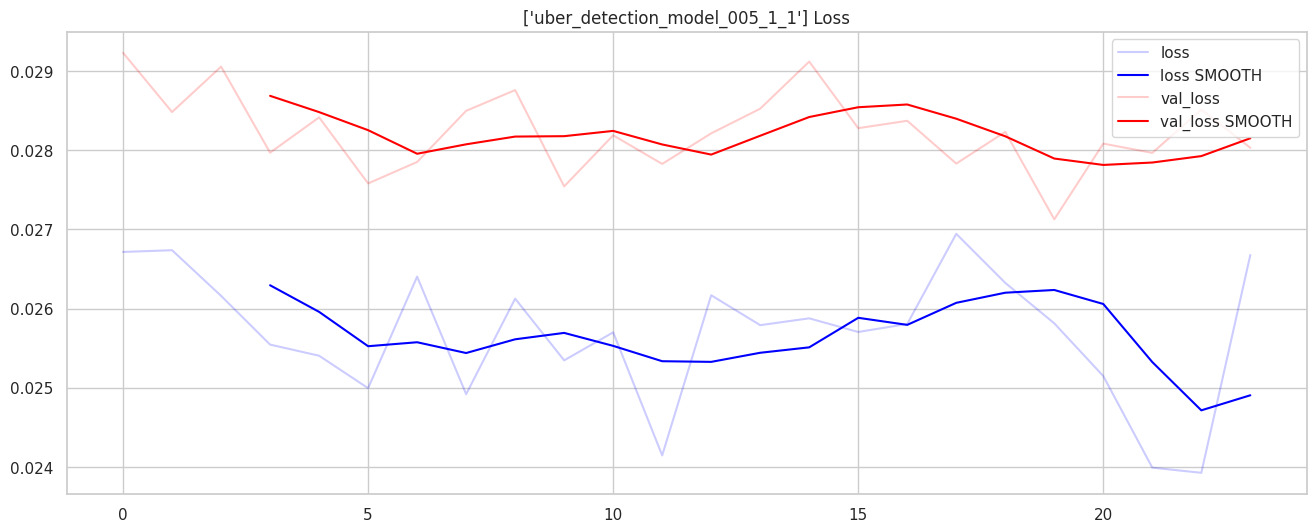

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


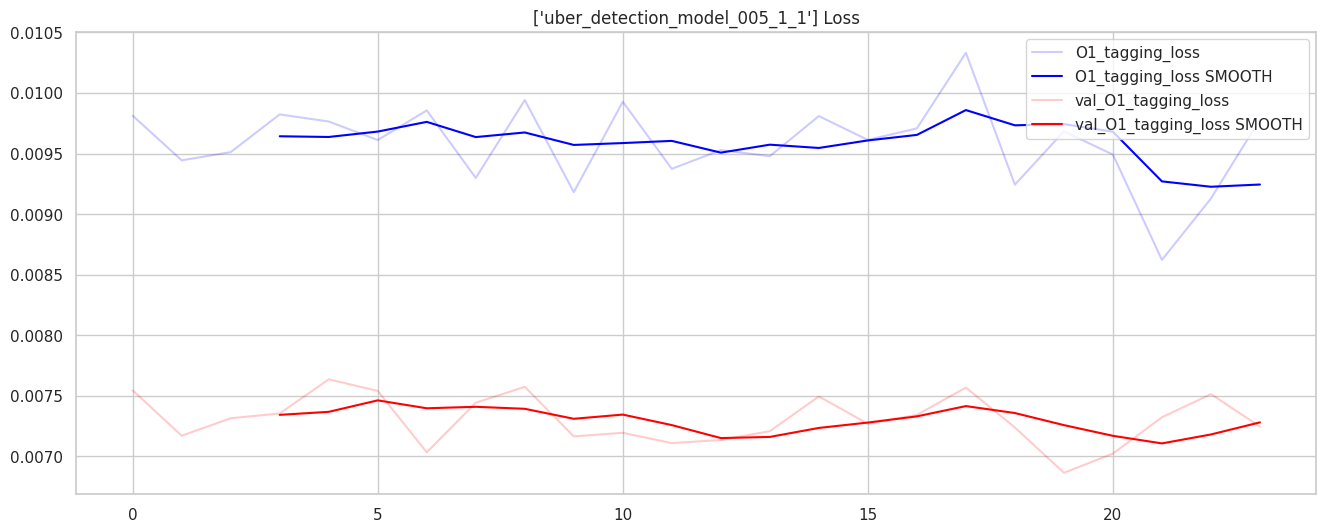

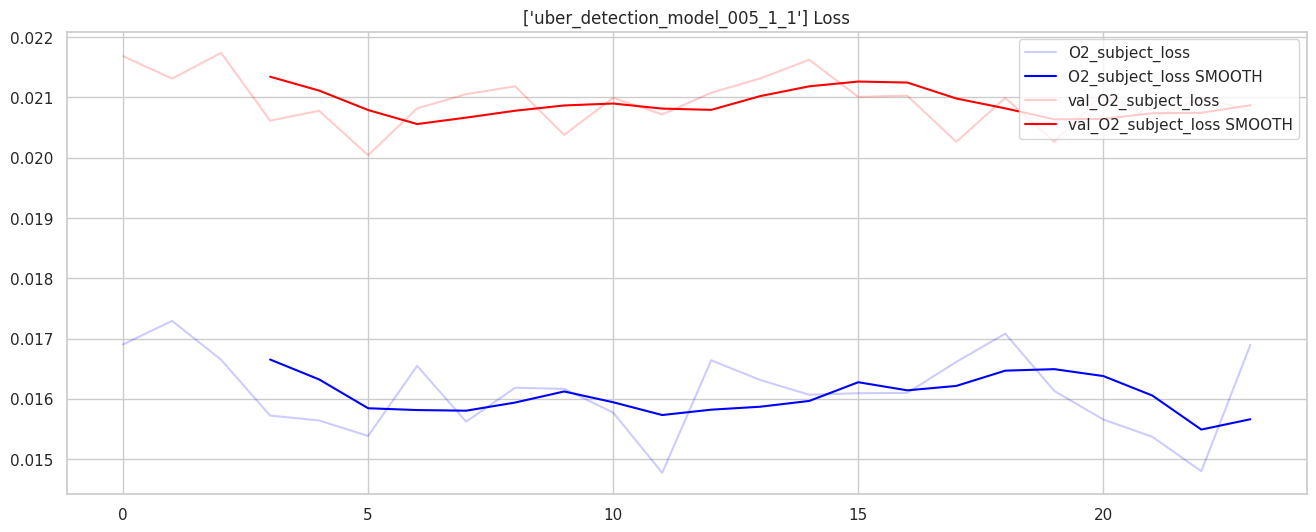

In [44]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [45]:
# umtm.stats
# semantic_map_keys_contract


6285f9c04d1bfe5e5b297ddd


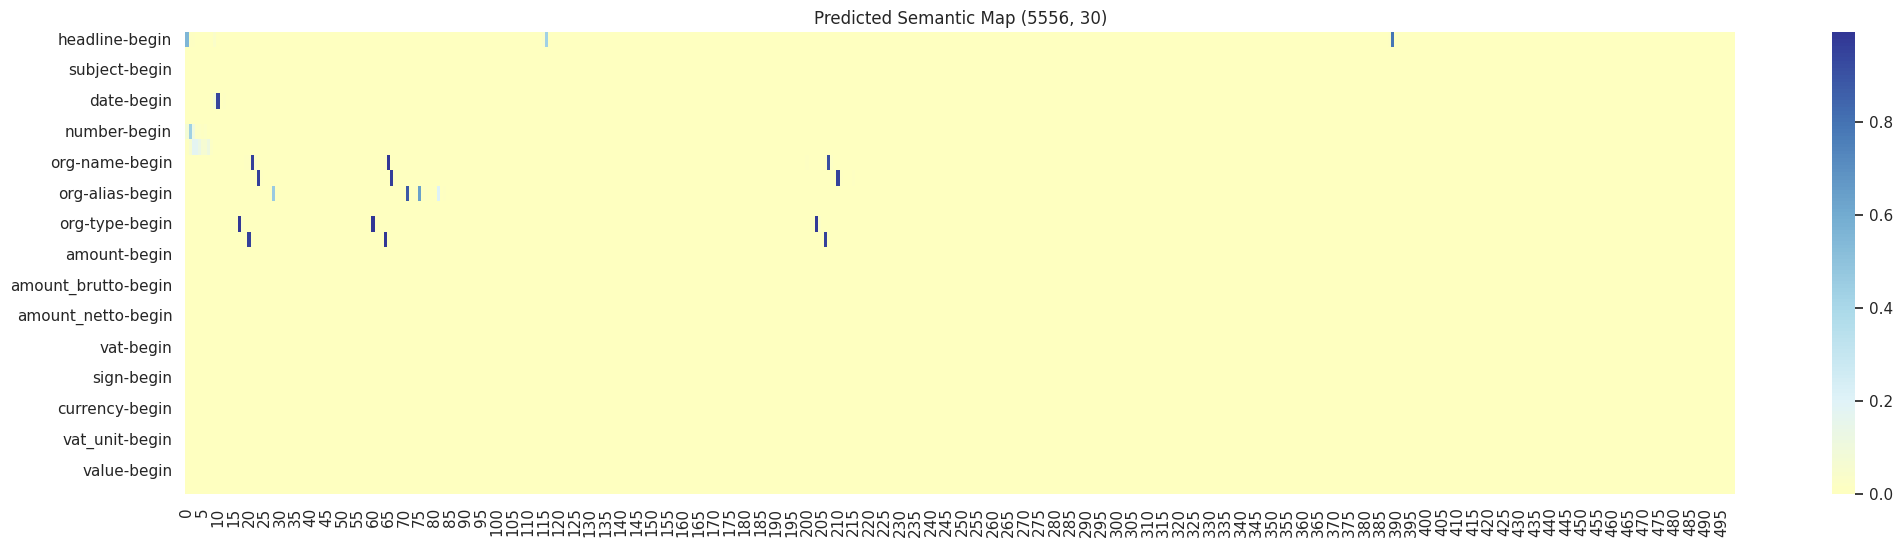

In [46]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [47]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [48]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'